### TFG MES - Cesar Hernandez Rodriguez
El estudio se hace con los datos historicos de mes a mes (21 dias), se realiza la prediccion de ciertos activos elegidos previamente, si se necesita cualquier otro activo del NASDAQ estan en los otros script ya que esto solo es una pequeña muestra representativa del funcionamiento

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice NASDAQ que es uno de los índices más importantes de Estados Unidos (índide tecnologico), siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

De este conjunto de datos solo voy a coger son $['AAPL', 'SNRC', 'ATVI', 'MINI', 'GOOG', 'BBOX']$ 

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. Al crearme una cuenta gratuita las opciones que se ofrecen no son las mias que para una cuenata premium por lo que cogere fechas pasadas y no actuales. 

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

A la hora de realizar el modelo creo 3 atributos, 2 medias moviles una de 10 dias y otra de 20 dias y un oscilador de la media movil de 20 dias.

Depues de realizar el modelo la idea de la practica es realizar una prueba real, por ello me fio del modelo que he obtenido e imaginando una inversion inical de 100000 euros dejo que la red neuronal haga lo que deba con ese dinero, decidiendo si quiere comprar, vender o mantener. Hay 3 formas programadas, compra a la alza, compra a la alza y a la baja y compra a la baja.

In [2]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt
from collections import Counter

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import SimpleRNN #Redes Recurrentes
from keras.layers import LSTM
from keras.layers import GRU
import keras.backend as K

# Conteo
from collections import Counter

# Graficos
#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
plt.style.use('seaborn')

In [3]:
# Descarga de las bases los tickets de los activos que vamos a predecir con los csv de la carpeta
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-listed-symbols-TFG.csv')
    
    tickersQuandl = []    
    tickers = pd.DataFrame(columns = ['Symbol','CompanyName'], index = range(len(tickers_nasdaq)))

    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq['Symbol'][i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers['Symbol'][i] = word
                tickers['CompanyName'][i] = tickers_nasdaq['CompanyName'][i]
    
    for tick in tickers['Symbol']:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

#a,b = get_tickers_sample_nasdaq()

In [4]:
# Descargo de los datos con la API Quandl y la key propia
# Las fechas estan elegidas a convinencia para poder concatenar las fechas y que quede de seguido

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        #aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        aux=quandl.get(ticker,start_date="2009-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2016-11-01",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos_demo/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos_demo/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos_demo/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos_demo/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos_demo/nasdaq_testMes.p", "wb"))
    pickle.dump(datosClose_test, open("datos_demo/nasdaqClose_testMes.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [5]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos_demo/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos_demo/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos_demo/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos_demo/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos_demo/nasdaq_testMes.p", "rb" ))
    datosClose_test = pickle.load(open("datos_demo/nasdaqClose_testMes.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre['Symbol']].plot(figsize=(12,5),grid=True)
    plt.title('{} de la compañia {} {}\n'.format(nombre['Symbol'],nombre['CompanyName'],test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [7]:
datos_descargados = True
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a cargar los datos****

 ****Cargados los datos****


 ****Empezamos a cargar los datos test****

 ****Cargados los datos test****



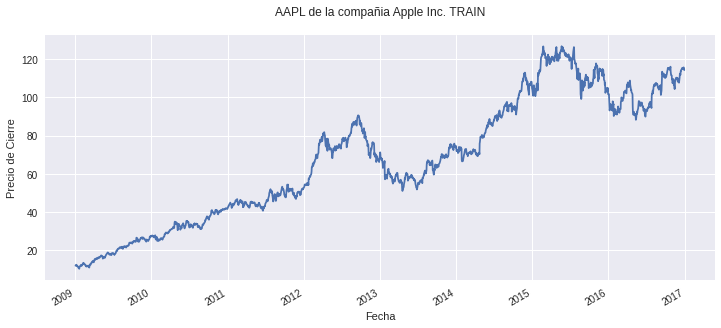

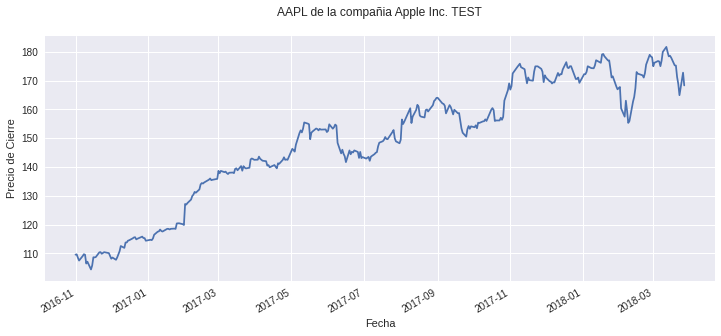

In [8]:
# Grafico un activo aleatorio 
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = 0
plot_datos(datosClose,tickers.iloc[ran],"TRAIN")
plot_datos(datosClose_test,tickers.iloc[ran],"TEST")

In [11]:
# Creacion de los atributos para la Red Neuronal Recurrente
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

In [12]:
# A parte de la creacion de atributos
index = ran
timeStep = 21 # longitud de secuencias que se hacen en cada iteracion de la red

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers['Symbol'][index]],10,20)
Y = pd.DataFrame(datosClose[tickers['Symbol'][index]].values[21:len(datosClose[tickers['Symbol'][index]])])
X = X.to_numpy()

# Creamos los atributos para los datos test
ticket_uso = tickers['Symbol'][index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers['Symbol'][index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers['Symbol'][index]].values[21:len(datosClose_test[tickers['Symbol'][index]])])
Xtesteo = Xtesteo.to_numpy()

# Junto todos los datos para poder hacer su correcta normalizacion
X_aux = np.concatenate((X,Xtesteo),axis=0)

scaler = MinMaxScaler()
X_aux_scaled = scaler.fit_transform(X_aux)
X_scaled = X_aux_scaled[0:len(X)]
Xtesteo_scaled = X_aux_scaled[len(X):len(X_aux_scaled)]

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


print("Voy a predecir el activo {} de la compañia {}".format(ticket_uso,tickers['CompanyName'][index]))

Voy a predecir el activo AAPL de la compañia Apple Inc.


In [13]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

In [11]:
modelRNN42 = Sequential()
modelRNN42.add(SimpleRNN(input_shape=(21,3),units=4,activation='relu',return_sequences=True))
modelRNN42.add(SimpleRNN(2,activation="relu"))
modelRNN42.add(Dense(1)) 
modelRNN42.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN42.summary()
history_RNN42 = modelRNN42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 21, 4)             32        
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 2)                 14        
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
42/42 [==============================] - 1s 30ms/step - loss: 5583.8169 - porcentaje_margen: 0.0000e+00 - val_loss: 5507.5728 - val_porcentaje_margen: 0.0000e+00
Epoch 2/15
42/42 [==============================] - 1s 19ms/step - loss: 5492.5786 - porcentaje_margen: 0.0000e+00 - val_loss: 5385.1831 - val_porcentaje_margen: 0.0000e+00
Epoch 3/15
42/42 [==========================

In [14]:
modelRNN84 = Sequential()
modelRNN84.add(SimpleRNN(input_shape=(21,3),units=8,activation='relu',return_sequences=True))
modelRNN84.add(SimpleRNN(4,activation="relu"))
modelRNN84.add(Dense(1)) 
modelRNN84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN84.summary()
history_RNN84 = modelRNN84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 21, 8)             96        
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 4)                 52        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 1s 21ms/step - loss: 5557.2021 - porcentaje_margen: 0.0000e+00 - val_loss: 5377.9756 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 16ms/step - loss: 3669.8350 - porcentaje_margen: 0.0179 - val_loss: 482.1872 - val_porcentaje_margen: 0.1109
Epoch 3/1500
42/42 [===========================

42/42 [==============================] - 0s 10ms/step - loss: 22.9902 - porcentaje_margen: 0.5610 - val_loss: 18.9666 - val_porcentaje_margen: 0.5782
Epoch 47/1500
42/42 [==============================] - 0s 11ms/step - loss: 20.8208 - porcentaje_margen: 0.5543 - val_loss: 18.7385 - val_porcentaje_margen: 0.5708
Epoch 48/1500
42/42 [==============================] - 0s 10ms/step - loss: 21.1352 - porcentaje_margen: 0.5491 - val_loss: 18.9468 - val_porcentaje_margen: 0.5435
Epoch 49/1500
42/42 [==============================] - 0s 11ms/step - loss: 22.3233 - porcentaje_margen: 0.5372 - val_loss: 21.9468 - val_porcentaje_margen: 0.5506
Epoch 50/1500
42/42 [==============================] - 0s 10ms/step - loss: 21.9861 - porcentaje_margen: 0.5543 - val_loss: 25.8126 - val_porcentaje_margen: 0.5155
Epoch 51/1500
42/42 [==============================] - 0s 10ms/step - loss: 21.8552 - porcentaje_margen: 0.5625 - val_loss: 18.4531 - val_porcentaje_margen: 0.5741
Epoch 52/1500
42/42 [=========

42/42 [==============================] - 1s 14ms/step - loss: 19.6151 - porcentaje_margen: 0.5982 - val_loss: 19.5765 - val_porcentaje_margen: 0.5625
Epoch 97/1500
42/42 [==============================] - 1s 17ms/step - loss: 19.1422 - porcentaje_margen: 0.5774 - val_loss: 18.1869 - val_porcentaje_margen: 0.5911
Epoch 98/1500
42/42 [==============================] - 1s 14ms/step - loss: 19.4015 - porcentaje_margen: 0.5729 - val_loss: 17.8240 - val_porcentaje_margen: 0.6053
Epoch 99/1500
42/42 [==============================] - 0s 11ms/step - loss: 19.6459 - porcentaje_margen: 0.5900 - val_loss: 17.3170 - val_porcentaje_margen: 0.6128
Epoch 100/1500
42/42 [==============================] - 1s 13ms/step - loss: 18.4118 - porcentaje_margen: 0.5923 - val_loss: 17.0690 - val_porcentaje_margen: 0.5994
Epoch 101/1500
42/42 [==============================] - 1s 14ms/step - loss: 18.4974 - porcentaje_margen: 0.5960 - val_loss: 17.0070 - val_porcentaje_margen: 0.6131
Epoch 102/1500
42/42 [======

Epoch 146/1500
42/42 [==============================] - 1s 19ms/step - loss: 17.7740 - porcentaje_margen: 0.6094 - val_loss: 17.3535 - val_porcentaje_margen: 0.6134
Epoch 147/1500
42/42 [==============================] - 1s 21ms/step - loss: 17.9096 - porcentaje_margen: 0.6019 - val_loss: 19.4077 - val_porcentaje_margen: 0.5498
Epoch 148/1500
42/42 [==============================] - 1s 18ms/step - loss: 19.3430 - porcentaje_margen: 0.5923 - val_loss: 16.0795 - val_porcentaje_margen: 0.6291
Epoch 149/1500
42/42 [==============================] - 1s 15ms/step - loss: 18.0973 - porcentaje_margen: 0.5997 - val_loss: 17.9193 - val_porcentaje_margen: 0.6443
Epoch 150/1500
42/42 [==============================] - 1s 13ms/step - loss: 17.7523 - porcentaje_margen: 0.6146 - val_loss: 16.9738 - val_porcentaje_margen: 0.5997
Epoch 151/1500
42/42 [==============================] - 1s 14ms/step - loss: 18.1168 - porcentaje_margen: 0.6027 - val_loss: 17.2313 - val_porcentaje_margen: 0.6030
Epoch 152/

Epoch 196/1500
42/42 [==============================] - 1s 13ms/step - loss: 17.7758 - porcentaje_margen: 0.6414 - val_loss: 16.1106 - val_porcentaje_margen: 0.6339
Epoch 197/1500
42/42 [==============================] - 1s 12ms/step - loss: 17.5093 - porcentaje_margen: 0.6190 - val_loss: 16.0255 - val_porcentaje_margen: 0.6369
Epoch 198/1500
42/42 [==============================] - 1s 13ms/step - loss: 17.9748 - porcentaje_margen: 0.6213 - val_loss: 18.0247 - val_porcentaje_margen: 0.5870
Epoch 199/1500
42/42 [==============================] - 1s 13ms/step - loss: 17.2229 - porcentaje_margen: 0.6518 - val_loss: 15.6424 - val_porcentaje_margen: 0.6295
Epoch 200/1500
42/42 [==============================] - 0s 12ms/step - loss: 16.6749 - porcentaje_margen: 0.6429 - val_loss: 17.3246 - val_porcentaje_margen: 0.5914
Epoch 201/1500
42/42 [==============================] - 1s 13ms/step - loss: 16.9207 - porcentaje_margen: 0.6339 - val_loss: 15.6924 - val_porcentaje_margen: 0.6399
Epoch 202/

Epoch 246/1500
42/42 [==============================] - 1s 13ms/step - loss: 16.7409 - porcentaje_margen: 0.6324 - val_loss: 15.8949 - val_porcentaje_margen: 0.6491
Epoch 247/1500
42/42 [==============================] - 1s 13ms/step - loss: 16.3514 - porcentaje_margen: 0.6525 - val_loss: 17.1066 - val_porcentaje_margen: 0.6134
Epoch 248/1500
42/42 [==============================] - 1s 12ms/step - loss: 16.9408 - porcentaje_margen: 0.6287 - val_loss: 15.6419 - val_porcentaje_margen: 0.6280
Epoch 249/1500
42/42 [==============================] - 1s 13ms/step - loss: 16.4809 - porcentaje_margen: 0.6354 - val_loss: 15.4629 - val_porcentaje_margen: 0.6399
Epoch 250/1500
42/42 [==============================] - 1s 13ms/step - loss: 16.1618 - porcentaje_margen: 0.6369 - val_loss: 15.4045 - val_porcentaje_margen: 0.6592
Epoch 251/1500
42/42 [==============================] - 1s 13ms/step - loss: 16.3254 - porcentaje_margen: 0.6317 - val_loss: 15.4694 - val_porcentaje_margen: 0.6562
Epoch 252/

Epoch 296/1500
42/42 [==============================] - 1s 13ms/step - loss: 16.3151 - porcentaje_margen: 0.6228 - val_loss: 14.5182 - val_porcentaje_margen: 0.6607
Epoch 297/1500
42/42 [==============================] - 1s 13ms/step - loss: 15.5222 - porcentaje_margen: 0.6414 - val_loss: 14.7427 - val_porcentaje_margen: 0.6678
Epoch 298/1500
42/42 [==============================] - 1s 12ms/step - loss: 17.0578 - porcentaje_margen: 0.6302 - val_loss: 14.8424 - val_porcentaje_margen: 0.6562
Epoch 299/1500
42/42 [==============================] - 1s 13ms/step - loss: 16.0218 - porcentaje_margen: 0.6458 - val_loss: 15.3815 - val_porcentaje_margen: 0.6500
Epoch 300/1500
42/42 [==============================] - 1s 12ms/step - loss: 15.3630 - porcentaje_margen: 0.6451 - val_loss: 17.3111 - val_porcentaje_margen: 0.6030
Epoch 301/1500
42/42 [==============================] - 1s 13ms/step - loss: 16.9067 - porcentaje_margen: 0.6235 - val_loss: 15.2843 - val_porcentaje_margen: 0.6167
Epoch 302/

Epoch 346/1500
42/42 [==============================] - 1s 16ms/step - loss: 14.9124 - porcentaje_margen: 0.6570 - val_loss: 14.7766 - val_porcentaje_margen: 0.6473
Epoch 347/1500
42/42 [==============================] - 1s 15ms/step - loss: 15.3025 - porcentaje_margen: 0.6570 - val_loss: 13.9610 - val_porcentaje_margen: 0.6640
Epoch 348/1500
42/42 [==============================] - 1s 16ms/step - loss: 15.0569 - porcentaje_margen: 0.6570 - val_loss: 17.6342 - val_porcentaje_margen: 0.5989
Epoch 349/1500
42/42 [==============================] - 1s 15ms/step - loss: 15.5743 - porcentaje_margen: 0.6481 - val_loss: 14.0187 - val_porcentaje_margen: 0.6640
Epoch 350/1500
42/42 [==============================] - 1s 15ms/step - loss: 15.2446 - porcentaje_margen: 0.6481 - val_loss: 14.1667 - val_porcentaje_margen: 0.6577
Epoch 351/1500
42/42 [==============================] - 1s 14ms/step - loss: 15.0912 - porcentaje_margen: 0.6615 - val_loss: 14.9356 - val_porcentaje_margen: 0.6648
Epoch 352/

Epoch 396/1500
42/42 [==============================] - 1s 13ms/step - loss: 15.2122 - porcentaje_margen: 0.6533 - val_loss: 13.6332 - val_porcentaje_margen: 0.6801
Epoch 397/1500
42/42 [==============================] - 1s 13ms/step - loss: 14.2254 - porcentaje_margen: 0.6652 - val_loss: 13.5717 - val_porcentaje_margen: 0.6753
Epoch 398/1500
42/42 [==============================] - 1s 13ms/step - loss: 14.2988 - porcentaje_margen: 0.6756 - val_loss: 13.5951 - val_porcentaje_margen: 0.6786
Epoch 399/1500
42/42 [==============================] - 1s 13ms/step - loss: 14.3582 - porcentaje_margen: 0.6451 - val_loss: 13.5726 - val_porcentaje_margen: 0.6652
Epoch 400/1500
42/42 [==============================] - 1s 13ms/step - loss: 15.0699 - porcentaje_margen: 0.6548 - val_loss: 14.2575 - val_porcentaje_margen: 0.6592
Epoch 401/1500
42/42 [==============================] - 1s 15ms/step - loss: 14.4908 - porcentaje_margen: 0.6481 - val_loss: 15.7203 - val_porcentaje_margen: 0.6119
Epoch 402/

Epoch 446/1500
42/42 [==============================] - 1s 19ms/step - loss: 14.8050 - porcentaje_margen: 0.6629 - val_loss: 12.7935 - val_porcentaje_margen: 0.6920
Epoch 447/1500
42/42 [==============================] - 1s 25ms/step - loss: 13.8687 - porcentaje_margen: 0.6414 - val_loss: 15.9856 - val_porcentaje_margen: 0.6238
Epoch 448/1500
42/42 [==============================] - 2s 38ms/step - loss: 14.1737 - porcentaje_margen: 0.6696 - val_loss: 13.2469 - val_porcentaje_margen: 0.6887
Epoch 449/1500
42/42 [==============================] - 1s 22ms/step - loss: 13.6611 - porcentaje_margen: 0.6771 - val_loss: 14.1621 - val_porcentaje_margen: 0.6625
Epoch 450/1500
42/42 [==============================] - 1s 21ms/step - loss: 13.4105 - porcentaje_margen: 0.6644 - val_loss: 12.8371 - val_porcentaje_margen: 0.6890
Epoch 451/1500
42/42 [==============================] - 1s 17ms/step - loss: 14.0030 - porcentaje_margen: 0.6421 - val_loss: 13.2168 - val_porcentaje_margen: 0.6562
Epoch 452/

Epoch 496/1500
42/42 [==============================] - 1s 12ms/step - loss: 13.7571 - porcentaje_margen: 0.6711 - val_loss: 14.3652 - val_porcentaje_margen: 0.6625
Epoch 497/1500
42/42 [==============================] - 1s 13ms/step - loss: 13.7069 - porcentaje_margen: 0.6696 - val_loss: 13.1063 - val_porcentaje_margen: 0.6797
Epoch 498/1500
42/42 [==============================] - 1s 14ms/step - loss: 13.5761 - porcentaje_margen: 0.6659 - val_loss: 12.6293 - val_porcentaje_margen: 0.6830
Epoch 499/1500
42/42 [==============================] - 1s 14ms/step - loss: 13.3037 - porcentaje_margen: 0.6830 - val_loss: 12.2546 - val_porcentaje_margen: 0.7021
Epoch 500/1500
42/42 [==============================] - 0s 12ms/step - loss: 12.9058 - porcentaje_margen: 0.6615 - val_loss: 16.3231 - val_porcentaje_margen: 0.5941
Epoch 501/1500
42/42 [==============================] - 1s 14ms/step - loss: 13.6624 - porcentaje_margen: 0.6600 - val_loss: 14.0616 - val_porcentaje_margen: 0.6622
Epoch 502/

Epoch 546/1500
42/42 [==============================] - 1s 12ms/step - loss: 13.3227 - porcentaje_margen: 0.6659 - val_loss: 11.7937 - val_porcentaje_margen: 0.7002
Epoch 547/1500
42/42 [==============================] - 1s 12ms/step - loss: 12.8809 - porcentaje_margen: 0.6637 - val_loss: 12.9112 - val_porcentaje_margen: 0.6729
Epoch 548/1500
42/42 [==============================] - 1s 13ms/step - loss: 12.7908 - porcentaje_margen: 0.6704 - val_loss: 14.4449 - val_porcentaje_margen: 0.6116
Epoch 549/1500
42/42 [==============================] - 1s 12ms/step - loss: 13.6241 - porcentaje_margen: 0.6704 - val_loss: 12.5294 - val_porcentaje_margen: 0.6756
Epoch 550/1500
42/42 [==============================] - 1s 13ms/step - loss: 12.6536 - porcentaje_margen: 0.6964 - val_loss: 11.8719 - val_porcentaje_margen: 0.7047
Epoch 551/1500
42/42 [==============================] - 1s 14ms/step - loss: 13.0384 - porcentaje_margen: 0.6905 - val_loss: 11.9179 - val_porcentaje_margen: 0.6964
Epoch 552/

Epoch 596/1500
42/42 [==============================] - 1s 13ms/step - loss: 12.1250 - porcentaje_margen: 0.7054 - val_loss: 11.2108 - val_porcentaje_margen: 0.7080
Epoch 597/1500
42/42 [==============================] - 1s 13ms/step - loss: 11.9881 - porcentaje_margen: 0.6897 - val_loss: 12.8997 - val_porcentaje_margen: 0.6901
Epoch 598/1500
42/42 [==============================] - 1s 13ms/step - loss: 13.0755 - porcentaje_margen: 0.6905 - val_loss: 11.6635 - val_porcentaje_margen: 0.7181
Epoch 599/1500
42/42 [==============================] - 1s 14ms/step - loss: 11.9445 - porcentaje_margen: 0.6942 - val_loss: 16.0372 - val_porcentaje_margen: 0.6131
Epoch 600/1500
42/42 [==============================] - 1s 12ms/step - loss: 14.4904 - porcentaje_margen: 0.6503 - val_loss: 15.3943 - val_porcentaje_margen: 0.6152
Epoch 601/1500
42/42 [==============================] - 1s 12ms/step - loss: 13.2540 - porcentaje_margen: 0.6518 - val_loss: 11.2781 - val_porcentaje_margen: 0.7098
Epoch 602/

Epoch 646/1500
42/42 [==============================] - 1s 13ms/step - loss: 14.6656 - porcentaje_margen: 0.6228 - val_loss: 14.8160 - val_porcentaje_margen: 0.6232
Epoch 647/1500
42/42 [==============================] - 1s 12ms/step - loss: 12.2187 - porcentaje_margen: 0.6808 - val_loss: 10.7650 - val_porcentaje_margen: 0.7211
Epoch 648/1500
42/42 [==============================] - 1s 13ms/step - loss: 11.4577 - porcentaje_margen: 0.7269 - val_loss: 11.1568 - val_porcentaje_margen: 0.7345
Epoch 649/1500
42/42 [==============================] - 1s 13ms/step - loss: 11.3560 - porcentaje_margen: 0.7143 - val_loss: 11.7238 - val_porcentaje_margen: 0.7021
Epoch 650/1500
42/42 [==============================] - 1s 13ms/step - loss: 11.7686 - porcentaje_margen: 0.7076 - val_loss: 15.1350 - val_porcentaje_margen: 0.6182
Epoch 651/1500
42/42 [==============================] - 1s 13ms/step - loss: 11.5997 - porcentaje_margen: 0.7009 - val_loss: 11.4554 - val_porcentaje_margen: 0.7083
Epoch 652/

Epoch 696/1500
42/42 [==============================] - 1s 12ms/step - loss: 11.4162 - porcentaje_margen: 0.7158 - val_loss: 11.1075 - val_porcentaje_margen: 0.7229
Epoch 697/1500
42/42 [==============================] - 1s 12ms/step - loss: 10.7307 - porcentaje_margen: 0.7292 - val_loss: 10.7908 - val_porcentaje_margen: 0.7158
Epoch 698/1500
42/42 [==============================] - 1s 12ms/step - loss: 11.5007 - porcentaje_margen: 0.7240 - val_loss: 12.9732 - val_porcentaje_margen: 0.6566
Epoch 699/1500
42/42 [==============================] - 1s 12ms/step - loss: 10.9360 - porcentaje_margen: 0.7106 - val_loss: 10.8221 - val_porcentaje_margen: 0.7300
Epoch 700/1500
42/42 [==============================] - 1s 12ms/step - loss: 11.2605 - porcentaje_margen: 0.7083 - val_loss: 10.3039 - val_porcentaje_margen: 0.7479
Epoch 701/1500
42/42 [==============================] - 1s 13ms/step - loss: 11.1666 - porcentaje_margen: 0.7329 - val_loss: 10.7339 - val_porcentaje_margen: 0.7333
Epoch 702/

Epoch 746/1500
42/42 [==============================] - 1s 12ms/step - loss: 11.1461 - porcentaje_margen: 0.7210 - val_loss: 10.0158 - val_porcentaje_margen: 0.7479
Epoch 747/1500
42/42 [==============================] - 1s 13ms/step - loss: 10.3192 - porcentaje_margen: 0.7188 - val_loss: 12.7402 - val_porcentaje_margen: 0.6429
Epoch 748/1500
42/42 [==============================] - 1s 14ms/step - loss: 11.4107 - porcentaje_margen: 0.6972 - val_loss: 9.5894 - val_porcentaje_margen: 0.7687
Epoch 749/1500
42/42 [==============================] - 1s 13ms/step - loss: 10.7973 - porcentaje_margen: 0.7277 - val_loss: 10.5760 - val_porcentaje_margen: 0.7002
Epoch 750/1500
42/42 [==============================] - 1s 13ms/step - loss: 10.5657 - porcentaje_margen: 0.7225 - val_loss: 10.3129 - val_porcentaje_margen: 0.7050
Epoch 751/1500
42/42 [==============================] - 1s 13ms/step - loss: 11.1259 - porcentaje_margen: 0.6987 - val_loss: 9.8307 - val_porcentaje_margen: 0.7303
Epoch 752/15

Epoch 796/1500
42/42 [==============================] - 1s 13ms/step - loss: 10.0142 - porcentaje_margen: 0.7448 - val_loss: 10.3182 - val_porcentaje_margen: 0.7032
Epoch 797/1500
42/42 [==============================] - 1s 14ms/step - loss: 9.9200 - porcentaje_margen: 0.7522 - val_loss: 9.3956 - val_porcentaje_margen: 0.7702
Epoch 798/1500
42/42 [==============================] - 1s 13ms/step - loss: 10.2741 - porcentaje_margen: 0.7567 - val_loss: 10.0196 - val_porcentaje_margen: 0.7359
Epoch 799/1500
42/42 [==============================] - 1s 13ms/step - loss: 11.0117 - porcentaje_margen: 0.6972 - val_loss: 13.8425 - val_porcentaje_margen: 0.6690
Epoch 800/1500
42/42 [==============================] - 1s 13ms/step - loss: 10.4102 - porcentaje_margen: 0.7411 - val_loss: 9.6656 - val_porcentaje_margen: 0.7583
Epoch 801/1500
42/42 [==============================] - 1s 12ms/step - loss: 9.9750 - porcentaje_margen: 0.7545 - val_loss: 9.1612 - val_porcentaje_margen: 0.7612
Epoch 802/1500


42/42 [==============================] - 1s 14ms/step - loss: 9.3258 - porcentaje_margen: 0.7664 - val_loss: 8.5675 - val_porcentaje_margen: 0.7776
Epoch 847/1500
42/42 [==============================] - 1s 15ms/step - loss: 9.1769 - porcentaje_margen: 0.7560 - val_loss: 8.6526 - val_porcentaje_margen: 0.7773
Epoch 848/1500
42/42 [==============================] - 1s 14ms/step - loss: 9.7817 - porcentaje_margen: 0.7522 - val_loss: 8.8348 - val_porcentaje_margen: 0.7535
Epoch 849/1500
42/42 [==============================] - 1s 14ms/step - loss: 9.5811 - porcentaje_margen: 0.7567 - val_loss: 8.8835 - val_porcentaje_margen: 0.7776
Epoch 850/1500
42/42 [==============================] - 1s 13ms/step - loss: 9.7642 - porcentaje_margen: 0.7537 - val_loss: 8.8930 - val_porcentaje_margen: 0.7717
Epoch 851/1500
42/42 [==============================] - 1s 13ms/step - loss: 10.1978 - porcentaje_margen: 0.7292 - val_loss: 9.5567 - val_porcentaje_margen: 0.7267
Epoch 852/1500
42/42 [==============

42/42 [==============================] - 0s 12ms/step - loss: 9.2951 - porcentaje_margen: 0.7455 - val_loss: 7.9738 - val_porcentaje_margen: 0.7955
Epoch 897/1500
42/42 [==============================] - 1s 13ms/step - loss: 9.6585 - porcentaje_margen: 0.7522 - val_loss: 11.0810 - val_porcentaje_margen: 0.6880
Epoch 898/1500
42/42 [==============================] - 1s 13ms/step - loss: 9.2840 - porcentaje_margen: 0.7641 - val_loss: 8.6360 - val_porcentaje_margen: 0.7907
Epoch 899/1500
42/42 [==============================] - 1s 12ms/step - loss: 8.8210 - porcentaje_margen: 0.7708 - val_loss: 9.3354 - val_porcentaje_margen: 0.7728
Epoch 900/1500
42/42 [==============================] - 1s 13ms/step - loss: 9.9047 - porcentaje_margen: 0.7455 - val_loss: 8.9051 - val_porcentaje_margen: 0.7583
Epoch 901/1500
42/42 [==============================] - 1s 12ms/step - loss: 8.6676 - porcentaje_margen: 0.7545 - val_loss: 7.8962 - val_porcentaje_margen: 0.7925
Epoch 902/1500
42/42 [==============

42/42 [==============================] - 1s 14ms/step - loss: 8.2316 - porcentaje_margen: 0.7932 - val_loss: 8.9127 - val_porcentaje_margen: 0.7252
Epoch 947/1500
42/42 [==============================] - 1s 14ms/step - loss: 8.5027 - porcentaje_margen: 0.7612 - val_loss: 13.2319 - val_porcentaje_margen: 0.6276
Epoch 948/1500
42/42 [==============================] - 1s 13ms/step - loss: 10.9401 - porcentaje_margen: 0.7098 - val_loss: 8.6699 - val_porcentaje_margen: 0.7583
Epoch 949/1500
42/42 [==============================] - 1s 12ms/step - loss: 9.1606 - porcentaje_margen: 0.7708 - val_loss: 7.5914 - val_porcentaje_margen: 0.8148
Epoch 950/1500
42/42 [==============================] - 0s 12ms/step - loss: 8.1298 - porcentaje_margen: 0.7939 - val_loss: 8.0562 - val_porcentaje_margen: 0.8014
Epoch 951/1500
42/42 [==============================] - 1s 12ms/step - loss: 8.1796 - porcentaje_margen: 0.7924 - val_loss: 8.4060 - val_porcentaje_margen: 0.7922
Epoch 952/1500
42/42 [=============

42/42 [==============================] - 1s 15ms/step - loss: 7.7596 - porcentaje_margen: 0.7984 - val_loss: 7.3344 - val_porcentaje_margen: 0.7984
Epoch 997/1500
42/42 [==============================] - 1s 16ms/step - loss: 8.7161 - porcentaje_margen: 0.7530 - val_loss: 9.4996 - val_porcentaje_margen: 0.7118
Epoch 998/1500
42/42 [==============================] - 1s 13ms/step - loss: 7.8161 - porcentaje_margen: 0.8058 - val_loss: 9.3029 - val_porcentaje_margen: 0.7062
Epoch 999/1500
42/42 [==============================] - 1s 15ms/step - loss: 8.1955 - porcentaje_margen: 0.7693 - val_loss: 9.1550 - val_porcentaje_margen: 0.7032
Epoch 1000/1500
42/42 [==============================] - 1s 15ms/step - loss: 9.2732 - porcentaje_margen: 0.7463 - val_loss: 6.9479 - val_porcentaje_margen: 0.8261
Epoch 1001/1500
42/42 [==============================] - 1s 15ms/step - loss: 7.7109 - porcentaje_margen: 0.8110 - val_loss: 7.5018 - val_porcentaje_margen: 0.7657
Epoch 1002/1500
42/42 [============

42/42 [==============================] - 1s 13ms/step - loss: 7.1841 - porcentaje_margen: 0.8088 - val_loss: 6.6695 - val_porcentaje_margen: 0.8335
Epoch 1047/1500
42/42 [==============================] - 1s 14ms/step - loss: 7.2462 - porcentaje_margen: 0.8214 - val_loss: 6.4989 - val_porcentaje_margen: 0.8123
Epoch 1048/1500
42/42 [==============================] - 1s 13ms/step - loss: 7.6953 - porcentaje_margen: 0.7723 - val_loss: 6.9763 - val_porcentaje_margen: 0.7970
Epoch 1049/1500
42/42 [==============================] - 1s 12ms/step - loss: 7.8890 - porcentaje_margen: 0.7954 - val_loss: 6.5318 - val_porcentaje_margen: 0.8168
Epoch 1050/1500
42/42 [==============================] - 1s 12ms/step - loss: 7.7153 - porcentaje_margen: 0.7909 - val_loss: 18.5369 - val_porcentaje_margen: 0.5018
Epoch 1051/1500
42/42 [==============================] - 1s 12ms/step - loss: 9.6148 - porcentaje_margen: 0.7403 - val_loss: 6.8678 - val_porcentaje_margen: 0.7989
Epoch 1052/1500
42/42 [========

42/42 [==============================] - 1s 13ms/step - loss: 7.4752 - porcentaje_margen: 0.8051 - val_loss: 12.0168 - val_porcentaje_margen: 0.6429
Epoch 1097/1500
42/42 [==============================] - 1s 12ms/step - loss: 7.3786 - porcentaje_margen: 0.7969 - val_loss: 6.2112 - val_porcentaje_margen: 0.8242
Epoch 1098/1500
42/42 [==============================] - 1s 13ms/step - loss: 7.0733 - porcentaje_margen: 0.8155 - val_loss: 6.8856 - val_porcentaje_margen: 0.7975
Epoch 1099/1500
42/42 [==============================] - 1s 12ms/step - loss: 6.8990 - porcentaje_margen: 0.8348 - val_loss: 9.1338 - val_porcentaje_margen: 0.7490
Epoch 1100/1500
42/42 [==============================] - 1s 13ms/step - loss: 7.8104 - porcentaje_margen: 0.7872 - val_loss: 6.1650 - val_porcentaje_margen: 0.8272
Epoch 1101/1500
42/42 [==============================] - 1s 12ms/step - loss: 7.4676 - porcentaje_margen: 0.7917 - val_loss: 6.1559 - val_porcentaje_margen: 0.8406
Epoch 1102/1500
42/42 [========

42/42 [==============================] - 1s 12ms/step - loss: 7.6013 - porcentaje_margen: 0.7887 - val_loss: 5.9488 - val_porcentaje_margen: 0.8581
Epoch 1147/1500
42/42 [==============================] - 1s 12ms/step - loss: 6.3762 - porcentaje_margen: 0.8482 - val_loss: 5.7729 - val_porcentaje_margen: 0.8596
Epoch 1148/1500
42/42 [==============================] - 1s 12ms/step - loss: 6.6161 - porcentaje_margen: 0.8162 - val_loss: 6.4750 - val_porcentaje_margen: 0.8548
Epoch 1149/1500
42/42 [==============================] - 1s 12ms/step - loss: 7.2232 - porcentaje_margen: 0.8073 - val_loss: 8.0599 - val_porcentaje_margen: 0.8031
Epoch 1150/1500
42/42 [==============================] - 1s 13ms/step - loss: 7.8419 - porcentaje_margen: 0.8006 - val_loss: 6.9768 - val_porcentaje_margen: 0.8052
Epoch 1151/1500
42/42 [==============================] - 1s 14ms/step - loss: 6.7097 - porcentaje_margen: 0.8192 - val_loss: 5.6947 - val_porcentaje_margen: 0.8480
Epoch 1152/1500
42/42 [=========

42/42 [==============================] - 1s 12ms/step - loss: 8.5309 - porcentaje_margen: 0.7641 - val_loss: 6.8189 - val_porcentaje_margen: 0.8444
Epoch 1197/1500
42/42 [==============================] - 1s 14ms/step - loss: 6.3720 - porcentaje_margen: 0.8326 - val_loss: 7.1342 - val_porcentaje_margen: 0.8191
Epoch 1198/1500
42/42 [==============================] - 1s 12ms/step - loss: 6.1142 - porcentaje_margen: 0.8408 - val_loss: 9.1984 - val_porcentaje_margen: 0.7394
Epoch 1199/1500
42/42 [==============================] - 1s 12ms/step - loss: 7.4291 - porcentaje_margen: 0.8006 - val_loss: 5.9419 - val_porcentaje_margen: 0.8272
Epoch 1200/1500
42/42 [==============================] - 1s 12ms/step - loss: 6.1583 - porcentaje_margen: 0.8356 - val_loss: 5.8819 - val_porcentaje_margen: 0.8317
Epoch 1201/1500
42/42 [==============================] - 1s 12ms/step - loss: 6.2354 - porcentaje_margen: 0.8527 - val_loss: 5.9460 - val_porcentaje_margen: 0.8581
Epoch 1202/1500
42/42 [=========

42/42 [==============================] - 1s 13ms/step - loss: 5.9741 - porcentaje_margen: 0.8512 - val_loss: 6.8722 - val_porcentaje_margen: 0.8251
Epoch 1247/1500
42/42 [==============================] - 1s 12ms/step - loss: 6.3384 - porcentaje_margen: 0.8393 - val_loss: 5.1833 - val_porcentaje_margen: 0.8626
Epoch 1248/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.8993 - porcentaje_margen: 0.8557 - val_loss: 5.9968 - val_porcentaje_margen: 0.8709
Epoch 1249/1500
42/42 [==============================] - 1s 13ms/step - loss: 6.4426 - porcentaje_margen: 0.8467 - val_loss: 6.7260 - val_porcentaje_margen: 0.8168
Epoch 1250/1500
42/42 [==============================] - 1s 13ms/step - loss: 6.0295 - porcentaje_margen: 0.8631 - val_loss: 5.1804 - val_porcentaje_margen: 0.8656
Epoch 1251/1500
42/42 [==============================] - 1s 12ms/step - loss: 5.7575 - porcentaje_margen: 0.8646 - val_loss: 6.2075 - val_porcentaje_margen: 0.8317
Epoch 1252/1500
42/42 [=========

42/42 [==============================] - 1s 12ms/step - loss: 5.6971 - porcentaje_margen: 0.8743 - val_loss: 6.2434 - val_porcentaje_margen: 0.8251
Epoch 1297/1500
42/42 [==============================] - 1s 13ms/step - loss: 6.4151 - porcentaje_margen: 0.8385 - val_loss: 8.2568 - val_porcentaje_margen: 0.7338
Epoch 1298/1500
42/42 [==============================] - 1s 13ms/step - loss: 6.6880 - porcentaje_margen: 0.8237 - val_loss: 5.0931 - val_porcentaje_margen: 0.8656
Epoch 1299/1500
42/42 [==============================] - 1s 12ms/step - loss: 5.8730 - porcentaje_margen: 0.8557 - val_loss: 5.1629 - val_porcentaje_margen: 0.8857
Epoch 1300/1500
42/42 [==============================] - 1s 13ms/step - loss: 6.0907 - porcentaje_margen: 0.8408 - val_loss: 5.1368 - val_porcentaje_margen: 0.8801
Epoch 1301/1500
42/42 [==============================] - 1s 13ms/step - loss: 6.1464 - porcentaje_margen: 0.8519 - val_loss: 5.2906 - val_porcentaje_margen: 0.8626
Epoch 1302/1500
42/42 [=========

42/42 [==============================] - 1s 14ms/step - loss: 6.4256 - porcentaje_margen: 0.8475 - val_loss: 5.7328 - val_porcentaje_margen: 0.8123
Epoch 1347/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.7006 - porcentaje_margen: 0.8690 - val_loss: 7.9709 - val_porcentaje_margen: 0.7811
Epoch 1348/1500
42/42 [==============================] - 1s 13ms/step - loss: 6.9201 - porcentaje_margen: 0.8304 - val_loss: 7.5351 - val_porcentaje_margen: 0.8221
Epoch 1349/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.9245 - porcentaje_margen: 0.8609 - val_loss: 7.7462 - val_porcentaje_margen: 0.7811
Epoch 1350/1500
42/42 [==============================] - 1s 13ms/step - loss: 6.1599 - porcentaje_margen: 0.8504 - val_loss: 5.0541 - val_porcentaje_margen: 0.8730
Epoch 1351/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.8198 - porcentaje_margen: 0.8631 - val_loss: 5.0523 - val_porcentaje_margen: 0.8831
Epoch 1352/1500
42/42 [=========

42/42 [==============================] - 1s 13ms/step - loss: 6.4585 - porcentaje_margen: 0.8482 - val_loss: 5.4658 - val_porcentaje_margen: 0.8671
Epoch 1397/1500
42/42 [==============================] - 1s 15ms/step - loss: 6.1160 - porcentaje_margen: 0.8467 - val_loss: 7.3806 - val_porcentaje_margen: 0.7989
Epoch 1398/1500
42/42 [==============================] - 1s 13ms/step - loss: 6.7330 - porcentaje_margen: 0.8304 - val_loss: 5.7424 - val_porcentaje_margen: 0.8477
Epoch 1399/1500
42/42 [==============================] - 1s 12ms/step - loss: 5.8315 - porcentaje_margen: 0.8601 - val_loss: 5.6736 - val_porcentaje_margen: 0.8388
Epoch 1400/1500
42/42 [==============================] - 1s 12ms/step - loss: 5.8555 - porcentaje_margen: 0.8519 - val_loss: 7.4821 - val_porcentaje_margen: 0.7829
Epoch 1401/1500
42/42 [==============================] - 1s 13ms/step - loss: 6.1691 - porcentaje_margen: 0.8616 - val_loss: 5.1080 - val_porcentaje_margen: 0.8790
Epoch 1402/1500
42/42 [=========

42/42 [==============================] - 1s 12ms/step - loss: 7.0645 - porcentaje_margen: 0.8177 - val_loss: 5.9652 - val_porcentaje_margen: 0.8161
Epoch 1447/1500
42/42 [==============================] - 1s 12ms/step - loss: 6.1189 - porcentaje_margen: 0.8438 - val_loss: 4.8741 - val_porcentaje_margen: 0.8849
Epoch 1448/1500
42/42 [==============================] - 1s 12ms/step - loss: 5.5546 - porcentaje_margen: 0.8750 - val_loss: 7.4040 - val_porcentaje_margen: 0.7900
Epoch 1449/1500
42/42 [==============================] - 1s 13ms/step - loss: 6.3711 - porcentaje_margen: 0.8534 - val_loss: 5.1617 - val_porcentaje_margen: 0.8581
Epoch 1450/1500
42/42 [==============================] - 1s 12ms/step - loss: 6.2919 - porcentaje_margen: 0.8333 - val_loss: 5.1418 - val_porcentaje_margen: 0.8742
Epoch 1451/1500
42/42 [==============================] - 1s 12ms/step - loss: 5.5259 - porcentaje_margen: 0.8676 - val_loss: 6.0014 - val_porcentaje_margen: 0.8504
Epoch 1452/1500
42/42 [=========

42/42 [==============================] - 1s 12ms/step - loss: 5.5743 - porcentaje_margen: 0.8765 - val_loss: 5.2133 - val_porcentaje_margen: 0.8872
Epoch 1497/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.7232 - porcentaje_margen: 0.8728 - val_loss: 5.6304 - val_porcentaje_margen: 0.8623
Epoch 1498/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.6495 - porcentaje_margen: 0.8750 - val_loss: 5.7282 - val_porcentaje_margen: 0.8548
Epoch 1499/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.7523 - porcentaje_margen: 0.8765 - val_loss: 4.8719 - val_porcentaje_margen: 0.8790
Epoch 1500/1500
42/42 [==============================] - 1s 12ms/step - loss: 5.5173 - porcentaje_margen: 0.8795 - val_loss: 4.8251 - val_porcentaje_margen: 0.8891


In [15]:
modelRNN168 = Sequential()
modelRNN168.add(SimpleRNN(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelRNN168.add(SimpleRNN(8,activation="relu"))
modelRNN168.add(Dense(1)) 
modelRNN168.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN168.summary()
history_RNN168 = modelRNN168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 21, 16)            320       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 8)                 200       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 1s 20ms/step - loss: 5664.9272 - porcentaje_margen: 0.0000e+00 - val_loss: 5613.9141 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 14ms/step - loss: 4848.0146 - porcentaje_margen: 7.4405e-04 - val_loss: 579.7975 - val_porcentaje_margen: 0.0506
Epoch 3/1500
42/42 [=====================

42/42 [==============================] - 1s 15ms/step - loss: 19.7891 - porcentaje_margen: 0.6064 - val_loss: 14.8755 - val_porcentaje_margen: 0.6533
Epoch 47/1500
42/42 [==============================] - 1s 15ms/step - loss: 16.8070 - porcentaje_margen: 0.6414 - val_loss: 16.8743 - val_porcentaje_margen: 0.6354
Epoch 48/1500
42/42 [==============================] - 1s 12ms/step - loss: 16.5755 - porcentaje_margen: 0.6205 - val_loss: 18.3327 - val_porcentaje_margen: 0.6205
Epoch 49/1500
42/42 [==============================] - 1s 15ms/step - loss: 18.0359 - porcentaje_margen: 0.6421 - val_loss: 15.0054 - val_porcentaje_margen: 0.6392
Epoch 50/1500
42/42 [==============================] - 1s 14ms/step - loss: 16.2235 - porcentaje_margen: 0.6421 - val_loss: 15.3502 - val_porcentaje_margen: 0.6339
Epoch 51/1500
42/42 [==============================] - 1s 13ms/step - loss: 16.5095 - porcentaje_margen: 0.6443 - val_loss: 14.9482 - val_porcentaje_margen: 0.6458
Epoch 52/1500
42/42 [=========

42/42 [==============================] - 1s 13ms/step - loss: 14.6560 - porcentaje_margen: 0.6518 - val_loss: 14.5005 - val_porcentaje_margen: 0.6667
Epoch 97/1500
42/42 [==============================] - 1s 13ms/step - loss: 15.6074 - porcentaje_margen: 0.6421 - val_loss: 13.2221 - val_porcentaje_margen: 0.6868
Epoch 98/1500
42/42 [==============================] - 1s 14ms/step - loss: 14.5371 - porcentaje_margen: 0.6793 - val_loss: 13.5147 - val_porcentaje_margen: 0.6862
Epoch 99/1500
42/42 [==============================] - 1s 14ms/step - loss: 15.4965 - porcentaje_margen: 0.6347 - val_loss: 21.3179 - val_porcentaje_margen: 0.5503
Epoch 100/1500
42/42 [==============================] - 1s 14ms/step - loss: 17.9949 - porcentaje_margen: 0.6190 - val_loss: 15.5568 - val_porcentaje_margen: 0.6607
Epoch 101/1500
42/42 [==============================] - 1s 13ms/step - loss: 14.7530 - porcentaje_margen: 0.6734 - val_loss: 14.7384 - val_porcentaje_margen: 0.6652
Epoch 102/1500
42/42 [======

Epoch 146/1500
42/42 [==============================] - 1s 13ms/step - loss: 13.4511 - porcentaje_margen: 0.6875 - val_loss: 12.1079 - val_porcentaje_margen: 0.7118
Epoch 147/1500
42/42 [==============================] - 1s 14ms/step - loss: 13.9792 - porcentaje_margen: 0.6942 - val_loss: 30.2337 - val_porcentaje_margen: 0.4177
Epoch 148/1500
42/42 [==============================] - 1s 13ms/step - loss: 18.0428 - porcentaje_margen: 0.5878 - val_loss: 12.0831 - val_porcentaje_margen: 0.7115
Epoch 149/1500
42/42 [==============================] - 1s 14ms/step - loss: 16.1648 - porcentaje_margen: 0.6220 - val_loss: 12.8672 - val_porcentaje_margen: 0.6847
Epoch 150/1500
42/42 [==============================] - 1s 12ms/step - loss: 14.6865 - porcentaje_margen: 0.6659 - val_loss: 14.1957 - val_porcentaje_margen: 0.6716
Epoch 151/1500
42/42 [==============================] - 1s 14ms/step - loss: 14.5636 - porcentaje_margen: 0.6510 - val_loss: 12.6081 - val_porcentaje_margen: 0.7065
Epoch 152/

Epoch 196/1500
42/42 [==============================] - 1s 13ms/step - loss: 12.3876 - porcentaje_margen: 0.6994 - val_loss: 11.1335 - val_porcentaje_margen: 0.7397
Epoch 197/1500
42/42 [==============================] - 1s 14ms/step - loss: 12.5034 - porcentaje_margen: 0.7046 - val_loss: 11.9333 - val_porcentaje_margen: 0.6787
Epoch 198/1500
42/42 [==============================] - 1s 14ms/step - loss: 13.0160 - porcentaje_margen: 0.7009 - val_loss: 11.2156 - val_porcentaje_margen: 0.7353
Epoch 199/1500
42/42 [==============================] - 1s 14ms/step - loss: 12.5298 - porcentaje_margen: 0.6920 - val_loss: 12.5104 - val_porcentaje_margen: 0.6979
Epoch 200/1500
42/42 [==============================] - 1s 14ms/step - loss: 15.3956 - porcentaje_margen: 0.6592 - val_loss: 38.9166 - val_porcentaje_margen: 0.2629
Epoch 201/1500
42/42 [==============================] - 1s 15ms/step - loss: 18.6324 - porcentaje_margen: 0.5789 - val_loss: 20.1614 - val_porcentaje_margen: 0.5646
Epoch 202/

Epoch 246/1500
42/42 [==============================] - 1s 12ms/step - loss: 11.5415 - porcentaje_margen: 0.7135 - val_loss: 13.0318 - val_porcentaje_margen: 0.6567
Epoch 247/1500
42/42 [==============================] - 1s 13ms/step - loss: 12.0593 - porcentaje_margen: 0.6860 - val_loss: 10.8925 - val_porcentaje_margen: 0.7389
Epoch 248/1500
42/42 [==============================] - 1s 13ms/step - loss: 11.1931 - porcentaje_margen: 0.7388 - val_loss: 10.1480 - val_porcentaje_margen: 0.7535
Epoch 249/1500
42/42 [==============================] - 1s 12ms/step - loss: 11.6531 - porcentaje_margen: 0.7091 - val_loss: 10.0940 - val_porcentaje_margen: 0.7535
Epoch 250/1500
42/42 [==============================] - 1s 13ms/step - loss: 11.8343 - porcentaje_margen: 0.7054 - val_loss: 12.2008 - val_porcentaje_margen: 0.6716
Epoch 251/1500
42/42 [==============================] - 1s 13ms/step - loss: 13.4180 - porcentaje_margen: 0.6942 - val_loss: 10.2969 - val_porcentaje_margen: 0.7490
Epoch 252/

Epoch 296/1500
42/42 [==============================] - 1s 14ms/step - loss: 11.0261 - porcentaje_margen: 0.7240 - val_loss: 9.3113 - val_porcentaje_margen: 0.7755
Epoch 297/1500
42/42 [==============================] - 1s 12ms/step - loss: 10.8779 - porcentaje_margen: 0.7068 - val_loss: 10.8283 - val_porcentaje_margen: 0.7130
Epoch 298/1500
42/42 [==============================] - 1s 14ms/step - loss: 10.5672 - porcentaje_margen: 0.7500 - val_loss: 13.1891 - val_porcentaje_margen: 0.6759
Epoch 299/1500
42/42 [==============================] - 1s 13ms/step - loss: 10.7089 - porcentaje_margen: 0.7478 - val_loss: 10.8799 - val_porcentaje_margen: 0.7214
Epoch 300/1500
42/42 [==============================] - 1s 13ms/step - loss: 11.1242 - porcentaje_margen: 0.7232 - val_loss: 9.5493 - val_porcentaje_margen: 0.7609
Epoch 301/1500
42/42 [==============================] - 1s 13ms/step - loss: 10.3976 - porcentaje_margen: 0.7478 - val_loss: 12.7052 - val_porcentaje_margen: 0.6731
Epoch 302/15

Epoch 346/1500
42/42 [==============================] - 1s 13ms/step - loss: 10.5400 - porcentaje_margen: 0.7188 - val_loss: 11.7641 - val_porcentaje_margen: 0.7111
Epoch 347/1500
42/42 [==============================] - 1s 14ms/step - loss: 10.0400 - porcentaje_margen: 0.7448 - val_loss: 9.7529 - val_porcentaje_margen: 0.7546
Epoch 348/1500
42/42 [==============================] - 1s 13ms/step - loss: 10.0804 - porcentaje_margen: 0.7612 - val_loss: 13.3338 - val_porcentaje_margen: 0.6536
Epoch 349/1500
42/42 [==============================] - 1s 14ms/step - loss: 11.2408 - porcentaje_margen: 0.7329 - val_loss: 12.1946 - val_porcentaje_margen: 0.6670
Epoch 350/1500
42/42 [==============================] - 1s 14ms/step - loss: 11.4978 - porcentaje_margen: 0.7210 - val_loss: 9.3424 - val_porcentaje_margen: 0.7665
Epoch 351/1500
42/42 [==============================] - 1s 13ms/step - loss: 11.0778 - porcentaje_margen: 0.7054 - val_loss: 8.6526 - val_porcentaje_margen: 0.7717
Epoch 352/150

Epoch 396/1500
42/42 [==============================] - 1s 13ms/step - loss: 9.3449 - porcentaje_margen: 0.7842 - val_loss: 10.3094 - val_porcentaje_margen: 0.7249
Epoch 397/1500
42/42 [==============================] - 1s 13ms/step - loss: 9.9221 - porcentaje_margen: 0.7626 - val_loss: 8.2166 - val_porcentaje_margen: 0.8049
Epoch 398/1500
42/42 [==============================] - 1s 13ms/step - loss: 9.2387 - porcentaje_margen: 0.7917 - val_loss: 7.8341 - val_porcentaje_margen: 0.8183
Epoch 399/1500
42/42 [==============================] - 1s 13ms/step - loss: 9.5851 - porcentaje_margen: 0.7738 - val_loss: 8.5837 - val_porcentaje_margen: 0.7889
Epoch 400/1500
42/42 [==============================] - 1s 13ms/step - loss: 11.5127 - porcentaje_margen: 0.7202 - val_loss: 8.7268 - val_porcentaje_margen: 0.7781
Epoch 401/1500
42/42 [==============================] - 1s 13ms/step - loss: 10.9795 - porcentaje_margen: 0.7403 - val_loss: 9.2809 - val_porcentaje_margen: 0.7426
Epoch 402/1500
42/4

42/42 [==============================] - 1s 13ms/step - loss: 7.9519 - porcentaje_margen: 0.8192 - val_loss: 6.9979 - val_porcentaje_margen: 0.8552
Epoch 447/1500
42/42 [==============================] - 1s 12ms/step - loss: 11.2551 - porcentaje_margen: 0.7150 - val_loss: 7.3596 - val_porcentaje_margen: 0.8097
Epoch 448/1500
42/42 [==============================] - 1s 13ms/step - loss: 8.9080 - porcentaje_margen: 0.7827 - val_loss: 6.6986 - val_porcentaje_margen: 0.8388
Epoch 449/1500
42/42 [==============================] - 1s 12ms/step - loss: 8.2962 - porcentaje_margen: 0.7954 - val_loss: 6.8582 - val_porcentaje_margen: 0.8552
Epoch 450/1500
42/42 [==============================] - 1s 13ms/step - loss: 7.7938 - porcentaje_margen: 0.8237 - val_loss: 6.9066 - val_porcentaje_margen: 0.8373
Epoch 451/1500
42/42 [==============================] - 1s 13ms/step - loss: 7.2434 - porcentaje_margen: 0.8266 - val_loss: 7.8743 - val_porcentaje_margen: 0.7903
Epoch 452/1500
42/42 [==============

42/42 [==============================] - 1s 13ms/step - loss: 6.9875 - porcentaje_margen: 0.8207 - val_loss: 5.9285 - val_porcentaje_margen: 0.8451
Epoch 497/1500
42/42 [==============================] - 1s 12ms/step - loss: 6.2985 - porcentaje_margen: 0.8624 - val_loss: 5.1404 - val_porcentaje_margen: 0.8700
Epoch 498/1500
42/42 [==============================] - 1s 13ms/step - loss: 6.7973 - porcentaje_margen: 0.8445 - val_loss: 5.8756 - val_porcentaje_margen: 0.8828
Epoch 499/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.9605 - porcentaje_margen: 0.8594 - val_loss: 15.7578 - val_porcentaje_margen: 0.5600
Epoch 500/1500
42/42 [==============================] - 1s 14ms/step - loss: 9.2740 - porcentaje_margen: 0.7790 - val_loss: 5.3296 - val_porcentaje_margen: 0.8626
Epoch 501/1500
42/42 [==============================] - 1s 13ms/step - loss: 6.0026 - porcentaje_margen: 0.8557 - val_loss: 7.3283 - val_porcentaje_margen: 0.7945
Epoch 502/1500
42/42 [==============

Epoch 546/1500
42/42 [==============================] - 1s 14ms/step - loss: 7.2802 - porcentaje_margen: 0.8438 - val_loss: 4.8879 - val_porcentaje_margen: 0.9024
Epoch 547/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.4195 - porcentaje_margen: 0.8906 - val_loss: 6.8296 - val_porcentaje_margen: 0.8500
Epoch 548/1500
42/42 [==============================] - 1s 14ms/step - loss: 6.5862 - porcentaje_margen: 0.8534 - val_loss: 6.2046 - val_porcentaje_margen: 0.8619
Epoch 549/1500
42/42 [==============================] - 1s 15ms/step - loss: 5.7225 - porcentaje_margen: 0.8839 - val_loss: 5.4253 - val_porcentaje_margen: 0.8768
Epoch 550/1500
42/42 [==============================] - 1s 14ms/step - loss: 5.5375 - porcentaje_margen: 0.8839 - val_loss: 5.1479 - val_porcentaje_margen: 0.8991
Epoch 551/1500
42/42 [==============================] - 1s 13ms/step - loss: 8.0651 - porcentaje_margen: 0.8140 - val_loss: 5.4724 - val_porcentaje_margen: 0.8947
Epoch 552/1500
42/42 [

42/42 [==============================] - 1s 13ms/step - loss: 5.5017 - porcentaje_margen: 0.8847 - val_loss: 4.6871 - val_porcentaje_margen: 0.8977
Epoch 597/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.1450 - porcentaje_margen: 0.8914 - val_loss: 6.1010 - val_porcentaje_margen: 0.8649
Epoch 598/1500
42/42 [==============================] - 1s 13ms/step - loss: 6.9202 - porcentaje_margen: 0.8460 - val_loss: 8.7117 - val_porcentaje_margen: 0.7751
Epoch 599/1500
42/42 [==============================] - 1s 14ms/step - loss: 7.0542 - porcentaje_margen: 0.8289 - val_loss: 4.8637 - val_porcentaje_margen: 0.8887
Epoch 600/1500
42/42 [==============================] - 1s 14ms/step - loss: 5.7725 - porcentaje_margen: 0.8661 - val_loss: 7.2249 - val_porcentaje_margen: 0.8310
Epoch 601/1500
42/42 [==============================] - 1s 14ms/step - loss: 5.8486 - porcentaje_margen: 0.8757 - val_loss: 5.9034 - val_porcentaje_margen: 0.8429
Epoch 602/1500
42/42 [===============

42/42 [==============================] - 1s 13ms/step - loss: 6.6087 - porcentaje_margen: 0.8638 - val_loss: 4.9672 - val_porcentaje_margen: 0.9051
Epoch 647/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.1435 - porcentaje_margen: 0.8862 - val_loss: 5.2918 - val_porcentaje_margen: 0.8843
Epoch 648/1500
42/42 [==============================] - 1s 13ms/step - loss: 7.5114 - porcentaje_margen: 0.8214 - val_loss: 5.4763 - val_porcentaje_margen: 0.8872
Epoch 649/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.5447 - porcentaje_margen: 0.8720 - val_loss: 4.6000 - val_porcentaje_margen: 0.9092
Epoch 650/1500
42/42 [==============================] - 1s 12ms/step - loss: 5.4216 - porcentaje_margen: 0.8728 - val_loss: 5.0246 - val_porcentaje_margen: 0.8932
Epoch 651/1500
42/42 [==============================] - 1s 12ms/step - loss: 5.9218 - porcentaje_margen: 0.8802 - val_loss: 6.0354 - val_porcentaje_margen: 0.8418
Epoch 652/1500
42/42 [===============

42/42 [==============================] - 1s 13ms/step - loss: 5.1742 - porcentaje_margen: 0.8981 - val_loss: 5.0598 - val_porcentaje_margen: 0.9021
Epoch 697/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.0545 - porcentaje_margen: 0.8772 - val_loss: 5.0699 - val_porcentaje_margen: 0.8872
Epoch 698/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.9803 - porcentaje_margen: 0.8735 - val_loss: 4.7608 - val_porcentaje_margen: 0.8977
Epoch 699/1500
42/42 [==============================] - 1s 14ms/step - loss: 5.0354 - porcentaje_margen: 0.8973 - val_loss: 4.4876 - val_porcentaje_margen: 0.9084
Epoch 700/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.0671 - porcentaje_margen: 0.8973 - val_loss: 4.5835 - val_porcentaje_margen: 0.8995
Epoch 701/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.0406 - porcentaje_margen: 0.9062 - val_loss: 4.6632 - val_porcentaje_margen: 0.8980
Epoch 702/1500
42/42 [===============

42/42 [==============================] - 1s 13ms/step - loss: 5.0724 - porcentaje_margen: 0.8728 - val_loss: 15.1505 - val_porcentaje_margen: 0.6177
Epoch 747/1500
42/42 [==============================] - 1s 13ms/step - loss: 7.3041 - porcentaje_margen: 0.8192 - val_loss: 4.8196 - val_porcentaje_margen: 0.8566
Epoch 748/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.0611 - porcentaje_margen: 0.8914 - val_loss: 4.4389 - val_porcentaje_margen: 0.9021
Epoch 749/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.9983 - porcentaje_margen: 0.8810 - val_loss: 4.8825 - val_porcentaje_margen: 0.8447
Epoch 750/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.9456 - porcentaje_margen: 0.8996 - val_loss: 4.4495 - val_porcentaje_margen: 0.9006
Epoch 751/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.0250 - porcentaje_margen: 0.9003 - val_loss: 4.5573 - val_porcentaje_margen: 0.9036
Epoch 752/1500
42/42 [==============

42/42 [==============================] - 1s 13ms/step - loss: 4.8810 - porcentaje_margen: 0.9100 - val_loss: 6.8012 - val_porcentaje_margen: 0.8284
Epoch 797/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.8806 - porcentaje_margen: 0.8720 - val_loss: 6.5312 - val_porcentaje_margen: 0.8366
Epoch 798/1500
42/42 [==============================] - 0s 12ms/step - loss: 5.8308 - porcentaje_margen: 0.8824 - val_loss: 8.2548 - val_porcentaje_margen: 0.7760
Epoch 799/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.9013 - porcentaje_margen: 0.8720 - val_loss: 5.9061 - val_porcentaje_margen: 0.8828
Epoch 800/1500
42/42 [==============================] - 1s 12ms/step - loss: 6.2883 - porcentaje_margen: 0.8616 - val_loss: 9.5265 - val_porcentaje_margen: 0.7569
Epoch 801/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.4116 - porcentaje_margen: 0.8824 - val_loss: 5.7954 - val_porcentaje_margen: 0.8649
Epoch 802/1500
42/42 [===============

42/42 [==============================] - 1s 14ms/step - loss: 5.2892 - porcentaje_margen: 0.8966 - val_loss: 5.3028 - val_porcentaje_margen: 0.8686
Epoch 847/1500
42/42 [==============================] - 1s 12ms/step - loss: 5.1503 - porcentaje_margen: 0.8862 - val_loss: 6.0051 - val_porcentaje_margen: 0.8667
Epoch 848/1500
42/42 [==============================] - 1s 12ms/step - loss: 5.1090 - porcentaje_margen: 0.9003 - val_loss: 4.5927 - val_porcentaje_margen: 0.8995
Epoch 849/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.0097 - porcentaje_margen: 0.9010 - val_loss: 4.4764 - val_porcentaje_margen: 0.8757
Epoch 850/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.5212 - porcentaje_margen: 0.8735 - val_loss: 5.6381 - val_porcentaje_margen: 0.8798
Epoch 851/1500
42/42 [==============================] - 1s 14ms/step - loss: 5.7378 - porcentaje_margen: 0.8765 - val_loss: 4.3170 - val_porcentaje_margen: 0.9125
Epoch 852/1500
42/42 [===============

42/42 [==============================] - 1s 14ms/step - loss: 5.4712 - porcentaje_margen: 0.8876 - val_loss: 5.6986 - val_porcentaje_margen: 0.8991
Epoch 897/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.0762 - porcentaje_margen: 0.8929 - val_loss: 5.1641 - val_porcentaje_margen: 0.9092
Epoch 898/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.9723 - porcentaje_margen: 0.9010 - val_loss: 5.4658 - val_porcentaje_margen: 0.8697
Epoch 899/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.8850 - porcentaje_margen: 0.9100 - val_loss: 5.5119 - val_porcentaje_margen: 0.8656
Epoch 900/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.0682 - porcentaje_margen: 0.9092 - val_loss: 4.2590 - val_porcentaje_margen: 0.9092
Epoch 901/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.9643 - porcentaje_margen: 0.8966 - val_loss: 4.8200 - val_porcentaje_margen: 0.8813
Epoch 902/1500
42/42 [===============

42/42 [==============================] - 1s 13ms/step - loss: 13.0319 - porcentaje_margen: 0.6793 - val_loss: 9.8453 - val_porcentaje_margen: 0.7953
Epoch 947/1500
42/42 [==============================] - 1s 12ms/step - loss: 5.4647 - porcentaje_margen: 0.8891 - val_loss: 7.2404 - val_porcentaje_margen: 0.8474
Epoch 948/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.3398 - porcentaje_margen: 0.8996 - val_loss: 4.5337 - val_porcentaje_margen: 0.9006
Epoch 949/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.6919 - porcentaje_margen: 0.9092 - val_loss: 5.1862 - val_porcentaje_margen: 0.9081
Epoch 950/1500
42/42 [==============================] - 1s 14ms/step - loss: 4.9081 - porcentaje_margen: 0.8906 - val_loss: 8.7342 - val_porcentaje_margen: 0.8090
Epoch 951/1500
42/42 [==============================] - 0s 12ms/step - loss: 6.8510 - porcentaje_margen: 0.8482 - val_loss: 4.7673 - val_porcentaje_margen: 0.9092
Epoch 952/1500
42/42 [==============

42/42 [==============================] - 1s 13ms/step - loss: 6.3591 - porcentaje_margen: 0.8668 - val_loss: 4.2649 - val_porcentaje_margen: 0.9081
Epoch 997/1500
42/42 [==============================] - 1s 14ms/step - loss: 4.9754 - porcentaje_margen: 0.8899 - val_loss: 4.2739 - val_porcentaje_margen: 0.9051
Epoch 998/1500
42/42 [==============================] - 1s 14ms/step - loss: 5.8829 - porcentaje_margen: 0.8817 - val_loss: 6.0142 - val_porcentaje_margen: 0.8988
Epoch 999/1500
42/42 [==============================] - 1s 14ms/step - loss: 5.7416 - porcentaje_margen: 0.8780 - val_loss: 4.2970 - val_porcentaje_margen: 0.9092
Epoch 1000/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.8802 - porcentaje_margen: 0.9100 - val_loss: 4.1722 - val_porcentaje_margen: 0.8991
Epoch 1001/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.6364 - porcentaje_margen: 0.8906 - val_loss: 4.4923 - val_porcentaje_margen: 0.9152
Epoch 1002/1500
42/42 [============

42/42 [==============================] - 1s 14ms/step - loss: 5.9357 - porcentaje_margen: 0.8735 - val_loss: 4.4954 - val_porcentaje_margen: 0.8947
Epoch 1047/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.7502 - porcentaje_margen: 0.9055 - val_loss: 4.4058 - val_porcentaje_margen: 0.8938
Epoch 1048/1500
42/42 [==============================] - 1s 14ms/step - loss: 4.9164 - porcentaje_margen: 0.9092 - val_loss: 4.0663 - val_porcentaje_margen: 0.9137
Epoch 1049/1500
42/42 [==============================] - 1s 17ms/step - loss: 5.1762 - porcentaje_margen: 0.8817 - val_loss: 4.1952 - val_porcentaje_margen: 0.8917
Epoch 1050/1500
42/42 [==============================] - 1s 14ms/step - loss: 4.7286 - porcentaje_margen: 0.9070 - val_loss: 4.1205 - val_porcentaje_margen: 0.9167
Epoch 1051/1500
42/42 [==============================] - 1s 16ms/step - loss: 4.9006 - porcentaje_margen: 0.9152 - val_loss: 4.3719 - val_porcentaje_margen: 0.9226
Epoch 1052/1500
42/42 [=========

42/42 [==============================] - 1s 14ms/step - loss: 4.9877 - porcentaje_margen: 0.9070 - val_loss: 4.1749 - val_porcentaje_margen: 0.9152
Epoch 1097/1500
42/42 [==============================] - 1s 14ms/step - loss: 4.8278 - porcentaje_margen: 0.9077 - val_loss: 4.9021 - val_porcentaje_margen: 0.9122
Epoch 1098/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.8292 - porcentaje_margen: 0.9018 - val_loss: 5.1823 - val_porcentaje_margen: 0.9003
Epoch 1099/1500
42/42 [==============================] - 1s 14ms/step - loss: 4.7283 - porcentaje_margen: 0.9003 - val_loss: 4.2317 - val_porcentaje_margen: 0.9226
Epoch 1100/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.5641 - porcentaje_margen: 0.9182 - val_loss: 4.3188 - val_porcentaje_margen: 0.9137
Epoch 1101/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.9039 - porcentaje_margen: 0.8921 - val_loss: 4.3194 - val_porcentaje_margen: 0.8988
Epoch 1102/1500
42/42 [=========

42/42 [==============================] - 1s 13ms/step - loss: 4.5800 - porcentaje_margen: 0.9174 - val_loss: 6.2221 - val_porcentaje_margen: 0.8444
Epoch 1147/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.2992 - porcentaje_margen: 0.9033 - val_loss: 4.1379 - val_porcentaje_margen: 0.9226
Epoch 1148/1500
42/42 [==============================] - 1s 14ms/step - loss: 4.8957 - porcentaje_margen: 0.8906 - val_loss: 4.0855 - val_porcentaje_margen: 0.9226
Epoch 1149/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.9159 - porcentaje_margen: 0.9048 - val_loss: 8.4629 - val_porcentaje_margen: 0.8224
Epoch 1150/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.0773 - porcentaje_margen: 0.9003 - val_loss: 5.0797 - val_porcentaje_margen: 0.9122
Epoch 1151/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.8424 - porcentaje_margen: 0.8966 - val_loss: 4.2308 - val_porcentaje_margen: 0.8962
Epoch 1152/1500
42/42 [=========

42/42 [==============================] - 1s 13ms/step - loss: 5.3432 - porcentaje_margen: 0.8772 - val_loss: 4.2448 - val_porcentaje_margen: 0.8947
Epoch 1197/1500
42/42 [==============================] - 1s 14ms/step - loss: 5.0597 - porcentaje_margen: 0.8862 - val_loss: 4.0470 - val_porcentaje_margen: 0.9077
Epoch 1198/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.8793 - porcentaje_margen: 0.8832 - val_loss: 4.0520 - val_porcentaje_margen: 0.9167
Epoch 1199/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.6515 - porcentaje_margen: 0.9107 - val_loss: 4.4392 - val_porcentaje_margen: 0.9152
Epoch 1200/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.5918 - porcentaje_margen: 0.8988 - val_loss: 4.1273 - val_porcentaje_margen: 0.9226
Epoch 1201/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.5494 - porcentaje_margen: 0.8854 - val_loss: 4.0607 - val_porcentaje_margen: 0.9241
Epoch 1202/1500
42/42 [=========

42/42 [==============================] - 1s 14ms/step - loss: 4.6328 - porcentaje_margen: 0.9055 - val_loss: 4.1182 - val_porcentaje_margen: 0.9167
Epoch 1247/1500
42/42 [==============================] - 1s 14ms/step - loss: 4.5844 - porcentaje_margen: 0.9144 - val_loss: 4.2587 - val_porcentaje_margen: 0.9196
Epoch 1248/1500
42/42 [==============================] - 1s 14ms/step - loss: 4.6404 - porcentaje_margen: 0.9144 - val_loss: 4.6450 - val_porcentaje_margen: 0.9167
Epoch 1249/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.7891 - porcentaje_margen: 0.8996 - val_loss: 4.8589 - val_porcentaje_margen: 0.8854
Epoch 1250/1500
42/42 [==============================] - 1s 12ms/step - loss: 4.8451 - porcentaje_margen: 0.8988 - val_loss: 4.1261 - val_porcentaje_margen: 0.9051
Epoch 1251/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.4727 - porcentaje_margen: 0.8988 - val_loss: 4.5198 - val_porcentaje_margen: 0.8991
Epoch 1252/1500
42/42 [=========

42/42 [==============================] - 1s 13ms/step - loss: 4.8228 - porcentaje_margen: 0.9055 - val_loss: 4.0229 - val_porcentaje_margen: 0.9081
Epoch 1297/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.7648 - porcentaje_margen: 0.9092 - val_loss: 5.5928 - val_porcentaje_margen: 0.8656
Epoch 1298/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.9965 - porcentaje_margen: 0.9033 - val_loss: 3.9981 - val_porcentaje_margen: 0.9066
Epoch 1299/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.6786 - porcentaje_margen: 0.9048 - val_loss: 6.8480 - val_porcentaje_margen: 0.8705
Epoch 1300/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.6405 - porcentaje_margen: 0.9196 - val_loss: 4.1836 - val_porcentaje_margen: 0.8935
Epoch 1301/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.4668 - porcentaje_margen: 0.9167 - val_loss: 4.2001 - val_porcentaje_margen: 0.9211
Epoch 1302/1500
42/42 [=========

42/42 [==============================] - 1s 13ms/step - loss: 4.5446 - porcentaje_margen: 0.9070 - val_loss: 4.8493 - val_porcentaje_margen: 0.8831
Epoch 1347/1500
42/42 [==============================] - 1s 14ms/step - loss: 4.6311 - porcentaje_margen: 0.9085 - val_loss: 7.2217 - val_porcentaje_margen: 0.8381
Epoch 1348/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.0722 - porcentaje_margen: 0.8981 - val_loss: 4.7660 - val_porcentaje_margen: 0.8745
Epoch 1349/1500
42/42 [==============================] - 1s 14ms/step - loss: 4.8967 - porcentaje_margen: 0.9159 - val_loss: 3.9877 - val_porcentaje_margen: 0.9107
Epoch 1350/1500
42/42 [==============================] - 1s 14ms/step - loss: 4.8430 - porcentaje_margen: 0.8921 - val_loss: 7.2882 - val_porcentaje_margen: 0.7945
Epoch 1351/1500
42/42 [==============================] - 1s 14ms/step - loss: 4.9459 - porcentaje_margen: 0.8824 - val_loss: 3.9691 - val_porcentaje_margen: 0.9096
Epoch 1352/1500
42/42 [=========

42/42 [==============================] - 1s 13ms/step - loss: 4.2664 - porcentaje_margen: 0.9092 - val_loss: 5.1279 - val_porcentaje_margen: 0.9006
Epoch 1397/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.8300 - porcentaje_margen: 0.9107 - val_loss: 5.0941 - val_porcentaje_margen: 0.8745
Epoch 1398/1500
42/42 [==============================] - 1s 14ms/step - loss: 4.7808 - porcentaje_margen: 0.8951 - val_loss: 4.1923 - val_porcentaje_margen: 0.8973
Epoch 1399/1500
42/42 [==============================] - 1s 14ms/step - loss: 4.8149 - porcentaje_margen: 0.8884 - val_loss: 4.5901 - val_porcentaje_margen: 0.9122
Epoch 1400/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.4157 - porcentaje_margen: 0.9152 - val_loss: 5.1095 - val_porcentaje_margen: 0.9018
Epoch 1401/1500
42/42 [==============================] - 1s 14ms/step - loss: 4.4458 - porcentaje_margen: 0.9211 - val_loss: 3.9192 - val_porcentaje_margen: 0.9152
Epoch 1402/1500
42/42 [=========

42/42 [==============================] - 1s 14ms/step - loss: 4.6853 - porcentaje_margen: 0.9211 - val_loss: 7.1529 - val_porcentaje_margen: 0.8153
Epoch 1447/1500
42/42 [==============================] - 1s 15ms/step - loss: 5.0202 - porcentaje_margen: 0.9040 - val_loss: 4.1220 - val_porcentaje_margen: 0.9167
Epoch 1448/1500
42/42 [==============================] - 1s 14ms/step - loss: 4.4764 - porcentaje_margen: 0.9182 - val_loss: 4.4152 - val_porcentaje_margen: 0.9211
Epoch 1449/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.4646 - porcentaje_margen: 0.9100 - val_loss: 4.3900 - val_porcentaje_margen: 0.9122
Epoch 1450/1500
42/42 [==============================] - 1s 14ms/step - loss: 4.4368 - porcentaje_margen: 0.9219 - val_loss: 3.9733 - val_porcentaje_margen: 0.9114
Epoch 1451/1500
42/42 [==============================] - 1s 14ms/step - loss: 4.1974 - porcentaje_margen: 0.9211 - val_loss: 5.0996 - val_porcentaje_margen: 0.8914
Epoch 1452/1500
42/42 [=========

42/42 [==============================] - 1s 13ms/step - loss: 4.3718 - porcentaje_margen: 0.9152 - val_loss: 4.3428 - val_porcentaje_margen: 0.9062
Epoch 1497/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.4273 - porcentaje_margen: 0.9062 - val_loss: 4.6572 - val_porcentaje_margen: 0.9048
Epoch 1498/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.1728 - porcentaje_margen: 0.8966 - val_loss: 4.6089 - val_porcentaje_margen: 0.8846
Epoch 1499/1500
42/42 [==============================] - 1s 13ms/step - loss: 4.6288 - porcentaje_margen: 0.9048 - val_loss: 5.6689 - val_porcentaje_margen: 0.8914
Epoch 1500/1500
42/42 [==============================] - 1s 13ms/step - loss: 5.4893 - porcentaje_margen: 0.8661 - val_loss: 4.5654 - val_porcentaje_margen: 0.9039


In [23]:
modelRNN1684 = Sequential()
modelRNN1684.add(SimpleRNN(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelRNN1684.add(SimpleRNN(8,activation="relu",return_sequences=True))
modelRNN1684.add(SimpleRNN(4,activation="relu"))
modelRNN1684.add(Dense(1)) 
modelRNN1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN1684.summary()
history_RNN1684 = modelRNN1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_18 (SimpleRNN)    (None, 21, 16)            320       
_________________________________________________________________
simple_rnn_19 (SimpleRNN)    (None, 21, 8)             200       
_________________________________________________________________
simple_rnn_20 (SimpleRNN)    (None, 4)                 52        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 2s 2ms/step - loss: 5597.8331 - porcentaje_margen: 0.0000e+00 - val_loss: 5088.7335 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [=====

Epoch 93/1500
1314/1314 [==============================] - 1s 969us/step - loss: 13.4714 - porcentaje_margen: 0.6771 - val_loss: 10.4158 - val_porcentaje_margen: 0.7029
Epoch 94/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 12.3235 - porcentaje_margen: 0.6778 - val_loss: 23.5140 - val_porcentaje_margen: 0.4676
Epoch 95/1500
1314/1314 [==============================] - 1s 913us/step - loss: 17.2783 - porcentaje_margen: 0.5990 - val_loss: 10.8149 - val_porcentaje_margen: 0.7085
Epoch 96/1500
1314/1314 [==============================] - 1s 892us/step - loss: 12.6066 - porcentaje_margen: 0.6756 - val_loss: 13.0428 - val_porcentaje_margen: 0.6567
Epoch 97/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 12.7803 - porcentaje_margen: 0.6682 - val_loss: 16.0080 - val_porcentaje_margen: 0.5982
Epoch 98/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 12.9566 - porcentaje_margen: 0.6845 - val_loss: 10.8250 - val_porcentaje_margen:

Epoch 190/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.4442 - porcentaje_margen: 0.7366 - val_loss: 14.6845 - val_porcentaje_margen: 0.5342
Epoch 191/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.7691 - porcentaje_margen: 0.7470 - val_loss: 13.9855 - val_porcentaje_margen: 0.6095
Epoch 192/1500
1314/1314 [==============================] - 1s 935us/step - loss: 11.6759 - porcentaje_margen: 0.6815 - val_loss: 9.2538 - val_porcentaje_margen: 0.7014
Epoch 193/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.5893 - porcentaje_margen: 0.7426 - val_loss: 8.2039 - val_porcentaje_margen: 0.7454
Epoch 194/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.1480 - porcentaje_margen: 0.7619 - val_loss: 9.7293 - val_porcentaje_margen: 0.7257
Epoch 195/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 8.9163 - porcentaje_margen: 0.7619 - val_loss: 7.9489 - val_porcentaje_margen: 0.7513

Epoch 239/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.8863 - porcentaje_margen: 0.7805 - val_loss: 7.0392 - val_porcentaje_margen: 0.7912
Epoch 240/1500
1314/1314 [==============================] - 1s 952us/step - loss: 8.0941 - porcentaje_margen: 0.7805 - val_loss: 10.4102 - val_porcentaje_margen: 0.7097
Epoch 241/1500
1314/1314 [==============================] - 1s 991us/step - loss: 8.7847 - porcentaje_margen: 0.7716 - val_loss: 6.7884 - val_porcentaje_margen: 0.8057
Epoch 242/1500
1314/1314 [==============================] - 1s 902us/step - loss: 8.6006 - porcentaje_margen: 0.7545 - val_loss: 11.3864 - val_porcentaje_margen: 0.6844
Epoch 243/1500
1314/1314 [==============================] - 1s 910us/step - loss: 10.5318 - porcentaje_margen: 0.6972 - val_loss: 6.8379 - val_porcentaje_margen: 0.8016
Epoch 244/1500
1314/1314 [==============================] - 1s 947us/step - loss: 8.5746 - porcentaje_margen: 0.7679 - val_loss: 6.7450 - val_porcentaje_margen

Epoch 288/1500
1314/1314 [==============================] - 1s 941us/step - loss: 6.9804 - porcentaje_margen: 0.8140 - val_loss: 9.5695 - val_porcentaje_margen: 0.6645
Epoch 289/1500
1314/1314 [==============================] - 1s 885us/step - loss: 8.2082 - porcentaje_margen: 0.8021 - val_loss: 9.8982 - val_porcentaje_margen: 0.7085
Epoch 290/1500
1314/1314 [==============================] - 1s 876us/step - loss: 7.2897 - porcentaje_margen: 0.8140 - val_loss: 6.1222 - val_porcentaje_margen: 0.8352
Epoch 291/1500
1314/1314 [==============================] - 1s 870us/step - loss: 7.8958 - porcentaje_margen: 0.7768 - val_loss: 17.0043 - val_porcentaje_margen: 0.5552
Epoch 292/1500
1314/1314 [==============================] - 1s 971us/step - loss: 10.7077 - porcentaje_margen: 0.7225 - val_loss: 6.4636 - val_porcentaje_margen: 0.8366
Epoch 293/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.9757 - porcentaje_margen: 0.8222 - val_loss: 7.4803 - val_porcentaje_margen:

Epoch 337/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.3018 - porcentaje_margen: 0.8460 - val_loss: 6.6576 - val_porcentaje_margen: 0.8378
Epoch 338/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.2831 - porcentaje_margen: 0.8475 - val_loss: 7.4868 - val_porcentaje_margen: 0.8363
Epoch 339/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.7928 - porcentaje_margen: 0.8222 - val_loss: 6.5730 - val_porcentaje_margen: 0.8158
Epoch 340/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.3666 - porcentaje_margen: 0.8512 - val_loss: 5.6641 - val_porcentaje_margen: 0.8527
Epoch 341/1500
1314/1314 [==============================] - 1s 938us/step - loss: 6.8071 - porcentaje_margen: 0.8103 - val_loss: 5.3680 - val_porcentaje_margen: 0.8545
Epoch 342/1500
1314/1314 [==============================] - 1s 976us/step - loss: 6.3472 - porcentaje_margen: 0.8363 - val_loss: 5.4986 - val_porcentaje_margen: 0.8247


Epoch 386/1500
1314/1314 [==============================] - 1s 977us/step - loss: 6.0096 - porcentaje_margen: 0.8571 - val_loss: 5.3967 - val_porcentaje_margen: 0.8426
Epoch 387/1500
1314/1314 [==============================] - 1s 1000us/step - loss: 6.1583 - porcentaje_margen: 0.8512 - val_loss: 5.1419 - val_porcentaje_margen: 0.8742
Epoch 388/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.3794 - porcentaje_margen: 0.8348 - val_loss: 6.9426 - val_porcentaje_margen: 0.8408
Epoch 389/1500
1314/1314 [==============================] - 1s 938us/step - loss: 6.1989 - porcentaje_margen: 0.8527 - val_loss: 5.2992 - val_porcentaje_margen: 0.8619
Epoch 390/1500
1314/1314 [==============================] - 1s 989us/step - loss: 6.4684 - porcentaje_margen: 0.8452 - val_loss: 5.6308 - val_porcentaje_margen: 0.8191
Epoch 391/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.7848 - porcentaje_margen: 0.8348 - val_loss: 8.0157 - val_porcentaje_margen: 0.

Epoch 435/1500
1314/1314 [==============================] - 1s 980us/step - loss: 6.1142 - porcentaje_margen: 0.8564 - val_loss: 6.3333 - val_porcentaje_margen: 0.8295
Epoch 436/1500
1314/1314 [==============================] - 1s 948us/step - loss: 5.9202 - porcentaje_margen: 0.8586 - val_loss: 4.9564 - val_porcentaje_margen: 0.8694
Epoch 437/1500
1314/1314 [==============================] - 1s 909us/step - loss: 6.1612 - porcentaje_margen: 0.8475 - val_loss: 9.5519 - val_porcentaje_margen: 0.7287
Epoch 438/1500
1314/1314 [==============================] - 1s 912us/step - loss: 6.6786 - porcentaje_margen: 0.8147 - val_loss: 4.9521 - val_porcentaje_margen: 0.8727
Epoch 439/1500
1314/1314 [==============================] - 1s 956us/step - loss: 6.1342 - porcentaje_margen: 0.8586 - val_loss: 6.0553 - val_porcentaje_margen: 0.7855
Epoch 440/1500
1314/1314 [==============================] - 1s 984us/step - loss: 5.9676 - porcentaje_margen: 0.8542 - val_loss: 5.2238 - val_porcentaje_margen:

Epoch 484/1500
1314/1314 [==============================] - 1s 964us/step - loss: 6.0990 - porcentaje_margen: 0.8467 - val_loss: 9.1625 - val_porcentaje_margen: 0.7748
Epoch 485/1500
1314/1314 [==============================] - 1s 1000us/step - loss: 7.6489 - porcentaje_margen: 0.7939 - val_loss: 5.4845 - val_porcentaje_margen: 0.8742
Epoch 486/1500
1314/1314 [==============================] - 1s 976us/step - loss: 5.7535 - porcentaje_margen: 0.8430 - val_loss: 7.6844 - val_porcentaje_margen: 0.8161
Epoch 487/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.3549 - porcentaje_margen: 0.8244 - val_loss: 8.8938 - val_porcentaje_margen: 0.7659
Epoch 488/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.7163 - porcentaje_margen: 0.8296 - val_loss: 6.3481 - val_porcentaje_margen: 0.8709
Epoch 489/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.9322 - porcentaje_margen: 0.8512 - val_loss: 7.0180 - val_porcentaje_margen: 0.83

1314/1314 [==============================] - 1s 1ms/step - loss: 5.9446 - porcentaje_margen: 0.8430 - val_loss: 4.9125 - val_porcentaje_margen: 0.8771
Epoch 534/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.8682 - porcentaje_margen: 0.8653 - val_loss: 7.1303 - val_porcentaje_margen: 0.8295
Epoch 535/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.8269 - porcentaje_margen: 0.8668 - val_loss: 7.7090 - val_porcentaje_margen: 0.8188
Epoch 536/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.9981 - porcentaje_margen: 0.8021 - val_loss: 6.3142 - val_porcentaje_margen: 0.8548
Epoch 537/1500
1314/1314 [==============================] - 1s 939us/step - loss: 6.0854 - porcentaje_margen: 0.8490 - val_loss: 5.3803 - val_porcentaje_margen: 0.8947
Epoch 538/1500
1314/1314 [==============================] - 1s 916us/step - loss: 5.5010 - porcentaje_margen: 0.8728 - val_loss: 4.8934 - val_porcentaje_margen: 0.8846
Epoch 539/1500


1314/1314 [==============================] - 1s 1ms/step - loss: 5.5948 - porcentaje_margen: 0.8646 - val_loss: 4.6093 - val_porcentaje_margen: 0.8935
Epoch 632/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.3836 - porcentaje_margen: 0.8765 - val_loss: 5.5292 - val_porcentaje_margen: 0.8608
Epoch 633/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.8402 - porcentaje_margen: 0.8519 - val_loss: 4.7580 - val_porcentaje_margen: 0.8816
Epoch 634/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.4457 - porcentaje_margen: 0.8757 - val_loss: 4.8619 - val_porcentaje_margen: 0.8664
Epoch 635/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.5587 - porcentaje_margen: 0.8281 - val_loss: 8.3832 - val_porcentaje_margen: 0.7808
Epoch 636/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.8178 - porcentaje_margen: 0.8549 - val_loss: 5.1704 - val_porcentaje_margen: 0.8902
Epoch 637/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 5.3690 - porcentaje_margen: 0.8735 - val_loss: 4.8128 - val_porcentaje_margen: 0.8876
Epoch 730/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.2632 - porcentaje_margen: 0.8653 - val_loss: 5.0680 - val_porcentaje_margen: 0.8771
Epoch 731/1500
1314/1314 [==============================] - 1s 943us/step - loss: 5.3982 - porcentaje_margen: 0.8720 - val_loss: 4.9515 - val_porcentaje_margen: 0.8581
Epoch 732/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.6893 - porcentaje_margen: 0.8683 - val_loss: 4.5700 - val_porcentaje_margen: 0.8950
Epoch 733/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.8691 - porcentaje_margen: 0.8757 - val_loss: 10.4749 - val_porcentaje_margen: 0.7674
Epoch 734/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.5605 - porcentaje_margen: 0.8661 - val_loss: 4.8235 - val_porcentaje_margen: 0.8608
Epoch 735/1500
1

1314/1314 [==============================] - 1s 947us/step - loss: 5.7475 - porcentaje_margen: 0.8787 - val_loss: 4.2921 - val_porcentaje_margen: 0.8932
Epoch 779/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.4534 - porcentaje_margen: 0.8735 - val_loss: 4.6855 - val_porcentaje_margen: 0.8664
Epoch 780/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.6154 - porcentaje_margen: 0.8579 - val_loss: 5.1556 - val_porcentaje_margen: 0.8545
Epoch 781/1500
1314/1314 [==============================] - 1s 968us/step - loss: 5.0925 - porcentaje_margen: 0.8772 - val_loss: 4.2830 - val_porcentaje_margen: 0.9010
Epoch 782/1500
1314/1314 [==============================] - 1s 985us/step - loss: 5.5560 - porcentaje_margen: 0.8735 - val_loss: 4.5558 - val_porcentaje_margen: 0.8905
Epoch 783/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.9502 - porcentaje_margen: 0.8713 - val_loss: 5.3313 - val_porcentaje_margen: 0.8887
Epoch 784/150

1314/1314 [==============================] - 1s 996us/step - loss: 5.0002 - porcentaje_margen: 0.9018 - val_loss: 4.1155 - val_porcentaje_margen: 0.8977
Epoch 877/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.9105 - porcentaje_margen: 0.8966 - val_loss: 4.2020 - val_porcentaje_margen: 0.9039
Epoch 878/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.7028 - porcentaje_margen: 0.8988 - val_loss: 4.6307 - val_porcentaje_margen: 0.8780
Epoch 879/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.8346 - porcentaje_margen: 0.8876 - val_loss: 6.0467 - val_porcentaje_margen: 0.8325
Epoch 880/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.7162 - porcentaje_margen: 0.8795 - val_loss: 5.6540 - val_porcentaje_margen: 0.8902
Epoch 881/1500
1314/1314 [==============================] - 1s 976us/step - loss: 4.8987 - porcentaje_margen: 0.9033 - val_loss: 4.4885 - val_porcentaje_margen: 0.9021
Epoch 882/1500


1314/1314 [==============================] - 1s 1ms/step - loss: 4.7924 - porcentaje_margen: 0.8996 - val_loss: 3.9692 - val_porcentaje_margen: 0.9099
Epoch 975/1500
1314/1314 [==============================] - 1s 997us/step - loss: 4.7192 - porcentaje_margen: 0.9040 - val_loss: 4.2562 - val_porcentaje_margen: 0.8962
Epoch 976/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.5633 - porcentaje_margen: 0.9062 - val_loss: 4.0049 - val_porcentaje_margen: 0.9051
Epoch 977/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.5733 - porcentaje_margen: 0.9040 - val_loss: 4.2099 - val_porcentaje_margen: 0.8995
Epoch 978/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.7018 - porcentaje_margen: 0.8862 - val_loss: 4.7743 - val_porcentaje_margen: 0.9021
Epoch 979/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.6024 - porcentaje_margen: 0.8988 - val_loss: 5.2485 - val_porcentaje_margen: 0.8768
Epoch 980/1500
13

Epoch 1023/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.6133 - porcentaje_margen: 0.9055 - val_loss: 3.9703 - val_porcentaje_margen: 0.9006
Epoch 1024/1500
1314/1314 [==============================] - 1s 908us/step - loss: 4.5859 - porcentaje_margen: 0.9070 - val_loss: 4.9559 - val_porcentaje_margen: 0.8828
Epoch 1025/1500
1314/1314 [==============================] - 1s 957us/step - loss: 4.8389 - porcentaje_margen: 0.8958 - val_loss: 6.0538 - val_porcentaje_margen: 0.8135
Epoch 1026/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.2659 - porcentaje_margen: 0.8936 - val_loss: 4.0466 - val_porcentaje_margen: 0.9051
Epoch 1027/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.6117 - porcentaje_margen: 0.8996 - val_loss: 3.9588 - val_porcentaje_margen: 0.9010
Epoch 1028/1500
1314/1314 [==============================] - 1s 919us/step - loss: 4.5588 - porcentaje_margen: 0.9122 - val_loss: 3.9555 - val_porcentaje_margen:

Epoch 1072/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.6545 - porcentaje_margen: 0.9003 - val_loss: 3.9551 - val_porcentaje_margen: 0.9066
Epoch 1073/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.7202 - porcentaje_margen: 0.9040 - val_loss: 4.5153 - val_porcentaje_margen: 0.8634
Epoch 1074/1500
1314/1314 [==============================] - 1s 970us/step - loss: 4.6395 - porcentaje_margen: 0.9115 - val_loss: 3.8164 - val_porcentaje_margen: 0.9125
Epoch 1075/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.7403 - porcentaje_margen: 0.9040 - val_loss: 3.9898 - val_porcentaje_margen: 0.9021
Epoch 1076/1500
1314/1314 [==============================] - 1s 981us/step - loss: 4.6434 - porcentaje_margen: 0.8884 - val_loss: 5.1025 - val_porcentaje_margen: 0.8917
Epoch 1077/1500
1314/1314 [==============================] - 1s 941us/step - loss: 5.4981 - porcentaje_margen: 0.8795 - val_loss: 4.1807 - val_porcentaje_margen:

Epoch 1121/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.0188 - porcentaje_margen: 0.8810 - val_loss: 4.2614 - val_porcentaje_margen: 0.9066
Epoch 1122/1500
1314/1314 [==============================] - 1s 944us/step - loss: 4.6209 - porcentaje_margen: 0.9055 - val_loss: 4.8232 - val_porcentaje_margen: 0.9021
Epoch 1123/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.6197 - porcentaje_margen: 0.9100 - val_loss: 8.0849 - val_porcentaje_margen: 0.8560
Epoch 1124/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.2880 - porcentaje_margen: 0.8787 - val_loss: 3.8409 - val_porcentaje_margen: 0.9096
Epoch 1125/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.6146 - porcentaje_margen: 0.9018 - val_loss: 3.8797 - val_porcentaje_margen: 0.9140
Epoch 1126/1500
1314/1314 [==============================] - 1s 942us/step - loss: 4.7246 - porcentaje_margen: 0.8988 - val_loss: 5.0553 - val_porcentaje_margen: 0

Epoch 1218/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.5721 - porcentaje_margen: 0.9107 - val_loss: 4.1815 - val_porcentaje_margen: 0.9066
Epoch 1219/1500
1314/1314 [==============================] - 1s 985us/step - loss: 4.4534 - porcentaje_margen: 0.9033 - val_loss: 3.8836 - val_porcentaje_margen: 0.9125
Epoch 1220/1500
1314/1314 [==============================] - 1s 960us/step - loss: 4.6931 - porcentaje_margen: 0.9055 - val_loss: 7.3143 - val_porcentaje_margen: 0.8381
Epoch 1221/1500
1314/1314 [==============================] - 1s 965us/step - loss: 4.8017 - porcentaje_margen: 0.9115 - val_loss: 4.0593 - val_porcentaje_margen: 0.8950
Epoch 1222/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.7538 - porcentaje_margen: 0.8936 - val_loss: 3.9037 - val_porcentaje_margen: 0.9185
Epoch 1223/1500
1314/1314 [==============================] - 1s 929us/step - loss: 4.3607 - porcentaje_margen: 0.9107 - val_loss: 3.8560 - val_porcentaje_marge

Epoch 1315/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.2258 - porcentaje_margen: 0.9018 - val_loss: 6.2419 - val_porcentaje_margen: 0.7760
Epoch 1316/1500
1314/1314 [==============================] - 1s 983us/step - loss: 5.8664 - porcentaje_margen: 0.8757 - val_loss: 4.0858 - val_porcentaje_margen: 0.8962
Epoch 1317/1500
1314/1314 [==============================] - 1s 944us/step - loss: 4.3831 - porcentaje_margen: 0.9115 - val_loss: 4.3064 - val_porcentaje_margen: 0.9215
Epoch 1318/1500
1314/1314 [==============================] - 1s 997us/step - loss: 4.3094 - porcentaje_margen: 0.9115 - val_loss: 3.7639 - val_porcentaje_margen: 0.9334
Epoch 1319/1500
1314/1314 [==============================] - 1s 983us/step - loss: 4.3775 - porcentaje_margen: 0.9174 - val_loss: 3.7981 - val_porcentaje_margen: 0.9170
Epoch 1320/1500
1314/1314 [==============================] - 1s 962us/step - loss: 5.1808 - porcentaje_margen: 0.8795 - val_loss: 3.7972 - val_porcentaje_mar

Epoch 1364/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.2497 - porcentaje_margen: 0.9055 - val_loss: 4.1727 - val_porcentaje_margen: 0.9215
Epoch 1365/1500
1314/1314 [==============================] - 1s 945us/step - loss: 4.2573 - porcentaje_margen: 0.9144 - val_loss: 4.1117 - val_porcentaje_margen: 0.9200
Epoch 1366/1500
1314/1314 [==============================] - 1s 947us/step - loss: 4.4860 - porcentaje_margen: 0.9070 - val_loss: 3.9809 - val_porcentaje_margen: 0.9144
Epoch 1367/1500
1314/1314 [==============================] - 1s 911us/step - loss: 4.6321 - porcentaje_margen: 0.9100 - val_loss: 4.0542 - val_porcentaje_margen: 0.9140
Epoch 1368/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.4472 - porcentaje_margen: 0.9122 - val_loss: 4.2294 - val_porcentaje_margen: 0.9170
Epoch 1369/1500
1314/1314 [==============================] - 1s 976us/step - loss: 4.2784 - porcentaje_margen: 0.9122 - val_loss: 4.8087 - val_porcentaje_marge

1314/1314 [==============================] - 1s 978us/step - loss: 5.2101 - porcentaje_margen: 0.8906 - val_loss: 4.1289 - val_porcentaje_margen: 0.8958
Epoch 1461/1500
1314/1314 [==============================] - 1s 994us/step - loss: 4.5012 - porcentaje_margen: 0.9137 - val_loss: 4.6177 - val_porcentaje_margen: 0.9081
Epoch 1462/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.7531 - porcentaje_margen: 0.9092 - val_loss: 4.0233 - val_porcentaje_margen: 0.9185
Epoch 1463/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.5865 - porcentaje_margen: 0.9129 - val_loss: 4.1495 - val_porcentaje_margen: 0.9185
Epoch 1464/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.6099 - porcentaje_margen: 0.9115 - val_loss: 4.0967 - val_porcentaje_margen: 0.9211
Epoch 1465/1500
1314/1314 [==============================] - 1s 921us/step - loss: 4.7359 - porcentaje_margen: 0.9010 - val_loss: 4.1523 - val_porcentaje_margen: 0.9018
Epoch 14

In [24]:
modelRNN16D84 = Sequential()
modelRNN16D84.add(SimpleRNN(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelRNN16D84.add(Dropout(0.2))
modelRNN16D84.add(SimpleRNN(8,activation="relu",return_sequences=True))
modelRNN16D84.add(SimpleRNN(4,activation="relu"))
modelRNN16D84.add(Dense(1)) 
modelRNN16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN16D84.summary()
history_RNN16D84 = modelRNN16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_21 (SimpleRNN)    (None, 21, 16)            320       
_________________________________________________________________
dropout_3 (Dropout)          (None, 21, 16)            0         
_________________________________________________________________
simple_rnn_22 (SimpleRNN)    (None, 21, 8)             200       
_________________________________________________________________
simple_rnn_23 (SimpleRNN)    (None, 4)                 52        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 2ms/step - los

1314/1314 [==============================] - 2s 1ms/step - loss: 17.3792 - porcentaje_margen: 0.6287 - val_loss: 63.2403 - val_porcentaje_margen: 0.2245
Epoch 93/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 15.5364 - porcentaje_margen: 0.6354 - val_loss: 73.2005 - val_porcentaje_margen: 0.1850
Epoch 94/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 16.5270 - porcentaje_margen: 0.6280 - val_loss: 73.6743 - val_porcentaje_margen: 0.1835
Epoch 95/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 19.2917 - porcentaje_margen: 0.6049 - val_loss: 77.1619 - val_porcentaje_margen: 0.1954
Epoch 96/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 18.5757 - porcentaje_margen: 0.6243 - val_loss: 79.1998 - val_porcentaje_margen: 0.1538
Epoch 97/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 18.1570 - porcentaje_margen: 0.5960 - val_loss: 86.6377 - val_porcentaje_margen: 0.1276
Epoch 98/150

Epoch 141/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 14.4974 - porcentaje_margen: 0.6652 - val_loss: 124.6612 - val_porcentaje_margen: 0.0547
Epoch 142/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 13.7142 - porcentaje_margen: 0.6815 - val_loss: 130.2819 - val_porcentaje_margen: 0.0577
Epoch 143/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 13.1037 - porcentaje_margen: 0.6838 - val_loss: 172.7351 - val_porcentaje_margen: 0.0253
Epoch 144/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 15.2620 - porcentaje_margen: 0.6637 - val_loss: 113.3187 - val_porcentaje_margen: 0.0830
Epoch 145/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 14.1708 - porcentaje_margen: 0.6853 - val_loss: 149.7295 - val_porcentaje_margen: 0.0458
Epoch 146/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 13.9758 - porcentaje_margen: 0.6562 - val_loss: 90.7322 - val_porcentaje_ma

1314/1314 [==============================] - 2s 1ms/step - loss: 11.6480 - porcentaje_margen: 0.7254 - val_loss: 121.8572 - val_porcentaje_margen: 0.0756
Epoch 238/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 11.9235 - porcentaje_margen: 0.7106 - val_loss: 144.1777 - val_porcentaje_margen: 0.0458
Epoch 239/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 11.2109 - porcentaje_margen: 0.7195 - val_loss: 131.2278 - val_porcentaje_margen: 0.0607
Epoch 240/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 11.3634 - porcentaje_margen: 0.7143 - val_loss: 175.5995 - val_porcentaje_margen: 0.0458
Epoch 241/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 12.5955 - porcentaje_margen: 0.6987 - val_loss: 163.7038 - val_porcentaje_margen: 0.0428
Epoch 242/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 12.4131 - porcentaje_margen: 0.7188 - val_loss: 158.7507 - val_porcentaje_margen: 0.0518
E

1314/1314 [==============================] - 1s 1ms/step - loss: 10.1035 - porcentaje_margen: 0.7507 - val_loss: 186.7507 - val_porcentaje_margen: 0.0384
Epoch 334/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 12.8877 - porcentaje_margen: 0.6994 - val_loss: 162.3873 - val_porcentaje_margen: 0.0577
Epoch 335/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.1706 - porcentaje_margen: 0.7359 - val_loss: 142.5464 - val_porcentaje_margen: 0.0607
Epoch 336/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.3230 - porcentaje_margen: 0.7790 - val_loss: 171.5601 - val_porcentaje_margen: 0.0428
Epoch 337/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.8543 - porcentaje_margen: 0.7589 - val_loss: 135.2842 - val_porcentaje_margen: 0.0666
Epoch 338/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.7629 - porcentaje_margen: 0.7701 - val_loss: 168.9182 - val_porcentaje_margen: 0.0443
Epoc

Epoch 382/1500
1314/1314 [==============================] - 1s 972us/step - loss: 9.8185 - porcentaje_margen: 0.7515 - val_loss: 142.3560 - val_porcentaje_margen: 0.0637
Epoch 383/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.0153 - porcentaje_margen: 0.7433 - val_loss: 196.2085 - val_porcentaje_margen: 0.0134
Epoch 384/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.6005 - porcentaje_margen: 0.7374 - val_loss: 173.7307 - val_porcentaje_margen: 0.0402
Epoch 385/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.3857 - porcentaje_margen: 0.7589 - val_loss: 194.4999 - val_porcentaje_margen: 0.0443
Epoch 386/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.7607 - porcentaje_margen: 0.7537 - val_loss: 189.5135 - val_porcentaje_margen: 0.0428
Epoch 387/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 9.5035 - porcentaje_margen: 0.7790 - val_loss: 171.8409 - val_porcentaje_mar

Epoch 431/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 8.8969 - porcentaje_margen: 0.7768 - val_loss: 180.9583 - val_porcentaje_margen: 0.0372
Epoch 432/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 8.8470 - porcentaje_margen: 0.7656 - val_loss: 222.0231 - val_porcentaje_margen: 0.0149
Epoch 433/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 12.0835 - porcentaje_margen: 0.7143 - val_loss: 147.7601 - val_porcentaje_margen: 0.0283
Epoch 434/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.4804 - porcentaje_margen: 0.7597 - val_loss: 191.9056 - val_porcentaje_margen: 0.0298
Epoch 435/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.7403 - porcentaje_margen: 0.7679 - val_loss: 187.9758 - val_porcentaje_margen: 0.0238
Epoch 436/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 8.6627 - porcentaje_margen: 0.7820 - val_loss: 201.3321 - val_porcentaje_margen

Epoch 480/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 8.0141 - porcentaje_margen: 0.7842 - val_loss: 165.0286 - val_porcentaje_margen: 0.0443
Epoch 481/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.8781 - porcentaje_margen: 0.8021 - val_loss: 165.3251 - val_porcentaje_margen: 0.0473
Epoch 482/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 8.0151 - porcentaje_margen: 0.8036 - val_loss: 125.3388 - val_porcentaje_margen: 0.0577
Epoch 483/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.0799 - porcentaje_margen: 0.7716 - val_loss: 198.5733 - val_porcentaje_margen: 0.0179
Epoch 484/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 8.2320 - porcentaje_margen: 0.7999 - val_loss: 156.0999 - val_porcentaje_margen: 0.0387
Epoch 485/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.9568 - porcentaje_margen: 0.7924 - val_loss: 144.1549 - val_porcentaje_margen:

Epoch 529/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.9368 - porcentaje_margen: 0.7865 - val_loss: 166.0817 - val_porcentaje_margen: 0.0283
Epoch 530/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 8.0759 - porcentaje_margen: 0.7872 - val_loss: 120.8260 - val_porcentaje_margen: 0.0622
Epoch 531/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.2380 - porcentaje_margen: 0.7731 - val_loss: 154.6717 - val_porcentaje_margen: 0.0312
Epoch 532/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.7295 - porcentaje_margen: 0.7805 - val_loss: 167.4858 - val_porcentaje_margen: 0.0327
Epoch 533/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 8.2990 - porcentaje_margen: 0.7723 - val_loss: 169.1106 - val_porcentaje_margen: 0.0045
Epoch 534/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 8.9793 - porcentaje_margen: 0.7552 - val_loss: 194.8563 - val_porcentaje_margen:

Epoch 578/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.8039 - porcentaje_margen: 0.7924 - val_loss: 169.7736 - val_porcentaje_margen: 0.0074
Epoch 579/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 8.5426 - porcentaje_margen: 0.7865 - val_loss: 162.1002 - val_porcentaje_margen: 0.0060
Epoch 580/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.6024 - porcentaje_margen: 0.8088 - val_loss: 184.1449 - val_porcentaje_margen: 0.0074
Epoch 581/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.0819 - porcentaje_margen: 0.8237 - val_loss: 185.0336 - val_porcentaje_margen: 0.0134
Epoch 582/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 7.3395 - porcentaje_margen: 0.8103 - val_loss: 203.2250 - val_porcentaje_margen: 0.0045
Epoch 583/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.9719 - porcentaje_margen: 0.8028 - val_loss: 148.5010 - val_porcentaje_margen:

Epoch 627/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.0232 - porcentaje_margen: 0.8162 - val_loss: 181.4003 - val_porcentaje_margen: 0.0104
Epoch 628/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.3927 - porcentaje_margen: 0.8289 - val_loss: 153.0542 - val_porcentaje_margen: 0.0089
Epoch 629/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.2160 - porcentaje_margen: 0.8095 - val_loss: 184.1068 - val_porcentaje_margen: 0.0089
Epoch 630/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.7519 - porcentaje_margen: 0.8021 - val_loss: 196.2051 - val_porcentaje_margen: 0.0030
Epoch 631/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.6898 - porcentaje_margen: 0.8021 - val_loss: 171.9440 - val_porcentaje_margen: 0.0119
Epoch 632/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.1473 - porcentaje_margen: 0.8274 - val_loss: 197.8066 - val_porcentaje_margen:

Epoch 676/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.5495 - porcentaje_margen: 0.8185 - val_loss: 222.8101 - val_porcentaje_margen: 0.0030
Epoch 677/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 8.3477 - porcentaje_margen: 0.7909 - val_loss: 184.1702 - val_porcentaje_margen: 0.0030
Epoch 678/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.8132 - porcentaje_margen: 0.8371 - val_loss: 218.5921 - val_porcentaje_margen: 0.0074
Epoch 679/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.9352 - porcentaje_margen: 0.8021 - val_loss: 233.6317 - val_porcentaje_margen: 0.0164
Epoch 680/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 8.2346 - porcentaje_margen: 0.7798 - val_loss: 173.6869 - val_porcentaje_margen: 0.0045
Epoch 681/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.4196 - porcentaje_margen: 0.8222 - val_loss: 180.1665 - val_porcentaje_margen:

Epoch 725/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.1238 - porcentaje_margen: 0.8043 - val_loss: 154.5265 - val_porcentaje_margen: 0.0327
Epoch 726/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.7804 - porcentaje_margen: 0.8028 - val_loss: 212.0183 - val_porcentaje_margen: 0.0030
Epoch 727/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.5554 - porcentaje_margen: 0.8356 - val_loss: 192.1078 - val_porcentaje_margen: 0.0074
Epoch 728/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.7091 - porcentaje_margen: 0.8400 - val_loss: 200.1946 - val_porcentaje_margen: 0.0149
Epoch 729/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.8950 - porcentaje_margen: 0.8296 - val_loss: 175.2891 - val_porcentaje_margen: 0.0119
Epoch 730/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.1004 - porcentaje_margen: 0.8326 - val_loss: 181.7795 - val_porcentaje_margen:

Epoch 774/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 6.4557 - porcentaje_margen: 0.8571 - val_loss: 192.1240 - val_porcentaje_margen: 0.0223
Epoch 775/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.5919 - porcentaje_margen: 0.8438 - val_loss: 180.5492 - val_porcentaje_margen: 0.0179
Epoch 776/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.3678 - porcentaje_margen: 0.8333 - val_loss: 182.3748 - val_porcentaje_margen: 0.0164
Epoch 777/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 6.5623 - porcentaje_margen: 0.8408 - val_loss: 196.3683 - val_porcentaje_margen: 0.0060
Epoch 778/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.4904 - porcentaje_margen: 0.8430 - val_loss: 191.0727 - val_porcentaje_margen: 0.0060
Epoch 779/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.3094 - porcentaje_margen: 0.8579 - val_loss: 186.6530 - val_porcentaje_margen:

Epoch 823/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.8756 - porcentaje_margen: 0.8385 - val_loss: 169.1844 - val_porcentaje_margen: 0.0045
Epoch 824/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.4561 - porcentaje_margen: 0.8385 - val_loss: 176.0552 - val_porcentaje_margen: 0.0045
Epoch 825/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 6.7613 - porcentaje_margen: 0.8311 - val_loss: 185.8772 - val_porcentaje_margen: 0.0060
Epoch 826/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.9126 - porcentaje_margen: 0.8586 - val_loss: 158.3074 - val_porcentaje_margen: 0.0238
Epoch 827/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.8359 - porcentaje_margen: 0.8266 - val_loss: 179.9886 - val_porcentaje_margen: 0.0060
Epoch 828/1500
1314/1314 [==============================] - 1s 969us/step - loss: 7.0073 - porcentaje_margen: 0.8371 - val_loss: 153.6997 - val_porcentaje_marge

Epoch 872/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 6.3528 - porcentaje_margen: 0.8482 - val_loss: 169.6259 - val_porcentaje_margen: 0.0149
Epoch 873/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.5234 - porcentaje_margen: 0.8460 - val_loss: 173.8648 - val_porcentaje_margen: 0.0164
Epoch 874/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.3464 - porcentaje_margen: 0.8393 - val_loss: 203.1202 - val_porcentaje_margen: 0.0119
Epoch 875/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.2153 - porcentaje_margen: 0.8036 - val_loss: 159.2108 - val_porcentaje_margen: 0.0134
Epoch 876/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.2281 - porcentaje_margen: 0.8497 - val_loss: 174.7300 - val_porcentaje_margen: 0.0104
Epoch 877/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.5755 - porcentaje_margen: 0.8415 - val_loss: 167.6567 - val_porcentaje_margen:

Epoch 921/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.1624 - porcentaje_margen: 0.8534 - val_loss: 209.3505 - val_porcentaje_margen: 0.0060
Epoch 922/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.9265 - porcentaje_margen: 0.8609 - val_loss: 179.0570 - val_porcentaje_margen: 0.0074
Epoch 923/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 6.2607 - porcentaje_margen: 0.8475 - val_loss: 177.2555 - val_porcentaje_margen: 0.0060
Epoch 924/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.4111 - porcentaje_margen: 0.8438 - val_loss: 178.5155 - val_porcentaje_margen: 0.0074
Epoch 925/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.5595 - porcentaje_margen: 0.8371 - val_loss: 181.0340 - val_porcentaje_margen: 0.0208
Epoch 926/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.4866 - porcentaje_margen: 0.8519 - val_loss: 187.1199 - val_porcentaje_margen:

Epoch 970/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.0759 - porcentaje_margen: 0.8333 - val_loss: 208.7506 - val_porcentaje_margen: 0.0104
Epoch 971/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.1783 - porcentaje_margen: 0.8586 - val_loss: 181.9209 - val_porcentaje_margen: 0.0074
Epoch 972/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.0162 - porcentaje_margen: 0.8512 - val_loss: 174.9822 - val_porcentaje_margen: 0.0164
Epoch 973/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.6768 - porcentaje_margen: 0.8594 - val_loss: 181.9613 - val_porcentaje_margen: 0.0074
Epoch 974/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 6.2245 - porcentaje_margen: 0.8378 - val_loss: 195.8011 - val_porcentaje_margen: 0.0045
Epoch 975/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.9679 - porcentaje_margen: 0.8653 - val_loss: 181.4068 - val_porcentaje_margen:

1314/1314 [==============================] - 1s 1ms/step - loss: 5.8023 - porcentaje_margen: 0.8683 - val_loss: 198.0477 - val_porcentaje_margen: 0.0030
Epoch 1067/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.5577 - porcentaje_margen: 0.8557 - val_loss: 175.0181 - val_porcentaje_margen: 0.0089
Epoch 1068/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.8365 - porcentaje_margen: 0.8690 - val_loss: 182.8872 - val_porcentaje_margen: 0.0060
Epoch 1069/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.8724 - porcentaje_margen: 0.8735 - val_loss: 197.4900 - val_porcentaje_margen: 0.0104
Epoch 1070/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.6995 - porcentaje_margen: 0.8683 - val_loss: 182.3079 - val_porcentaje_margen: 0.0045
Epoch 1071/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.0187 - porcentaje_margen: 0.8631 - val_loss: 197.7735 - val_porcentaje_margen: 0.0045
Ep

1314/1314 [==============================] - 1s 1ms/step - loss: 5.3015 - porcentaje_margen: 0.8787 - val_loss: 184.6664 - val_porcentaje_margen: 0.0045
Epoch 1163/1500
1314/1314 [==============================] - 1s 1000us/step - loss: 5.5596 - porcentaje_margen: 0.8676 - val_loss: 194.9787 - val_porcentaje_margen: 0.0045
Epoch 1164/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.5626 - porcentaje_margen: 0.8542 - val_loss: 192.2389 - val_porcentaje_margen: 0.0045
Epoch 1165/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.5783 - porcentaje_margen: 0.8772 - val_loss: 194.3997 - val_porcentaje_margen: 0.0045
Epoch 1166/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.4284 - porcentaje_margen: 0.8653 - val_loss: 240.4516 - val_porcentaje_margen: 0.0030
Epoch 1167/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.5393 - porcentaje_margen: 0.8274 - val_loss: 193.5471 - val_porcentaje_margen: 0.0045

1314/1314 [==============================] - 1s 1ms/step - loss: 5.5708 - porcentaje_margen: 0.8750 - val_loss: 203.5953 - val_porcentaje_margen: 0.0030
Epoch 1259/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.4021 - porcentaje_margen: 0.8832 - val_loss: 183.2034 - val_porcentaje_margen: 0.0030
Epoch 1260/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.4536 - porcentaje_margen: 0.8772 - val_loss: 181.6150 - val_porcentaje_margen: 0.0089
Epoch 1261/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.5104 - porcentaje_margen: 0.8690 - val_loss: 179.8125 - val_porcentaje_margen: 0.0045
Epoch 1262/1500
1314/1314 [==============================] - 1s 997us/step - loss: 6.1984 - porcentaje_margen: 0.8430 - val_loss: 208.2574 - val_porcentaje_margen: 0.0045
Epoch 1263/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.9409 - porcentaje_margen: 0.8690 - val_loss: 206.4095 - val_porcentaje_margen: 0.0060


1314/1314 [==============================] - 1s 1ms/step - loss: 5.2362 - porcentaje_margen: 0.8698 - val_loss: 250.6371 - val_porcentaje_margen: 0.0015
Epoch 1355/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.8576 - porcentaje_margen: 0.7932 - val_loss: 176.9909 - val_porcentaje_margen: 0.0104
Epoch 1356/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.5668 - porcentaje_margen: 0.8490 - val_loss: 183.1227 - val_porcentaje_margen: 0.0045
Epoch 1357/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.6181 - porcentaje_margen: 0.8802 - val_loss: 177.4503 - val_porcentaje_margen: 0.0030
Epoch 1358/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.6157 - porcentaje_margen: 0.8720 - val_loss: 179.9534 - val_porcentaje_margen: 0.0045
Epoch 1359/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.4890 - porcentaje_margen: 0.8638 - val_loss: 154.4565 - val_porcentaje_margen: 0.0074
Ep

1314/1314 [==============================] - 1s 1ms/step - loss: 5.1201 - porcentaje_margen: 0.8929 - val_loss: 174.9437 - val_porcentaje_margen: 0.0030
Epoch 1451/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.3837 - porcentaje_margen: 0.8862 - val_loss: 200.0020 - val_porcentaje_margen: 0.0030
Epoch 1452/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.1335 - porcentaje_margen: 0.9003 - val_loss: 189.4635 - val_porcentaje_margen: 0.0074
Epoch 1453/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.1611 - porcentaje_margen: 0.8854 - val_loss: 196.7728 - val_porcentaje_margen: 0.0030
Epoch 1454/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.0999 - porcentaje_margen: 0.8943 - val_loss: 196.7810 - val_porcentaje_margen: 0.0030
Epoch 1455/1500
1314/1314 [==============================] - 1s 985us/step - loss: 5.3828 - porcentaje_margen: 0.8914 - val_loss: 146.8422 - val_porcentaje_margen: 0.0089


In [25]:
modelRNN10D54 = Sequential()
modelRNN10D54.add(SimpleRNN(input_shape=(21,3),units=10,activation='relu',return_sequences=True))
modelRNN10D54.add(Dropout(0.2))
modelRNN10D54.add(SimpleRNN(5,activation="relu",return_sequences=True))
modelRNN10D54.add(SimpleRNN(4,activation="relu"))
modelRNN10D54.add(Dense(1)) 
modelRNN10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN10D54.summary()
history_RNN10D54 = modelRNN10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_24 (SimpleRNN)    (None, 21, 10)            140       
_________________________________________________________________
dropout_4 (Dropout)          (None, 21, 10)            0         
_________________________________________________________________
simple_rnn_25 (SimpleRNN)    (None, 21, 5)             80        
_________________________________________________________________
simple_rnn_26 (SimpleRNN)    (None, 4)                 40        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5         
Total params: 265
Trainable params: 265
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 2ms/step - lo

1314/1314 [==============================] - 2s 1ms/step - loss: 26.3796 - porcentaje_margen: 0.5201 - val_loss: 15.7175 - val_porcentaje_margen: 0.6047
Epoch 93/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 26.0547 - porcentaje_margen: 0.5112 - val_loss: 12.7264 - val_porcentaje_margen: 0.6291
Epoch 94/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 30.7677 - porcentaje_margen: 0.4807 - val_loss: 14.5385 - val_porcentaje_margen: 0.5852
Epoch 95/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 27.6223 - porcentaje_margen: 0.5134 - val_loss: 13.5170 - val_porcentaje_margen: 0.6255
Epoch 96/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 25.1909 - porcentaje_margen: 0.5454 - val_loss: 12.7483 - val_porcentaje_margen: 0.6377
Epoch 97/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 24.7011 - porcentaje_margen: 0.5409 - val_loss: 15.7101 - val_porcentaje_margen: 0.6035
Epoch 98/150

Epoch 141/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 21.9918 - porcentaje_margen: 0.5662 - val_loss: 22.2133 - val_porcentaje_margen: 0.5220
Epoch 142/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 25.9496 - porcentaje_margen: 0.5350 - val_loss: 12.2131 - val_porcentaje_margen: 0.6761
Epoch 143/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 21.7104 - porcentaje_margen: 0.5729 - val_loss: 10.9919 - val_porcentaje_margen: 0.7111
Epoch 144/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 21.9120 - porcentaje_margen: 0.5595 - val_loss: 17.8237 - val_porcentaje_margen: 0.5883
Epoch 145/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 23.6177 - porcentaje_margen: 0.5551 - val_loss: 10.6730 - val_porcentaje_margen: 0.7055
Epoch 146/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 21.9474 - porcentaje_margen: 0.5618 - val_loss: 11.7615 - val_porcentaje_margen:

Epoch 190/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 21.6773 - porcentaje_margen: 0.5714 - val_loss: 15.8655 - val_porcentaje_margen: 0.5961
Epoch 191/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 19.8396 - porcentaje_margen: 0.5982 - val_loss: 13.3149 - val_porcentaje_margen: 0.6389
Epoch 192/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 20.5019 - porcentaje_margen: 0.5893 - val_loss: 11.3459 - val_porcentaje_margen: 0.6880
Epoch 193/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 20.5120 - porcentaje_margen: 0.6094 - val_loss: 12.4294 - val_porcentaje_margen: 0.6675
Epoch 194/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 20.3781 - porcentaje_margen: 0.5640 - val_loss: 9.9661 - val_porcentaje_margen: 0.6943
Epoch 195/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 20.7904 - porcentaje_margen: 0.5766 - val_loss: 12.7100 - val_porcentaje_margen: 

Epoch 239/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 16.2426 - porcentaje_margen: 0.6317 - val_loss: 9.4040 - val_porcentaje_margen: 0.7204
Epoch 240/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 18.2451 - porcentaje_margen: 0.6131 - val_loss: 9.3547 - val_porcentaje_margen: 0.7305
Epoch 241/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 16.3648 - porcentaje_margen: 0.6190 - val_loss: 9.5102 - val_porcentaje_margen: 0.7240
Epoch 242/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 19.3174 - porcentaje_margen: 0.5774 - val_loss: 11.5294 - val_porcentaje_margen: 0.6930
Epoch 243/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 19.4834 - porcentaje_margen: 0.5967 - val_loss: 14.3091 - val_porcentaje_margen: 0.6407
Epoch 244/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 20.2224 - porcentaje_margen: 0.5729 - val_loss: 10.1295 - val_porcentaje_margen: 0.

Epoch 288/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 15.4762 - porcentaje_margen: 0.6443 - val_loss: 12.8155 - val_porcentaje_margen: 0.6668
Epoch 289/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 15.8600 - porcentaje_margen: 0.6190 - val_loss: 11.8892 - val_porcentaje_margen: 0.6758
Epoch 290/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 16.9747 - porcentaje_margen: 0.6079 - val_loss: 8.8304 - val_porcentaje_margen: 0.7368
Epoch 291/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 15.0160 - porcentaje_margen: 0.6310 - val_loss: 8.6849 - val_porcentaje_margen: 0.7510
Epoch 292/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 16.5232 - porcentaje_margen: 0.6205 - val_loss: 12.2679 - val_porcentaje_margen: 0.6392
Epoch 293/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 16.2827 - porcentaje_margen: 0.6235 - val_loss: 8.7474 - val_porcentaje_margen: 0.

Epoch 337/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 14.4158 - porcentaje_margen: 0.6577 - val_loss: 12.0280 - val_porcentaje_margen: 0.6538
Epoch 338/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 15.1152 - porcentaje_margen: 0.6354 - val_loss: 8.1106 - val_porcentaje_margen: 0.7763
Epoch 339/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 14.4311 - porcentaje_margen: 0.6548 - val_loss: 8.7103 - val_porcentaje_margen: 0.7700
Epoch 340/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 14.9468 - porcentaje_margen: 0.6391 - val_loss: 10.7363 - val_porcentaje_margen: 0.7343
Epoch 341/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 13.8485 - porcentaje_margen: 0.6540 - val_loss: 9.0280 - val_porcentaje_margen: 0.7260
Epoch 342/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 15.4420 - porcentaje_margen: 0.6220 - val_loss: 8.3776 - val_porcentaje_margen: 0.7

Epoch 386/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 13.3168 - porcentaje_margen: 0.6823 - val_loss: 8.3881 - val_porcentaje_margen: 0.7677
Epoch 387/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 13.3309 - porcentaje_margen: 0.6667 - val_loss: 9.0049 - val_porcentaje_margen: 0.7599
Epoch 388/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 13.4902 - porcentaje_margen: 0.6719 - val_loss: 8.1119 - val_porcentaje_margen: 0.7826
Epoch 389/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 12.7092 - porcentaje_margen: 0.6771 - val_loss: 8.0304 - val_porcentaje_margen: 0.7834
Epoch 390/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 13.3460 - porcentaje_margen: 0.6711 - val_loss: 8.0792 - val_porcentaje_margen: 0.7834
Epoch 391/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 13.1958 - porcentaje_margen: 0.6726 - val_loss: 7.9097 - val_porcentaje_margen: 0.768

1314/1314 [==============================] - 1s 1ms/step - loss: 14.3977 - porcentaje_margen: 0.6369 - val_loss: 8.0215 - val_porcentaje_margen: 0.7722
Epoch 436/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 14.4397 - porcentaje_margen: 0.6384 - val_loss: 8.2870 - val_porcentaje_margen: 0.7629
Epoch 437/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 14.1241 - porcentaje_margen: 0.6436 - val_loss: 8.7650 - val_porcentaje_margen: 0.7346
Epoch 438/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 12.9268 - porcentaje_margen: 0.6570 - val_loss: 8.5414 - val_porcentaje_margen: 0.7834
Epoch 439/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 14.0832 - porcentaje_margen: 0.6555 - val_loss: 8.9132 - val_porcentaje_margen: 0.7588
Epoch 440/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 13.7790 - porcentaje_margen: 0.6458 - val_loss: 7.6817 - val_porcentaje_margen: 0.7956
Epoch 441/150

1314/1314 [==============================] - 1s 1ms/step - loss: 13.8425 - porcentaje_margen: 0.6503 - val_loss: 8.3791 - val_porcentaje_margen: 0.7837
Epoch 534/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 12.7627 - porcentaje_margen: 0.6629 - val_loss: 6.8918 - val_porcentaje_margen: 0.7938
Epoch 535/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 12.6296 - porcentaje_margen: 0.6838 - val_loss: 7.6788 - val_porcentaje_margen: 0.7558
Epoch 536/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 12.8164 - porcentaje_margen: 0.6540 - val_loss: 7.1820 - val_porcentaje_margen: 0.7469
Epoch 537/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 14.5030 - porcentaje_margen: 0.6414 - val_loss: 7.2469 - val_porcentaje_margen: 0.7707
Epoch 538/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 12.1236 - porcentaje_margen: 0.6689 - val_loss: 7.0816 - val_porcentaje_margen: 0.7751
Epoch 539/150

1314/1314 [==============================] - 1s 1ms/step - loss: 11.1099 - porcentaje_margen: 0.6972 - val_loss: 7.0611 - val_porcentaje_margen: 0.7956
Epoch 632/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 12.6081 - porcentaje_margen: 0.6674 - val_loss: 10.8572 - val_porcentaje_margen: 0.6437
Epoch 633/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 12.0751 - porcentaje_margen: 0.6935 - val_loss: 7.9997 - val_porcentaje_margen: 0.7685
Epoch 634/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 11.4475 - porcentaje_margen: 0.6741 - val_loss: 7.3117 - val_porcentaje_margen: 0.7983
Epoch 635/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 11.6745 - porcentaje_margen: 0.6659 - val_loss: 6.9339 - val_porcentaje_margen: 0.7956
Epoch 636/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 12.1605 - porcentaje_margen: 0.6830 - val_loss: 7.0774 - val_porcentaje_margen: 0.8102
Epoch 637/15

1314/1314 [==============================] - 2s 1ms/step - loss: 12.1790 - porcentaje_margen: 0.6949 - val_loss: 8.0903 - val_porcentaje_margen: 0.6895
Epoch 730/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 12.4792 - porcentaje_margen: 0.6756 - val_loss: 6.5953 - val_porcentaje_margen: 0.8146
Epoch 731/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.9269 - porcentaje_margen: 0.7173 - val_loss: 6.6772 - val_porcentaje_margen: 0.8027
Epoch 732/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 12.3770 - porcentaje_margen: 0.6935 - val_loss: 6.4314 - val_porcentaje_margen: 0.8125
Epoch 733/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 12.7116 - porcentaje_margen: 0.6823 - val_loss: 7.3900 - val_porcentaje_margen: 0.8046
Epoch 734/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 11.1912 - porcentaje_margen: 0.7143 - val_loss: 6.5959 - val_porcentaje_margen: 0.7965
Epoch 735/150

1314/1314 [==============================] - 1s 1ms/step - loss: 11.3968 - porcentaje_margen: 0.7240 - val_loss: 6.4643 - val_porcentaje_margen: 0.7558
Epoch 828/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.9237 - porcentaje_margen: 0.7046 - val_loss: 8.3574 - val_porcentaje_margen: 0.7923
Epoch 829/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.2941 - porcentaje_margen: 0.6875 - val_loss: 10.7429 - val_porcentaje_margen: 0.7249
Epoch 830/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 12.4127 - porcentaje_margen: 0.6734 - val_loss: 6.4732 - val_porcentaje_margen: 0.8247
Epoch 831/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 11.1980 - porcentaje_margen: 0.7173 - val_loss: 7.3829 - val_porcentaje_margen: 0.7697
Epoch 832/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 11.5376 - porcentaje_margen: 0.6845 - val_loss: 6.1240 - val_porcentaje_margen: 0.8214
Epoch 833/15

1314/1314 [==============================] - 1s 1ms/step - loss: 11.1359 - porcentaje_margen: 0.6749 - val_loss: 6.0454 - val_porcentaje_margen: 0.8069
Epoch 926/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 11.3822 - porcentaje_margen: 0.6749 - val_loss: 6.5564 - val_porcentaje_margen: 0.8080
Epoch 927/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.8856 - porcentaje_margen: 0.6882 - val_loss: 7.0234 - val_porcentaje_margen: 0.8117
Epoch 928/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.2608 - porcentaje_margen: 0.7173 - val_loss: 6.2208 - val_porcentaje_margen: 0.8009
Epoch 929/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.6530 - porcentaje_margen: 0.7121 - val_loss: 6.8347 - val_porcentaje_margen: 0.7956
Epoch 930/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 10.1851 - porcentaje_margen: 0.7210 - val_loss: 6.0259 - val_porcentaje_margen: 0.8280
Epoch 931/150

Epoch 1023/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.2561 - porcentaje_margen: 0.7240 - val_loss: 6.8815 - val_porcentaje_margen: 0.7941
Epoch 1024/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 11.7997 - porcentaje_margen: 0.6964 - val_loss: 7.3371 - val_porcentaje_margen: 0.8102
Epoch 1025/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.8363 - porcentaje_margen: 0.7076 - val_loss: 6.3088 - val_porcentaje_margen: 0.8135
Epoch 1026/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.9912 - porcentaje_margen: 0.7217 - val_loss: 7.0919 - val_porcentaje_margen: 0.7495
Epoch 1027/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.1834 - porcentaje_margen: 0.7195 - val_loss: 6.0225 - val_porcentaje_margen: 0.8203
Epoch 1028/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.6664 - porcentaje_margen: 0.7292 - val_loss: 5.6201 - val_porcentaje_margen: 0

Epoch 1072/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.9157 - porcentaje_margen: 0.7440 - val_loss: 5.8469 - val_porcentaje_margen: 0.8069
Epoch 1073/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.2629 - porcentaje_margen: 0.7091 - val_loss: 7.8203 - val_porcentaje_margen: 0.7938
Epoch 1074/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 12.6938 - porcentaje_margen: 0.6644 - val_loss: 7.3703 - val_porcentaje_margen: 0.7751
Epoch 1075/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 11.2727 - porcentaje_margen: 0.6830 - val_loss: 7.1181 - val_porcentaje_margen: 0.7569
Epoch 1076/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.6555 - porcentaje_margen: 0.7083 - val_loss: 5.6784 - val_porcentaje_margen: 0.8385
Epoch 1077/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.3121 - porcentaje_margen: 0.7068 - val_loss: 6.3081 - val_porcentaje_margen: 

1314/1314 [==============================] - 1s 999us/step - loss: 10.2272 - porcentaje_margen: 0.7217 - val_loss: 6.2796 - val_porcentaje_margen: 0.8072
Epoch 1169/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.7102 - porcentaje_margen: 0.7247 - val_loss: 7.4442 - val_porcentaje_margen: 0.8013
Epoch 1170/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 11.0849 - porcentaje_margen: 0.7143 - val_loss: 5.5225 - val_porcentaje_margen: 0.8343
Epoch 1171/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.2621 - porcentaje_margen: 0.7188 - val_loss: 8.3481 - val_porcentaje_margen: 0.7130
Epoch 1172/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 11.0515 - porcentaje_margen: 0.6964 - val_loss: 6.3490 - val_porcentaje_margen: 0.8161
Epoch 1173/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.4906 - porcentaje_margen: 0.7284 - val_loss: 5.8008 - val_porcentaje_margen: 0.8274
Epoch 11

Epoch 1217/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.2432 - porcentaje_margen: 0.7121 - val_loss: 8.0169 - val_porcentaje_margen: 0.8039
Epoch 1218/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.4338 - porcentaje_margen: 0.7225 - val_loss: 6.0835 - val_porcentaje_margen: 0.8266
Epoch 1219/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.6044 - porcentaje_margen: 0.7180 - val_loss: 5.6719 - val_porcentaje_margen: 0.8310
Epoch 1220/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.2292 - porcentaje_margen: 0.7173 - val_loss: 6.0340 - val_porcentaje_margen: 0.7920
Epoch 1221/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.8130 - porcentaje_margen: 0.7091 - val_loss: 8.5173 - val_porcentaje_margen: 0.7156
Epoch 1222/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 11.7156 - porcentaje_margen: 0.6994 - val_loss: 6.1030 - val_porcentaje_margen: 

Epoch 1266/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.0683 - porcentaje_margen: 0.7202 - val_loss: 7.5494 - val_porcentaje_margen: 0.7837
Epoch 1267/1500
1314/1314 [==============================] - 1s 930us/step - loss: 10.0385 - porcentaje_margen: 0.7374 - val_loss: 5.3752 - val_porcentaje_margen: 0.8399
Epoch 1268/1500
1314/1314 [==============================] - 1s 988us/step - loss: 9.0566 - porcentaje_margen: 0.7522 - val_loss: 5.2695 - val_porcentaje_margen: 0.8429
Epoch 1269/1500
1314/1314 [==============================] - 1s 936us/step - loss: 9.8790 - porcentaje_margen: 0.7195 - val_loss: 5.8544 - val_porcentaje_margen: 0.8325
Epoch 1270/1500
1314/1314 [==============================] - 1s 953us/step - loss: 9.1952 - porcentaje_margen: 0.7329 - val_loss: 5.4233 - val_porcentaje_margen: 0.8019
Epoch 1271/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.2675 - porcentaje_margen: 0.7344 - val_loss: 5.4596 - val_porcentaje_mar

Epoch 1315/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.9754 - porcentaje_margen: 0.7329 - val_loss: 5.5561 - val_porcentaje_margen: 0.8426
Epoch 1316/1500
1314/1314 [==============================] - 1s 858us/step - loss: 10.0995 - porcentaje_margen: 0.7188 - val_loss: 5.5228 - val_porcentaje_margen: 0.8072
Epoch 1317/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.7390 - porcentaje_margen: 0.7173 - val_loss: 6.8255 - val_porcentaje_margen: 0.8173
Epoch 1318/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.4663 - porcentaje_margen: 0.7448 - val_loss: 6.1595 - val_porcentaje_margen: 0.8396
Epoch 1319/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.3472 - porcentaje_margen: 0.6801 - val_loss: 7.0997 - val_porcentaje_margen: 0.7733
Epoch 1320/1500
1314/1314 [==============================] - 1s 992us/step - loss: 10.1967 - porcentaje_margen: 0.7396 - val_loss: 5.7642 - val_porcentaje_margen

Epoch 1364/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.8975 - porcentaje_margen: 0.7269 - val_loss: 5.4146 - val_porcentaje_margen: 0.8411
Epoch 1365/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.4021 - porcentaje_margen: 0.7225 - val_loss: 5.4875 - val_porcentaje_margen: 0.8313
Epoch 1366/1500
1314/1314 [==============================] - 1s 962us/step - loss: 9.5033 - porcentaje_margen: 0.7292 - val_loss: 6.7736 - val_porcentaje_margen: 0.7968
Epoch 1367/1500
1314/1314 [==============================] - 1s 937us/step - loss: 10.4002 - porcentaje_margen: 0.6853 - val_loss: 5.1398 - val_porcentaje_margen: 0.8423
Epoch 1368/1500
1314/1314 [==============================] - 1s 987us/step - loss: 9.5955 - porcentaje_margen: 0.7165 - val_loss: 5.5389 - val_porcentaje_margen: 0.8170
Epoch 1369/1500
1314/1314 [==============================] - 1s 880us/step - loss: 10.1065 - porcentaje_margen: 0.6979 - val_loss: 5.6640 - val_porcentaje_mar

Epoch 1461/1500
1314/1314 [==============================] - 1s 984us/step - loss: 9.5548 - porcentaje_margen: 0.7188 - val_loss: 6.5902 - val_porcentaje_margen: 0.8337
Epoch 1462/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.4774 - porcentaje_margen: 0.7031 - val_loss: 6.0011 - val_porcentaje_margen: 0.8337
Epoch 1463/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.6183 - porcentaje_margen: 0.7202 - val_loss: 7.4362 - val_porcentaje_margen: 0.7436
Epoch 1464/1500
1314/1314 [==============================] - 1s 998us/step - loss: 9.6751 - porcentaje_margen: 0.7210 - val_loss: 4.9452 - val_porcentaje_margen: 0.8548
Epoch 1465/1500
1314/1314 [==============================] - 1s 987us/step - loss: 9.7526 - porcentaje_margen: 0.7232 - val_loss: 7.2250 - val_porcentaje_margen: 0.8262
Epoch 1466/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.3548 - porcentaje_margen: 0.7128 - val_loss: 5.1921 - val_porcentaje_marge

#### Recojo todas las opciones de SimpleRNN

In [26]:
modelGRU42 = Sequential()
modelGRU42.add(GRU(input_shape=(21,3),units=4,activation='relu',return_sequences=True))
modelGRU42.add(GRU(2,activation="relu"))
modelGRU42.add(Dense(1)) 
modelGRU42.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU42.summary()
history_GRU42 = modelGRU42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 21, 4)             96        
_________________________________________________________________
gru_2 (GRU)                  (None, 2)                 42        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 3         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 4s 3ms/step - loss: 5765.4064 - porcentaje_margen: 0.0000e+00 - val_loss: 5584.8687 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5759.3608 - porcentaje_margen: 0.0000e+00 - val_loss: 5579.2298 - val_porcentaje_m

Epoch 88/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5277.9583 - porcentaje_margen: 0.0000e+00 - val_loss: 5112.3019 - val_porcentaje_margen: 0.0000e+00
Epoch 89/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5272.5403 - porcentaje_margen: 0.0000e+00 - val_loss: 5107.0324 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5267.1198 - porcentaje_margen: 0.0000e+00 - val_loss: 5101.8122 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5261.7050 - porcentaje_margen: 0.0000e+00 - val_loss: 5096.5518 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5256.3214 - porcentaje_margen: 0.0000e+00 - val_loss: 5091.3150 - val_porcentaje_margen: 0.0000e+00
Epoch 93/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5250.9765 - porcentaje_mar

1314/1314 [==============================] - 2s 1ms/step - loss: 4804.8755 - porcentaje_margen: 0.0000e+00 - val_loss: 4654.2049 - val_porcentaje_margen: 0.0000e+00
Epoch 179/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4799.7936 - porcentaje_margen: 0.0000e+00 - val_loss: 4649.3011 - val_porcentaje_margen: 0.0000e+00
Epoch 180/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4794.7490 - porcentaje_margen: 0.0000e+00 - val_loss: 4644.3979 - val_porcentaje_margen: 0.0000e+00
Epoch 181/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4789.6702 - porcentaje_margen: 0.0000e+00 - val_loss: 4639.4880 - val_porcentaje_margen: 0.0000e+00
Epoch 182/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4784.6018 - porcentaje_margen: 0.0000e+00 - val_loss: 4634.5822 - val_porcentaje_margen: 0.0000e+00
Epoch 183/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4779.5348 - porcentaje_margen: 0.00

1314/1314 [==============================] - 2s 1ms/step - loss: 4355.4572 - porcentaje_margen: 7.4405e-04 - val_loss: 4219.8895 - val_porcentaje_margen: 0.0045
Epoch 270/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4350.6406 - porcentaje_margen: 7.4405e-04 - val_loss: 4215.2308 - val_porcentaje_margen: 0.0045
Epoch 271/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4345.8098 - porcentaje_margen: 7.4405e-04 - val_loss: 4210.5498 - val_porcentaje_margen: 0.0045
Epoch 272/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4340.9886 - porcentaje_margen: 7.4405e-04 - val_loss: 4205.9401 - val_porcentaje_margen: 0.0030
Epoch 273/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4336.2183 - porcentaje_margen: 7.4405e-04 - val_loss: 4201.3165 - val_porcentaje_margen: 0.0030
Epoch 274/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4331.4562 - porcentaje_margen: 7.4405e-04 - val_loss: 4

Epoch 364/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3916.7444 - porcentaje_margen: 0.0060 - val_loss: 3796.9175 - val_porcentaje_margen: 0.0119
Epoch 365/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3912.2242 - porcentaje_margen: 0.0060 - val_loss: 3792.6178 - val_porcentaje_margen: 0.0134
Epoch 366/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3907.7709 - porcentaje_margen: 0.0060 - val_loss: 3788.2907 - val_porcentaje_margen: 0.0134
Epoch 367/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3903.2940 - porcentaje_margen: 0.0067 - val_loss: 3784.0410 - val_porcentaje_margen: 0.0134
Epoch 368/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3898.8663 - porcentaje_margen: 0.0074 - val_loss: 3779.7067 - val_porcentaje_margen: 0.0149
Epoch 369/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3894.3936 - porcentaje_margen: 0.0074 - val_loss: 3775.4516 

Epoch 459/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3508.9841 - porcentaje_margen: 0.0104 - val_loss: 3404.9134 - val_porcentaje_margen: 0.0074
Epoch 460/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3504.9002 - porcentaje_margen: 0.0097 - val_loss: 3401.0121 - val_porcentaje_margen: 0.0045
Epoch 461/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3500.8013 - porcentaje_margen: 0.0097 - val_loss: 3397.0911 - val_porcentaje_margen: 0.0045
Epoch 462/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3496.7382 - porcentaje_margen: 0.0097 - val_loss: 3393.1967 - val_porcentaje_margen: 0.0045
Epoch 463/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3492.6823 - porcentaje_margen: 0.0089 - val_loss: 3389.2584 - val_porcentaje_margen: 0.0045
Epoch 464/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3488.6065 - porcentaje_margen: 0.0089 - val_loss: 3385.3657 

Epoch 554/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3132.5293 - porcentaje_margen: 0.0149 - val_loss: 3044.1514 - val_porcentaje_margen: 0.0089
Epoch 555/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3128.7156 - porcentaje_margen: 0.0149 - val_loss: 3040.5029 - val_porcentaje_margen: 0.0089
Epoch 556/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3124.9795 - porcentaje_margen: 0.0149 - val_loss: 3036.9499 - val_porcentaje_margen: 0.0074
Epoch 557/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3121.2626 - porcentaje_margen: 0.0134 - val_loss: 3033.3678 - val_porcentaje_margen: 0.0074
Epoch 558/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3117.4654 - porcentaje_margen: 0.0126 - val_loss: 3029.7343 - val_porcentaje_margen: 0.0074
Epoch 559/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3113.6753 - porcentaje_margen: 0.0119 - val_loss: 3026.1277 

Epoch 649/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2787.5103 - porcentaje_margen: 0.0327 - val_loss: 2714.7693 - val_porcentaje_margen: 0.0283
Epoch 650/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2784.0193 - porcentaje_margen: 0.0320 - val_loss: 2711.4266 - val_porcentaje_margen: 0.0283
Epoch 651/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2780.5658 - porcentaje_margen: 0.0320 - val_loss: 2708.1735 - val_porcentaje_margen: 0.0253
Epoch 652/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2777.1444 - porcentaje_margen: 0.0320 - val_loss: 2704.9295 - val_porcentaje_margen: 0.0268
Epoch 653/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2773.7275 - porcentaje_margen: 0.0320 - val_loss: 2701.6177 - val_porcentaje_margen: 0.0268
Epoch 654/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2770.2919 - porcentaje_margen: 0.0312 - val_loss: 2698.3765 

Epoch 744/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2473.3817 - porcentaje_margen: 0.0201 - val_loss: 2416.2246 - val_porcentaje_margen: 0.0265
Epoch 745/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2470.2232 - porcentaje_margen: 0.0208 - val_loss: 2413.2264 - val_porcentaje_margen: 0.0265
Epoch 746/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2467.0330 - porcentaje_margen: 0.0223 - val_loss: 2410.1791 - val_porcentaje_margen: 0.0279
Epoch 747/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2463.8751 - porcentaje_margen: 0.0223 - val_loss: 2407.2192 - val_porcentaje_margen: 0.0268
Epoch 748/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2460.6959 - porcentaje_margen: 0.0231 - val_loss: 2404.1578 - val_porcentaje_margen: 0.0268
Epoch 749/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2457.5478 - porcentaje_margen: 0.0231 - val_loss: 2401.2442 

Epoch 839/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2189.9956 - porcentaje_margen: 0.0298 - val_loss: 2148.3625 - val_porcentaje_margen: 0.0283
Epoch 840/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2187.1946 - porcentaje_margen: 0.0298 - val_loss: 2145.7145 - val_porcentaje_margen: 0.0283
Epoch 841/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2184.4004 - porcentaje_margen: 0.0298 - val_loss: 2143.1063 - val_porcentaje_margen: 0.0283
Epoch 842/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2181.5742 - porcentaje_margen: 0.0298 - val_loss: 2140.4251 - val_porcentaje_margen: 0.0283
Epoch 843/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2178.7306 - porcentaje_margen: 0.0298 - val_loss: 2137.7332 - val_porcentaje_margen: 0.0283
Epoch 844/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2175.9064 - porcentaje_margen: 0.0298 - val_loss: 2135.0938 

Epoch 934/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1937.8850 - porcentaje_margen: 0.0156 - val_loss: 1911.6568 - val_porcentaje_margen: 0.0238
Epoch 935/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1935.4269 - porcentaje_margen: 0.0149 - val_loss: 1909.3434 - val_porcentaje_margen: 0.0238
Epoch 936/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1932.8939 - porcentaje_margen: 0.0149 - val_loss: 1906.9802 - val_porcentaje_margen: 0.0253
Epoch 937/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1930.4426 - porcentaje_margen: 0.0149 - val_loss: 1904.7036 - val_porcentaje_margen: 0.0238
Epoch 938/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1927.9828 - porcentaje_margen: 0.0156 - val_loss: 1902.3977 - val_porcentaje_margen: 0.0223
Epoch 939/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1925.5070 - porcentaje_margen: 0.0149 - val_loss: 1900.0488 

1314/1314 [==============================] - 2s 1ms/step - loss: 1718.5653 - porcentaje_margen: 0.0558 - val_loss: 1707.4445 - val_porcentaje_margen: 0.0443
Epoch 1029/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1716.3672 - porcentaje_margen: 0.0558 - val_loss: 1705.4319 - val_porcentaje_margen: 0.0443
Epoch 1030/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1714.2123 - porcentaje_margen: 0.0573 - val_loss: 1703.3998 - val_porcentaje_margen: 0.0443
Epoch 1031/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1712.0070 - porcentaje_margen: 0.0580 - val_loss: 1701.3864 - val_porcentaje_margen: 0.0458
Epoch 1032/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1709.8403 - porcentaje_margen: 0.0685 - val_loss: 1699.3813 - val_porcentaje_margen: 0.0458
Epoch 1033/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1707.7282 - porcentaje_margen: 0.0588 - val_loss: 1697.3976 - val_porc

1314/1314 [==============================] - 2s 1ms/step - loss: 1529.0341 - porcentaje_margen: 0.0513 - val_loss: 1532.8564 - val_porcentaje_margen: 0.0461
Epoch 1123/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1527.1798 - porcentaje_margen: 0.0521 - val_loss: 1531.1952 - val_porcentaje_margen: 0.0476
Epoch 1124/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1525.3444 - porcentaje_margen: 0.0528 - val_loss: 1529.5015 - val_porcentaje_margen: 0.0461
Epoch 1125/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1523.5192 - porcentaje_margen: 0.0536 - val_loss: 1527.8647 - val_porcentaje_margen: 0.0476
Epoch 1126/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1521.6731 - porcentaje_margen: 0.0640 - val_loss: 1526.1208 - val_porcentaje_margen: 0.0476
Epoch 1127/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1519.8007 - porcentaje_margen: 0.0632 - val_loss: 1524.4296 - val_porc

1314/1314 [==============================] - 2s 1ms/step - loss: 1368.9536 - porcentaje_margen: 0.0469 - val_loss: 1387.5527 - val_porcentaje_margen: 0.0491
Epoch 1217/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1367.4380 - porcentaje_margen: 0.0595 - val_loss: 1386.1880 - val_porcentaje_margen: 0.0491
Epoch 1218/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1365.8708 - porcentaje_margen: 0.0491 - val_loss: 1384.8293 - val_porcentaje_margen: 0.0491
Epoch 1219/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1364.3309 - porcentaje_margen: 0.0491 - val_loss: 1383.4068 - val_porcentaje_margen: 0.0491
Epoch 1220/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1362.8190 - porcentaje_margen: 0.0491 - val_loss: 1382.0257 - val_porcentaje_margen: 0.0506
Epoch 1221/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1361.2957 - porcentaje_margen: 0.0499 - val_loss: 1380.7058 - val_porc

1314/1314 [==============================] - 2s 1ms/step - loss: 1238.0438 - porcentaje_margen: 0.0476 - val_loss: 1271.1084 - val_porcentaje_margen: 0.0432
Epoch 1311/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1236.7898 - porcentaje_margen: 0.0484 - val_loss: 1270.0259 - val_porcentaje_margen: 0.0446
Epoch 1312/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1235.5323 - porcentaje_margen: 0.0484 - val_loss: 1268.8887 - val_porcentaje_margen: 0.0446
Epoch 1313/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1234.3068 - porcentaje_margen: 0.0469 - val_loss: 1267.8525 - val_porcentaje_margen: 0.0461
Epoch 1314/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1233.1105 - porcentaje_margen: 0.0469 - val_loss: 1266.7767 - val_porcentaje_margen: 0.0461
Epoch 1315/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1231.8514 - porcentaje_margen: 0.0461 - val_loss: 1265.6781 - val_porc

1314/1314 [==============================] - 2s 1ms/step - loss: 1135.5599 - porcentaje_margen: 0.0551 - val_loss: 1182.6620 - val_porcentaje_margen: 0.0663
Epoch 1405/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1134.6114 - porcentaje_margen: 0.0551 - val_loss: 1181.8095 - val_porcentaje_margen: 0.0678
Epoch 1406/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1133.6295 - porcentaje_margen: 0.0565 - val_loss: 1181.0265 - val_porcentaje_margen: 0.0678
Epoch 1407/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1132.6915 - porcentaje_margen: 0.0796 - val_loss: 1180.2027 - val_porcentaje_margen: 0.0678
Epoch 1408/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1131.7727 - porcentaje_margen: 0.0580 - val_loss: 1179.4549 - val_porcentaje_margen: 0.0678
Epoch 1409/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1130.8501 - porcentaje_margen: 0.0565 - val_loss: 1178.6805 - val_porc

1314/1314 [==============================] - 2s 1ms/step - loss: 1061.2650 - porcentaje_margen: 0.0499 - val_loss: 1121.4975 - val_porcentaje_margen: 0.0585
Epoch 1499/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1060.6353 - porcentaje_margen: 0.0491 - val_loss: 1120.9863 - val_porcentaje_margen: 0.0559
Epoch 1500/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1059.9792 - porcentaje_margen: 0.0491 - val_loss: 1120.4731 - val_porcentaje_margen: 0.0544


In [27]:
modelGRU84 = Sequential()
modelGRU84.add(GRU(input_shape=(21,3),units=8,activation='relu',return_sequences=True))
modelGRU84.add(GRU(4,activation="relu"))
modelGRU84.add(Dense(1)) 
modelGRU84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU84.summary()
history_GRU84 = modelGRU84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 21, 8)             288       
_________________________________________________________________
gru_4 (GRU)                  (None, 4)                 156       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 5         
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 3ms/step - loss: 5761.1261 - porcentaje_margen: 0.0000e+00 - val_loss: 5556.7245 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [==============================] - 2s 2ms/step - loss: 5700.7955 - porcentaje_margen: 0.0000e+00 - val_loss: 5484.4175 - val_porcentaje_m

1314/1314 [==============================] - 2s 1ms/step - loss: 10.7753 - porcentaje_margen: 0.7225 - val_loss: 14.3911 - val_porcentaje_margen: 0.6172
Epoch 95/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 11.6079 - porcentaje_margen: 0.6979 - val_loss: 10.5003 - val_porcentaje_margen: 0.7093
Epoch 96/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 10.1700 - porcentaje_margen: 0.7448 - val_loss: 9.3721 - val_porcentaje_margen: 0.7088
Epoch 97/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 10.2647 - porcentaje_margen: 0.7448 - val_loss: 14.7163 - val_porcentaje_margen: 0.6412
Epoch 98/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 12.1544 - porcentaje_margen: 0.6667 - val_loss: 17.8537 - val_porcentaje_margen: 0.5514
Epoch 99/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 12.5318 - porcentaje_margen: 0.6763 - val_loss: 9.1004 - val_porcentaje_margen: 0.7308
Epoch 100/1500

1314/1314 [==============================] - 2s 1ms/step - loss: 8.8757 - porcentaje_margen: 0.7359 - val_loss: 7.9215 - val_porcentaje_margen: 0.7397
Epoch 193/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 8.6517 - porcentaje_margen: 0.7701 - val_loss: 7.6596 - val_porcentaje_margen: 0.7584
Epoch 194/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 8.7575 - porcentaje_margen: 0.7545 - val_loss: 10.4233 - val_porcentaje_margen: 0.6653
Epoch 195/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 9.7812 - porcentaje_margen: 0.7507 - val_loss: 7.4031 - val_porcentaje_margen: 0.7655
Epoch 196/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 8.6891 - porcentaje_margen: 0.7507 - val_loss: 7.9496 - val_porcentaje_margen: 0.7558
Epoch 197/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 11.0633 - porcentaje_margen: 0.6935 - val_loss: 10.5534 - val_porcentaje_margen: 0.7123
Epoch 198/1500
1

1314/1314 [==============================] - 2s 1ms/step - loss: 8.5279 - porcentaje_margen: 0.7530 - val_loss: 9.2863 - val_porcentaje_margen: 0.7115
Epoch 291/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 9.3106 - porcentaje_margen: 0.7493 - val_loss: 6.7684 - val_porcentaje_margen: 0.7778
Epoch 292/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 8.1897 - porcentaje_margen: 0.7701 - val_loss: 12.2246 - val_porcentaje_margen: 0.6751
Epoch 293/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 9.1664 - porcentaje_margen: 0.7515 - val_loss: 10.2677 - val_porcentaje_margen: 0.6799
Epoch 294/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 8.1403 - porcentaje_margen: 0.7760 - val_loss: 6.7573 - val_porcentaje_margen: 0.7819
Epoch 295/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 7.9812 - porcentaje_margen: 0.7805 - val_loss: 10.6078 - val_porcentaje_margen: 0.7078
Epoch 296/1500
1

1314/1314 [==============================] - 2s 1ms/step - loss: 7.8205 - porcentaje_margen: 0.7879 - val_loss: 6.5265 - val_porcentaje_margen: 0.7796
Epoch 389/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 8.2853 - porcentaje_margen: 0.7604 - val_loss: 6.3528 - val_porcentaje_margen: 0.8054
Epoch 390/1500
1314/1314 [==============================] - 2s 2ms/step - loss: 7.2111 - porcentaje_margen: 0.7872 - val_loss: 5.9486 - val_porcentaje_margen: 0.8146
Epoch 391/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 7.4188 - porcentaje_margen: 0.7879 - val_loss: 11.5537 - val_porcentaje_margen: 0.6680
Epoch 392/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 8.0762 - porcentaje_margen: 0.7738 - val_loss: 5.9737 - val_porcentaje_margen: 0.8057
Epoch 393/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 6.6954 - porcentaje_margen: 0.8013 - val_loss: 7.1165 - val_porcentaje_margen: 0.7353
Epoch 394/1500
131

1314/1314 [==============================] - 2s 2ms/step - loss: 6.6647 - porcentaje_margen: 0.8080 - val_loss: 10.0270 - val_porcentaje_margen: 0.7298
Epoch 487/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 7.8542 - porcentaje_margen: 0.7917 - val_loss: 6.0121 - val_porcentaje_margen: 0.8221
Epoch 488/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 6.3607 - porcentaje_margen: 0.8244 - val_loss: 5.5550 - val_porcentaje_margen: 0.8203
Epoch 489/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 7.0265 - porcentaje_margen: 0.8073 - val_loss: 5.8410 - val_porcentaje_margen: 0.8203
Epoch 490/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 6.6443 - porcentaje_margen: 0.8132 - val_loss: 6.1895 - val_porcentaje_margen: 0.8072
Epoch 491/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 6.7668 - porcentaje_margen: 0.8110 - val_loss: 6.2606 - val_porcentaje_margen: 0.8102
Epoch 492/1500
131

1314/1314 [==============================] - 2s 1ms/step - loss: 5.6470 - porcentaje_margen: 0.8415 - val_loss: 6.0827 - val_porcentaje_margen: 0.8132
Epoch 585/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 6.3136 - porcentaje_margen: 0.8118 - val_loss: 5.0080 - val_porcentaje_margen: 0.8471
Epoch 586/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 7.4094 - porcentaje_margen: 0.8051 - val_loss: 11.2880 - val_porcentaje_margen: 0.6351
Epoch 587/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 8.7868 - porcentaje_margen: 0.7403 - val_loss: 10.1490 - val_porcentaje_margen: 0.7298
Epoch 588/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 6.4293 - porcentaje_margen: 0.7969 - val_loss: 5.0308 - val_porcentaje_margen: 0.8337
Epoch 589/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.7449 - porcentaje_margen: 0.8393 - val_loss: 5.2018 - val_porcentaje_margen: 0.8337
Epoch 590/1500
13

1314/1314 [==============================] - 2s 1ms/step - loss: 5.6247 - porcentaje_margen: 0.8378 - val_loss: 7.3888 - val_porcentaje_margen: 0.8072
Epoch 683/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.6479 - porcentaje_margen: 0.8348 - val_loss: 4.5931 - val_porcentaje_margen: 0.8444
Epoch 684/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.8570 - porcentaje_margen: 0.8333 - val_loss: 4.6120 - val_porcentaje_margen: 0.8619
Epoch 685/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.6238 - porcentaje_margen: 0.8385 - val_loss: 5.2667 - val_porcentaje_margen: 0.8485
Epoch 686/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.5051 - porcentaje_margen: 0.8452 - val_loss: 4.9748 - val_porcentaje_margen: 0.8500
Epoch 687/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.3958 - porcentaje_margen: 0.8452 - val_loss: 5.0186 - val_porcentaje_margen: 0.8444
Epoch 688/1500
1314

1314/1314 [==============================] - 2s 2ms/step - loss: 5.5606 - porcentaje_margen: 0.8445 - val_loss: 4.4851 - val_porcentaje_margen: 0.8459
Epoch 781/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 6.8397 - porcentaje_margen: 0.8251 - val_loss: 4.3671 - val_porcentaje_margen: 0.8533
Epoch 782/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.4546 - porcentaje_margen: 0.8371 - val_loss: 5.0811 - val_porcentaje_margen: 0.8165
Epoch 783/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 6.0301 - porcentaje_margen: 0.8185 - val_loss: 6.3204 - val_porcentaje_margen: 0.8429
Epoch 784/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.4234 - porcentaje_margen: 0.8601 - val_loss: 5.7296 - val_porcentaje_margen: 0.8072
Epoch 785/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 6.1583 - porcentaje_margen: 0.8400 - val_loss: 6.2156 - val_porcentaje_margen: 0.8399
Epoch 786/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 5.3382 - porcentaje_margen: 0.8549 - val_loss: 4.2228 - val_porcentaje_margen: 0.8638
Epoch 879/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 6.1908 - porcentaje_margen: 0.8125 - val_loss: 5.3243 - val_porcentaje_margen: 0.8429
Epoch 880/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.6386 - porcentaje_margen: 0.8348 - val_loss: 4.5561 - val_porcentaje_margen: 0.8724
Epoch 881/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.5041 - porcentaje_margen: 0.8341 - val_loss: 4.2603 - val_porcentaje_margen: 0.8593
Epoch 882/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.8631 - porcentaje_margen: 0.8341 - val_loss: 4.2461 - val_porcentaje_margen: 0.8623
Epoch 883/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.6288 - porcentaje_margen: 0.8452 - val_loss: 9.2348 - val_porcentaje_margen: 0.7477
Epoch 884/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 4.9328 - porcentaje_margen: 0.8579 - val_loss: 4.3781 - val_porcentaje_margen: 0.8254
Epoch 977/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.1381 - porcentaje_margen: 0.8571 - val_loss: 4.5552 - val_porcentaje_margen: 0.8459
Epoch 978/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.1013 - porcentaje_margen: 0.8713 - val_loss: 5.2497 - val_porcentaje_margen: 0.8712
Epoch 979/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.3954 - porcentaje_margen: 0.8609 - val_loss: 4.2242 - val_porcentaje_margen: 0.8560
Epoch 980/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.2700 - porcentaje_margen: 0.8594 - val_loss: 4.1337 - val_porcentaje_margen: 0.8843
Epoch 981/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.0430 - porcentaje_margen: 0.8676 - val_loss: 4.1619 - val_porcentaje_margen: 0.8519
Epoch 982/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 5.3798 - porcentaje_margen: 0.8504 - val_loss: 6.0634 - val_porcentaje_margen: 0.8489
Epoch 1075/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.3956 - porcentaje_margen: 0.8504 - val_loss: 5.3322 - val_porcentaje_margen: 0.8902
Epoch 1076/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.4384 - porcentaje_margen: 0.8408 - val_loss: 4.0060 - val_porcentaje_margen: 0.8724
Epoch 1077/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.9930 - porcentaje_margen: 0.8705 - val_loss: 3.8549 - val_porcentaje_margen: 0.8786
Epoch 1078/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.9710 - porcentaje_margen: 0.8661 - val_loss: 3.8566 - val_porcentaje_margen: 0.8801
Epoch 1079/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.8114 - porcentaje_margen: 0.8847 - val_loss: 3.8242 - val_porcentaje_margen: 0.8861
Epoch 1080/150

1314/1314 [==============================] - 2s 1ms/step - loss: 4.7297 - porcentaje_margen: 0.8616 - val_loss: 3.7941 - val_porcentaje_margen: 0.9051
Epoch 1173/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.9159 - porcentaje_margen: 0.8817 - val_loss: 3.7937 - val_porcentaje_margen: 0.8977
Epoch 1174/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.8579 - porcentaje_margen: 0.8824 - val_loss: 4.4336 - val_porcentaje_margen: 0.8590
Epoch 1175/1500
1314/1314 [==============================] - 2s 2ms/step - loss: 4.9653 - porcentaje_margen: 0.8795 - val_loss: 4.3719 - val_porcentaje_margen: 0.8738
Epoch 1176/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.6732 - porcentaje_margen: 0.8876 - val_loss: 3.7738 - val_porcentaje_margen: 0.8929
Epoch 1177/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.7166 - porcentaje_margen: 0.8728 - val_loss: 4.9726 - val_porcentaje_margen: 0.8917
Epoch 1178/150

1314/1314 [==============================] - 2s 1ms/step - loss: 4.6519 - porcentaje_margen: 0.8810 - val_loss: 3.7746 - val_porcentaje_margen: 0.8887
Epoch 1271/1500
1314/1314 [==============================] - 2s 2ms/step - loss: 4.6870 - porcentaje_margen: 0.8854 - val_loss: 5.6188 - val_porcentaje_margen: 0.8801
Epoch 1272/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.6536 - porcentaje_margen: 0.8847 - val_loss: 4.1997 - val_porcentaje_margen: 0.8679
Epoch 1273/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.7154 - porcentaje_margen: 0.8832 - val_loss: 6.5093 - val_porcentaje_margen: 0.7808
Epoch 1274/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 7.5354 - porcentaje_margen: 0.7939 - val_loss: 4.4186 - val_porcentaje_margen: 0.8742
Epoch 1275/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.0473 - porcentaje_margen: 0.8743 - val_loss: 7.4658 - val_porcentaje_margen: 0.7965
Epoch 1276/150

1314/1314 [==============================] - 2s 1ms/step - loss: 4.5881 - porcentaje_margen: 0.8899 - val_loss: 3.6629 - val_porcentaje_margen: 0.9167
Epoch 1369/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.4282 - porcentaje_margen: 0.8943 - val_loss: 4.5769 - val_porcentaje_margen: 0.9107
Epoch 1370/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.5967 - porcentaje_margen: 0.8891 - val_loss: 4.3143 - val_porcentaje_margen: 0.9152
Epoch 1371/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.4145 - porcentaje_margen: 0.8869 - val_loss: 4.5660 - val_porcentaje_margen: 0.8530
Epoch 1372/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.3030 - porcentaje_margen: 0.8624 - val_loss: 3.5846 - val_porcentaje_margen: 0.8932
Epoch 1373/1500
1314/1314 [==============================] - 2s 2ms/step - loss: 4.6813 - porcentaje_margen: 0.8951 - val_loss: 3.5235 - val_porcentaje_margen: 0.9107
Epoch 1374/150

1314/1314 [==============================] - 2s 1ms/step - loss: 4.5494 - porcentaje_margen: 0.8958 - val_loss: 3.5170 - val_porcentaje_margen: 0.9155
Epoch 1467/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.6844 - porcentaje_margen: 0.8810 - val_loss: 4.2661 - val_porcentaje_margen: 0.9226
Epoch 1468/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.3944 - porcentaje_margen: 0.9092 - val_loss: 3.4932 - val_porcentaje_margen: 0.9152
Epoch 1469/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.2291 - porcentaje_margen: 0.8951 - val_loss: 3.6455 - val_porcentaje_margen: 0.9155
Epoch 1470/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.3317 - porcentaje_margen: 0.8943 - val_loss: 5.1199 - val_porcentaje_margen: 0.8135
Epoch 1471/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.6628 - porcentaje_margen: 0.8839 - val_loss: 3.8652 - val_porcentaje_margen: 0.8738
Epoch 1472/150

In [18]:
modelGRU168 = Sequential()
modelGRU168.add(GRU(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelGRU168.add(GRU(8,activation="relu"))
modelGRU168.add(Dense(1)) 
modelGRU168.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU168.summary()
history_GRU168 = modelGRU168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 21, 16)            1008      
_________________________________________________________________
gru_4 (GRU)                  (None, 8)                 624       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,641
Trainable params: 1,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 38ms/step - loss: 5677.1606 - porcentaje_margen: 0.0000e+00 - val_loss: 5695.1968 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 33ms/step - loss: 5600.7061 - porcentaje_margen: 0.0000e+00 - val_loss: 5452.9790 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [============

42/42 [==============================] - 1s 21ms/step - loss: 18.2722 - porcentaje_margen: 0.6176 - val_loss: 14.1871 - val_porcentaje_margen: 0.6473
Epoch 47/1500
42/42 [==============================] - 1s 25ms/step - loss: 15.0711 - porcentaje_margen: 0.6555 - val_loss: 13.5146 - val_porcentaje_margen: 0.6667
Epoch 48/1500
42/42 [==============================] - 1s 21ms/step - loss: 16.1600 - porcentaje_margen: 0.6302 - val_loss: 19.8560 - val_porcentaje_margen: 0.5842
Epoch 49/1500
42/42 [==============================] - 1s 23ms/step - loss: 16.1190 - porcentaje_margen: 0.6347 - val_loss: 30.5484 - val_porcentaje_margen: 0.4120
Epoch 50/1500
42/42 [==============================] - 1s 20ms/step - loss: 17.2961 - porcentaje_margen: 0.6064 - val_loss: 18.7409 - val_porcentaje_margen: 0.5944
Epoch 51/1500
42/42 [==============================] - 1s 23ms/step - loss: 15.9413 - porcentaje_margen: 0.6250 - val_loss: 22.1430 - val_porcentaje_margen: 0.4813
Epoch 52/1500
42/42 [=========

42/42 [==============================] - 1s 22ms/step - loss: 12.6174 - porcentaje_margen: 0.6838 - val_loss: 11.7197 - val_porcentaje_margen: 0.7186
Epoch 97/1500
42/42 [==============================] - 1s 21ms/step - loss: 12.1083 - porcentaje_margen: 0.6853 - val_loss: 10.6463 - val_porcentaje_margen: 0.7158
Epoch 98/1500
42/42 [==============================] - 1s 22ms/step - loss: 11.4862 - porcentaje_margen: 0.7083 - val_loss: 13.9588 - val_porcentaje_margen: 0.6344
Epoch 99/1500
42/42 [==============================] - 1s 22ms/step - loss: 10.9101 - porcentaje_margen: 0.7195 - val_loss: 10.5414 - val_porcentaje_margen: 0.7326
Epoch 100/1500
42/42 [==============================] - 1s 22ms/step - loss: 12.9344 - porcentaje_margen: 0.6756 - val_loss: 14.1122 - val_porcentaje_margen: 0.6644
Epoch 101/1500
42/42 [==============================] - 1s 21ms/step - loss: 14.3323 - porcentaje_margen: 0.6756 - val_loss: 11.4761 - val_porcentaje_margen: 0.7230
Epoch 102/1500
42/42 [======

Epoch 146/1500
42/42 [==============================] - 1s 21ms/step - loss: 9.8688 - porcentaje_margen: 0.7381 - val_loss: 8.7438 - val_porcentaje_margen: 0.7725
Epoch 147/1500
42/42 [==============================] - 1s 19ms/step - loss: 10.2207 - porcentaje_margen: 0.7225 - val_loss: 12.0951 - val_porcentaje_margen: 0.6817
Epoch 148/1500
42/42 [==============================] - 1s 20ms/step - loss: 10.1665 - porcentaje_margen: 0.7321 - val_loss: 9.4068 - val_porcentaje_margen: 0.7250
Epoch 149/1500
42/42 [==============================] - 1s 20ms/step - loss: 10.6709 - porcentaje_margen: 0.7173 - val_loss: 11.9455 - val_porcentaje_margen: 0.6807
Epoch 150/1500
42/42 [==============================] - 1s 20ms/step - loss: 10.4493 - porcentaje_margen: 0.7232 - val_loss: 13.2042 - val_porcentaje_margen: 0.6748
Epoch 151/1500
42/42 [==============================] - 1s 20ms/step - loss: 10.3583 - porcentaje_margen: 0.7329 - val_loss: 8.7833 - val_porcentaje_margen: 0.7437
Epoch 152/1500

Epoch 196/1500
42/42 [==============================] - 1s 20ms/step - loss: 10.2534 - porcentaje_margen: 0.7232 - val_loss: 9.9946 - val_porcentaje_margen: 0.7090
Epoch 197/1500
42/42 [==============================] - 1s 20ms/step - loss: 10.3636 - porcentaje_margen: 0.7396 - val_loss: 8.2035 - val_porcentaje_margen: 0.7803
Epoch 198/1500
42/42 [==============================] - 1s 19ms/step - loss: 9.5965 - porcentaje_margen: 0.7530 - val_loss: 8.0620 - val_porcentaje_margen: 0.7743
Epoch 199/1500
42/42 [==============================] - 1s 21ms/step - loss: 9.7520 - porcentaje_margen: 0.7232 - val_loss: 11.8479 - val_porcentaje_margen: 0.6596
Epoch 200/1500
42/42 [==============================] - 1s 20ms/step - loss: 9.2515 - porcentaje_margen: 0.7344 - val_loss: 8.0306 - val_porcentaje_margen: 0.7877
Epoch 201/1500
42/42 [==============================] - 1s 19ms/step - loss: 8.7305 - porcentaje_margen: 0.7478 - val_loss: 11.3771 - val_porcentaje_margen: 0.6792
Epoch 202/1500
42/

42/42 [==============================] - 1s 24ms/step - loss: 8.6672 - porcentaje_margen: 0.7433 - val_loss: 9.2100 - val_porcentaje_margen: 0.7330
Epoch 247/1500
42/42 [==============================] - 1s 22ms/step - loss: 8.8342 - porcentaje_margen: 0.7359 - val_loss: 62.9879 - val_porcentaje_margen: 0.1207
Epoch 248/1500
42/42 [==============================] - 1s 22ms/step - loss: 22.4688 - porcentaje_margen: 0.5506 - val_loss: 22.5645 - val_porcentaje_margen: 0.4787
Epoch 249/1500
42/42 [==============================] - 1s 23ms/step - loss: 10.2102 - porcentaje_margen: 0.7217 - val_loss: 10.1076 - val_porcentaje_margen: 0.7039
Epoch 250/1500
42/42 [==============================] - 1s 22ms/step - loss: 9.1714 - porcentaje_margen: 0.7552 - val_loss: 10.8656 - val_porcentaje_margen: 0.7219
Epoch 251/1500
42/42 [==============================] - 1s 22ms/step - loss: 10.8055 - porcentaje_margen: 0.7039 - val_loss: 7.7918 - val_porcentaje_margen: 0.7981
Epoch 252/1500
42/42 [========

42/42 [==============================] - 1s 19ms/step - loss: 9.8692 - porcentaje_margen: 0.7388 - val_loss: 6.7608 - val_porcentaje_margen: 0.8160
Epoch 297/1500
42/42 [==============================] - 1s 20ms/step - loss: 9.3473 - porcentaje_margen: 0.7552 - val_loss: 7.5903 - val_porcentaje_margen: 0.7773
Epoch 298/1500
42/42 [==============================] - 1s 19ms/step - loss: 8.7500 - porcentaje_margen: 0.7723 - val_loss: 16.4938 - val_porcentaje_margen: 0.5901
Epoch 299/1500
42/42 [==============================] - 1s 20ms/step - loss: 8.6277 - porcentaje_margen: 0.7455 - val_loss: 9.0537 - val_porcentaje_margen: 0.7505
Epoch 300/1500
42/42 [==============================] - 1s 20ms/step - loss: 7.8511 - porcentaje_margen: 0.7894 - val_loss: 6.8710 - val_porcentaje_margen: 0.8059
Epoch 301/1500
42/42 [==============================] - 1s 20ms/step - loss: 7.6117 - porcentaje_margen: 0.7917 - val_loss: 6.7047 - val_porcentaje_margen: 0.8037
Epoch 302/1500
42/42 [==============

42/42 [==============================] - 1s 21ms/step - loss: 9.0908 - porcentaje_margen: 0.7619 - val_loss: 37.0689 - val_porcentaje_margen: 0.2766
Epoch 347/1500
42/42 [==============================] - 1s 20ms/step - loss: 11.8169 - porcentaje_margen: 0.7150 - val_loss: 7.2169 - val_porcentaje_margen: 0.7832
Epoch 348/1500
42/42 [==============================] - 1s 20ms/step - loss: 7.2604 - porcentaje_margen: 0.8125 - val_loss: 6.4554 - val_porcentaje_margen: 0.8335
Epoch 349/1500
42/42 [==============================] - 1s 19ms/step - loss: 7.2701 - porcentaje_margen: 0.8103 - val_loss: 17.9205 - val_porcentaje_margen: 0.5142
Epoch 350/1500
42/42 [==============================] - 1s 20ms/step - loss: 9.7505 - porcentaje_margen: 0.7485 - val_loss: 20.4055 - val_porcentaje_margen: 0.4816
Epoch 351/1500
42/42 [==============================] - 1s 19ms/step - loss: 9.6375 - porcentaje_margen: 0.7307 - val_loss: 6.5621 - val_porcentaje_margen: 0.8052
Epoch 352/1500
42/42 [===========

42/42 [==============================] - 1s 19ms/step - loss: 6.6564 - porcentaje_margen: 0.8266 - val_loss: 6.9968 - val_porcentaje_margen: 0.8070
Epoch 397/1500
42/42 [==============================] - 1s 19ms/step - loss: 7.3080 - porcentaje_margen: 0.8118 - val_loss: 6.3278 - val_porcentaje_margen: 0.7925
Epoch 398/1500
42/42 [==============================] - 1s 21ms/step - loss: 6.9834 - porcentaje_margen: 0.7969 - val_loss: 8.5842 - val_porcentaje_margen: 0.7564
Epoch 399/1500
42/42 [==============================] - 1s 22ms/step - loss: 8.4882 - porcentaje_margen: 0.7664 - val_loss: 13.6059 - val_porcentaje_margen: 0.6493
Epoch 400/1500
42/42 [==============================] - 1s 21ms/step - loss: 8.2890 - porcentaje_margen: 0.7671 - val_loss: 7.3864 - val_porcentaje_margen: 0.7743
Epoch 401/1500
42/42 [==============================] - 1s 20ms/step - loss: 10.6586 - porcentaje_margen: 0.7426 - val_loss: 5.9509 - val_porcentaje_margen: 0.8421
Epoch 402/1500
42/42 [=============

42/42 [==============================] - 1s 21ms/step - loss: 6.2454 - porcentaje_margen: 0.8378 - val_loss: 5.9173 - val_porcentaje_margen: 0.8332
Epoch 447/1500
42/42 [==============================] - 1s 22ms/step - loss: 7.0562 - porcentaje_margen: 0.8095 - val_loss: 6.0593 - val_porcentaje_margen: 0.8317
Epoch 448/1500
42/42 [==============================] - 1s 20ms/step - loss: 7.0242 - porcentaje_margen: 0.8229 - val_loss: 11.0009 - val_porcentaje_margen: 0.6981
Epoch 449/1500
42/42 [==============================] - 1s 22ms/step - loss: 8.7838 - porcentaje_margen: 0.7440 - val_loss: 5.5168 - val_porcentaje_margen: 0.8495
Epoch 450/1500
42/42 [==============================] - 1s 22ms/step - loss: 6.9746 - porcentaje_margen: 0.8244 - val_loss: 11.0332 - val_porcentaje_margen: 0.7070
Epoch 451/1500
42/42 [==============================] - 1s 20ms/step - loss: 7.6800 - porcentaje_margen: 0.7812 - val_loss: 8.4387 - val_porcentaje_margen: 0.7378
Epoch 452/1500
42/42 [=============

42/42 [==============================] - 1s 22ms/step - loss: 6.4296 - porcentaje_margen: 0.8289 - val_loss: 5.1982 - val_porcentaje_margen: 0.8555
Epoch 497/1500
42/42 [==============================] - 1s 21ms/step - loss: 6.0601 - porcentaje_margen: 0.8385 - val_loss: 5.3991 - val_porcentaje_margen: 0.8302
Epoch 498/1500
42/42 [==============================] - 1s 21ms/step - loss: 6.3308 - porcentaje_margen: 0.8460 - val_loss: 5.2756 - val_porcentaje_margen: 0.8552
Epoch 499/1500
42/42 [==============================] - 1s 20ms/step - loss: 6.1449 - porcentaje_margen: 0.8177 - val_loss: 5.6903 - val_porcentaje_margen: 0.8052
Epoch 500/1500
42/42 [==============================] - 1s 21ms/step - loss: 6.0563 - porcentaje_margen: 0.8348 - val_loss: 6.2944 - val_porcentaje_margen: 0.8581
Epoch 501/1500
42/42 [==============================] - 1s 21ms/step - loss: 6.4963 - porcentaje_margen: 0.8318 - val_loss: 11.5202 - val_porcentaje_margen: 0.6883
Epoch 502/1500
42/42 [==============

42/42 [==============================] - 1s 20ms/step - loss: 5.5526 - porcentaje_margen: 0.8452 - val_loss: 12.2062 - val_porcentaje_margen: 0.6336
Epoch 547/1500
42/42 [==============================] - 1s 19ms/step - loss: 8.3312 - porcentaje_margen: 0.7939 - val_loss: 7.2110 - val_porcentaje_margen: 0.8176
Epoch 548/1500
42/42 [==============================] - 1s 20ms/step - loss: 6.2760 - porcentaje_margen: 0.8482 - val_loss: 5.4048 - val_porcentaje_margen: 0.8451
Epoch 549/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.7011 - porcentaje_margen: 0.8527 - val_loss: 5.3397 - val_porcentaje_margen: 0.8451
Epoch 550/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.6461 - porcentaje_margen: 0.8512 - val_loss: 5.0199 - val_porcentaje_margen: 0.8380
Epoch 551/1500
42/42 [==============================] - 1s 19ms/step - loss: 5.7545 - porcentaje_margen: 0.8601 - val_loss: 6.0504 - val_porcentaje_margen: 0.8456
Epoch 552/1500
42/42 [==============

42/42 [==============================] - 1s 23ms/step - loss: 6.3297 - porcentaje_margen: 0.8408 - val_loss: 4.8233 - val_porcentaje_margen: 0.8380
Epoch 597/1500
42/42 [==============================] - 1s 24ms/step - loss: 5.5576 - porcentaje_margen: 0.8504 - val_loss: 6.8243 - val_porcentaje_margen: 0.7978
Epoch 598/1500
42/42 [==============================] - 1s 24ms/step - loss: 7.3704 - porcentaje_margen: 0.8013 - val_loss: 4.7360 - val_porcentaje_margen: 0.8614
Epoch 599/1500
42/42 [==============================] - 1s 23ms/step - loss: 5.8966 - porcentaje_margen: 0.8557 - val_loss: 13.1556 - val_porcentaje_margen: 0.5890
Epoch 600/1500
42/42 [==============================] - 1s 24ms/step - loss: 7.3151 - porcentaje_margen: 0.8051 - val_loss: 5.6422 - val_porcentaje_margen: 0.8361
Epoch 601/1500
42/42 [==============================] - 1s 26ms/step - loss: 6.1972 - porcentaje_margen: 0.8512 - val_loss: 6.1104 - val_porcentaje_margen: 0.8530
Epoch 602/1500
42/42 [==============

42/42 [==============================] - 1s 21ms/step - loss: 6.3864 - porcentaje_margen: 0.8371 - val_loss: 4.8417 - val_porcentaje_margen: 0.8570
Epoch 647/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.2280 - porcentaje_margen: 0.8780 - val_loss: 5.5461 - val_porcentaje_margen: 0.8768
Epoch 648/1500
42/42 [==============================] - 1s 21ms/step - loss: 5.9945 - porcentaje_margen: 0.8423 - val_loss: 7.7553 - val_porcentaje_margen: 0.8161
Epoch 649/1500
42/42 [==============================] - 1s 21ms/step - loss: 6.7097 - porcentaje_margen: 0.8088 - val_loss: 4.7819 - val_porcentaje_margen: 0.8540
Epoch 650/1500
42/42 [==============================] - 1s 21ms/step - loss: 6.0733 - porcentaje_margen: 0.8586 - val_loss: 5.7464 - val_porcentaje_margen: 0.8168
Epoch 651/1500
42/42 [==============================] - 1s 21ms/step - loss: 5.4184 - porcentaje_margen: 0.8624 - val_loss: 9.4059 - val_porcentaje_margen: 0.7088
Epoch 652/1500
42/42 [===============

42/42 [==============================] - 1s 19ms/step - loss: 7.5698 - porcentaje_margen: 0.7917 - val_loss: 6.4016 - val_porcentaje_margen: 0.7915
Epoch 697/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.1964 - porcentaje_margen: 0.8504 - val_loss: 20.7126 - val_porcentaje_margen: 0.4208
Epoch 698/1500
42/42 [==============================] - 1s 20ms/step - loss: 9.0955 - porcentaje_margen: 0.7545 - val_loss: 4.5583 - val_porcentaje_margen: 0.8469
Epoch 699/1500
42/42 [==============================] - 1s 19ms/step - loss: 5.0287 - porcentaje_margen: 0.8832 - val_loss: 4.7135 - val_porcentaje_margen: 0.8656
Epoch 700/1500
42/42 [==============================] - 1s 20ms/step - loss: 6.2716 - porcentaje_margen: 0.7961 - val_loss: 15.5495 - val_porcentaje_margen: 0.5737
Epoch 701/1500
42/42 [==============================] - 1s 19ms/step - loss: 7.4609 - porcentaje_margen: 0.7984 - val_loss: 5.5723 - val_porcentaje_margen: 0.8828
Epoch 702/1500
42/42 [=============

42/42 [==============================] - 1s 19ms/step - loss: 6.3343 - porcentaje_margen: 0.8445 - val_loss: 10.6475 - val_porcentaje_margen: 0.7103
Epoch 747/1500
42/42 [==============================] - 1s 21ms/step - loss: 5.6831 - porcentaje_margen: 0.8728 - val_loss: 4.3366 - val_porcentaje_margen: 0.8626
Epoch 748/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.0566 - porcentaje_margen: 0.8876 - val_loss: 5.6717 - val_porcentaje_margen: 0.8365
Epoch 749/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.7932 - porcentaje_margen: 0.8609 - val_loss: 4.8355 - val_porcentaje_margen: 0.8753
Epoch 750/1500
42/42 [==============================] - 1s 21ms/step - loss: 5.1683 - porcentaje_margen: 0.8757 - val_loss: 4.8620 - val_porcentaje_margen: 0.8634
Epoch 751/1500
42/42 [==============================] - 1s 22ms/step - loss: 5.6694 - porcentaje_margen: 0.8661 - val_loss: 4.3080 - val_porcentaje_margen: 0.8786
Epoch 752/1500
42/42 [==============

42/42 [==============================] - 1s 22ms/step - loss: 5.2230 - porcentaje_margen: 0.8750 - val_loss: 5.0835 - val_porcentaje_margen: 0.8828
Epoch 797/1500
42/42 [==============================] - 1s 21ms/step - loss: 6.3683 - porcentaje_margen: 0.8132 - val_loss: 4.4056 - val_porcentaje_margen: 0.8902
Epoch 798/1500
42/42 [==============================] - 1s 22ms/step - loss: 5.3464 - porcentaje_margen: 0.8497 - val_loss: 4.2012 - val_porcentaje_margen: 0.8861
Epoch 799/1500
42/42 [==============================] - 1s 21ms/step - loss: 5.3693 - porcentaje_margen: 0.8646 - val_loss: 8.0553 - val_porcentaje_margen: 0.7680
Epoch 800/1500
42/42 [==============================] - 1s 20ms/step - loss: 6.8662 - porcentaje_margen: 0.8229 - val_loss: 11.2609 - val_porcentaje_margen: 0.7118
Epoch 801/1500
42/42 [==============================] - 1s 20ms/step - loss: 6.3028 - porcentaje_margen: 0.8244 - val_loss: 5.3137 - val_porcentaje_margen: 0.8771
Epoch 802/1500
42/42 [==============

42/42 [==============================] - 1s 20ms/step - loss: 5.0587 - porcentaje_margen: 0.8884 - val_loss: 7.1208 - val_porcentaje_margen: 0.7844
Epoch 847/1500
42/42 [==============================] - 1s 23ms/step - loss: 5.7658 - porcentaje_margen: 0.8542 - val_loss: 6.9847 - val_porcentaje_margen: 0.8444
Epoch 848/1500
42/42 [==============================] - 1s 23ms/step - loss: 5.4696 - porcentaje_margen: 0.8713 - val_loss: 7.8567 - val_porcentaje_margen: 0.7844
Epoch 849/1500
42/42 [==============================] - 1s 23ms/step - loss: 5.6131 - porcentaje_margen: 0.8549 - val_loss: 4.3264 - val_porcentaje_margen: 0.8902
Epoch 850/1500
42/42 [==============================] - 1s 25ms/step - loss: 5.1097 - porcentaje_margen: 0.8646 - val_loss: 4.9491 - val_porcentaje_margen: 0.8552
Epoch 851/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.9942 - porcentaje_margen: 0.8921 - val_loss: 12.6073 - val_porcentaje_margen: 0.6675
Epoch 852/1500
42/42 [==============

42/42 [==============================] - 1s 21ms/step - loss: 5.1954 - porcentaje_margen: 0.8690 - val_loss: 7.1810 - val_porcentaje_margen: 0.7903
Epoch 897/1500
42/42 [==============================] - 1s 21ms/step - loss: 7.5589 - porcentaje_margen: 0.7924 - val_loss: 4.0922 - val_porcentaje_margen: 0.9062
Epoch 898/1500
42/42 [==============================] - 1s 22ms/step - loss: 4.6390 - porcentaje_margen: 0.8943 - val_loss: 4.5125 - val_porcentaje_margen: 0.8730
Epoch 899/1500
42/42 [==============================] - 1s 21ms/step - loss: 5.0309 - porcentaje_margen: 0.8668 - val_loss: 10.3158 - val_porcentaje_margen: 0.7412
Epoch 900/1500
42/42 [==============================] - 1s 21ms/step - loss: 7.2599 - porcentaje_margen: 0.8266 - val_loss: 4.0422 - val_porcentaje_margen: 0.9062
Epoch 901/1500
42/42 [==============================] - 1s 21ms/step - loss: 5.1361 - porcentaje_margen: 0.8698 - val_loss: 4.2398 - val_porcentaje_margen: 0.8902
Epoch 902/1500
42/42 [==============

42/42 [==============================] - 1s 21ms/step - loss: 6.3747 - porcentaje_margen: 0.8445 - val_loss: 4.0558 - val_porcentaje_margen: 0.9018
Epoch 947/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.5494 - porcentaje_margen: 0.9003 - val_loss: 4.6963 - val_porcentaje_margen: 0.8932
Epoch 948/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.7486 - porcentaje_margen: 0.8549 - val_loss: 7.1293 - val_porcentaje_margen: 0.8500
Epoch 949/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.9576 - porcentaje_margen: 0.8557 - val_loss: 5.8038 - val_porcentaje_margen: 0.8623
Epoch 950/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.0713 - porcentaje_margen: 0.8832 - val_loss: 4.9213 - val_porcentaje_margen: 0.8887
Epoch 951/1500
42/42 [==============================] - 1s 22ms/step - loss: 4.8638 - porcentaje_margen: 0.8854 - val_loss: 4.0412 - val_porcentaje_margen: 0.8932
Epoch 952/1500
42/42 [===============

42/42 [==============================] - 1s 29ms/step - loss: 5.5881 - porcentaje_margen: 0.8750 - val_loss: 6.3607 - val_porcentaje_margen: 0.8403
Epoch 997/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.0525 - porcentaje_margen: 0.8824 - val_loss: 4.8020 - val_porcentaje_margen: 0.8719
Epoch 998/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.5724 - porcentaje_margen: 0.9003 - val_loss: 3.9971 - val_porcentaje_margen: 0.8917
Epoch 999/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.7633 - porcentaje_margen: 0.8869 - val_loss: 4.5387 - val_porcentaje_margen: 0.8165
Epoch 1000/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.0378 - porcentaje_margen: 0.8668 - val_loss: 4.6435 - val_porcentaje_margen: 0.8507
Epoch 1001/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.4880 - porcentaje_margen: 0.8914 - val_loss: 4.0485 - val_porcentaje_margen: 0.8902
Epoch 1002/1500
42/42 [============

42/42 [==============================] - 1s 20ms/step - loss: 6.3898 - porcentaje_margen: 0.8214 - val_loss: 4.4639 - val_porcentaje_margen: 0.8857
Epoch 1047/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.8190 - porcentaje_margen: 0.8906 - val_loss: 3.9021 - val_porcentaje_margen: 0.8977
Epoch 1048/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.9905 - porcentaje_margen: 0.8847 - val_loss: 4.4354 - val_porcentaje_margen: 0.9003
Epoch 1049/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.6262 - porcentaje_margen: 0.8966 - val_loss: 3.9208 - val_porcentaje_margen: 0.8991
Epoch 1050/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.7400 - porcentaje_margen: 0.8906 - val_loss: 3.8984 - val_porcentaje_margen: 0.9107
Epoch 1051/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.5715 - porcentaje_margen: 0.8452 - val_loss: 4.9514 - val_porcentaje_margen: 0.8715
Epoch 1052/1500
42/42 [=========

42/42 [==============================] - 1s 20ms/step - loss: 4.6244 - porcentaje_margen: 0.8981 - val_loss: 4.8556 - val_porcentaje_margen: 0.8686
Epoch 1097/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.9026 - porcentaje_margen: 0.8832 - val_loss: 4.6046 - val_porcentaje_margen: 0.8962
Epoch 1098/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.5816 - porcentaje_margen: 0.9003 - val_loss: 6.9138 - val_porcentaje_margen: 0.8034
Epoch 1099/1500
42/42 [==============================] - 1s 22ms/step - loss: 6.1272 - porcentaje_margen: 0.8579 - val_loss: 3.9634 - val_porcentaje_margen: 0.9092
Epoch 1100/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.4817 - porcentaje_margen: 0.9085 - val_loss: 5.5142 - val_porcentaje_margen: 0.8902
Epoch 1101/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.7686 - porcentaje_margen: 0.9003 - val_loss: 4.8846 - val_porcentaje_margen: 0.8783
Epoch 1102/1500
42/42 [=========

42/42 [==============================] - 1s 21ms/step - loss: 4.7250 - porcentaje_margen: 0.8966 - val_loss: 4.5364 - val_porcentaje_margen: 0.8887
Epoch 1147/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.4907 - porcentaje_margen: 0.8906 - val_loss: 3.8323 - val_porcentaje_margen: 0.9062
Epoch 1148/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.8243 - porcentaje_margen: 0.9033 - val_loss: 4.0707 - val_porcentaje_margen: 0.8991
Epoch 1149/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.4876 - porcentaje_margen: 0.9018 - val_loss: 3.8960 - val_porcentaje_margen: 0.9137
Epoch 1150/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.3975 - porcentaje_margen: 0.8958 - val_loss: 4.0192 - val_porcentaje_margen: 0.8977
Epoch 1151/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.6622 - porcentaje_margen: 0.8899 - val_loss: 10.3836 - val_porcentaje_margen: 0.6817
Epoch 1152/1500
42/42 [========

42/42 [==============================] - 1s 20ms/step - loss: 4.4537 - porcentaje_margen: 0.9092 - val_loss: 4.4190 - val_porcentaje_margen: 0.9048
Epoch 1197/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.4047 - porcentaje_margen: 0.8951 - val_loss: 4.0589 - val_porcentaje_margen: 0.9077
Epoch 1198/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.5024 - porcentaje_margen: 0.9040 - val_loss: 4.0661 - val_porcentaje_margen: 0.8819
Epoch 1199/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.3211 - porcentaje_margen: 0.8795 - val_loss: 4.8808 - val_porcentaje_margen: 0.8887
Epoch 1200/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.5490 - porcentaje_margen: 0.9062 - val_loss: 8.1620 - val_porcentaje_margen: 0.8173
Epoch 1201/1500
42/42 [==============================] - 1s 20ms/step - loss: 6.2026 - porcentaje_margen: 0.8601 - val_loss: 3.8743 - val_porcentaje_margen: 0.9036
Epoch 1202/1500
42/42 [=========

42/42 [==============================] - 1s 20ms/step - loss: 4.7988 - porcentaje_margen: 0.8914 - val_loss: 4.2420 - val_porcentaje_margen: 0.9018
Epoch 1247/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.6195 - porcentaje_margen: 0.9010 - val_loss: 4.8634 - val_porcentaje_margen: 0.8902
Epoch 1248/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.2286 - porcentaje_margen: 0.9010 - val_loss: 6.2402 - val_porcentaje_margen: 0.8447
Epoch 1249/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.2042 - porcentaje_margen: 0.8668 - val_loss: 5.5584 - val_porcentaje_margen: 0.7941
Epoch 1250/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.4008 - porcentaje_margen: 0.8802 - val_loss: 3.9406 - val_porcentaje_margen: 0.9077
Epoch 1251/1500
42/42 [==============================] - 1s 23ms/step - loss: 4.6084 - porcentaje_margen: 0.8921 - val_loss: 9.2644 - val_porcentaje_margen: 0.7293
Epoch 1252/1500
42/42 [=========

42/42 [==============================] - 1s 20ms/step - loss: 4.5397 - porcentaje_margen: 0.9003 - val_loss: 3.8793 - val_porcentaje_margen: 0.9051
Epoch 1297/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.2160 - porcentaje_margen: 0.9159 - val_loss: 4.3094 - val_porcentaje_margen: 0.9077
Epoch 1298/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.6552 - porcentaje_margen: 0.8943 - val_loss: 10.4273 - val_porcentaje_margen: 0.7700
Epoch 1299/1500
42/42 [==============================] - 1s 19ms/step - loss: 6.3454 - porcentaje_margen: 0.8251 - val_loss: 6.1899 - val_porcentaje_margen: 0.8447
Epoch 1300/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.4161 - porcentaje_margen: 0.9077 - val_loss: 3.8032 - val_porcentaje_margen: 0.9182
Epoch 1301/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.5862 - porcentaje_margen: 0.9048 - val_loss: 4.7859 - val_porcentaje_margen: 0.9066
Epoch 1302/1500
42/42 [========

42/42 [==============================] - 1s 22ms/step - loss: 4.5847 - porcentaje_margen: 0.8973 - val_loss: 3.8989 - val_porcentaje_margen: 0.9092
Epoch 1347/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.3692 - porcentaje_margen: 0.9048 - val_loss: 5.6428 - val_porcentaje_margen: 0.8724
Epoch 1348/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.6753 - porcentaje_margen: 0.8899 - val_loss: 3.8597 - val_porcentaje_margen: 0.9062
Epoch 1349/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.3962 - porcentaje_margen: 0.9048 - val_loss: 5.6030 - val_porcentaje_margen: 0.8667
Epoch 1350/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.4442 - porcentaje_margen: 0.9062 - val_loss: 6.8971 - val_porcentaje_margen: 0.8738
Epoch 1351/1500
42/42 [==============================] - 1s 21ms/step - loss: 6.2124 - porcentaje_margen: 0.8423 - val_loss: 4.2205 - val_porcentaje_margen: 0.9077
Epoch 1352/1500
42/42 [=========

42/42 [==============================] - 1s 20ms/step - loss: 4.6134 - porcentaje_margen: 0.8929 - val_loss: 4.1442 - val_porcentaje_margen: 0.9122
Epoch 1397/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.3080 - porcentaje_margen: 0.9137 - val_loss: 3.9946 - val_porcentaje_margen: 0.9051
Epoch 1398/1500
42/42 [==============================] - 1s 22ms/step - loss: 4.2573 - porcentaje_margen: 0.9025 - val_loss: 3.7454 - val_porcentaje_margen: 0.9122
Epoch 1399/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.1992 - porcentaje_margen: 0.9137 - val_loss: 3.8748 - val_porcentaje_margen: 0.9196
Epoch 1400/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.8891 - porcentaje_margen: 0.8891 - val_loss: 3.7262 - val_porcentaje_margen: 0.9167
Epoch 1401/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.0897 - porcentaje_margen: 0.9122 - val_loss: 5.2708 - val_porcentaje_margen: 0.8813
Epoch 1402/1500
42/42 [=========

42/42 [==============================] - 1s 21ms/step - loss: 5.1131 - porcentaje_margen: 0.8869 - val_loss: 5.2565 - val_porcentaje_margen: 0.8872
Epoch 1447/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.9192 - porcentaje_margen: 0.8839 - val_loss: 3.7620 - val_porcentaje_margen: 0.9107
Epoch 1448/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.4730 - porcentaje_margen: 0.9085 - val_loss: 3.9265 - val_porcentaje_margen: 0.9137
Epoch 1449/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.2328 - porcentaje_margen: 0.9159 - val_loss: 5.1064 - val_porcentaje_margen: 0.8760
Epoch 1450/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.0003 - porcentaje_margen: 0.8914 - val_loss: 3.7371 - val_porcentaje_margen: 0.8980
Epoch 1451/1500
42/42 [==============================] - 1s 22ms/step - loss: 4.2042 - porcentaje_margen: 0.9129 - val_loss: 7.3699 - val_porcentaje_margen: 0.8049
Epoch 1452/1500
42/42 [=========

42/42 [==============================] - 1s 21ms/step - loss: 4.9730 - porcentaje_margen: 0.8981 - val_loss: 3.8981 - val_porcentaje_margen: 0.9152
Epoch 1497/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.2335 - porcentaje_margen: 0.9211 - val_loss: 6.1411 - val_porcentaje_margen: 0.8313
Epoch 1498/1500
42/42 [==============================] - 1s 22ms/step - loss: 5.1286 - porcentaje_margen: 0.8884 - val_loss: 3.9148 - val_porcentaje_margen: 0.9122
Epoch 1499/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.2180 - porcentaje_margen: 0.9144 - val_loss: 3.8925 - val_porcentaje_margen: 0.9137
Epoch 1500/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.8121 - porcentaje_margen: 0.8847 - val_loss: 6.1523 - val_porcentaje_margen: 0.8480


In [16]:
modelGRU1684 = Sequential()
modelGRU1684.add(GRU(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelGRU1684.add(GRU(8,activation="relu",return_sequences=True))
modelGRU1684.add(GRU(4,activation="relu"))
modelGRU1684.add(Dense(1)) 
modelGRU1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU1684.summary()
history_GRU1684 = modelGRU1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 21, 16)            1008      
_________________________________________________________________
gru_1 (GRU)                  (None, 21, 8)             624       
_________________________________________________________________
gru_2 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 1,805
Trainable params: 1,805
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 46ms/step - loss: 5690.5557 - porcentaje_margen: 0.0000e+00 - val_loss: 5718.1919 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 37ms/step - loss: 

42/42 [==============================] - 1s 33ms/step - loss: 20.8827 - porcentaje_margen: 0.5722 - val_loss: 15.7267 - val_porcentaje_margen: 0.6374
Epoch 46/1500
42/42 [==============================] - 1s 33ms/step - loss: 18.7856 - porcentaje_margen: 0.5804 - val_loss: 18.4914 - val_porcentaje_margen: 0.5985
Epoch 47/1500
42/42 [==============================] - 1s 34ms/step - loss: 18.4323 - porcentaje_margen: 0.5818 - val_loss: 14.6766 - val_porcentaje_margen: 0.6571
Epoch 48/1500
42/42 [==============================] - 1s 35ms/step - loss: 17.4984 - porcentaje_margen: 0.6161 - val_loss: 16.2566 - val_porcentaje_margen: 0.6448
Epoch 49/1500
42/42 [==============================] - 1s 35ms/step - loss: 17.1957 - porcentaje_margen: 0.6250 - val_loss: 20.7426 - val_porcentaje_margen: 0.5572
Epoch 50/1500
42/42 [==============================] - 1s 34ms/step - loss: 16.7093 - porcentaje_margen: 0.6265 - val_loss: 15.8769 - val_porcentaje_margen: 0.6589
Epoch 51/1500
42/42 [=========

42/42 [==============================] - 2s 37ms/step - loss: 10.6391 - porcentaje_margen: 0.7068 - val_loss: 28.8188 - val_porcentaje_margen: 0.4625
Epoch 96/1500
42/42 [==============================] - 2s 37ms/step - loss: 16.6189 - porcentaje_margen: 0.5997 - val_loss: 10.6411 - val_porcentaje_margen: 0.6968
Epoch 97/1500
42/42 [==============================] - 2s 37ms/step - loss: 10.9283 - porcentaje_margen: 0.6927 - val_loss: 42.6721 - val_porcentaje_margen: 0.2521
Epoch 98/1500
42/42 [==============================] - 2s 37ms/step - loss: 15.2887 - porcentaje_margen: 0.6481 - val_loss: 13.9553 - val_porcentaje_margen: 0.6523
Epoch 99/1500
42/42 [==============================] - 2s 36ms/step - loss: 11.3471 - porcentaje_margen: 0.7098 - val_loss: 11.6486 - val_porcentaje_margen: 0.6951
Epoch 100/1500
42/42 [==============================] - 2s 37ms/step - loss: 11.1472 - porcentaje_margen: 0.6942 - val_loss: 24.3918 - val_porcentaje_margen: 0.4066
Epoch 101/1500
42/42 [=======

Epoch 145/1500
42/42 [==============================] - 1s 34ms/step - loss: 9.4895 - porcentaje_margen: 0.7321 - val_loss: 10.3398 - val_porcentaje_margen: 0.7029
Epoch 146/1500
42/42 [==============================] - 1s 34ms/step - loss: 8.9325 - porcentaje_margen: 0.7210 - val_loss: 13.1093 - val_porcentaje_margen: 0.6369
Epoch 147/1500
42/42 [==============================] - 1s 34ms/step - loss: 15.0149 - porcentaje_margen: 0.6324 - val_loss: 15.5018 - val_porcentaje_margen: 0.5972
Epoch 148/1500
42/42 [==============================] - 1s 33ms/step - loss: 11.1035 - porcentaje_margen: 0.6793 - val_loss: 8.0499 - val_porcentaje_margen: 0.7609
Epoch 149/1500
42/42 [==============================] - 1s 34ms/step - loss: 14.1733 - porcentaje_margen: 0.6786 - val_loss: 45.5747 - val_porcentaje_margen: 0.2168
Epoch 150/1500
42/42 [==============================] - 1s 34ms/step - loss: 16.1644 - porcentaje_margen: 0.6235 - val_loss: 7.7037 - val_porcentaje_margen: 0.7695
Epoch 151/1500

42/42 [==============================] - 1s 33ms/step - loss: 8.1651 - porcentaje_margen: 0.7641 - val_loss: 6.2059 - val_porcentaje_margen: 0.8198
Epoch 196/1500
42/42 [==============================] - 1s 33ms/step - loss: 6.2130 - porcentaje_margen: 0.8147 - val_loss: 7.5649 - val_porcentaje_margen: 0.7870
Epoch 197/1500
42/42 [==============================] - 1s 32ms/step - loss: 7.6013 - porcentaje_margen: 0.7842 - val_loss: 9.3558 - val_porcentaje_margen: 0.6898
Epoch 198/1500
42/42 [==============================] - 1s 32ms/step - loss: 6.9698 - porcentaje_margen: 0.8043 - val_loss: 26.0117 - val_porcentaje_margen: 0.3763
Epoch 199/1500
42/42 [==============================] - 1s 34ms/step - loss: 8.4474 - porcentaje_margen: 0.7500 - val_loss: 19.9466 - val_porcentaje_margen: 0.5375
Epoch 200/1500
42/42 [==============================] - 1s 35ms/step - loss: 8.6176 - porcentaje_margen: 0.7455 - val_loss: 7.8148 - val_porcentaje_margen: 0.7285
Epoch 201/1500
42/42 [=============

42/42 [==============================] - 1s 32ms/step - loss: 6.7735 - porcentaje_margen: 0.8043 - val_loss: 5.9854 - val_porcentaje_margen: 0.8358
Epoch 246/1500
42/42 [==============================] - 1s 32ms/step - loss: 7.3521 - porcentaje_margen: 0.7835 - val_loss: 6.3440 - val_porcentaje_margen: 0.8049
Epoch 247/1500
42/42 [==============================] - 1s 33ms/step - loss: 8.9126 - porcentaje_margen: 0.7574 - val_loss: 5.3246 - val_porcentaje_margen: 0.8361
Epoch 248/1500
42/42 [==============================] - 1s 32ms/step - loss: 6.4422 - porcentaje_margen: 0.8013 - val_loss: 5.6434 - val_porcentaje_margen: 0.8403
Epoch 249/1500
42/42 [==============================] - 1s 32ms/step - loss: 5.7458 - porcentaje_margen: 0.8348 - val_loss: 5.5091 - val_porcentaje_margen: 0.8343
Epoch 250/1500
42/42 [==============================] - 1s 31ms/step - loss: 7.1163 - porcentaje_margen: 0.7946 - val_loss: 5.6434 - val_porcentaje_margen: 0.8332
Epoch 251/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 5.8394 - porcentaje_margen: 0.8371 - val_loss: 11.3371 - val_porcentaje_margen: 0.7111
Epoch 296/1500
42/42 [==============================] - 1s 32ms/step - loss: 7.2047 - porcentaje_margen: 0.8013 - val_loss: 6.0995 - val_porcentaje_margen: 0.8064
Epoch 297/1500
42/42 [==============================] - 1s 31ms/step - loss: 8.1439 - porcentaje_margen: 0.7753 - val_loss: 11.8719 - val_porcentaje_margen: 0.6862
Epoch 298/1500
42/42 [==============================] - 1s 31ms/step - loss: 7.4873 - porcentaje_margen: 0.7887 - val_loss: 11.5965 - val_porcentaje_margen: 0.6734
Epoch 299/1500
42/42 [==============================] - 1s 31ms/step - loss: 6.5167 - porcentaje_margen: 0.8118 - val_loss: 6.1436 - val_porcentaje_margen: 0.8548
Epoch 300/1500
42/42 [==============================] - 1s 31ms/step - loss: 6.5980 - porcentaje_margen: 0.7879 - val_loss: 4.8717 - val_porcentaje_margen: 0.8522
Epoch 301/1500
42/42 [============

42/42 [==============================] - 1s 31ms/step - loss: 5.5655 - porcentaje_margen: 0.8251 - val_loss: 4.5472 - val_porcentaje_margen: 0.8474
Epoch 346/1500
42/42 [==============================] - 1s 31ms/step - loss: 5.2520 - porcentaje_margen: 0.8564 - val_loss: 7.6641 - val_porcentaje_margen: 0.7561
Epoch 347/1500
42/42 [==============================] - 1s 31ms/step - loss: 5.7733 - porcentaje_margen: 0.8467 - val_loss: 4.6723 - val_porcentaje_margen: 0.8742
Epoch 348/1500
42/42 [==============================] - 1s 31ms/step - loss: 5.7681 - porcentaje_margen: 0.8244 - val_loss: 5.5045 - val_porcentaje_margen: 0.8242
Epoch 349/1500
42/42 [==============================] - 1s 32ms/step - loss: 6.2607 - porcentaje_margen: 0.8348 - val_loss: 4.8730 - val_porcentaje_margen: 0.8462
Epoch 350/1500
42/42 [==============================] - 1s 32ms/step - loss: 5.9144 - porcentaje_margen: 0.8400 - val_loss: 12.4931 - val_porcentaje_margen: 0.6113
Epoch 351/1500
42/42 [==============

42/42 [==============================] - 1s 31ms/step - loss: 5.7245 - porcentaje_margen: 0.8445 - val_loss: 13.1096 - val_porcentaje_margen: 0.6047
Epoch 396/1500
42/42 [==============================] - 1s 31ms/step - loss: 6.8729 - porcentaje_margen: 0.8043 - val_loss: 11.8076 - val_porcentaje_margen: 0.6772
Epoch 397/1500
42/42 [==============================] - 1s 33ms/step - loss: 7.5567 - porcentaje_margen: 0.8036 - val_loss: 6.1487 - val_porcentaje_margen: 0.8280
Epoch 398/1500
42/42 [==============================] - 1s 32ms/step - loss: 5.5007 - porcentaje_margen: 0.8423 - val_loss: 6.0760 - val_porcentaje_margen: 0.8370
Epoch 399/1500
42/42 [==============================] - 1s 32ms/step - loss: 6.7569 - porcentaje_margen: 0.8162 - val_loss: 9.4914 - val_porcentaje_margen: 0.7614
Epoch 400/1500
42/42 [==============================] - 1s 32ms/step - loss: 6.4086 - porcentaje_margen: 0.8341 - val_loss: 4.9020 - val_porcentaje_margen: 0.8742
Epoch 401/1500
42/42 [=============

42/42 [==============================] - 2s 36ms/step - loss: 9.6828 - porcentaje_margen: 0.7314 - val_loss: 6.3885 - val_porcentaje_margen: 0.8325
Epoch 446/1500
42/42 [==============================] - 1s 34ms/step - loss: 5.6172 - porcentaje_margen: 0.8229 - val_loss: 4.5196 - val_porcentaje_margen: 0.8548
Epoch 447/1500
42/42 [==============================] - 2s 37ms/step - loss: 4.9957 - porcentaje_margen: 0.8512 - val_loss: 16.5336 - val_porcentaje_margen: 0.5503
Epoch 448/1500
42/42 [==============================] - 1s 35ms/step - loss: 7.1566 - porcentaje_margen: 0.7924 - val_loss: 8.5671 - val_porcentaje_margen: 0.7487
Epoch 449/1500
42/42 [==============================] - 1s 32ms/step - loss: 5.5956 - porcentaje_margen: 0.8460 - val_loss: 9.4556 - val_porcentaje_margen: 0.7323
Epoch 450/1500
42/42 [==============================] - 1s 32ms/step - loss: 6.0229 - porcentaje_margen: 0.8371 - val_loss: 11.2706 - val_porcentaje_margen: 0.6820
Epoch 451/1500
42/42 [=============

42/42 [==============================] - 1s 31ms/step - loss: 6.5853 - porcentaje_margen: 0.8177 - val_loss: 14.3479 - val_porcentaje_margen: 0.6104
Epoch 496/1500
42/42 [==============================] - 1s 32ms/step - loss: 8.9027 - porcentaje_margen: 0.7626 - val_loss: 11.3893 - val_porcentaje_margen: 0.6399
Epoch 497/1500
42/42 [==============================] - 1s 31ms/step - loss: 8.0666 - porcentaje_margen: 0.7812 - val_loss: 6.3896 - val_porcentaje_margen: 0.8228
Epoch 498/1500
42/42 [==============================] - 1s 32ms/step - loss: 8.1516 - porcentaje_margen: 0.7664 - val_loss: 6.8514 - val_porcentaje_margen: 0.7814
Epoch 499/1500
42/42 [==============================] - 1s 31ms/step - loss: 7.4758 - porcentaje_margen: 0.7924 - val_loss: 6.2590 - val_porcentaje_margen: 0.8156
Epoch 500/1500
42/42 [==============================] - 1s 32ms/step - loss: 8.5242 - porcentaje_margen: 0.7619 - val_loss: 7.0945 - val_porcentaje_margen: 0.8082
Epoch 501/1500
42/42 [=============

42/42 [==============================] - 1s 30ms/step - loss: 7.1527 - porcentaje_margen: 0.8028 - val_loss: 8.1265 - val_porcentaje_margen: 0.7561
Epoch 546/1500
42/42 [==============================] - 1s 33ms/step - loss: 7.5184 - porcentaje_margen: 0.7827 - val_loss: 7.7998 - val_porcentaje_margen: 0.7803
Epoch 547/1500
42/42 [==============================] - 1s 33ms/step - loss: 7.1287 - porcentaje_margen: 0.8177 - val_loss: 10.2842 - val_porcentaje_margen: 0.7073
Epoch 548/1500
42/42 [==============================] - 1s 32ms/step - loss: 9.3997 - porcentaje_margen: 0.7388 - val_loss: 10.7087 - val_porcentaje_margen: 0.6872
Epoch 549/1500
42/42 [==============================] - 1s 31ms/step - loss: 8.2324 - porcentaje_margen: 0.7723 - val_loss: 8.8728 - val_porcentaje_margen: 0.7457
Epoch 550/1500
42/42 [==============================] - 1s 32ms/step - loss: 7.6507 - porcentaje_margen: 0.7909 - val_loss: 7.5092 - val_porcentaje_margen: 0.7844
Epoch 551/1500
42/42 [=============

42/42 [==============================] - 1s 32ms/step - loss: 6.2090 - porcentaje_margen: 0.8237 - val_loss: 5.2548 - val_porcentaje_margen: 0.8284
Epoch 596/1500
42/42 [==============================] - 1s 31ms/step - loss: 5.7736 - porcentaje_margen: 0.8274 - val_loss: 4.9732 - val_porcentaje_margen: 0.8510
Epoch 597/1500
42/42 [==============================] - 1s 32ms/step - loss: 6.2129 - porcentaje_margen: 0.8237 - val_loss: 4.9762 - val_porcentaje_margen: 0.8552
Epoch 598/1500
42/42 [==============================] - 1s 31ms/step - loss: 5.7440 - porcentaje_margen: 0.8549 - val_loss: 5.1480 - val_porcentaje_margen: 0.8492
Epoch 599/1500
42/42 [==============================] - 1s 32ms/step - loss: 6.6385 - porcentaje_margen: 0.8214 - val_loss: 5.8343 - val_porcentaje_margen: 0.8507
Epoch 600/1500
42/42 [==============================] - 1s 33ms/step - loss: 6.3575 - porcentaje_margen: 0.8080 - val_loss: 7.0328 - val_porcentaje_margen: 0.8221
Epoch 601/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 6.0231 - porcentaje_margen: 0.8356 - val_loss: 4.6669 - val_porcentaje_margen: 0.8548
Epoch 646/1500
42/42 [==============================] - 1s 31ms/step - loss: 5.7574 - porcentaje_margen: 0.8497 - val_loss: 6.4857 - val_porcentaje_margen: 0.7799
Epoch 647/1500
42/42 [==============================] - 1s 32ms/step - loss: 6.3908 - porcentaje_margen: 0.8467 - val_loss: 5.6157 - val_porcentaje_margen: 0.8578
Epoch 648/1500
42/42 [==============================] - 1s 31ms/step - loss: 5.5385 - porcentaje_margen: 0.8557 - val_loss: 4.6543 - val_porcentaje_margen: 0.8667
Epoch 649/1500
42/42 [==============================] - 1s 32ms/step - loss: 5.2666 - porcentaje_margen: 0.8690 - val_loss: 4.9938 - val_porcentaje_margen: 0.8730
Epoch 650/1500
42/42 [==============================] - 1s 33ms/step - loss: 5.5546 - porcentaje_margen: 0.8631 - val_loss: 5.2131 - val_porcentaje_margen: 0.8593
Epoch 651/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 4.7816 - porcentaje_margen: 0.8839 - val_loss: 5.1339 - val_porcentaje_margen: 0.8742
Epoch 696/1500
42/42 [==============================] - 1s 32ms/step - loss: 5.0892 - porcentaje_margen: 0.8728 - val_loss: 5.5897 - val_porcentaje_margen: 0.8280
Epoch 697/1500
42/42 [==============================] - 1s 31ms/step - loss: 5.0927 - porcentaje_margen: 0.8735 - val_loss: 6.9270 - val_porcentaje_margen: 0.8411
Epoch 698/1500
42/42 [==============================] - 1s 33ms/step - loss: 5.1711 - porcentaje_margen: 0.8862 - val_loss: 6.8304 - val_porcentaje_margen: 0.8061
Epoch 699/1500
42/42 [==============================] - 1s 31ms/step - loss: 5.5401 - porcentaje_margen: 0.8579 - val_loss: 8.4021 - val_porcentaje_margen: 0.7427
Epoch 700/1500
42/42 [==============================] - 1s 31ms/step - loss: 5.7212 - porcentaje_margen: 0.8467 - val_loss: 4.2879 - val_porcentaje_margen: 0.8760
Epoch 701/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 6.0107 - porcentaje_margen: 0.8259 - val_loss: 8.4459 - val_porcentaje_margen: 0.8113
Epoch 746/1500
42/42 [==============================] - 1s 32ms/step - loss: 6.6629 - porcentaje_margen: 0.8311 - val_loss: 4.2124 - val_porcentaje_margen: 0.8876
Epoch 747/1500
42/42 [==============================] - 1s 32ms/step - loss: 4.5827 - porcentaje_margen: 0.8810 - val_loss: 16.5252 - val_porcentaje_margen: 0.5071
Epoch 748/1500
42/42 [==============================] - 1s 31ms/step - loss: 9.4456 - porcentaje_margen: 0.7396 - val_loss: 4.1116 - val_porcentaje_margen: 0.8783
Epoch 749/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.8894 - porcentaje_margen: 0.8750 - val_loss: 4.0922 - val_porcentaje_margen: 0.8798
Epoch 750/1500
42/42 [==============================] - 1s 31ms/step - loss: 5.0081 - porcentaje_margen: 0.8705 - val_loss: 4.9708 - val_porcentaje_margen: 0.8831
Epoch 751/1500
42/42 [==============

42/42 [==============================] - 1s 31ms/step - loss: 4.9005 - porcentaje_margen: 0.8638 - val_loss: 4.3959 - val_porcentaje_margen: 0.8679
Epoch 796/1500
42/42 [==============================] - 1s 35ms/step - loss: 5.1200 - porcentaje_margen: 0.8557 - val_loss: 4.6242 - val_porcentaje_margen: 0.8795
Epoch 797/1500
42/42 [==============================] - 1s 33ms/step - loss: 4.5164 - porcentaje_margen: 0.8743 - val_loss: 4.1900 - val_porcentaje_margen: 0.8575
Epoch 798/1500
42/42 [==============================] - 1s 33ms/step - loss: 4.4753 - porcentaje_margen: 0.8891 - val_loss: 4.1421 - val_porcentaje_margen: 0.8947
Epoch 799/1500
42/42 [==============================] - 1s 33ms/step - loss: 4.7233 - porcentaje_margen: 0.8810 - val_loss: 3.9891 - val_porcentaje_margen: 0.9021
Epoch 800/1500
42/42 [==============================] - 1s 33ms/step - loss: 4.9368 - porcentaje_margen: 0.8765 - val_loss: 4.3527 - val_porcentaje_margen: 0.8977
Epoch 801/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 4.3585 - porcentaje_margen: 0.8862 - val_loss: 3.9155 - val_porcentaje_margen: 0.9036
Epoch 846/1500
42/42 [==============================] - 1s 30ms/step - loss: 4.3013 - porcentaje_margen: 0.9077 - val_loss: 4.1164 - val_porcentaje_margen: 0.8988
Epoch 847/1500
42/42 [==============================] - 1s 32ms/step - loss: 4.3790 - porcentaje_margen: 0.8921 - val_loss: 4.0240 - val_porcentaje_margen: 0.9077
Epoch 848/1500
42/42 [==============================] - 1s 31ms/step - loss: 5.3006 - porcentaje_margen: 0.8720 - val_loss: 4.1209 - val_porcentaje_margen: 0.8902
Epoch 849/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.8999 - porcentaje_margen: 0.8743 - val_loss: 4.2202 - val_porcentaje_margen: 0.9048
Epoch 850/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.9631 - porcentaje_margen: 0.8631 - val_loss: 4.2614 - val_porcentaje_margen: 0.9062
Epoch 851/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 4.3805 - porcentaje_margen: 0.8891 - val_loss: 7.4442 - val_porcentaje_margen: 0.7912
Epoch 896/1500
42/42 [==============================] - 1s 31ms/step - loss: 5.4073 - porcentaje_margen: 0.8438 - val_loss: 10.7006 - val_porcentaje_margen: 0.6442
Epoch 897/1500
42/42 [==============================] - 1s 31ms/step - loss: 6.3174 - porcentaje_margen: 0.8385 - val_loss: 4.8926 - val_porcentaje_margen: 0.8876
Epoch 898/1500
42/42 [==============================] - 1s 30ms/step - loss: 4.4622 - porcentaje_margen: 0.8943 - val_loss: 3.9223 - val_porcentaje_margen: 0.9051
Epoch 899/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.3430 - porcentaje_margen: 0.9077 - val_loss: 4.0926 - val_porcentaje_margen: 0.8962
Epoch 900/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.4248 - porcentaje_margen: 0.8847 - val_loss: 8.4596 - val_porcentaje_margen: 0.7603
Epoch 901/1500
42/42 [==============

42/42 [==============================] - 1s 29ms/step - loss: 4.3214 - porcentaje_margen: 0.8966 - val_loss: 4.7848 - val_porcentaje_margen: 0.9122
Epoch 946/1500
42/42 [==============================] - 1s 30ms/step - loss: 4.8149 - porcentaje_margen: 0.8876 - val_loss: 5.6017 - val_porcentaje_margen: 0.8046
Epoch 947/1500
42/42 [==============================] - 1s 30ms/step - loss: 4.8865 - porcentaje_margen: 0.8705 - val_loss: 5.8090 - val_porcentaje_margen: 0.8418
Epoch 948/1500
42/42 [==============================] - 1s 31ms/step - loss: 5.2396 - porcentaje_margen: 0.8750 - val_loss: 3.8878 - val_porcentaje_margen: 0.9167
Epoch 949/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.0515 - porcentaje_margen: 0.9092 - val_loss: 3.9125 - val_porcentaje_margen: 0.9125
Epoch 950/1500
42/42 [==============================] - 1s 30ms/step - loss: 4.1570 - porcentaje_margen: 0.8951 - val_loss: 4.1018 - val_porcentaje_margen: 0.9021
Epoch 951/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 4.4319 - porcentaje_margen: 0.9100 - val_loss: 4.2352 - val_porcentaje_margen: 0.8667
Epoch 996/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.4031 - porcentaje_margen: 0.8981 - val_loss: 3.8510 - val_porcentaje_margen: 0.9241
Epoch 997/1500
42/42 [==============================] - 1s 30ms/step - loss: 4.6897 - porcentaje_margen: 0.8921 - val_loss: 3.8920 - val_porcentaje_margen: 0.9096
Epoch 998/1500
42/42 [==============================] - 1s 30ms/step - loss: 4.1357 - porcentaje_margen: 0.9196 - val_loss: 3.7974 - val_porcentaje_margen: 0.9155
Epoch 999/1500
42/42 [==============================] - 1s 30ms/step - loss: 4.0551 - porcentaje_margen: 0.9040 - val_loss: 3.7646 - val_porcentaje_margen: 0.9125
Epoch 1000/1500
42/42 [==============================] - 1s 30ms/step - loss: 4.0924 - porcentaje_margen: 0.9077 - val_loss: 6.8643 - val_porcentaje_margen: 0.7778
Epoch 1001/1500
42/42 [=============

42/42 [==============================] - 1s 32ms/step - loss: 4.0344 - porcentaje_margen: 0.9152 - val_loss: 3.7919 - val_porcentaje_margen: 0.9211
Epoch 1046/1500
42/42 [==============================] - 1s 33ms/step - loss: 3.9942 - porcentaje_margen: 0.9033 - val_loss: 3.7836 - val_porcentaje_margen: 0.9140
Epoch 1047/1500
42/42 [==============================] - 1s 32ms/step - loss: 4.1059 - porcentaje_margen: 0.9040 - val_loss: 4.0174 - val_porcentaje_margen: 0.9167
Epoch 1048/1500
42/42 [==============================] - 1s 32ms/step - loss: 4.0328 - porcentaje_margen: 0.9219 - val_loss: 3.9997 - val_porcentaje_margen: 0.9196
Epoch 1049/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.2359 - porcentaje_margen: 0.8988 - val_loss: 12.4546 - val_porcentaje_margen: 0.6419
Epoch 1050/1500
42/42 [==============================] - 1s 31ms/step - loss: 7.3851 - porcentaje_margen: 0.7991 - val_loss: 4.0765 - val_porcentaje_margen: 0.9092
Epoch 1051/1500
42/42 [========

42/42 [==============================] - 1s 33ms/step - loss: 3.9312 - porcentaje_margen: 0.9182 - val_loss: 4.1123 - val_porcentaje_margen: 0.9196
Epoch 1096/1500
42/42 [==============================] - 1s 33ms/step - loss: 5.0203 - porcentaje_margen: 0.8787 - val_loss: 3.8692 - val_porcentaje_margen: 0.9196
Epoch 1097/1500
42/42 [==============================] - 1s 33ms/step - loss: 4.2137 - porcentaje_margen: 0.9107 - val_loss: 3.9354 - val_porcentaje_margen: 0.9137
Epoch 1098/1500
42/42 [==============================] - 1s 35ms/step - loss: 4.0712 - porcentaje_margen: 0.9040 - val_loss: 3.7614 - val_porcentaje_margen: 0.9167
Epoch 1099/1500
42/42 [==============================] - 1s 35ms/step - loss: 3.9799 - porcentaje_margen: 0.9211 - val_loss: 5.1490 - val_porcentaje_margen: 0.8560
Epoch 1100/1500
42/42 [==============================] - 2s 47ms/step - loss: 4.3403 - porcentaje_margen: 0.8973 - val_loss: 4.2918 - val_porcentaje_margen: 0.9196
Epoch 1101/1500
42/42 [=========

42/42 [==============================] - 1s 29ms/step - loss: 4.1639 - porcentaje_margen: 0.9129 - val_loss: 3.8886 - val_porcentaje_margen: 0.8965
Epoch 1146/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.2050 - porcentaje_margen: 0.9048 - val_loss: 4.2153 - val_porcentaje_margen: 0.8947
Epoch 1147/1500
42/42 [==============================] - 1s 32ms/step - loss: 4.2172 - porcentaje_margen: 0.9070 - val_loss: 4.0554 - val_porcentaje_margen: 0.9122
Epoch 1148/1500
42/42 [==============================] - 1s 32ms/step - loss: 4.2341 - porcentaje_margen: 0.9137 - val_loss: 3.9711 - val_porcentaje_margen: 0.9226
Epoch 1149/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.2966 - porcentaje_margen: 0.8966 - val_loss: 4.3337 - val_porcentaje_margen: 0.8816
Epoch 1150/1500
42/42 [==============================] - 1s 32ms/step - loss: 4.3969 - porcentaje_margen: 0.9092 - val_loss: 5.4307 - val_porcentaje_margen: 0.8180
Epoch 1151/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 4.2496 - porcentaje_margen: 0.8996 - val_loss: 3.6981 - val_porcentaje_margen: 0.9271
Epoch 1196/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.3678 - porcentaje_margen: 0.8958 - val_loss: 3.6883 - val_porcentaje_margen: 0.9211
Epoch 1197/1500
42/42 [==============================] - 1s 30ms/step - loss: 3.9556 - porcentaje_margen: 0.9070 - val_loss: 6.1725 - val_porcentaje_margen: 0.8269
Epoch 1198/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.8120 - porcentaje_margen: 0.8943 - val_loss: 4.4733 - val_porcentaje_margen: 0.9137
Epoch 1199/1500
42/42 [==============================] - 1s 32ms/step - loss: 4.1965 - porcentaje_margen: 0.9055 - val_loss: 7.9667 - val_porcentaje_margen: 0.7935
Epoch 1200/1500
42/42 [==============================] - 1s 31ms/step - loss: 6.0441 - porcentaje_margen: 0.8385 - val_loss: 3.9811 - val_porcentaje_margen: 0.8902
Epoch 1201/1500
42/42 [=========

42/42 [==============================] - 1s 32ms/step - loss: 4.1895 - porcentaje_margen: 0.9159 - val_loss: 6.6096 - val_porcentaje_margen: 0.8138
Epoch 1246/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.4952 - porcentaje_margen: 0.8981 - val_loss: 4.5958 - val_porcentaje_margen: 0.9107
Epoch 1247/1500
42/42 [==============================] - 1s 32ms/step - loss: 4.0718 - porcentaje_margen: 0.9048 - val_loss: 4.6368 - val_porcentaje_margen: 0.9092
Epoch 1248/1500
42/42 [==============================] - 1s 32ms/step - loss: 4.4689 - porcentaje_margen: 0.9033 - val_loss: 4.6319 - val_porcentaje_margen: 0.8768
Epoch 1249/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.1358 - porcentaje_margen: 0.9070 - val_loss: 3.9957 - val_porcentaje_margen: 0.9196
Epoch 1250/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.0990 - porcentaje_margen: 0.9122 - val_loss: 3.8402 - val_porcentaje_margen: 0.9226
Epoch 1251/1500
42/42 [=========

42/42 [==============================] - 1s 30ms/step - loss: 4.0560 - porcentaje_margen: 0.8951 - val_loss: 3.8158 - val_porcentaje_margen: 0.9256
Epoch 1296/1500
42/42 [==============================] - 1s 31ms/step - loss: 3.9782 - porcentaje_margen: 0.9115 - val_loss: 3.6992 - val_porcentaje_margen: 0.9196
Epoch 1297/1500
42/42 [==============================] - 1s 29ms/step - loss: 4.2265 - porcentaje_margen: 0.9055 - val_loss: 6.3197 - val_porcentaje_margen: 0.8783
Epoch 1298/1500
42/42 [==============================] - 1s 30ms/step - loss: 5.2469 - porcentaje_margen: 0.8616 - val_loss: 5.8412 - val_porcentaje_margen: 0.8385
Epoch 1299/1500
42/42 [==============================] - 1s 30ms/step - loss: 4.4211 - porcentaje_margen: 0.9003 - val_loss: 3.6939 - val_porcentaje_margen: 0.9286
Epoch 1300/1500
42/42 [==============================] - 1s 31ms/step - loss: 3.9937 - porcentaje_margen: 0.9226 - val_loss: 3.7085 - val_porcentaje_margen: 0.9211
Epoch 1301/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 4.3920 - porcentaje_margen: 0.9070 - val_loss: 5.8126 - val_porcentaje_margen: 0.8533
Epoch 1346/1500
42/42 [==============================] - 1s 31ms/step - loss: 5.1381 - porcentaje_margen: 0.8795 - val_loss: 4.8822 - val_porcentaje_margen: 0.8712
Epoch 1347/1500
42/42 [==============================] - 1s 30ms/step - loss: 4.2818 - porcentaje_margen: 0.8988 - val_loss: 4.8761 - val_porcentaje_margen: 0.8914
Epoch 1348/1500
42/42 [==============================] - 1s 32ms/step - loss: 4.0493 - porcentaje_margen: 0.9241 - val_loss: 3.7178 - val_porcentaje_margen: 0.9155
Epoch 1349/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.0845 - porcentaje_margen: 0.9204 - val_loss: 4.2782 - val_porcentaje_margen: 0.9048
Epoch 1350/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.0203 - porcentaje_margen: 0.9085 - val_loss: 4.8355 - val_porcentaje_margen: 0.8795
Epoch 1351/1500
42/42 [=========

42/42 [==============================] - 1s 30ms/step - loss: 3.9342 - porcentaje_margen: 0.9234 - val_loss: 3.8906 - val_porcentaje_margen: 0.9081
Epoch 1396/1500
42/42 [==============================] - 1s 30ms/step - loss: 4.0468 - porcentaje_margen: 0.9241 - val_loss: 4.1330 - val_porcentaje_margen: 0.8801
Epoch 1397/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.1822 - porcentaje_margen: 0.9129 - val_loss: 3.6734 - val_porcentaje_margen: 0.9241
Epoch 1398/1500
42/42 [==============================] - 1s 30ms/step - loss: 4.0623 - porcentaje_margen: 0.9077 - val_loss: 3.9314 - val_porcentaje_margen: 0.9241
Epoch 1399/1500
42/42 [==============================] - 1s 31ms/step - loss: 3.9547 - porcentaje_margen: 0.9167 - val_loss: 4.1185 - val_porcentaje_margen: 0.9077
Epoch 1400/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.0369 - porcentaje_margen: 0.9152 - val_loss: 3.6880 - val_porcentaje_margen: 0.9286
Epoch 1401/1500
42/42 [=========

42/42 [==============================] - 1s 30ms/step - loss: 4.0155 - porcentaje_margen: 0.9092 - val_loss: 3.7275 - val_porcentaje_margen: 0.9185
Epoch 1446/1500
42/42 [==============================] - 1s 29ms/step - loss: 4.5003 - porcentaje_margen: 0.8973 - val_loss: 5.1027 - val_porcentaje_margen: 0.9003
Epoch 1447/1500
42/42 [==============================] - 1s 30ms/step - loss: 3.9349 - porcentaje_margen: 0.9159 - val_loss: 4.4492 - val_porcentaje_margen: 0.9137
Epoch 1448/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.4242 - porcentaje_margen: 0.9048 - val_loss: 3.9023 - val_porcentaje_margen: 0.9182
Epoch 1449/1500
42/42 [==============================] - 1s 31ms/step - loss: 3.8526 - porcentaje_margen: 0.9137 - val_loss: 4.0443 - val_porcentaje_margen: 0.8950
Epoch 1450/1500
42/42 [==============================] - 1s 31ms/step - loss: 4.1454 - porcentaje_margen: 0.8943 - val_loss: 3.9101 - val_porcentaje_margen: 0.9182
Epoch 1451/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 5.5391 - porcentaje_margen: 0.8557 - val_loss: 4.2963 - val_porcentaje_margen: 0.8965
Epoch 1496/1500
42/42 [==============================] - 1s 32ms/step - loss: 4.0929 - porcentaje_margen: 0.9189 - val_loss: 4.5775 - val_porcentaje_margen: 0.8786
Epoch 1497/1500
42/42 [==============================] - 1s 31ms/step - loss: 3.8577 - porcentaje_margen: 0.9271 - val_loss: 3.9294 - val_porcentaje_margen: 0.9226
Epoch 1498/1500
42/42 [==============================] - 1s 30ms/step - loss: 4.3054 - porcentaje_margen: 0.9025 - val_loss: 3.8923 - val_porcentaje_margen: 0.9226
Epoch 1499/1500
42/42 [==============================] - 1s 30ms/step - loss: 3.9228 - porcentaje_margen: 0.9152 - val_loss: 3.9751 - val_porcentaje_margen: 0.9125
Epoch 1500/1500
42/42 [==============================] - 1s 31ms/step - loss: 3.9774 - porcentaje_margen: 0.9174 - val_loss: 4.1167 - val_porcentaje_margen: 0.9167


In [14]:
modelGRU16D84 = Sequential()
modelGRU16D84.add(GRU(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelGRU16D84.add(Dropout(0.2))
modelGRU16D84.add(GRU(8,activation="relu",return_sequences=True))
modelGRU16D84.add(GRU(4,activation="relu"))
modelGRU16D84.add(Dense(1)) 
modelGRU16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU16D84.summary()
history_GRU16D84 = modelGRU16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 21, 16)            1008      
_________________________________________________________________
dropout (Dropout)            (None, 21, 16)            0         
_________________________________________________________________
gru_7 (GRU)                  (None, 21, 8)             624       
_________________________________________________________________
gru_8 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 1,805
Trainable params: 1,805
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 4s 84ms/step - loss: 5719.0840 - porcentaje_margen: 0.0000e+00 -

Epoch 42/1500
42/42 [==============================] - 2s 59ms/step - loss: 5487.1631 - porcentaje_margen: 0.0000e+00 - val_loss: 5447.2378 - val_porcentaje_margen: 0.0000e+00
Epoch 43/1500
42/42 [==============================] - 2s 56ms/step - loss: 5481.6646 - porcentaje_margen: 0.0000e+00 - val_loss: 5441.7075 - val_porcentaje_margen: 0.0000e+00
Epoch 44/1500
42/42 [==============================] - 2s 56ms/step - loss: 5476.0654 - porcentaje_margen: 0.0000e+00 - val_loss: 5436.1138 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
42/42 [==============================] - 2s 59ms/step - loss: 5470.5181 - porcentaje_margen: 0.0000e+00 - val_loss: 5430.5332 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
42/42 [==============================] - 2s 56ms/step - loss: 5465.0405 - porcentaje_margen: 0.0000e+00 - val_loss: 5425.0493 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
42/42 [==============================] - 2s 57ms/step - loss: 5459.5000 - porcentaje_margen: 0.0000e+00 - 

42/42 [==============================] - 2s 58ms/step - loss: 4994.4424 - porcentaje_margen: 0.0000e+00 - val_loss: 4952.6704 - val_porcentaje_margen: 0.0000e+00
Epoch 135/1500
42/42 [==============================] - 2s 56ms/step - loss: 4989.2349 - porcentaje_margen: 0.0000e+00 - val_loss: 4947.4287 - val_porcentaje_margen: 0.0000e+00
Epoch 136/1500
42/42 [==============================] - 2s 55ms/step - loss: 4983.9873 - porcentaje_margen: 0.0000e+00 - val_loss: 4942.1602 - val_porcentaje_margen: 0.0000e+00
Epoch 137/1500
42/42 [==============================] - 2s 59ms/step - loss: 4978.7646 - porcentaje_margen: 0.0000e+00 - val_loss: 4936.9209 - val_porcentaje_margen: 0.0000e+00
Epoch 138/1500
42/42 [==============================] - 2s 59ms/step - loss: 4973.5396 - porcentaje_margen: 0.0000e+00 - val_loss: 4931.7251 - val_porcentaje_margen: 0.0000e+00
Epoch 139/1500
42/42 [==============================] - 2s 58ms/step - loss: 4968.3662 - porcentaje_margen: 0.0000e+00 - val_loss:

42/42 [==============================] - 2s 57ms/step - loss: 4532.0684 - porcentaje_margen: 0.0000e+00 - val_loss: 4488.4219 - val_porcentaje_margen: 0.0000e+00
Epoch 227/1500
42/42 [==============================] - 2s 58ms/step - loss: 4527.1626 - porcentaje_margen: 0.0000e+00 - val_loss: 4483.5503 - val_porcentaje_margen: 0.0000e+00
Epoch 228/1500
42/42 [==============================] - 2s 57ms/step - loss: 4522.2568 - porcentaje_margen: 0.0000e+00 - val_loss: 4478.5928 - val_porcentaje_margen: 0.0000e+00
Epoch 229/1500
42/42 [==============================] - 2s 59ms/step - loss: 4517.3706 - porcentaje_margen: 0.0000e+00 - val_loss: 4473.7017 - val_porcentaje_margen: 0.0000e+00
Epoch 230/1500
42/42 [==============================] - 2s 55ms/step - loss: 4512.5078 - porcentaje_margen: 0.0000e+00 - val_loss: 4468.8354 - val_porcentaje_margen: 0.0000e+00
Epoch 231/1500
42/42 [==============================] - 2s 58ms/step - loss: 4507.6553 - porcentaje_margen: 0.0000e+00 - val_loss:

42/42 [==============================] - 2s 58ms/step - loss: 4306.9761 - porcentaje_margen: 0.0015 - val_loss: 4262.4995 - val_porcentaje_margen: 0.0015
Epoch 274/1500
42/42 [==============================] - 2s 59ms/step - loss: 4302.2954 - porcentaje_margen: 0.0015 - val_loss: 4257.7373 - val_porcentaje_margen: 0.0015
Epoch 275/1500
42/42 [==============================] - 2s 58ms/step - loss: 4297.5347 - porcentaje_margen: 0.0015 - val_loss: 4252.9375 - val_porcentaje_margen: 0.0015
Epoch 276/1500
42/42 [==============================] - 3s 61ms/step - loss: 4292.8579 - porcentaje_margen: 0.0022 - val_loss: 4248.2310 - val_porcentaje_margen: 0.0015
Epoch 277/1500
42/42 [==============================] - 2s 59ms/step - loss: 4288.1938 - porcentaje_margen: 0.0022 - val_loss: 4243.6108 - val_porcentaje_margen: 0.0015
Epoch 278/1500
42/42 [==============================] - 3s 60ms/step - loss: 4283.5405 - porcentaje_margen: 0.0022 - val_loss: 4238.9204 - val_porcentaje_margen: 0.0015
E

42/42 [==============================] - 2s 58ms/step - loss: 3871.6077 - porcentaje_margen: 0.0119 - val_loss: 3825.1597 - val_porcentaje_margen: 0.0074
Epoch 370/1500
42/42 [==============================] - 2s 58ms/step - loss: 3867.2576 - porcentaje_margen: 0.0126 - val_loss: 3820.7739 - val_porcentaje_margen: 0.0074
Epoch 371/1500
42/42 [==============================] - 2s 56ms/step - loss: 3862.8479 - porcentaje_margen: 0.0126 - val_loss: 3816.3066 - val_porcentaje_margen: 0.0074
Epoch 372/1500
42/42 [==============================] - 2s 54ms/step - loss: 3858.4319 - porcentaje_margen: 0.0134 - val_loss: 3811.9097 - val_porcentaje_margen: 0.0074
Epoch 373/1500
42/42 [==============================] - 2s 57ms/step - loss: 3854.0928 - porcentaje_margen: 0.0141 - val_loss: 3807.5547 - val_porcentaje_margen: 0.0074
Epoch 374/1500
42/42 [==============================] - 2s 56ms/step - loss: 3849.7439 - porcentaje_margen: 0.0141 - val_loss: 3803.1770 - val_porcentaje_margen: 0.0089
E

42/42 [==============================] - 2s 56ms/step - loss: 3467.7588 - porcentaje_margen: 0.0067 - val_loss: 3419.3354 - val_porcentaje_margen: 0.0101
Epoch 466/1500
42/42 [==============================] - 2s 56ms/step - loss: 3463.6426 - porcentaje_margen: 0.0067 - val_loss: 3415.2290 - val_porcentaje_margen: 0.0101
Epoch 467/1500
42/42 [==============================] - 2s 57ms/step - loss: 3459.6499 - porcentaje_margen: 0.0067 - val_loss: 3411.2368 - val_porcentaje_margen: 0.0101
Epoch 468/1500
42/42 [==============================] - 2s 58ms/step - loss: 3455.6228 - porcentaje_margen: 0.0052 - val_loss: 3407.1550 - val_porcentaje_margen: 0.0071
Epoch 469/1500
42/42 [==============================] - 2s 57ms/step - loss: 3451.5669 - porcentaje_margen: 0.0052 - val_loss: 3403.0706 - val_porcentaje_margen: 0.0060
Epoch 470/1500
42/42 [==============================] - 2s 58ms/step - loss: 3447.5176 - porcentaje_margen: 0.0045 - val_loss: 3399.0034 - val_porcentaje_margen: 0.0060
E

42/42 [==============================] - 2s 58ms/step - loss: 3095.9202 - porcentaje_margen: 0.0119 - val_loss: 3045.6108 - val_porcentaje_margen: 0.0089
Epoch 562/1500
42/42 [==============================] - 2s 56ms/step - loss: 3092.2083 - porcentaje_margen: 0.0126 - val_loss: 3041.8840 - val_porcentaje_margen: 0.0089
Epoch 563/1500
42/42 [==============================] - 2s 58ms/step - loss: 3088.4893 - porcentaje_margen: 0.0134 - val_loss: 3038.1450 - val_porcentaje_margen: 0.0104
Epoch 564/1500
42/42 [==============================] - 2s 58ms/step - loss: 3084.7686 - porcentaje_margen: 0.0134 - val_loss: 3034.4141 - val_porcentaje_margen: 0.0104
Epoch 565/1500
42/42 [==============================] - 2s 58ms/step - loss: 3081.0781 - porcentaje_margen: 0.0141 - val_loss: 3030.7026 - val_porcentaje_margen: 0.0104
Epoch 566/1500
42/42 [==============================] - 2s 56ms/step - loss: 3077.3806 - porcentaje_margen: 0.0156 - val_loss: 3026.9675 - val_porcentaje_margen: 0.0134
E

42/42 [==============================] - 2s 56ms/step - loss: 2755.9412 - porcentaje_margen: 0.0327 - val_loss: 2703.7239 - val_porcentaje_margen: 0.0193
Epoch 658/1500
42/42 [==============================] - 2s 58ms/step - loss: 2752.6279 - porcentaje_margen: 0.0327 - val_loss: 2700.3550 - val_porcentaje_margen: 0.0193
Epoch 659/1500
42/42 [==============================] - 3s 60ms/step - loss: 2749.2456 - porcentaje_margen: 0.0320 - val_loss: 2696.9731 - val_porcentaje_margen: 0.0179
Epoch 660/1500
42/42 [==============================] - 2s 56ms/step - loss: 2745.8384 - porcentaje_margen: 0.0320 - val_loss: 2693.5356 - val_porcentaje_margen: 0.0149
Epoch 661/1500
42/42 [==============================] - 2s 58ms/step - loss: 2742.4285 - porcentaje_margen: 0.0298 - val_loss: 2690.1279 - val_porcentaje_margen: 0.0134
Epoch 662/1500
42/42 [==============================] - 2s 59ms/step - loss: 2739.0664 - porcentaje_margen: 0.0409 - val_loss: 2686.7358 - val_porcentaje_margen: 0.0134
E

42/42 [==============================] - 2s 58ms/step - loss: 2447.0874 - porcentaje_margen: 0.0268 - val_loss: 2392.9763 - val_porcentaje_margen: 0.0294
Epoch 754/1500
42/42 [==============================] - 2s 59ms/step - loss: 2444.0342 - porcentaje_margen: 0.0275 - val_loss: 2389.8853 - val_porcentaje_margen: 0.0309
Epoch 755/1500
42/42 [==============================] - 2s 58ms/step - loss: 2440.9683 - porcentaje_margen: 0.0275 - val_loss: 2386.8047 - val_porcentaje_margen: 0.0324
Epoch 756/1500
42/42 [==============================] - 2s 58ms/step - loss: 2437.9690 - porcentaje_margen: 0.0275 - val_loss: 2383.7764 - val_porcentaje_margen: 0.0324
Epoch 757/1500
42/42 [==============================] - 2s 56ms/step - loss: 2434.9460 - porcentaje_margen: 0.0283 - val_loss: 2380.7556 - val_porcentaje_margen: 0.0324
Epoch 758/1500
42/42 [==============================] - 2s 56ms/step - loss: 2431.9629 - porcentaje_margen: 0.0283 - val_loss: 2377.7732 - val_porcentaje_margen: 0.0324
E

42/42 [==============================] - 2s 57ms/step - loss: 2170.3926 - porcentaje_margen: 0.0283 - val_loss: 2114.3618 - val_porcentaje_margen: 0.0309
Epoch 850/1500
42/42 [==============================] - 2s 59ms/step - loss: 2167.7080 - porcentaje_margen: 0.0283 - val_loss: 2111.6755 - val_porcentaje_margen: 0.0294
Epoch 851/1500
42/42 [==============================] - 2s 57ms/step - loss: 2164.9729 - porcentaje_margen: 0.0387 - val_loss: 2108.8958 - val_porcentaje_margen: 0.0294
Epoch 852/1500
42/42 [==============================] - 2s 58ms/step - loss: 2162.2415 - porcentaje_margen: 0.0275 - val_loss: 2106.1511 - val_porcentaje_margen: 0.0279
Epoch 853/1500
42/42 [==============================] - 2s 57ms/step - loss: 2159.5825 - porcentaje_margen: 0.0379 - val_loss: 2103.5115 - val_porcentaje_margen: 0.0265
Epoch 854/1500
42/42 [==============================] - 2s 58ms/step - loss: 2156.9128 - porcentaje_margen: 0.0268 - val_loss: 2100.8296 - val_porcentaje_margen: 0.0265
E

42/42 [==============================] - 2s 56ms/step - loss: 1924.4043 - porcentaje_margen: 0.0223 - val_loss: 1866.4812 - val_porcentaje_margen: 0.0134
Epoch 946/1500
42/42 [==============================] - 3s 60ms/step - loss: 1921.9762 - porcentaje_margen: 0.0223 - val_loss: 1864.0358 - val_porcentaje_margen: 0.0134
Epoch 947/1500
42/42 [==============================] - 2s 57ms/step - loss: 1919.6154 - porcentaje_margen: 0.0223 - val_loss: 1861.6855 - val_porcentaje_margen: 0.0134
Epoch 948/1500
42/42 [==============================] - 2s 58ms/step - loss: 1917.2228 - porcentaje_margen: 0.0231 - val_loss: 1859.2664 - val_porcentaje_margen: 0.0134
Epoch 949/1500
42/42 [==============================] - 2s 58ms/step - loss: 1914.8265 - porcentaje_margen: 0.0246 - val_loss: 1856.8633 - val_porcentaje_margen: 0.0134
Epoch 950/1500
42/42 [==============================] - 2s 59ms/step - loss: 1912.4701 - porcentaje_margen: 0.0365 - val_loss: 1854.4719 - val_porcentaje_margen: 0.0134
E

42/42 [==============================] - 2s 58ms/step - loss: 1710.0388 - porcentaje_margen: 0.0558 - val_loss: 1650.2791 - val_porcentaje_margen: 0.0704
Epoch 1042/1500
42/42 [==============================] - 2s 57ms/step - loss: 1707.9958 - porcentaje_margen: 0.0565 - val_loss: 1648.2310 - val_porcentaje_margen: 0.0704
Epoch 1043/1500
42/42 [==============================] - 2s 58ms/step - loss: 1705.9054 - porcentaje_margen: 0.0565 - val_loss: 1646.1161 - val_porcentaje_margen: 0.0719
Epoch 1044/1500
42/42 [==============================] - 2s 58ms/step - loss: 1703.8804 - porcentaje_margen: 0.0565 - val_loss: 1644.0435 - val_porcentaje_margen: 0.0734
Epoch 1045/1500
42/42 [==============================] - 2s 57ms/step - loss: 1701.8175 - porcentaje_margen: 0.0558 - val_loss: 1641.9498 - val_porcentaje_margen: 0.0749
Epoch 1046/1500
42/42 [==============================] - 2s 58ms/step - loss: 1699.7466 - porcentaje_margen: 0.0551 - val_loss: 1639.8770 - val_porcentaje_margen: 0.0

42/42 [==============================] - 2s 58ms/step - loss: 1526.8527 - porcentaje_margen: 0.0476 - val_loss: 1465.2294 - val_porcentaje_margen: 0.0532
Epoch 1138/1500
42/42 [==============================] - 2s 57ms/step - loss: 1525.1321 - porcentaje_margen: 0.0603 - val_loss: 1463.4882 - val_porcentaje_margen: 0.0532
Epoch 1139/1500
42/42 [==============================] - 2s 58ms/step - loss: 1523.4158 - porcentaje_margen: 0.0603 - val_loss: 1461.8038 - val_porcentaje_margen: 0.0532
Epoch 1140/1500
42/42 [==============================] - 2s 59ms/step - loss: 1521.6777 - porcentaje_margen: 0.0499 - val_loss: 1459.9939 - val_porcentaje_margen: 0.0532
Epoch 1141/1500
42/42 [==============================] - 2s 58ms/step - loss: 1519.8944 - porcentaje_margen: 0.0484 - val_loss: 1458.2316 - val_porcentaje_margen: 0.0518
Epoch 1142/1500
42/42 [==============================] - 2s 57ms/step - loss: 1518.1956 - porcentaje_margen: 0.0476 - val_loss: 1456.5187 - val_porcentaje_margen: 0.0

42/42 [==============================] - 2s 58ms/step - loss: 1374.3080 - porcentaje_margen: 0.0655 - val_loss: 1310.9138 - val_porcentaje_margen: 0.0536
Epoch 1234/1500
42/42 [==============================] - 2s 56ms/step - loss: 1372.9045 - porcentaje_margen: 0.0536 - val_loss: 1309.4587 - val_porcentaje_margen: 0.0536
Epoch 1235/1500
42/42 [==============================] - 2s 57ms/step - loss: 1371.4969 - porcentaje_margen: 0.0536 - val_loss: 1308.0623 - val_porcentaje_margen: 0.0551
Epoch 1236/1500
42/42 [==============================] - 2s 59ms/step - loss: 1370.1024 - porcentaje_margen: 0.0536 - val_loss: 1306.6312 - val_porcentaje_margen: 0.0536
Epoch 1237/1500
42/42 [==============================] - 2s 58ms/step - loss: 1368.6906 - porcentaje_margen: 0.0543 - val_loss: 1305.1909 - val_porcentaje_margen: 0.0536
Epoch 1238/1500
42/42 [==============================] - 2s 59ms/step - loss: 1367.2588 - porcentaje_margen: 0.0543 - val_loss: 1303.7466 - val_porcentaje_margen: 0.0

42/42 [==============================] - 2s 59ms/step - loss: 1252.7522 - porcentaje_margen: 0.0454 - val_loss: 1187.5739 - val_porcentaje_margen: 0.0565
Epoch 1330/1500
42/42 [==============================] - 3s 60ms/step - loss: 1251.6331 - porcentaje_margen: 0.0454 - val_loss: 1186.5182 - val_porcentaje_margen: 0.0580
Epoch 1331/1500
42/42 [==============================] - 2s 57ms/step - loss: 1250.5449 - porcentaje_margen: 0.0446 - val_loss: 1185.3508 - val_porcentaje_margen: 0.0580
Epoch 1332/1500
42/42 [==============================] - 2s 58ms/step - loss: 1249.4536 - porcentaje_margen: 0.0446 - val_loss: 1184.2339 - val_porcentaje_margen: 0.0595
Epoch 1333/1500
42/42 [==============================] - 2s 56ms/step - loss: 1248.3330 - porcentaje_margen: 0.0446 - val_loss: 1183.1343 - val_porcentaje_margen: 0.0565
Epoch 1334/1500
42/42 [==============================] - 2s 56ms/step - loss: 1247.2500 - porcentaje_margen: 0.0454 - val_loss: 1182.0272 - val_porcentaje_margen: 0.0

42/42 [==============================] - 2s 56ms/step - loss: 1160.1743 - porcentaje_margen: 0.0573 - val_loss: 1093.3497 - val_porcentaje_margen: 0.0699
Epoch 1426/1500
42/42 [==============================] - 2s 59ms/step - loss: 1159.3219 - porcentaje_margen: 0.0580 - val_loss: 1092.4592 - val_porcentaje_margen: 0.0699
Epoch 1427/1500
42/42 [==============================] - 2s 59ms/step - loss: 1158.4543 - porcentaje_margen: 0.0580 - val_loss: 1091.5923 - val_porcentaje_margen: 0.0685
Epoch 1428/1500
42/42 [==============================] - 2s 58ms/step - loss: 1157.6541 - porcentaje_margen: 0.0580 - val_loss: 1090.7781 - val_porcentaje_margen: 0.0685
Epoch 1429/1500
42/42 [==============================] - 2s 59ms/step - loss: 1156.8481 - porcentaje_margen: 0.0685 - val_loss: 1089.9403 - val_porcentaje_margen: 0.0670
Epoch 1430/1500
42/42 [==============================] - 2s 57ms/step - loss: 1156.0338 - porcentaje_margen: 0.0588 - val_loss: 1089.1085 - val_porcentaje_margen: 0.0

In [11]:
modelGRU10D54 = Sequential()
modelGRU10D54.add(GRU(input_shape=(21,3),units=10,activation='relu',return_sequences=True))
modelGRU10D54.add(Dropout(0.2))
modelGRU10D54.add(GRU(5,activation="relu",return_sequences=True))
modelGRU10D54.add(GRU(4,activation="relu"))
modelGRU10D54.add(Dense(1)) 
modelGRU10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU10D54.summary()
history_GRU10D54 = modelGRU10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 21, 10)            450       
_________________________________________________________________
dropout (Dropout)            (None, 21, 10)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 21, 5)             255       
_________________________________________________________________
gru_2 (GRU)                  (None, 4)                 132       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 842
Trainable params: 842
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 61ms/step - loss: 5689.1670 - porcentaje_margen: 0.0000e+00 - val_l

Epoch 45/1500
42/42 [==============================] - 2s 46ms/step - loss: 30.8402 - porcentaje_margen: 0.4635 - val_loss: 18.7964 - val_porcentaje_margen: 0.5711
Epoch 46/1500
42/42 [==============================] - 2s 43ms/step - loss: 27.8208 - porcentaje_margen: 0.4777 - val_loss: 18.3640 - val_porcentaje_margen: 0.5670
Epoch 47/1500
42/42 [==============================] - 2s 44ms/step - loss: 31.2894 - porcentaje_margen: 0.4606 - val_loss: 19.7660 - val_porcentaje_margen: 0.5518
Epoch 48/1500
42/42 [==============================] - 2s 45ms/step - loss: 29.5317 - porcentaje_margen: 0.4762 - val_loss: 18.1477 - val_porcentaje_margen: 0.5685
Epoch 49/1500
42/42 [==============================] - 2s 46ms/step - loss: 29.2720 - porcentaje_margen: 0.4732 - val_loss: 18.7021 - val_porcentaje_margen: 0.5518
Epoch 50/1500
42/42 [==============================] - 2s 44ms/step - loss: 29.1121 - porcentaje_margen: 0.4732 - val_loss: 18.3446 - val_porcentaje_margen: 0.5536
Epoch 51/1500
42

Epoch 95/1500
42/42 [==============================] - 2s 47ms/step - loss: 21.6632 - porcentaje_margen: 0.5558 - val_loss: 17.6418 - val_porcentaje_margen: 0.5271
Epoch 96/1500
42/42 [==============================] - 2s 49ms/step - loss: 23.7453 - porcentaje_margen: 0.5424 - val_loss: 16.3126 - val_porcentaje_margen: 0.6012
Epoch 97/1500
42/42 [==============================] - 2s 48ms/step - loss: 24.7021 - porcentaje_margen: 0.5402 - val_loss: 19.0866 - val_porcentaje_margen: 0.5271
Epoch 98/1500
42/42 [==============================] - 2s 48ms/step - loss: 20.7948 - porcentaje_margen: 0.5699 - val_loss: 18.6846 - val_porcentaje_margen: 0.5741
Epoch 99/1500
42/42 [==============================] - 2s 49ms/step - loss: 20.0553 - porcentaje_margen: 0.5647 - val_loss: 16.9103 - val_porcentaje_margen: 0.5938
Epoch 100/1500
42/42 [==============================] - 2s 48ms/step - loss: 21.0859 - porcentaje_margen: 0.5461 - val_loss: 17.1043 - val_porcentaje_margen: 0.6086
Epoch 101/1500


Epoch 145/1500
42/42 [==============================] - 2s 56ms/step - loss: 19.0017 - porcentaje_margen: 0.5722 - val_loss: 27.9472 - val_porcentaje_margen: 0.5336
Epoch 146/1500
42/42 [==============================] - 2s 55ms/step - loss: 20.5807 - porcentaje_margen: 0.5685 - val_loss: 16.5667 - val_porcentaje_margen: 0.6229
Epoch 147/1500
42/42 [==============================] - 2s 56ms/step - loss: 20.7362 - porcentaje_margen: 0.5543 - val_loss: 16.0387 - val_porcentaje_margen: 0.5893
Epoch 148/1500
42/42 [==============================] - 2s 53ms/step - loss: 19.3489 - porcentaje_margen: 0.5565 - val_loss: 25.5935 - val_porcentaje_margen: 0.4494
Epoch 149/1500
42/42 [==============================] - 2s 54ms/step - loss: 20.2000 - porcentaje_margen: 0.5692 - val_loss: 16.9048 - val_porcentaje_margen: 0.5967
Epoch 150/1500
42/42 [==============================] - 3s 60ms/step - loss: 18.2221 - porcentaje_margen: 0.5900 - val_loss: 21.7153 - val_porcentaje_margen: 0.5752
Epoch 151/

Epoch 195/1500
42/42 [==============================] - 2s 55ms/step - loss: 15.8712 - porcentaje_margen: 0.5982 - val_loss: 15.0615 - val_porcentaje_margen: 0.6354
Epoch 196/1500
42/42 [==============================] - 2s 57ms/step - loss: 17.7184 - porcentaje_margen: 0.5967 - val_loss: 16.6880 - val_porcentaje_margen: 0.6080
Epoch 197/1500
42/42 [==============================] - 2s 54ms/step - loss: 18.7749 - porcentaje_margen: 0.5960 - val_loss: 15.9992 - val_porcentaje_margen: 0.5721
Epoch 198/1500
42/42 [==============================] - 2s 53ms/step - loss: 19.9451 - porcentaje_margen: 0.5565 - val_loss: 13.5557 - val_porcentaje_margen: 0.6399
Epoch 199/1500
42/42 [==============================] - 2s 55ms/step - loss: 18.0883 - porcentaje_margen: 0.6064 - val_loss: 13.3742 - val_porcentaje_margen: 0.6443
Epoch 200/1500
42/42 [==============================] - 2s 58ms/step - loss: 15.7909 - porcentaje_margen: 0.6354 - val_loss: 18.6919 - val_porcentaje_margen: 0.6062
Epoch 201/

Epoch 245/1500
42/42 [==============================] - 2s 55ms/step - loss: 15.2218 - porcentaje_margen: 0.6265 - val_loss: 12.7988 - val_porcentaje_margen: 0.6601
Epoch 246/1500
42/42 [==============================] - 2s 56ms/step - loss: 15.3338 - porcentaje_margen: 0.6481 - val_loss: 15.3505 - val_porcentaje_margen: 0.6113
Epoch 247/1500
42/42 [==============================] - 2s 53ms/step - loss: 15.2329 - porcentaje_margen: 0.6421 - val_loss: 17.4887 - val_porcentaje_margen: 0.6166
Epoch 248/1500
42/42 [==============================] - 2s 55ms/step - loss: 15.7188 - porcentaje_margen: 0.5960 - val_loss: 19.4713 - val_porcentaje_margen: 0.5764
Epoch 249/1500
42/42 [==============================] - 2s 56ms/step - loss: 18.4647 - porcentaje_margen: 0.5655 - val_loss: 22.3872 - val_porcentaje_margen: 0.4355
Epoch 250/1500
42/42 [==============================] - 2s 57ms/step - loss: 21.3567 - porcentaje_margen: 0.5729 - val_loss: 32.1420 - val_porcentaje_margen: 0.5068
Epoch 251/

Epoch 295/1500
42/42 [==============================] - 2s 56ms/step - loss: 13.2973 - porcentaje_margen: 0.6488 - val_loss: 12.7743 - val_porcentaje_margen: 0.6212
Epoch 296/1500
42/42 [==============================] - 2s 55ms/step - loss: 19.4718 - porcentaje_margen: 0.5699 - val_loss: 20.3350 - val_porcentaje_margen: 0.5913
Epoch 297/1500
42/42 [==============================] - 2s 55ms/step - loss: 13.7300 - porcentaje_margen: 0.6503 - val_loss: 25.9856 - val_porcentaje_margen: 0.5544
Epoch 298/1500
42/42 [==============================] - 2s 54ms/step - loss: 13.8835 - porcentaje_margen: 0.6324 - val_loss: 16.2945 - val_porcentaje_margen: 0.6214
Epoch 299/1500
42/42 [==============================] - 2s 57ms/step - loss: 13.7645 - porcentaje_margen: 0.6466 - val_loss: 17.7921 - val_porcentaje_margen: 0.6154
Epoch 300/1500
42/42 [==============================] - 2s 54ms/step - loss: 13.5707 - porcentaje_margen: 0.6629 - val_loss: 19.4512 - val_porcentaje_margen: 0.5946
Epoch 301/

Epoch 345/1500
42/42 [==============================] - 2s 53ms/step - loss: 14.4626 - porcentaje_margen: 0.6057 - val_loss: 16.5965 - val_porcentaje_margen: 0.6091
Epoch 346/1500
42/42 [==============================] - 2s 59ms/step - loss: 13.2447 - porcentaje_margen: 0.6510 - val_loss: 21.1919 - val_porcentaje_margen: 0.5901
Epoch 347/1500
42/42 [==============================] - 2s 54ms/step - loss: 12.3527 - porcentaje_margen: 0.6652 - val_loss: 25.6855 - val_porcentaje_margen: 0.5514
Epoch 348/1500
42/42 [==============================] - 2s 53ms/step - loss: 14.6565 - porcentaje_margen: 0.6406 - val_loss: 13.3436 - val_porcentaje_margen: 0.5929
Epoch 349/1500
42/42 [==============================] - 2s 54ms/step - loss: 15.4897 - porcentaje_margen: 0.6064 - val_loss: 16.1581 - val_porcentaje_margen: 0.6184
Epoch 350/1500
42/42 [==============================] - 2s 52ms/step - loss: 12.1452 - porcentaje_margen: 0.6830 - val_loss: 12.2470 - val_porcentaje_margen: 0.6726
Epoch 351/

Epoch 395/1500
42/42 [==============================] - 2s 57ms/step - loss: 11.9670 - porcentaje_margen: 0.6719 - val_loss: 14.0335 - val_porcentaje_margen: 0.6511
Epoch 396/1500
42/42 [==============================] - 2s 57ms/step - loss: 12.4055 - porcentaje_margen: 0.6704 - val_loss: 12.3536 - val_porcentaje_margen: 0.6756
Epoch 397/1500
42/42 [==============================] - 2s 56ms/step - loss: 14.6817 - porcentaje_margen: 0.6317 - val_loss: 19.2225 - val_porcentaje_margen: 0.5957
Epoch 398/1500
42/42 [==============================] - 2s 55ms/step - loss: 11.5994 - porcentaje_margen: 0.6875 - val_loss: 23.4264 - val_porcentaje_margen: 0.5734
Epoch 399/1500
42/42 [==============================] - 2s 55ms/step - loss: 12.1542 - porcentaje_margen: 0.6540 - val_loss: 12.8981 - val_porcentaje_margen: 0.6637
Epoch 400/1500
42/42 [==============================] - 2s 58ms/step - loss: 13.8128 - porcentaje_margen: 0.6510 - val_loss: 19.6046 - val_porcentaje_margen: 0.6002
Epoch 401/

Epoch 445/1500
42/42 [==============================] - 2s 54ms/step - loss: 11.0621 - porcentaje_margen: 0.6778 - val_loss: 20.2336 - val_porcentaje_margen: 0.5969
Epoch 446/1500
42/42 [==============================] - 2s 54ms/step - loss: 12.7818 - porcentaje_margen: 0.6548 - val_loss: 28.9810 - val_porcentaje_margen: 0.5437
Epoch 447/1500
42/42 [==============================] - 2s 56ms/step - loss: 15.0246 - porcentaje_margen: 0.6756 - val_loss: 44.0736 - val_porcentaje_margen: 0.3438
Epoch 448/1500
42/42 [==============================] - 2s 56ms/step - loss: 15.3032 - porcentaje_margen: 0.6138 - val_loss: 13.5757 - val_porcentaje_margen: 0.6273
Epoch 449/1500
42/42 [==============================] - 2s 57ms/step - loss: 12.7415 - porcentaje_margen: 0.6615 - val_loss: 16.7545 - val_porcentaje_margen: 0.5827
Epoch 450/1500
42/42 [==============================] - 2s 56ms/step - loss: 12.5353 - porcentaje_margen: 0.6496 - val_loss: 11.0259 - val_porcentaje_margen: 0.6890
Epoch 451/

Epoch 495/1500
42/42 [==============================] - 2s 56ms/step - loss: 10.3507 - porcentaje_margen: 0.6949 - val_loss: 19.2065 - val_porcentaje_margen: 0.5931
Epoch 496/1500
42/42 [==============================] - 2s 54ms/step - loss: 10.8566 - porcentaje_margen: 0.6860 - val_loss: 25.3946 - val_porcentaje_margen: 0.5645
Epoch 497/1500
42/42 [==============================] - 2s 55ms/step - loss: 12.0159 - porcentaje_margen: 0.6510 - val_loss: 24.8996 - val_porcentaje_margen: 0.5772
Epoch 498/1500
42/42 [==============================] - 2s 55ms/step - loss: 10.9784 - porcentaje_margen: 0.6897 - val_loss: 37.0583 - val_porcentaje_margen: 0.4907
Epoch 499/1500
42/42 [==============================] - 2s 56ms/step - loss: 11.2606 - porcentaje_margen: 0.6771 - val_loss: 27.6310 - val_porcentaje_margen: 0.5600
Epoch 500/1500
42/42 [==============================] - 2s 55ms/step - loss: 10.6917 - porcentaje_margen: 0.7098 - val_loss: 26.6212 - val_porcentaje_margen: 0.5481
Epoch 501/

Epoch 545/1500
42/42 [==============================] - 2s 55ms/step - loss: 10.3510 - porcentaje_margen: 0.6882 - val_loss: 33.3772 - val_porcentaje_margen: 0.5116
Epoch 546/1500
42/42 [==============================] - 2s 55ms/step - loss: 10.2839 - porcentaje_margen: 0.6882 - val_loss: 24.8909 - val_porcentaje_margen: 0.5734
Epoch 547/1500
42/42 [==============================] - 2s 56ms/step - loss: 10.2862 - porcentaje_margen: 0.6935 - val_loss: 36.4853 - val_porcentaje_margen: 0.4937
Epoch 548/1500
42/42 [==============================] - 2s 54ms/step - loss: 10.0121 - porcentaje_margen: 0.7031 - val_loss: 37.0894 - val_porcentaje_margen: 0.4878
Epoch 549/1500
42/42 [==============================] - 2s 54ms/step - loss: 9.6787 - porcentaje_margen: 0.6905 - val_loss: 20.4614 - val_porcentaje_margen: 0.6014
Epoch 550/1500
42/42 [==============================] - 2s 58ms/step - loss: 10.6830 - porcentaje_margen: 0.7158 - val_loss: 36.9226 - val_porcentaje_margen: 0.4926
Epoch 551/1

Epoch 595/1500
42/42 [==============================] - 2s 54ms/step - loss: 9.5914 - porcentaje_margen: 0.7135 - val_loss: 18.9043 - val_porcentaje_margen: 0.5904
Epoch 596/1500
42/42 [==============================] - 2s 55ms/step - loss: 14.6755 - porcentaje_margen: 0.6265 - val_loss: 35.0529 - val_porcentaje_margen: 0.5079
Epoch 597/1500
42/42 [==============================] - 2s 56ms/step - loss: 9.4273 - porcentaje_margen: 0.7039 - val_loss: 49.6897 - val_porcentaje_margen: 0.4077
Epoch 598/1500
42/42 [==============================] - 2s 55ms/step - loss: 9.5213 - porcentaje_margen: 0.7225 - val_loss: 35.0366 - val_porcentaje_margen: 0.4934
Epoch 599/1500
42/42 [==============================] - 2s 56ms/step - loss: 9.7374 - porcentaje_margen: 0.7106 - val_loss: 35.4035 - val_porcentaje_margen: 0.4982
Epoch 600/1500
42/42 [==============================] - 2s 55ms/step - loss: 9.8428 - porcentaje_margen: 0.7061 - val_loss: 17.1411 - val_porcentaje_margen: 0.5886
Epoch 601/1500


Epoch 645/1500
42/42 [==============================] - 2s 57ms/step - loss: 9.4982 - porcentaje_margen: 0.7254 - val_loss: 41.3397 - val_porcentaje_margen: 0.4577
Epoch 646/1500
42/42 [==============================] - 2s 57ms/step - loss: 9.0111 - porcentaje_margen: 0.7485 - val_loss: 50.5009 - val_porcentaje_margen: 0.3896
Epoch 647/1500
42/42 [==============================] - 2s 54ms/step - loss: 18.9475 - porcentaje_margen: 0.7418 - val_loss: 26.6709 - val_porcentaje_margen: 0.5600
Epoch 648/1500
42/42 [==============================] - 2s 54ms/step - loss: 9.6687 - porcentaje_margen: 0.6853 - val_loss: 41.8334 - val_porcentaje_margen: 0.4479
Epoch 649/1500
42/42 [==============================] - 2s 54ms/step - loss: 8.9459 - porcentaje_margen: 0.7336 - val_loss: 60.1863 - val_porcentaje_margen: 0.3414
Epoch 650/1500
42/42 [==============================] - 2s 53ms/step - loss: 11.7611 - porcentaje_margen: 0.6711 - val_loss: 36.9932 - val_porcentaje_margen: 0.4792
Epoch 651/1500

Epoch 695/1500
42/42 [==============================] - 2s 55ms/step - loss: 8.8260 - porcentaje_margen: 0.7426 - val_loss: 26.6851 - val_porcentaje_margen: 0.5526
Epoch 696/1500
42/42 [==============================] - 2s 52ms/step - loss: 10.5507 - porcentaje_margen: 0.6964 - val_loss: 41.4937 - val_porcentaje_margen: 0.4521
Epoch 697/1500
42/42 [==============================] - 2s 54ms/step - loss: 8.6524 - porcentaje_margen: 0.7440 - val_loss: 56.6489 - val_porcentaje_margen: 0.3697
Epoch 698/1500
42/42 [==============================] - 2s 55ms/step - loss: 8.5705 - porcentaje_margen: 0.7522 - val_loss: 52.5590 - val_porcentaje_margen: 0.4104
Epoch 699/1500
42/42 [==============================] - 2s 55ms/step - loss: 8.9007 - porcentaje_margen: 0.7314 - val_loss: 68.3537 - val_porcentaje_margen: 0.3388
Epoch 700/1500
42/42 [==============================] - 2s 52ms/step - loss: 8.6574 - porcentaje_margen: 0.7440 - val_loss: 61.2112 - val_porcentaje_margen: 0.3504
Epoch 701/1500


Epoch 745/1500
42/42 [==============================] - 2s 56ms/step - loss: 8.2155 - porcentaje_margen: 0.7403 - val_loss: 51.9398 - val_porcentaje_margen: 0.4122
Epoch 746/1500
42/42 [==============================] - 2s 56ms/step - loss: 7.9431 - porcentaje_margen: 0.7612 - val_loss: 53.3976 - val_porcentaje_margen: 0.4122
Epoch 747/1500
42/42 [==============================] - 2s 59ms/step - loss: 7.7636 - porcentaje_margen: 0.7589 - val_loss: 44.7556 - val_porcentaje_margen: 0.4449
Epoch 748/1500
42/42 [==============================] - 2s 52ms/step - loss: 7.8213 - porcentaje_margen: 0.7530 - val_loss: 54.8057 - val_porcentaje_margen: 0.3985
Epoch 749/1500
42/42 [==============================] - 2s 52ms/step - loss: 7.9236 - porcentaje_margen: 0.7426 - val_loss: 72.5679 - val_porcentaje_margen: 0.3328
Epoch 750/1500
42/42 [==============================] - 2s 55ms/step - loss: 8.8156 - porcentaje_margen: 0.7307 - val_loss: 42.4604 - val_porcentaje_margen: 0.4446
Epoch 751/1500
4

Epoch 795/1500
42/42 [==============================] - 2s 56ms/step - loss: 7.7917 - porcentaje_margen: 0.7664 - val_loss: 60.9909 - val_porcentaje_margen: 0.3738
Epoch 796/1500
42/42 [==============================] - 2s 57ms/step - loss: 7.4831 - porcentaje_margen: 0.7760 - val_loss: 102.1942 - val_porcentaje_margen: 0.2569
Epoch 797/1500
42/42 [==============================] - 2s 54ms/step - loss: 9.8407 - porcentaje_margen: 0.6860 - val_loss: 56.1247 - val_porcentaje_margen: 0.3795
Epoch 798/1500
42/42 [==============================] - 2s 54ms/step - loss: 7.7218 - porcentaje_margen: 0.7701 - val_loss: 65.2191 - val_porcentaje_margen: 0.3399
Epoch 799/1500
42/42 [==============================] - 2s 54ms/step - loss: 7.9917 - porcentaje_margen: 0.7545 - val_loss: 36.7842 - val_porcentaje_margen: 0.4547
Epoch 800/1500
42/42 [==============================] - 2s 56ms/step - loss: 9.1930 - porcentaje_margen: 0.7388 - val_loss: 70.4618 - val_porcentaje_margen: 0.3471
Epoch 801/1500


Epoch 845/1500
42/42 [==============================] - 2s 56ms/step - loss: 7.0718 - porcentaje_margen: 0.7872 - val_loss: 55.4554 - val_porcentaje_margen: 0.3735
Epoch 846/1500
42/42 [==============================] - 2s 58ms/step - loss: 7.2884 - porcentaje_margen: 0.7820 - val_loss: 59.6985 - val_porcentaje_margen: 0.3724
Epoch 847/1500
42/42 [==============================] - 2s 55ms/step - loss: 8.3853 - porcentaje_margen: 0.7388 - val_loss: 62.9846 - val_porcentaje_margen: 0.3206
Epoch 848/1500
42/42 [==============================] - 2s 54ms/step - loss: 7.6718 - porcentaje_margen: 0.7560 - val_loss: 63.0113 - val_porcentaje_margen: 0.3578
Epoch 849/1500
42/42 [==============================] - 2s 58ms/step - loss: 6.9220 - porcentaje_margen: 0.7946 - val_loss: 59.5859 - val_porcentaje_margen: 0.3679
Epoch 850/1500
42/42 [==============================] - 2s 57ms/step - loss: 7.6275 - porcentaje_margen: 0.7790 - val_loss: 52.0108 - val_porcentaje_margen: 0.3791
Epoch 851/1500
4

Epoch 895/1500
42/42 [==============================] - 2s 56ms/step - loss: 7.5450 - porcentaje_margen: 0.7775 - val_loss: 73.0255 - val_porcentaje_margen: 0.3099
Epoch 896/1500
42/42 [==============================] - 2s 55ms/step - loss: 7.0693 - porcentaje_margen: 0.7954 - val_loss: 70.5984 - val_porcentaje_margen: 0.3366
Epoch 897/1500
42/42 [==============================] - 2s 55ms/step - loss: 7.2915 - porcentaje_margen: 0.7783 - val_loss: 69.7480 - val_porcentaje_margen: 0.3247
Epoch 898/1500
42/42 [==============================] - 2s 54ms/step - loss: 7.0802 - porcentaje_margen: 0.7932 - val_loss: 96.0333 - val_porcentaje_margen: 0.2558
Epoch 899/1500
42/42 [==============================] - 2s 55ms/step - loss: 8.2783 - porcentaje_margen: 0.7530 - val_loss: 76.2707 - val_porcentaje_margen: 0.3366
Epoch 900/1500
42/42 [==============================] - 2s 56ms/step - loss: 7.2145 - porcentaje_margen: 0.7969 - val_loss: 66.1007 - val_porcentaje_margen: 0.3385
Epoch 901/1500
4

Epoch 945/1500
42/42 [==============================] - 2s 55ms/step - loss: 7.7595 - porcentaje_margen: 0.7597 - val_loss: 69.0275 - val_porcentaje_margen: 0.3355
Epoch 946/1500
42/42 [==============================] - 2s 54ms/step - loss: 7.2941 - porcentaje_margen: 0.7835 - val_loss: 66.6975 - val_porcentaje_margen: 0.3244
Epoch 947/1500
42/42 [==============================] - 2s 53ms/step - loss: 7.9782 - porcentaje_margen: 0.7679 - val_loss: 72.6488 - val_porcentaje_margen: 0.3027
Epoch 948/1500
42/42 [==============================] - 2s 53ms/step - loss: 8.3196 - porcentaje_margen: 0.7530 - val_loss: 90.8646 - val_porcentaje_margen: 0.2667
Epoch 949/1500
42/42 [==============================] - 2s 56ms/step - loss: 7.0209 - porcentaje_margen: 0.7879 - val_loss: 69.2190 - val_porcentaje_margen: 0.3322
Epoch 950/1500
42/42 [==============================] - 2s 52ms/step - loss: 7.2279 - porcentaje_margen: 0.7820 - val_loss: 63.1759 - val_porcentaje_margen: 0.3593
Epoch 951/1500
4

Epoch 995/1500
42/42 [==============================] - 2s 57ms/step - loss: 7.6860 - porcentaje_margen: 0.7887 - val_loss: 98.1276 - val_porcentaje_margen: 0.2677
Epoch 996/1500
42/42 [==============================] - 2s 57ms/step - loss: 7.2618 - porcentaje_margen: 0.7805 - val_loss: 80.2081 - val_porcentaje_margen: 0.3027
Epoch 997/1500
42/42 [==============================] - 2s 55ms/step - loss: 7.3511 - porcentaje_margen: 0.7723 - val_loss: 62.7018 - val_porcentaje_margen: 0.3399
Epoch 998/1500
42/42 [==============================] - 2s 54ms/step - loss: 7.3890 - porcentaje_margen: 0.7619 - val_loss: 81.1556 - val_porcentaje_margen: 0.2938
Epoch 999/1500
42/42 [==============================] - 2s 54ms/step - loss: 7.4246 - porcentaje_margen: 0.7626 - val_loss: 86.4506 - val_porcentaje_margen: 0.2667
Epoch 1000/1500
42/42 [==============================] - 2s 55ms/step - loss: 7.2648 - porcentaje_margen: 0.7716 - val_loss: 77.1019 - val_porcentaje_margen: 0.3158
Epoch 1001/1500

Epoch 1045/1500
42/42 [==============================] - 2s 56ms/step - loss: 7.3049 - porcentaje_margen: 0.7641 - val_loss: 89.0292 - val_porcentaje_margen: 0.2998
Epoch 1046/1500
42/42 [==============================] - 2s 56ms/step - loss: 7.7406 - porcentaje_margen: 0.7842 - val_loss: 70.2238 - val_porcentaje_margen: 0.3322
Epoch 1047/1500
42/42 [==============================] - 2s 57ms/step - loss: 7.0743 - porcentaje_margen: 0.7924 - val_loss: 72.0597 - val_porcentaje_margen: 0.3247
Epoch 1048/1500
42/42 [==============================] - 2s 52ms/step - loss: 7.0182 - porcentaje_margen: 0.7872 - val_loss: 71.3599 - val_porcentaje_margen: 0.3203
Epoch 1049/1500
42/42 [==============================] - 2s 53ms/step - loss: 7.3040 - porcentaje_margen: 0.8006 - val_loss: 65.6782 - val_porcentaje_margen: 0.3310
Epoch 1050/1500
42/42 [==============================] - 2s 53ms/step - loss: 7.0481 - porcentaje_margen: 0.7760 - val_loss: 80.4986 - val_porcentaje_margen: 0.2923
Epoch 1051

Epoch 1144/1500
42/42 [==============================] - 2s 56ms/step - loss: 6.9360 - porcentaje_margen: 0.7894 - val_loss: 88.9430 - val_porcentaje_margen: 0.2811
Epoch 1145/1500
42/42 [==============================] - 2s 56ms/step - loss: 6.9815 - porcentaje_margen: 0.7976 - val_loss: 113.9681 - val_porcentaje_margen: 0.2111
Epoch 1146/1500
42/42 [==============================] - 2s 53ms/step - loss: 6.9557 - porcentaje_margen: 0.7939 - val_loss: 85.0497 - val_porcentaje_margen: 0.2998
Epoch 1147/1500
42/42 [==============================] - 2s 53ms/step - loss: 6.6563 - porcentaje_margen: 0.7939 - val_loss: 79.8711 - val_porcentaje_margen: 0.2979
Epoch 1148/1500
42/42 [==============================] - 2s 58ms/step - loss: 7.3776 - porcentaje_margen: 0.7805 - val_loss: 96.6673 - val_porcentaje_margen: 0.2707
Epoch 1149/1500
42/42 [==============================] - 2s 55ms/step - loss: 6.4212 - porcentaje_margen: 0.8006 - val_loss: 112.6277 - val_porcentaje_margen: 0.2320
Epoch 11

42/42 [==============================] - 2s 52ms/step - loss: 6.5695 - porcentaje_margen: 0.7939 - val_loss: 107.0775 - val_porcentaje_margen: 0.2323
Epoch 1243/1500
42/42 [==============================] - 2s 55ms/step - loss: 6.9267 - porcentaje_margen: 0.8155 - val_loss: 110.0649 - val_porcentaje_margen: 0.2531
Epoch 1244/1500
42/42 [==============================] - 2s 54ms/step - loss: 6.3526 - porcentaje_margen: 0.8162 - val_loss: 130.8344 - val_porcentaje_margen: 0.1806
Epoch 1245/1500
42/42 [==============================] - 2s 54ms/step - loss: 7.5069 - porcentaje_margen: 0.8028 - val_loss: 96.6967 - val_porcentaje_margen: 0.2495
Epoch 1246/1500
42/42 [==============================] - 2s 55ms/step - loss: 6.5257 - porcentaje_margen: 0.7976 - val_loss: 88.7895 - val_porcentaje_margen: 0.2897
Epoch 1247/1500
42/42 [==============================] - 2s 56ms/step - loss: 6.6070 - porcentaje_margen: 0.8185 - val_loss: 86.7933 - val_porcentaje_margen: 0.2912
Epoch 1248/1500
42/42 [

42/42 [==============================] - 2s 55ms/step - loss: 6.8370 - porcentaje_margen: 0.8006 - val_loss: 99.4283 - val_porcentaje_margen: 0.2692
Epoch 1341/1500
42/42 [==============================] - 2s 56ms/step - loss: 7.1715 - porcentaje_margen: 0.7954 - val_loss: 77.0814 - val_porcentaje_margen: 0.2953
Epoch 1342/1500
42/42 [==============================] - 2s 56ms/step - loss: 6.8912 - porcentaje_margen: 0.8118 - val_loss: 105.8549 - val_porcentaje_margen: 0.2546
Epoch 1343/1500
42/42 [==============================] - 2s 55ms/step - loss: 7.3268 - porcentaje_margen: 0.7835 - val_loss: 147.7354 - val_porcentaje_margen: 0.1460
Epoch 1344/1500
42/42 [==============================] - 2s 55ms/step - loss: 8.0098 - porcentaje_margen: 0.7679 - val_loss: 98.6706 - val_porcentaje_margen: 0.2621
Epoch 1345/1500
42/42 [==============================] - 2s 57ms/step - loss: 6.3080 - porcentaje_margen: 0.8080 - val_loss: 120.4647 - val_porcentaje_margen: 0.2204
Epoch 1346/1500
42/42 [

42/42 [==============================] - 2s 55ms/step - loss: 6.4793 - porcentaje_margen: 0.8058 - val_loss: 130.2058 - val_porcentaje_margen: 0.1999
Epoch 1439/1500
42/42 [==============================] - 2s 56ms/step - loss: 7.4709 - porcentaje_margen: 0.8051 - val_loss: 129.3067 - val_porcentaje_margen: 0.1683
Epoch 1440/1500
42/42 [==============================] - 2s 59ms/step - loss: 6.2084 - porcentaje_margen: 0.8140 - val_loss: 96.5002 - val_porcentaje_margen: 0.2650
Epoch 1441/1500
42/42 [==============================] - 2s 53ms/step - loss: 6.5493 - porcentaje_margen: 0.8155 - val_loss: 124.4985 - val_porcentaje_margen: 0.2118
Epoch 1442/1500
42/42 [==============================] - 2s 56ms/step - loss: 5.9089 - porcentaje_margen: 0.8259 - val_loss: 115.8338 - val_porcentaje_margen: 0.2293
Epoch 1443/1500
42/42 [==============================] - 2s 54ms/step - loss: 6.7808 - porcentaje_margen: 0.8199 - val_loss: 128.6050 - val_porcentaje_margen: 0.2025
Epoch 1444/1500
42/42

#### Recojo todas las opciones de GRU

In [12]:
# Creacion de la red neural LSTM

modelLSTM42 = Sequential()
modelLSTM42.add(LSTM(4, input_shape=(21,3),return_sequences=True))
modelLSTM42.add(LSTM(units = 2,return_sequences = False))
modelLSTM42.add(Dense(1)) 
modelLSTM42.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
modelLSTM42.summary()
history_LSTM42 = modelLSTM42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 4)             128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 2)                 56        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 64ms/step - loss: 5636.5400 - porcentaje_margen: 0.0000e+00 - val_loss: 5649.1699 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 41ms/step - loss: 5581.7559 - porcentaje_margen: 0.0000e+00 - val_loss: 5591.7319 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [================

42/42 [==============================] - 2s 38ms/step - loss: 4048.8181 - porcentaje_margen: 0.0060 - val_loss: 4069.8215 - val_porcentaje_margen: 0.0045
Epoch 91/1500
42/42 [==============================] - 2s 39ms/step - loss: 4035.6340 - porcentaje_margen: 0.0067 - val_loss: 4056.5520 - val_porcentaje_margen: 0.0030
Epoch 92/1500
42/42 [==============================] - 2s 39ms/step - loss: 4022.3599 - porcentaje_margen: 0.0067 - val_loss: 4043.2778 - val_porcentaje_margen: 0.0030
Epoch 93/1500
42/42 [==============================] - 2s 39ms/step - loss: 4009.0688 - porcentaje_margen: 0.0052 - val_loss: 4029.8525 - val_porcentaje_margen: 0.0015
Epoch 94/1500
42/42 [==============================] - 2s 38ms/step - loss: 3995.8733 - porcentaje_margen: 0.0060 - val_loss: 4016.4509 - val_porcentaje_margen: 0.0015
Epoch 95/1500
42/42 [==============================] - 2s 39ms/step - loss: 3982.7153 - porcentaje_margen: 0.0060 - val_loss: 4003.3225 - val_porcentaje_margen: 0.0015
Epoch 

42/42 [==============================] - 2s 37ms/step - loss: 2924.1716 - porcentaje_margen: 0.0335 - val_loss: 2935.7227 - val_porcentaje_margen: 0.0402
Epoch 187/1500
42/42 [==============================] - 2s 36ms/step - loss: 2913.8171 - porcentaje_margen: 0.0357 - val_loss: 2925.4319 - val_porcentaje_margen: 0.0432
Epoch 188/1500
42/42 [==============================] - 2s 37ms/step - loss: 2903.4937 - porcentaje_margen: 0.0342 - val_loss: 2914.9199 - val_porcentaje_margen: 0.0446
Epoch 189/1500
42/42 [==============================] - 2s 39ms/step - loss: 2893.3914 - porcentaje_margen: 0.0357 - val_loss: 2904.8027 - val_porcentaje_margen: 0.0417
Epoch 190/1500
42/42 [==============================] - 2s 38ms/step - loss: 2883.1208 - porcentaje_margen: 0.0379 - val_loss: 2894.3638 - val_porcentaje_margen: 0.0417
Epoch 191/1500
42/42 [==============================] - 2s 37ms/step - loss: 2872.9109 - porcentaje_margen: 0.0506 - val_loss: 2884.1033 - val_porcentaje_margen: 0.0417
E

42/42 [==============================] - 2s 38ms/step - loss: 2073.4583 - porcentaje_margen: 0.0171 - val_loss: 2075.9216 - val_porcentaje_margen: 0.0149
Epoch 283/1500
42/42 [==============================] - 2s 37ms/step - loss: 2065.9587 - porcentaje_margen: 0.0179 - val_loss: 2068.1572 - val_porcentaje_margen: 0.0149
Epoch 284/1500
42/42 [==============================] - 2s 38ms/step - loss: 2058.4766 - porcentaje_margen: 0.0156 - val_loss: 2060.6809 - val_porcentaje_margen: 0.0134
Epoch 285/1500
42/42 [==============================] - 2s 38ms/step - loss: 2051.2104 - porcentaje_margen: 0.0268 - val_loss: 2053.3892 - val_porcentaje_margen: 0.0119
Epoch 286/1500
42/42 [==============================] - 2s 40ms/step - loss: 2043.9524 - porcentaje_margen: 0.0260 - val_loss: 2046.0089 - val_porcentaje_margen: 0.0089
Epoch 287/1500
42/42 [==============================] - 2s 37ms/step - loss: 2036.6329 - porcentaje_margen: 0.0149 - val_loss: 2038.5004 - val_porcentaje_margen: 0.0074
E

42/42 [==============================] - 2s 39ms/step - loss: 1488.2490 - porcentaje_margen: 0.0536 - val_loss: 1481.8217 - val_porcentaje_margen: 0.0402
Epoch 379/1500
42/42 [==============================] - 2s 39ms/step - loss: 1483.5791 - porcentaje_margen: 0.0543 - val_loss: 1476.9354 - val_porcentaje_margen: 0.0387
Epoch 380/1500
42/42 [==============================] - 2s 36ms/step - loss: 1478.8008 - porcentaje_margen: 0.0506 - val_loss: 1472.0658 - val_porcentaje_margen: 0.0372
Epoch 381/1500
42/42 [==============================] - 2s 37ms/step - loss: 1474.0154 - porcentaje_margen: 0.0491 - val_loss: 1467.1759 - val_porcentaje_margen: 0.0357
Epoch 382/1500
42/42 [==============================] - 2s 38ms/step - loss: 1469.4166 - porcentaje_margen: 0.0499 - val_loss: 1462.6886 - val_porcentaje_margen: 0.0372
Epoch 383/1500
42/42 [==============================] - 2s 39ms/step - loss: 1464.9185 - porcentaje_margen: 0.0484 - val_loss: 1457.9210 - val_porcentaje_margen: 0.0372
E

Epoch 475/1500
42/42 [==============================] - 2s 37ms/step - loss: 874.4158 - porcentaje_margen: 0.3251 - val_loss: 854.3265 - val_porcentaje_margen: 0.3307
Epoch 476/1500
42/42 [==============================] - 2s 41ms/step - loss: 869.6579 - porcentaje_margen: 0.3624 - val_loss: 849.8577 - val_porcentaje_margen: 0.3393
Epoch 477/1500
42/42 [==============================] - 2s 39ms/step - loss: 865.2815 - porcentaje_margen: 0.3534 - val_loss: 845.5981 - val_porcentaje_margen: 0.3360
Epoch 478/1500
42/42 [==============================] - 2s 37ms/step - loss: 860.9152 - porcentaje_margen: 0.3683 - val_loss: 841.1259 - val_porcentaje_margen: 0.3262
Epoch 479/1500
42/42 [==============================] - 2s 37ms/step - loss: 856.6193 - porcentaje_margen: 0.3631 - val_loss: 836.7445 - val_porcentaje_margen: 0.3348
Epoch 480/1500
42/42 [==============================] - 2s 38ms/step - loss: 852.2672 - porcentaje_margen: 0.3824 - val_loss: 832.3901 - val_porcentaje_margen: 0.339

Epoch 524/1500
42/42 [==============================] - 2s 37ms/step - loss: 676.3106 - porcentaje_margen: 0.3921 - val_loss: 655.9717 - val_porcentaje_margen: 0.3750
Epoch 525/1500
42/42 [==============================] - 2s 38ms/step - loss: 672.7242 - porcentaje_margen: 0.3943 - val_loss: 652.3140 - val_porcentaje_margen: 0.3604
Epoch 526/1500
42/42 [==============================] - 2s 39ms/step - loss: 669.0475 - porcentaje_margen: 0.3988 - val_loss: 648.9048 - val_porcentaje_margen: 0.3560
Epoch 527/1500
42/42 [==============================] - 2s 38ms/step - loss: 665.4141 - porcentaje_margen: 0.4077 - val_loss: 645.0913 - val_porcentaje_margen: 0.3762
Epoch 528/1500
42/42 [==============================] - 2s 39ms/step - loss: 661.8501 - porcentaje_margen: 0.4025 - val_loss: 641.6297 - val_porcentaje_margen: 0.3836
Epoch 529/1500
42/42 [==============================] - 2s 39ms/step - loss: 658.3934 - porcentaje_margen: 0.3996 - val_loss: 637.9662 - val_porcentaje_margen: 0.378

42/42 [==============================] - 2s 37ms/step - loss: 514.0165 - porcentaje_margen: 0.4702 - val_loss: 494.7280 - val_porcentaje_margen: 0.4577
Epoch 574/1500
42/42 [==============================] - 2s 38ms/step - loss: 510.9584 - porcentaje_margen: 0.4903 - val_loss: 491.9153 - val_porcentaje_margen: 0.4387
Epoch 575/1500
42/42 [==============================] - 2s 37ms/step - loss: 508.0427 - porcentaje_margen: 0.4598 - val_loss: 488.8835 - val_porcentaje_margen: 0.4681
Epoch 576/1500
42/42 [==============================] - 2s 37ms/step - loss: 505.1944 - porcentaje_margen: 0.4740 - val_loss: 486.2324 - val_porcentaje_margen: 0.4360
Epoch 577/1500
42/42 [==============================] - 2s 38ms/step - loss: 502.2682 - porcentaje_margen: 0.4888 - val_loss: 483.0608 - val_porcentaje_margen: 0.4592
Epoch 578/1500
42/42 [==============================] - 2s 39ms/step - loss: 499.2988 - porcentaje_margen: 0.4680 - val_loss: 480.3098 - val_porcentaje_margen: 0.4636
Epoch 579/150

42/42 [==============================] - 2s 38ms/step - loss: 275.4023 - porcentaje_margen: 0.5513 - val_loss: 263.4668 - val_porcentaje_margen: 0.5332
Epoch 672/1500
42/42 [==============================] - 2s 38ms/step - loss: 273.3843 - porcentaje_margen: 0.5365 - val_loss: 261.7514 - val_porcentaje_margen: 0.5314
Epoch 673/1500
42/42 [==============================] - 2s 37ms/step - loss: 271.3767 - porcentaje_margen: 0.5528 - val_loss: 259.8169 - val_porcentaje_margen: 0.5344
Epoch 674/1500
42/42 [==============================] - 2s 38ms/step - loss: 269.3836 - porcentaje_margen: 0.5379 - val_loss: 257.7408 - val_porcentaje_margen: 0.5463
Epoch 675/1500
42/42 [==============================] - 2s 39ms/step - loss: 267.4905 - porcentaje_margen: 0.5469 - val_loss: 255.9029 - val_porcentaje_margen: 0.5463
Epoch 676/1500
42/42 [==============================] - 2s 38ms/step - loss: 265.5025 - porcentaje_margen: 0.5588 - val_loss: 254.0255 - val_porcentaje_margen: 0.5493
Epoch 677/150

Epoch 769/1500
42/42 [==============================] - 2s 38ms/step - loss: 126.4485 - porcentaje_margen: 0.6369 - val_loss: 122.6141 - val_porcentaje_margen: 0.6404
Epoch 770/1500
42/42 [==============================] - 2s 37ms/step - loss: 125.3598 - porcentaje_margen: 0.6376 - val_loss: 121.6085 - val_porcentaje_margen: 0.6463
Epoch 771/1500
42/42 [==============================] - 2s 36ms/step - loss: 124.2961 - porcentaje_margen: 0.6421 - val_loss: 120.9950 - val_porcentaje_margen: 0.6139
Epoch 772/1500
42/42 [==============================] - 1s 35ms/step - loss: 123.2430 - porcentaje_margen: 0.6213 - val_loss: 119.4730 - val_porcentaje_margen: 0.6460
Epoch 773/1500
42/42 [==============================] - 2s 36ms/step - loss: 121.9588 - porcentaje_margen: 0.6518 - val_loss: 118.8183 - val_porcentaje_margen: 0.6326
Epoch 774/1500
42/42 [==============================] - 2s 38ms/step - loss: 121.1213 - porcentaje_margen: 0.6243 - val_loss: 117.4117 - val_porcentaje_margen: 0.641

Epoch 868/1500
42/42 [==============================] - 2s 38ms/step - loss: 49.4848 - porcentaje_margen: 0.7039 - val_loss: 50.1912 - val_porcentaje_margen: 0.6668
Epoch 869/1500
42/42 [==============================] - 2s 38ms/step - loss: 49.1887 - porcentaje_margen: 0.6972 - val_loss: 49.2768 - val_porcentaje_margen: 0.6870
Epoch 870/1500
42/42 [==============================] - 2s 38ms/step - loss: 48.4866 - porcentaje_margen: 0.7046 - val_loss: 48.7955 - val_porcentaje_margen: 0.6974
Epoch 871/1500
42/42 [==============================] - 2s 39ms/step - loss: 47.9385 - porcentaje_margen: 0.7068 - val_loss: 48.3674 - val_porcentaje_margen: 0.6825
Epoch 872/1500
42/42 [==============================] - 2s 39ms/step - loss: 47.4194 - porcentaje_margen: 0.7106 - val_loss: 48.0193 - val_porcentaje_margen: 0.6930
Epoch 873/1500
42/42 [==============================] - 2s 38ms/step - loss: 47.1643 - porcentaje_margen: 0.6897 - val_loss: 47.4538 - val_porcentaje_margen: 0.6870
Epoch 874/

Epoch 967/1500
42/42 [==============================] - 2s 38ms/step - loss: 16.5766 - porcentaje_margen: 0.7984 - val_loss: 17.4179 - val_porcentaje_margen: 0.7975
Epoch 968/1500
42/42 [==============================] - 2s 40ms/step - loss: 16.4744 - porcentaje_margen: 0.7991 - val_loss: 17.3131 - val_porcentaje_margen: 0.7826
Epoch 969/1500
42/42 [==============================] - 2s 38ms/step - loss: 16.3246 - porcentaje_margen: 0.7999 - val_loss: 17.2368 - val_porcentaje_margen: 0.7900
Epoch 970/1500
42/42 [==============================] - 2s 39ms/step - loss: 16.1745 - porcentaje_margen: 0.8155 - val_loss: 17.0147 - val_porcentaje_margen: 0.7915
Epoch 971/1500
42/42 [==============================] - 2s 40ms/step - loss: 15.9697 - porcentaje_margen: 0.8192 - val_loss: 16.8173 - val_porcentaje_margen: 0.8004
Epoch 972/1500
42/42 [==============================] - 2s 38ms/step - loss: 15.8861 - porcentaje_margen: 0.8147 - val_loss: 16.9805 - val_porcentaje_margen: 0.7841
Epoch 973/

Epoch 1066/1500
42/42 [==============================] - 2s 38ms/step - loss: 7.1629 - porcentaje_margen: 0.8512 - val_loss: 8.0165 - val_porcentaje_margen: 0.8242
Epoch 1067/1500
42/42 [==============================] - 2s 38ms/step - loss: 7.4247 - porcentaje_margen: 0.8519 - val_loss: 8.3459 - val_porcentaje_margen: 0.8108
Epoch 1068/1500
42/42 [==============================] - 2s 38ms/step - loss: 7.1590 - porcentaje_margen: 0.8609 - val_loss: 8.4086 - val_porcentaje_margen: 0.7960
Epoch 1069/1500
42/42 [==============================] - 2s 38ms/step - loss: 7.1657 - porcentaje_margen: 0.8638 - val_loss: 7.8976 - val_porcentaje_margen: 0.8287
Epoch 1070/1500
42/42 [==============================] - 2s 40ms/step - loss: 6.8930 - porcentaje_margen: 0.8705 - val_loss: 7.6768 - val_porcentaje_margen: 0.8477
Epoch 1071/1500
42/42 [==============================] - 2s 41ms/step - loss: 6.8553 - porcentaje_margen: 0.8720 - val_loss: 7.8344 - val_porcentaje_margen: 0.8302
Epoch 1072/1500


Epoch 1116/1500
42/42 [==============================] - 2s 37ms/step - loss: 5.4374 - porcentaje_margen: 0.8876 - val_loss: 6.3270 - val_porcentaje_margen: 0.8510
Epoch 1117/1500
42/42 [==============================] - 2s 38ms/step - loss: 5.5556 - porcentaje_margen: 0.8735 - val_loss: 6.2615 - val_porcentaje_margen: 0.8451
Epoch 1118/1500
42/42 [==============================] - 2s 39ms/step - loss: 5.3818 - porcentaje_margen: 0.8772 - val_loss: 6.1569 - val_porcentaje_margen: 0.8600
Epoch 1119/1500
42/42 [==============================] - 2s 39ms/step - loss: 5.3047 - porcentaje_margen: 0.8772 - val_loss: 7.2790 - val_porcentaje_margen: 0.7966
Epoch 1120/1500
42/42 [==============================] - 2s 40ms/step - loss: 5.7086 - porcentaje_margen: 0.8802 - val_loss: 6.2121 - val_porcentaje_margen: 0.8585
Epoch 1121/1500
42/42 [==============================] - 2s 40ms/step - loss: 5.6182 - porcentaje_margen: 0.8750 - val_loss: 6.3672 - val_porcentaje_margen: 0.8555
Epoch 1122/1500


Epoch 1166/1500
42/42 [==============================] - 2s 40ms/step - loss: 4.9521 - porcentaje_margen: 0.8914 - val_loss: 5.6162 - val_porcentaje_margen: 0.8570
Epoch 1167/1500
42/42 [==============================] - 2s 40ms/step - loss: 4.7722 - porcentaje_margen: 0.8951 - val_loss: 6.0592 - val_porcentaje_margen: 0.8540
Epoch 1168/1500
42/42 [==============================] - 2s 39ms/step - loss: 4.8164 - porcentaje_margen: 0.8891 - val_loss: 5.6316 - val_porcentaje_margen: 0.8618
Epoch 1169/1500
42/42 [==============================] - 2s 38ms/step - loss: 5.1016 - porcentaje_margen: 0.8884 - val_loss: 5.7469 - val_porcentaje_margen: 0.8614
Epoch 1170/1500
42/42 [==============================] - 2s 38ms/step - loss: 4.8009 - porcentaje_margen: 0.8936 - val_loss: 5.7978 - val_porcentaje_margen: 0.8614
Epoch 1171/1500
42/42 [==============================] - 2s 38ms/step - loss: 4.7741 - porcentaje_margen: 0.8839 - val_loss: 6.4381 - val_porcentaje_margen: 0.8201
Epoch 1172/1500


Epoch 1216/1500
42/42 [==============================] - 2s 38ms/step - loss: 4.7249 - porcentaje_margen: 0.8921 - val_loss: 5.2017 - val_porcentaje_margen: 0.8763
Epoch 1217/1500
42/42 [==============================] - 2s 41ms/step - loss: 4.5097 - porcentaje_margen: 0.8981 - val_loss: 5.2574 - val_porcentaje_margen: 0.8719
Epoch 1218/1500
42/42 [==============================] - 2s 37ms/step - loss: 4.6027 - porcentaje_margen: 0.9003 - val_loss: 5.2888 - val_porcentaje_margen: 0.8689
Epoch 1219/1500
42/42 [==============================] - 2s 42ms/step - loss: 4.4982 - porcentaje_margen: 0.8906 - val_loss: 5.2369 - val_porcentaje_margen: 0.8733
Epoch 1220/1500
42/42 [==============================] - 2s 38ms/step - loss: 4.5242 - porcentaje_margen: 0.8929 - val_loss: 5.2303 - val_porcentaje_margen: 0.8719
Epoch 1221/1500
42/42 [==============================] - 2s 38ms/step - loss: 4.6260 - porcentaje_margen: 0.8884 - val_loss: 6.2554 - val_porcentaje_margen: 0.8421
Epoch 1222/1500


Epoch 1266/1500
42/42 [==============================] - 2s 39ms/step - loss: 4.3678 - porcentaje_margen: 0.8996 - val_loss: 5.1306 - val_porcentaje_margen: 0.8733
Epoch 1267/1500
42/42 [==============================] - 2s 40ms/step - loss: 4.7034 - porcentaje_margen: 0.8884 - val_loss: 5.1015 - val_porcentaje_margen: 0.8748
Epoch 1268/1500
42/42 [==============================] - 2s 40ms/step - loss: 4.6186 - porcentaje_margen: 0.8906 - val_loss: 5.1766 - val_porcentaje_margen: 0.8719
Epoch 1269/1500
42/42 [==============================] - 2s 42ms/step - loss: 4.6025 - porcentaje_margen: 0.8884 - val_loss: 5.2542 - val_porcentaje_margen: 0.8805
Epoch 1270/1500
42/42 [==============================] - 2s 41ms/step - loss: 4.5610 - porcentaje_margen: 0.8966 - val_loss: 7.0501 - val_porcentaje_margen: 0.8100
Epoch 1271/1500
42/42 [==============================] - 2s 40ms/step - loss: 5.7214 - porcentaje_margen: 0.8504 - val_loss: 5.3274 - val_porcentaje_margen: 0.8558
Epoch 1272/1500


Epoch 1316/1500
42/42 [==============================] - 2s 38ms/step - loss: 4.3538 - porcentaje_margen: 0.9018 - val_loss: 5.1782 - val_porcentaje_margen: 0.8719
Epoch 1317/1500
42/42 [==============================] - 2s 37ms/step - loss: 4.4590 - porcentaje_margen: 0.9025 - val_loss: 6.2079 - val_porcentaje_margen: 0.8320
Epoch 1318/1500
42/42 [==============================] - 2s 37ms/step - loss: 4.4487 - porcentaje_margen: 0.8869 - val_loss: 6.1801 - val_porcentaje_margen: 0.8555
Epoch 1319/1500
42/42 [==============================] - 2s 37ms/step - loss: 4.7196 - porcentaje_margen: 0.8958 - val_loss: 5.3080 - val_porcentaje_margen: 0.8733
Epoch 1320/1500
42/42 [==============================] - 2s 39ms/step - loss: 4.3197 - porcentaje_margen: 0.9062 - val_loss: 5.1592 - val_porcentaje_margen: 0.8834
Epoch 1321/1500
42/42 [==============================] - 2s 39ms/step - loss: 4.3771 - porcentaje_margen: 0.9025 - val_loss: 5.0454 - val_porcentaje_margen: 0.8644
Epoch 1322/1500


Epoch 1366/1500
42/42 [==============================] - 2s 38ms/step - loss: 4.2983 - porcentaje_margen: 0.9055 - val_loss: 4.9036 - val_porcentaje_margen: 0.8808
Epoch 1367/1500
42/42 [==============================] - 2s 38ms/step - loss: 4.2919 - porcentaje_margen: 0.9062 - val_loss: 5.0533 - val_porcentaje_margen: 0.8704
Epoch 1368/1500
42/42 [==============================] - 2s 40ms/step - loss: 4.1987 - porcentaje_margen: 0.9062 - val_loss: 4.8628 - val_porcentaje_margen: 0.8864
Epoch 1369/1500
42/42 [==============================] - 2s 38ms/step - loss: 4.3866 - porcentaje_margen: 0.8958 - val_loss: 5.6554 - val_porcentaje_margen: 0.8745
Epoch 1370/1500
42/42 [==============================] - 2s 37ms/step - loss: 4.2891 - porcentaje_margen: 0.8996 - val_loss: 5.3060 - val_porcentaje_margen: 0.8805
Epoch 1371/1500
42/42 [==============================] - 2s 38ms/step - loss: 4.4014 - porcentaje_margen: 0.8951 - val_loss: 4.9871 - val_porcentaje_margen: 0.8659
Epoch 1372/1500


Epoch 1416/1500
42/42 [==============================] - 2s 38ms/step - loss: 4.5484 - porcentaje_margen: 0.8988 - val_loss: 4.9194 - val_porcentaje_margen: 0.8778
Epoch 1417/1500
42/42 [==============================] - 2s 39ms/step - loss: 4.1337 - porcentaje_margen: 0.9107 - val_loss: 5.2419 - val_porcentaje_margen: 0.8805
Epoch 1418/1500
42/42 [==============================] - 2s 40ms/step - loss: 4.2644 - porcentaje_margen: 0.9085 - val_loss: 4.8711 - val_porcentaje_margen: 0.8849
Epoch 1419/1500
42/42 [==============================] - 2s 38ms/step - loss: 4.2751 - porcentaje_margen: 0.9033 - val_loss: 4.8639 - val_porcentaje_margen: 0.8864
Epoch 1420/1500
42/42 [==============================] - 2s 40ms/step - loss: 4.1476 - porcentaje_margen: 0.9115 - val_loss: 4.8228 - val_porcentaje_margen: 0.8924
Epoch 1421/1500
42/42 [==============================] - 2s 39ms/step - loss: 4.2616 - porcentaje_margen: 0.8914 - val_loss: 6.1108 - val_porcentaje_margen: 0.8451
Epoch 1422/1500


Epoch 1466/1500
42/42 [==============================] - 2s 40ms/step - loss: 4.3136 - porcentaje_margen: 0.9048 - val_loss: 5.1553 - val_porcentaje_margen: 0.8484
Epoch 1467/1500
42/42 [==============================] - 2s 38ms/step - loss: 4.1576 - porcentaje_margen: 0.9107 - val_loss: 4.8056 - val_porcentaje_margen: 0.8909
Epoch 1468/1500
42/42 [==============================] - 2s 37ms/step - loss: 4.0784 - porcentaje_margen: 0.9144 - val_loss: 4.9955 - val_porcentaje_margen: 0.8793
Epoch 1469/1500
42/42 [==============================] - 2s 39ms/step - loss: 4.1325 - porcentaje_margen: 0.9152 - val_loss: 4.7854 - val_porcentaje_margen: 0.8894
Epoch 1470/1500
42/42 [==============================] - 2s 38ms/step - loss: 4.1375 - porcentaje_margen: 0.9070 - val_loss: 4.8589 - val_porcentaje_margen: 0.8894
Epoch 1471/1500
42/42 [==============================] - 2s 37ms/step - loss: 4.1742 - porcentaje_margen: 0.8981 - val_loss: 4.9170 - val_porcentaje_margen: 0.8849
Epoch 1472/1500


In [52]:
# Creacion de la red neural LSTM

modelLSTM84 = Sequential()
modelLSTM84.add(LSTM(8, input_shape=(21,3),return_sequences=True))
modelLSTM84.add(LSTM(units = 4,return_sequences = False))
modelLSTM84.add(Dense(1)) 
modelLSTM84.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
modelLSTM84.summary()
history_LSTM84 = modelLSTM84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 8)             384       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 597
Trainable params: 597
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 65ms/step - loss: 5561.7026 - porcentaje_margen: 0.0000e+00 - val_loss: 5741.7148 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 39ms/step - loss: 5488.7334 - porcentaje_margen: 0.0000e+00 - val_loss: 5660.9062 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [================

Epoch 92/1500
42/42 [==============================] - 2s 37ms/step - loss: 3197.9919 - porcentaje_margen: 0.0164 - val_loss: 3356.7461 - val_porcentaje_margen: 0.0193
Epoch 93/1500
42/42 [==============================] - 2s 37ms/step - loss: 3180.2551 - porcentaje_margen: 0.0179 - val_loss: 3338.8455 - val_porcentaje_margen: 0.0193
Epoch 94/1500
42/42 [==============================] - 2s 38ms/step - loss: 3162.4189 - porcentaje_margen: 0.0179 - val_loss: 3320.4404 - val_porcentaje_margen: 0.0134
Epoch 95/1500
42/42 [==============================] - 1s 35ms/step - loss: 3144.5327 - porcentaje_margen: 0.0171 - val_loss: 3302.3264 - val_porcentaje_margen: 0.0134
Epoch 96/1500
42/42 [==============================] - 2s 37ms/step - loss: 3126.5918 - porcentaje_margen: 0.0171 - val_loss: 3283.7759 - val_porcentaje_margen: 0.0119
Epoch 97/1500
42/42 [==============================] - 2s 36ms/step - loss: 3108.6069 - porcentaje_margen: 0.0156 - val_loss: 3265.3735 - val_porcentaje_margen:

42/42 [==============================] - 1s 35ms/step - loss: 1840.6284 - porcentaje_margen: 0.0216 - val_loss: 1962.3416 - val_porcentaje_margen: 0.0265
Epoch 189/1500
42/42 [==============================] - 2s 37ms/step - loss: 1830.0763 - porcentaje_margen: 0.0223 - val_loss: 1951.5311 - val_porcentaje_margen: 0.0265
Epoch 190/1500
42/42 [==============================] - 2s 36ms/step - loss: 1819.7814 - porcentaje_margen: 0.0268 - val_loss: 1940.8241 - val_porcentaje_margen: 0.0279
Epoch 191/1500
42/42 [==============================] - 2s 37ms/step - loss: 1809.4343 - porcentaje_margen: 0.0268 - val_loss: 1929.9280 - val_porcentaje_margen: 0.0294
Epoch 192/1500
42/42 [==============================] - 2s 36ms/step - loss: 1798.9795 - porcentaje_margen: 0.0290 - val_loss: 1919.1444 - val_porcentaje_margen: 0.0294
Epoch 193/1500
42/42 [==============================] - 1s 34ms/step - loss: 1788.8700 - porcentaje_margen: 0.0312 - val_loss: 1908.7052 - val_porcentaje_margen: 0.0339
E

Epoch 285/1500
42/42 [==============================] - 1s 33ms/step - loss: 889.0464 - porcentaje_margen: 0.3207 - val_loss: 966.3135 - val_porcentaje_margen: 0.2989
Epoch 286/1500
42/42 [==============================] - 2s 36ms/step - loss: 881.7855 - porcentaje_margen: 0.3333 - val_loss: 958.6061 - val_porcentaje_margen: 0.3376
Epoch 287/1500
42/42 [==============================] - 1s 35ms/step - loss: 874.7023 - porcentaje_margen: 0.3341 - val_loss: 951.1215 - val_porcentaje_margen: 0.3391
Epoch 288/1500
42/42 [==============================] - 1s 36ms/step - loss: 867.5862 - porcentaje_margen: 0.3519 - val_loss: 943.3936 - val_porcentaje_margen: 0.3421
Epoch 289/1500
42/42 [==============================] - 1s 35ms/step - loss: 860.6328 - porcentaje_margen: 0.3624 - val_loss: 935.9825 - val_porcentaje_margen: 0.3242
Epoch 290/1500
42/42 [==============================] - 1s 34ms/step - loss: 854.0162 - porcentaje_margen: 0.3237 - val_loss: 929.0729 - val_porcentaje_margen: 0.258

42/42 [==============================] - 1s 35ms/step - loss: 588.2688 - porcentaje_margen: 0.4085 - val_loss: 643.1885 - val_porcentaje_margen: 0.3692
Epoch 335/1500
42/42 [==============================] - 2s 36ms/step - loss: 583.2969 - porcentaje_margen: 0.3943 - val_loss: 637.3003 - val_porcentaje_margen: 0.3760
Epoch 336/1500
42/42 [==============================] - 2s 36ms/step - loss: 578.2784 - porcentaje_margen: 0.3750 - val_loss: 632.0384 - val_porcentaje_margen: 0.3194
Epoch 337/1500
42/42 [==============================] - 1s 33ms/step - loss: 573.3865 - porcentaje_margen: 0.3772 - val_loss: 626.2515 - val_porcentaje_margen: 0.3983
Epoch 338/1500
42/42 [==============================] - 1s 34ms/step - loss: 568.0484 - porcentaje_margen: 0.4033 - val_loss: 621.4025 - val_porcentaje_margen: 0.2963
Epoch 339/1500
42/42 [==============================] - 1s 34ms/step - loss: 563.2393 - porcentaje_margen: 0.3795 - val_loss: 615.6574 - val_porcentaje_margen: 0.3585
Epoch 340/150

42/42 [==============================] - 1s 34ms/step - loss: 222.0459 - porcentaje_margen: 0.5811 - val_loss: 244.2902 - val_porcentaje_margen: 0.5605
Epoch 433/1500
42/42 [==============================] - 1s 34ms/step - loss: 219.4608 - porcentaje_margen: 0.5751 - val_loss: 241.8642 - val_porcentaje_margen: 0.5245
Epoch 434/1500
42/42 [==============================] - 2s 36ms/step - loss: 217.0859 - porcentaje_margen: 0.5461 - val_loss: 239.9991 - val_porcentaje_margen: 0.4135
Epoch 435/1500
42/42 [==============================] - 1s 33ms/step - loss: 215.2174 - porcentaje_margen: 0.4948 - val_loss: 235.9672 - val_porcentaje_margen: 0.5531
Epoch 436/1500
42/42 [==============================] - 1s 35ms/step - loss: 211.8485 - porcentaje_margen: 0.5796 - val_loss: 233.3510 - val_porcentaje_margen: 0.5605
Epoch 437/1500
42/42 [==============================] - 1s 35ms/step - loss: 209.4833 - porcentaje_margen: 0.5685 - val_loss: 231.2603 - val_porcentaje_margen: 0.4980
Epoch 438/150

42/42 [==============================] - 2s 37ms/step - loss: 60.0280 - porcentaje_margen: 0.6890 - val_loss: 68.5168 - val_porcentaje_margen: 0.6455
Epoch 531/1500
42/42 [==============================] - 1s 34ms/step - loss: 59.5834 - porcentaje_margen: 0.6756 - val_loss: 67.0564 - val_porcentaje_margen: 0.6176
Epoch 532/1500
42/42 [==============================] - 1s 35ms/step - loss: 58.3299 - porcentaje_margen: 0.7054 - val_loss: 65.7451 - val_porcentaje_margen: 0.6901
Epoch 533/1500
42/42 [==============================] - 1s 34ms/step - loss: 57.3959 - porcentaje_margen: 0.6957 - val_loss: 64.6252 - val_porcentaje_margen: 0.6749
Epoch 534/1500
42/42 [==============================] - 1s 35ms/step - loss: 56.5851 - porcentaje_margen: 0.7024 - val_loss: 63.9227 - val_porcentaje_margen: 0.6265
Epoch 535/1500
42/42 [==============================] - 1s 35ms/step - loss: 55.8217 - porcentaje_margen: 0.6786 - val_loss: 62.6145 - val_porcentaje_margen: 0.6839
Epoch 536/1500
42/42 [===

Epoch 580/1500
42/42 [==============================] - 1s 35ms/step - loss: 26.6785 - porcentaje_margen: 0.7946 - val_loss: 30.3741 - val_porcentaje_margen: 0.7650
Epoch 581/1500
42/42 [==============================] - 2s 36ms/step - loss: 26.2038 - porcentaje_margen: 0.8073 - val_loss: 30.0052 - val_porcentaje_margen: 0.7922
Epoch 582/1500
42/42 [==============================] - 1s 33ms/step - loss: 25.7593 - porcentaje_margen: 0.8110 - val_loss: 29.3425 - val_porcentaje_margen: 0.7978
Epoch 583/1500
42/42 [==============================] - 1s 35ms/step - loss: 25.3493 - porcentaje_margen: 0.7991 - val_loss: 29.0029 - val_porcentaje_margen: 0.7877
Epoch 584/1500
42/42 [==============================] - 1s 34ms/step - loss: 25.0669 - porcentaje_margen: 0.7872 - val_loss: 28.5966 - val_porcentaje_margen: 0.7531
Epoch 585/1500
42/42 [==============================] - 2s 36ms/step - loss: 25.0537 - porcentaje_margen: 0.7656 - val_loss: 28.0425 - val_porcentaje_margen: 0.7981
Epoch 586/

Epoch 630/1500
42/42 [==============================] - 1s 34ms/step - loss: 12.5753 - porcentaje_margen: 0.8534 - val_loss: 14.2134 - val_porcentaje_margen: 0.8525
Epoch 631/1500
42/42 [==============================] - 1s 35ms/step - loss: 12.5068 - porcentaje_margen: 0.8579 - val_loss: 14.2139 - val_porcentaje_margen: 0.8272
Epoch 632/1500
42/42 [==============================] - 2s 36ms/step - loss: 12.2539 - porcentaje_margen: 0.8504 - val_loss: 13.9107 - val_porcentaje_margen: 0.8522
Epoch 633/1500
42/42 [==============================] - 1s 34ms/step - loss: 12.2952 - porcentaje_margen: 0.8527 - val_loss: 15.2806 - val_porcentaje_margen: 0.6969
Epoch 634/1500
42/42 [==============================] - 1s 35ms/step - loss: 12.6894 - porcentaje_margen: 0.7984 - val_loss: 14.1180 - val_porcentaje_margen: 0.7844
Epoch 635/1500
42/42 [==============================] - 1s 35ms/step - loss: 11.9321 - porcentaje_margen: 0.8363 - val_loss: 13.3945 - val_porcentaje_margen: 0.8514
Epoch 636/

Epoch 680/1500
42/42 [==============================] - 2s 36ms/step - loss: 7.0674 - porcentaje_margen: 0.8653 - val_loss: 7.6075 - val_porcentaje_margen: 0.8838
Epoch 681/1500
42/42 [==============================] - 1s 35ms/step - loss: 6.7796 - porcentaje_margen: 0.8616 - val_loss: 7.4383 - val_porcentaje_margen: 0.8834
Epoch 682/1500
42/42 [==============================] - 2s 36ms/step - loss: 6.7667 - porcentaje_margen: 0.8772 - val_loss: 7.5396 - val_porcentaje_margen: 0.8585
Epoch 683/1500
42/42 [==============================] - 2s 36ms/step - loss: 6.7655 - porcentaje_margen: 0.8705 - val_loss: 7.4907 - val_porcentaje_margen: 0.8719
Epoch 684/1500
42/42 [==============================] - 1s 34ms/step - loss: 6.5560 - porcentaje_margen: 0.8817 - val_loss: 7.3533 - val_porcentaje_margen: 0.8674
Epoch 685/1500
42/42 [==============================] - 1s 35ms/step - loss: 6.5080 - porcentaje_margen: 0.8899 - val_loss: 7.2342 - val_porcentaje_margen: 0.8897
Epoch 686/1500
42/42 [

42/42 [==============================] - 1s 34ms/step - loss: 4.4059 - porcentaje_margen: 0.9100 - val_loss: 4.4837 - val_porcentaje_margen: 0.9010
Epoch 781/1500
42/42 [==============================] - 1s 35ms/step - loss: 4.3960 - porcentaje_margen: 0.9137 - val_loss: 4.9972 - val_porcentaje_margen: 0.8031
Epoch 782/1500
42/42 [==============================] - 2s 37ms/step - loss: 4.5197 - porcentaje_margen: 0.8899 - val_loss: 4.4102 - val_porcentaje_margen: 0.9203
Epoch 783/1500
42/42 [==============================] - 1s 35ms/step - loss: 4.2654 - porcentaje_margen: 0.9010 - val_loss: 4.8702 - val_porcentaje_margen: 0.8619
Epoch 784/1500
42/42 [==============================] - 1s 36ms/step - loss: 4.3360 - porcentaje_margen: 0.9062 - val_loss: 4.3965 - val_porcentaje_margen: 0.9233
Epoch 785/1500
42/42 [==============================] - 1s 35ms/step - loss: 4.3147 - porcentaje_margen: 0.8966 - val_loss: 4.4248 - val_porcentaje_margen: 0.9021
Epoch 786/1500
42/42 [===============

42/42 [==============================] - 2s 36ms/step - loss: 4.2951 - porcentaje_margen: 0.8966 - val_loss: 4.2283 - val_porcentaje_margen: 0.9051
Epoch 881/1500
42/42 [==============================] - 1s 35ms/step - loss: 4.2167 - porcentaje_margen: 0.9122 - val_loss: 4.1978 - val_porcentaje_margen: 0.9096
Epoch 882/1500
42/42 [==============================] - 2s 36ms/step - loss: 4.1606 - porcentaje_margen: 0.9137 - val_loss: 4.1814 - val_porcentaje_margen: 0.9125
Epoch 883/1500
42/42 [==============================] - 1s 35ms/step - loss: 3.9949 - porcentaje_margen: 0.9271 - val_loss: 4.2429 - val_porcentaje_margen: 0.9185
Epoch 884/1500
42/42 [==============================] - 2s 36ms/step - loss: 4.0528 - porcentaje_margen: 0.9092 - val_loss: 5.0780 - val_porcentaje_margen: 0.8459
Epoch 885/1500
42/42 [==============================] - 1s 34ms/step - loss: 4.3335 - porcentaje_margen: 0.8929 - val_loss: 4.3909 - val_porcentaje_margen: 0.9081
Epoch 886/1500
42/42 [===============

42/42 [==============================] - 1s 35ms/step - loss: 4.1827 - porcentaje_margen: 0.9137 - val_loss: 4.1609 - val_porcentaje_margen: 0.9036
Epoch 981/1500
42/42 [==============================] - 1s 35ms/step - loss: 4.0105 - porcentaje_margen: 0.9226 - val_loss: 4.6504 - val_porcentaje_margen: 0.8652
Epoch 982/1500
42/42 [==============================] - 1s 35ms/step - loss: 4.2024 - porcentaje_margen: 0.8906 - val_loss: 4.1296 - val_porcentaje_margen: 0.8991
Epoch 983/1500
42/42 [==============================] - 1s 33ms/step - loss: 3.9397 - porcentaje_margen: 0.9167 - val_loss: 4.3461 - val_porcentaje_margen: 0.9125
Epoch 984/1500
42/42 [==============================] - 1s 33ms/step - loss: 3.9963 - porcentaje_margen: 0.9196 - val_loss: 4.9385 - val_porcentaje_margen: 0.8843
Epoch 985/1500
42/42 [==============================] - 1s 35ms/step - loss: 4.2012 - porcentaje_margen: 0.9003 - val_loss: 4.9017 - val_porcentaje_margen: 0.9010
Epoch 986/1500
42/42 [===============

42/42 [==============================] - 1s 35ms/step - loss: 4.1170 - porcentaje_margen: 0.9107 - val_loss: 4.5147 - val_porcentaje_margen: 0.8857
Epoch 1081/1500
42/42 [==============================] - 1s 35ms/step - loss: 3.9305 - porcentaje_margen: 0.9204 - val_loss: 4.1124 - val_porcentaje_margen: 0.9170
Epoch 1082/1500
42/42 [==============================] - 1s 34ms/step - loss: 3.9431 - porcentaje_margen: 0.9182 - val_loss: 4.4861 - val_porcentaje_margen: 0.9036
Epoch 1083/1500
42/42 [==============================] - 1s 36ms/step - loss: 3.8925 - porcentaje_margen: 0.9293 - val_loss: 4.2096 - val_porcentaje_margen: 0.9125
Epoch 1084/1500
42/42 [==============================] - 2s 36ms/step - loss: 4.0481 - porcentaje_margen: 0.9152 - val_loss: 4.4034 - val_porcentaje_margen: 0.9211
Epoch 1085/1500
42/42 [==============================] - 1s 34ms/step - loss: 4.0928 - porcentaje_margen: 0.9010 - val_loss: 4.1305 - val_porcentaje_margen: 0.9084
Epoch 1086/1500
42/42 [=========

42/42 [==============================] - 1s 35ms/step - loss: 3.9311 - porcentaje_margen: 0.9137 - val_loss: 4.3618 - val_porcentaje_margen: 0.9215
Epoch 1131/1500
42/42 [==============================] - 1s 35ms/step - loss: 4.2697 - porcentaje_margen: 0.8936 - val_loss: 4.1354 - val_porcentaje_margen: 0.8813
Epoch 1132/1500
42/42 [==============================] - 2s 37ms/step - loss: 3.8877 - porcentaje_margen: 0.9211 - val_loss: 4.2043 - val_porcentaje_margen: 0.9229
Epoch 1133/1500
42/42 [==============================] - 1s 36ms/step - loss: 3.9700 - porcentaje_margen: 0.9241 - val_loss: 4.2151 - val_porcentaje_margen: 0.9244
Epoch 1134/1500
42/42 [==============================] - 1s 34ms/step - loss: 3.9244 - porcentaje_margen: 0.9226 - val_loss: 4.2114 - val_porcentaje_margen: 0.9036
Epoch 1135/1500
42/42 [==============================] - 1s 35ms/step - loss: 3.9394 - porcentaje_margen: 0.9137 - val_loss: 6.2189 - val_porcentaje_margen: 0.8700
Epoch 1136/1500
42/42 [=========

42/42 [==============================] - 2s 37ms/step - loss: 3.9359 - porcentaje_margen: 0.9241 - val_loss: 4.1009 - val_porcentaje_margen: 0.9188
Epoch 1181/1500
42/42 [==============================] - 1s 35ms/step - loss: 3.9546 - porcentaje_margen: 0.9204 - val_loss: 3.9910 - val_porcentaje_margen: 0.9259
Epoch 1182/1500
42/42 [==============================] - 1s 35ms/step - loss: 3.9601 - porcentaje_margen: 0.9196 - val_loss: 4.7215 - val_porcentaje_margen: 0.8738
Epoch 1183/1500
42/42 [==============================] - 1s 34ms/step - loss: 3.9472 - porcentaje_margen: 0.9018 - val_loss: 4.7417 - val_porcentaje_margen: 0.9110
Epoch 1184/1500
42/42 [==============================] - 1s 34ms/step - loss: 3.9525 - porcentaje_margen: 0.9189 - val_loss: 4.0180 - val_porcentaje_margen: 0.9304
Epoch 1185/1500
42/42 [==============================] - 1s 35ms/step - loss: 3.8833 - porcentaje_margen: 0.9196 - val_loss: 4.0088 - val_porcentaje_margen: 0.9158
Epoch 1186/1500
42/42 [=========

42/42 [==============================] - 1s 35ms/step - loss: 4.3256 - porcentaje_margen: 0.8802 - val_loss: 4.3702 - val_porcentaje_margen: 0.8638
Epoch 1231/1500
42/42 [==============================] - 2s 37ms/step - loss: 4.1288 - porcentaje_margen: 0.9070 - val_loss: 4.0511 - val_porcentaje_margen: 0.9229
Epoch 1232/1500
42/42 [==============================] - 2s 38ms/step - loss: 4.2844 - porcentaje_margen: 0.9025 - val_loss: 4.6664 - val_porcentaje_margen: 0.8533
Epoch 1233/1500
42/42 [==============================] - 2s 36ms/step - loss: 4.3038 - porcentaje_margen: 0.9010 - val_loss: 4.7525 - val_porcentaje_margen: 0.9110
Epoch 1234/1500
42/42 [==============================] - 1s 35ms/step - loss: 4.1791 - porcentaje_margen: 0.9077 - val_loss: 4.0612 - val_porcentaje_margen: 0.9229
Epoch 1235/1500
42/42 [==============================] - 1s 34ms/step - loss: 4.0164 - porcentaje_margen: 0.9107 - val_loss: 3.9779 - val_porcentaje_margen: 0.9304
Epoch 1236/1500
42/42 [=========

42/42 [==============================] - 1s 35ms/step - loss: 3.7993 - porcentaje_margen: 0.9293 - val_loss: 4.0672 - val_porcentaje_margen: 0.9155
Epoch 1281/1500
42/42 [==============================] - 1s 35ms/step - loss: 3.8802 - porcentaje_margen: 0.9189 - val_loss: 4.3150 - val_porcentaje_margen: 0.9215
Epoch 1282/1500
42/42 [==============================] - 1s 35ms/step - loss: 4.1193 - porcentaje_margen: 0.9174 - val_loss: 4.3654 - val_porcentaje_margen: 0.9241
Epoch 1283/1500
42/42 [==============================] - 1s 34ms/step - loss: 3.8903 - porcentaje_margen: 0.9315 - val_loss: 4.0242 - val_porcentaje_margen: 0.9066
Epoch 1284/1500
42/42 [==============================] - 1s 34ms/step - loss: 3.9967 - porcentaje_margen: 0.9204 - val_loss: 3.9536 - val_porcentaje_margen: 0.9259
Epoch 1285/1500
42/42 [==============================] - 1s 34ms/step - loss: 3.8911 - porcentaje_margen: 0.9219 - val_loss: 4.2851 - val_porcentaje_margen: 0.9021
Epoch 1286/1500
42/42 [=========

42/42 [==============================] - 2s 36ms/step - loss: 4.2092 - porcentaje_margen: 0.9055 - val_loss: 4.0277 - val_porcentaje_margen: 0.9274
Epoch 1331/1500
42/42 [==============================] - 1s 34ms/step - loss: 3.8629 - porcentaje_margen: 0.9226 - val_loss: 5.3281 - val_porcentaje_margen: 0.8727
Epoch 1332/1500
42/42 [==============================] - 1s 35ms/step - loss: 4.1180 - porcentaje_margen: 0.9003 - val_loss: 4.1798 - val_porcentaje_margen: 0.9051
Epoch 1333/1500
42/42 [==============================] - 1s 34ms/step - loss: 4.0093 - porcentaje_margen: 0.9122 - val_loss: 4.1349 - val_porcentaje_margen: 0.9170
Epoch 1334/1500
42/42 [==============================] - 1s 34ms/step - loss: 3.9127 - porcentaje_margen: 0.9301 - val_loss: 4.5193 - val_porcentaje_margen: 0.9140
Epoch 1335/1500
42/42 [==============================] - 2s 36ms/step - loss: 4.0622 - porcentaje_margen: 0.9137 - val_loss: 4.2022 - val_porcentaje_margen: 0.8920
Epoch 1336/1500
42/42 [=========

42/42 [==============================] - 1s 34ms/step - loss: 4.0809 - porcentaje_margen: 0.9129 - val_loss: 4.1897 - val_porcentaje_margen: 0.9256
Epoch 1381/1500
42/42 [==============================] - 1s 34ms/step - loss: 3.8961 - porcentaje_margen: 0.9278 - val_loss: 4.0147 - val_porcentaje_margen: 0.9319
Epoch 1382/1500
42/42 [==============================] - 1s 36ms/step - loss: 3.7567 - porcentaje_margen: 0.9286 - val_loss: 3.9929 - val_porcentaje_margen: 0.9200
Epoch 1383/1500
42/42 [==============================] - 1s 35ms/step - loss: 3.8496 - porcentaje_margen: 0.9234 - val_loss: 3.9803 - val_porcentaje_margen: 0.9334
Epoch 1384/1500
42/42 [==============================] - 2s 37ms/step - loss: 4.0451 - porcentaje_margen: 0.9219 - val_loss: 3.9695 - val_porcentaje_margen: 0.9200
Epoch 1385/1500
42/42 [==============================] - 2s 37ms/step - loss: 3.9979 - porcentaje_margen: 0.9107 - val_loss: 4.0888 - val_porcentaje_margen: 0.9051
Epoch 1386/1500
42/42 [=========

42/42 [==============================] - 1s 34ms/step - loss: 3.8721 - porcentaje_margen: 0.9048 - val_loss: 4.0081 - val_porcentaje_margen: 0.9307
Epoch 1431/1500
42/42 [==============================] - 2s 36ms/step - loss: 3.8548 - porcentaje_margen: 0.9189 - val_loss: 4.0144 - val_porcentaje_margen: 0.9334
Epoch 1432/1500
42/42 [==============================] - 1s 35ms/step - loss: 3.7856 - porcentaje_margen: 0.9189 - val_loss: 3.9896 - val_porcentaje_margen: 0.9319
Epoch 1433/1500
42/42 [==============================] - 1s 36ms/step - loss: 3.9309 - porcentaje_margen: 0.9159 - val_loss: 4.3374 - val_porcentaje_margen: 0.9021
Epoch 1434/1500
42/42 [==============================] - 1s 35ms/step - loss: 3.8743 - porcentaje_margen: 0.9122 - val_loss: 5.9281 - val_porcentaje_margen: 0.8905
Epoch 1435/1500
42/42 [==============================] - 2s 37ms/step - loss: 4.3715 - porcentaje_margen: 0.8810 - val_loss: 4.2390 - val_porcentaje_margen: 0.9110
Epoch 1436/1500
42/42 [=========

42/42 [==============================] - 1s 35ms/step - loss: 3.9910 - porcentaje_margen: 0.9263 - val_loss: 4.0169 - val_porcentaje_margen: 0.9360
Epoch 1481/1500
42/42 [==============================] - 1s 34ms/step - loss: 3.8169 - porcentaje_margen: 0.9234 - val_loss: 4.1045 - val_porcentaje_margen: 0.8872
Epoch 1482/1500
42/42 [==============================] - 1s 34ms/step - loss: 3.8865 - porcentaje_margen: 0.9182 - val_loss: 4.5707 - val_porcentaje_margen: 0.8962
Epoch 1483/1500
42/42 [==============================] - 2s 37ms/step - loss: 3.8203 - porcentaje_margen: 0.9211 - val_loss: 3.9645 - val_porcentaje_margen: 0.9081
Epoch 1484/1500
42/42 [==============================] - 1s 34ms/step - loss: 3.8479 - porcentaje_margen: 0.9174 - val_loss: 4.4091 - val_porcentaje_margen: 0.9200
Epoch 1485/1500
42/42 [==============================] - 1s 34ms/step - loss: 3.7801 - porcentaje_margen: 0.9234 - val_loss: 3.9517 - val_porcentaje_margen: 0.9349
Epoch 1486/1500
42/42 [=========

In [19]:
modelLSTM168 = Sequential()
modelLSTM168.add(LSTM(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelLSTM168.add(LSTM(8,activation="relu"))
modelLSTM168.add(Dense(1)) 
modelLSTM168.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM168.summary()
history_LSTM168 = modelLSTM168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 16)            1280      
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 2,089
Trainable params: 2,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 1s 32ms/step - loss: 5486.7783 - porcentaje_margen: 0.0000e+00 - val_loss: 2949.0176 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 24ms/step - loss: 487.9917 - porcentaje_margen: 0.1637 - val_loss: 142.6165 - val_porcentaje_margen: 0.2409
Epoch 3/1500
42/42 [======================

42/42 [==============================] - 1s 20ms/step - loss: 18.6110 - porcentaje_margen: 0.6116 - val_loss: 14.5388 - val_porcentaje_margen: 0.6500
Epoch 47/1500
42/42 [==============================] - 1s 20ms/step - loss: 16.3526 - porcentaje_margen: 0.6295 - val_loss: 14.3921 - val_porcentaje_margen: 0.6601
Epoch 48/1500
42/42 [==============================] - 1s 20ms/step - loss: 15.5535 - porcentaje_margen: 0.6518 - val_loss: 14.2556 - val_porcentaje_margen: 0.6622
Epoch 49/1500
42/42 [==============================] - 1s 20ms/step - loss: 16.0315 - porcentaje_margen: 0.6205 - val_loss: 14.2933 - val_porcentaje_margen: 0.6366
Epoch 50/1500
42/42 [==============================] - 1s 21ms/step - loss: 15.1443 - porcentaje_margen: 0.6339 - val_loss: 15.1218 - val_porcentaje_margen: 0.6577
Epoch 51/1500
42/42 [==============================] - 1s 21ms/step - loss: 16.8447 - porcentaje_margen: 0.5952 - val_loss: 22.8338 - val_porcentaje_margen: 0.5265
Epoch 52/1500
42/42 [=========

42/42 [==============================] - 1s 24ms/step - loss: 13.9410 - porcentaje_margen: 0.6622 - val_loss: 39.6981 - val_porcentaje_margen: 0.3548
Epoch 97/1500
42/42 [==============================] - 1s 22ms/step - loss: 16.0641 - porcentaje_margen: 0.6228 - val_loss: 11.8877 - val_porcentaje_margen: 0.6901
Epoch 98/1500
42/42 [==============================] - 1s 21ms/step - loss: 12.4562 - porcentaje_margen: 0.6674 - val_loss: 11.3747 - val_porcentaje_margen: 0.6905
Epoch 99/1500
42/42 [==============================] - 1s 21ms/step - loss: 12.2252 - porcentaje_margen: 0.6689 - val_loss: 19.1695 - val_porcentaje_margen: 0.5622
Epoch 100/1500
42/42 [==============================] - 1s 23ms/step - loss: 12.7683 - porcentaje_margen: 0.6488 - val_loss: 18.7628 - val_porcentaje_margen: 0.5673
Epoch 101/1500
42/42 [==============================] - 1s 23ms/step - loss: 14.0168 - porcentaje_margen: 0.6384 - val_loss: 23.4292 - val_porcentaje_margen: 0.5527
Epoch 102/1500
42/42 [======

Epoch 146/1500
42/42 [==============================] - 1s 20ms/step - loss: 12.1784 - porcentaje_margen: 0.6585 - val_loss: 8.4286 - val_porcentaje_margen: 0.7799
Epoch 147/1500
42/42 [==============================] - 1s 21ms/step - loss: 10.0887 - porcentaje_margen: 0.7210 - val_loss: 10.0174 - val_porcentaje_margen: 0.7561
Epoch 148/1500
42/42 [==============================] - 1s 21ms/step - loss: 9.2449 - porcentaje_margen: 0.7619 - val_loss: 12.0831 - val_porcentaje_margen: 0.6973
Epoch 149/1500
42/42 [==============================] - 1s 20ms/step - loss: 9.5657 - porcentaje_margen: 0.7411 - val_loss: 12.3314 - val_porcentaje_margen: 0.6779
Epoch 150/1500
42/42 [==============================] - 1s 21ms/step - loss: 9.3006 - porcentaje_margen: 0.7500 - val_loss: 16.6888 - val_porcentaje_margen: 0.5822
Epoch 151/1500
42/42 [==============================] - 1s 21ms/step - loss: 15.4175 - porcentaje_margen: 0.6220 - val_loss: 10.1446 - val_porcentaje_margen: 0.7439
Epoch 152/1500

Epoch 196/1500
42/42 [==============================] - 1s 22ms/step - loss: 9.9421 - porcentaje_margen: 0.7195 - val_loss: 7.3111 - val_porcentaje_margen: 0.7445
Epoch 197/1500
42/42 [==============================] - 1s 21ms/step - loss: 7.3281 - porcentaje_margen: 0.8028 - val_loss: 6.9097 - val_porcentaje_margen: 0.7728
Epoch 198/1500
42/42 [==============================] - 1s 20ms/step - loss: 7.1798 - porcentaje_margen: 0.7924 - val_loss: 7.5734 - val_porcentaje_margen: 0.8082
Epoch 199/1500
42/42 [==============================] - 1s 21ms/step - loss: 7.3840 - porcentaje_margen: 0.8006 - val_loss: 6.7165 - val_porcentaje_margen: 0.8165
Epoch 200/1500
42/42 [==============================] - 1s 20ms/step - loss: 7.0413 - porcentaje_margen: 0.8080 - val_loss: 6.6597 - val_porcentaje_margen: 0.8082
Epoch 201/1500
42/42 [==============================] - 1s 20ms/step - loss: 7.9799 - porcentaje_margen: 0.7664 - val_loss: 27.7546 - val_porcentaje_margen: 0.3925
Epoch 202/1500
42/42 

42/42 [==============================] - 1s 22ms/step - loss: 6.5648 - porcentaje_margen: 0.8021 - val_loss: 7.1521 - val_porcentaje_margen: 0.7829
Epoch 247/1500
42/42 [==============================] - 1s 20ms/step - loss: 8.3207 - porcentaje_margen: 0.7641 - val_loss: 5.6045 - val_porcentaje_margen: 0.8332
Epoch 248/1500
42/42 [==============================] - 1s 20ms/step - loss: 6.7550 - porcentaje_margen: 0.8043 - val_loss: 5.7064 - val_porcentaje_margen: 0.8097
Epoch 249/1500
42/42 [==============================] - 1s 21ms/step - loss: 7.5368 - porcentaje_margen: 0.7865 - val_loss: 7.4740 - val_porcentaje_margen: 0.7788
Epoch 250/1500
42/42 [==============================] - 1s 20ms/step - loss: 6.5110 - porcentaje_margen: 0.8199 - val_loss: 5.6328 - val_porcentaje_margen: 0.8477
Epoch 251/1500
42/42 [==============================] - 1s 21ms/step - loss: 6.2993 - porcentaje_margen: 0.8229 - val_loss: 5.7395 - val_porcentaje_margen: 0.8358
Epoch 252/1500
42/42 [===============

42/42 [==============================] - 1s 23ms/step - loss: 6.5223 - porcentaje_margen: 0.7999 - val_loss: 5.1280 - val_porcentaje_margen: 0.8608
Epoch 297/1500
42/42 [==============================] - 1s 22ms/step - loss: 5.9414 - porcentaje_margen: 0.8304 - val_loss: 8.8631 - val_porcentaje_margen: 0.7502
Epoch 298/1500
42/42 [==============================] - 1s 22ms/step - loss: 6.1026 - porcentaje_margen: 0.8289 - val_loss: 4.8079 - val_porcentaje_margen: 0.8495
Epoch 299/1500
42/42 [==============================] - 1s 23ms/step - loss: 5.8037 - porcentaje_margen: 0.8341 - val_loss: 10.7658 - val_porcentaje_margen: 0.7130
Epoch 300/1500
42/42 [==============================] - 1s 23ms/step - loss: 9.5460 - porcentaje_margen: 0.7269 - val_loss: 5.1419 - val_porcentaje_margen: 0.8320
Epoch 301/1500
42/42 [==============================] - 1s 23ms/step - loss: 5.6755 - porcentaje_margen: 0.8259 - val_loss: 8.0276 - val_porcentaje_margen: 0.7718
Epoch 302/1500
42/42 [==============

42/42 [==============================] - 1s 22ms/step - loss: 5.6198 - porcentaje_margen: 0.8371 - val_loss: 8.7147 - val_porcentaje_margen: 0.7614
Epoch 347/1500
42/42 [==============================] - 1s 22ms/step - loss: 5.5776 - porcentaje_margen: 0.8460 - val_loss: 8.0238 - val_porcentaje_margen: 0.7242
Epoch 348/1500
42/42 [==============================] - 1s 22ms/step - loss: 8.3529 - porcentaje_margen: 0.7455 - val_loss: 4.9710 - val_porcentaje_margen: 0.8757
Epoch 349/1500
42/42 [==============================] - 1s 23ms/step - loss: 4.7546 - porcentaje_margen: 0.8750 - val_loss: 5.8846 - val_porcentaje_margen: 0.8694
Epoch 350/1500
42/42 [==============================] - 1s 22ms/step - loss: 5.2963 - porcentaje_margen: 0.8348 - val_loss: 23.1844 - val_porcentaje_margen: 0.3381
Epoch 351/1500
42/42 [==============================] - 1s 21ms/step - loss: 13.6029 - porcentaje_margen: 0.6332 - val_loss: 5.4285 - val_porcentaje_margen: 0.8477
Epoch 352/1500
42/42 [=============

42/42 [==============================] - 1s 20ms/step - loss: 5.0164 - porcentaje_margen: 0.8832 - val_loss: 7.6258 - val_porcentaje_margen: 0.7540
Epoch 397/1500
42/42 [==============================] - 1s 21ms/step - loss: 5.1354 - porcentaje_margen: 0.8713 - val_loss: 4.4847 - val_porcentaje_margen: 0.8757
Epoch 398/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.8493 - porcentaje_margen: 0.8765 - val_loss: 4.8157 - val_porcentaje_margen: 0.8656
Epoch 399/1500
42/42 [==============================] - 1s 21ms/step - loss: 5.0924 - porcentaje_margen: 0.8705 - val_loss: 11.2263 - val_porcentaje_margen: 0.6270
Epoch 400/1500
42/42 [==============================] - 1s 21ms/step - loss: 6.2746 - porcentaje_margen: 0.8118 - val_loss: 22.4550 - val_porcentaje_margen: 0.3459
Epoch 401/1500
42/42 [==============================] - 1s 21ms/step - loss: 9.5334 - porcentaje_margen: 0.7485 - val_loss: 7.6256 - val_porcentaje_margen: 0.8001
Epoch 402/1500
42/42 [=============

42/42 [==============================] - 1s 22ms/step - loss: 7.6445 - porcentaje_margen: 0.7954 - val_loss: 4.4213 - val_porcentaje_margen: 0.8973
Epoch 447/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.8461 - porcentaje_margen: 0.8810 - val_loss: 4.9641 - val_porcentaje_margen: 0.9062
Epoch 448/1500
42/42 [==============================] - 1s 21ms/step - loss: 5.1778 - porcentaje_margen: 0.8676 - val_loss: 4.9071 - val_porcentaje_margen: 0.8905
Epoch 449/1500
42/42 [==============================] - 1s 22ms/step - loss: 4.7144 - porcentaje_margen: 0.8854 - val_loss: 5.9588 - val_porcentaje_margen: 0.8031
Epoch 450/1500
42/42 [==============================] - 1s 21ms/step - loss: 5.1792 - porcentaje_margen: 0.8698 - val_loss: 4.1838 - val_porcentaje_margen: 0.8846
Epoch 451/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.8001 - porcentaje_margen: 0.8638 - val_loss: 7.7886 - val_porcentaje_margen: 0.8206
Epoch 452/1500
42/42 [===============

42/42 [==============================] - 1s 20ms/step - loss: 4.8174 - porcentaje_margen: 0.8854 - val_loss: 4.3657 - val_porcentaje_margen: 0.8962
Epoch 497/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.5626 - porcentaje_margen: 0.8787 - val_loss: 4.1980 - val_porcentaje_margen: 0.8887
Epoch 498/1500
42/42 [==============================] - 1s 22ms/step - loss: 4.6038 - porcentaje_margen: 0.8884 - val_loss: 9.0810 - val_porcentaje_margen: 0.6974
Epoch 499/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.8168 - porcentaje_margen: 0.8281 - val_loss: 5.0194 - val_porcentaje_margen: 0.8575
Epoch 500/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.6263 - porcentaje_margen: 0.8854 - val_loss: 4.9989 - val_porcentaje_margen: 0.8727
Epoch 501/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.7099 - porcentaje_margen: 0.8765 - val_loss: 4.3159 - val_porcentaje_margen: 0.8831
Epoch 502/1500
42/42 [===============

42/42 [==============================] - 1s 20ms/step - loss: 5.4101 - porcentaje_margen: 0.8616 - val_loss: 4.0885 - val_porcentaje_margen: 0.9006
Epoch 547/1500
42/42 [==============================] - 1s 21ms/step - loss: 5.0576 - porcentaje_margen: 0.8772 - val_loss: 4.9128 - val_porcentaje_margen: 0.8254
Epoch 548/1500
42/42 [==============================] - 1s 23ms/step - loss: 4.5503 - porcentaje_margen: 0.8854 - val_loss: 6.4233 - val_porcentaje_margen: 0.8194
Epoch 549/1500
42/42 [==============================] - 1s 20ms/step - loss: 6.0186 - porcentaje_margen: 0.8527 - val_loss: 4.3300 - val_porcentaje_margen: 0.8887
Epoch 550/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.6453 - porcentaje_margen: 0.8862 - val_loss: 4.5604 - val_porcentaje_margen: 0.8507
Epoch 551/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.5648 - porcentaje_margen: 0.8884 - val_loss: 4.9185 - val_porcentaje_margen: 0.8709
Epoch 552/1500
42/42 [===============

42/42 [==============================] - 1s 20ms/step - loss: 4.4325 - porcentaje_margen: 0.8884 - val_loss: 5.4417 - val_porcentaje_margen: 0.8753
Epoch 597/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.3484 - porcentaje_margen: 0.8616 - val_loss: 4.1293 - val_porcentaje_margen: 0.8977
Epoch 598/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.4903 - porcentaje_margen: 0.8765 - val_loss: 4.1645 - val_porcentaje_margen: 0.8686
Epoch 599/1500
42/42 [==============================] - 1s 22ms/step - loss: 4.4859 - porcentaje_margen: 0.8929 - val_loss: 12.2234 - val_porcentaje_margen: 0.6255
Epoch 600/1500
42/42 [==============================] - 1s 22ms/step - loss: 6.3534 - porcentaje_margen: 0.8304 - val_loss: 6.1726 - val_porcentaje_margen: 0.8810
Epoch 601/1500
42/42 [==============================] - 1s 22ms/step - loss: 5.8973 - porcentaje_margen: 0.8504 - val_loss: 5.2524 - val_porcentaje_margen: 0.8090
Epoch 602/1500
42/42 [==============

42/42 [==============================] - 1s 20ms/step - loss: 6.0240 - porcentaje_margen: 0.8430 - val_loss: 3.9977 - val_porcentaje_margen: 0.9066
Epoch 647/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.2169 - porcentaje_margen: 0.9055 - val_loss: 4.0334 - val_porcentaje_margen: 0.9096
Epoch 648/1500
42/42 [==============================] - 1s 22ms/step - loss: 4.5449 - porcentaje_margen: 0.8951 - val_loss: 4.2483 - val_porcentaje_margen: 0.9021
Epoch 649/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.7292 - porcentaje_margen: 0.9003 - val_loss: 13.2035 - val_porcentaje_margen: 0.5537
Epoch 650/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.7258 - porcentaje_margen: 0.8512 - val_loss: 4.9669 - val_porcentaje_margen: 0.8724
Epoch 651/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.5808 - porcentaje_margen: 0.8884 - val_loss: 3.9739 - val_porcentaje_margen: 0.9051
Epoch 652/1500
42/42 [==============

42/42 [==============================] - 1s 20ms/step - loss: 4.5429 - porcentaje_margen: 0.9025 - val_loss: 3.9089 - val_porcentaje_margen: 0.9092
Epoch 697/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.1527 - porcentaje_margen: 0.9025 - val_loss: 4.1605 - val_porcentaje_margen: 0.8991
Epoch 698/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.6104 - porcentaje_margen: 0.8951 - val_loss: 4.5254 - val_porcentaje_margen: 0.8813
Epoch 699/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.6429 - porcentaje_margen: 0.8914 - val_loss: 4.3578 - val_porcentaje_margen: 0.8831
Epoch 700/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.4970 - porcentaje_margen: 0.9040 - val_loss: 6.5541 - val_porcentaje_margen: 0.7513
Epoch 701/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.8565 - porcentaje_margen: 0.8207 - val_loss: 3.9783 - val_porcentaje_margen: 0.9018
Epoch 702/1500
42/42 [===============

42/42 [==============================] - 1s 24ms/step - loss: 4.6398 - porcentaje_margen: 0.8899 - val_loss: 5.3074 - val_porcentaje_margen: 0.9018
Epoch 747/1500
42/42 [==============================] - 1s 24ms/step - loss: 4.9827 - porcentaje_margen: 0.8765 - val_loss: 4.2416 - val_porcentaje_margen: 0.9021
Epoch 748/1500
42/42 [==============================] - 1s 22ms/step - loss: 5.0854 - porcentaje_margen: 0.8512 - val_loss: 4.1100 - val_porcentaje_margen: 0.8813
Epoch 749/1500
42/42 [==============================] - 1s 22ms/step - loss: 4.7000 - porcentaje_margen: 0.8891 - val_loss: 4.5894 - val_porcentaje_margen: 0.9077
Epoch 750/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.5037 - porcentaje_margen: 0.8713 - val_loss: 4.9566 - val_porcentaje_margen: 0.8753
Epoch 751/1500
42/42 [==============================] - 1s 23ms/step - loss: 4.5067 - porcentaje_margen: 0.8936 - val_loss: 4.3340 - val_porcentaje_margen: 0.8905
Epoch 752/1500
42/42 [===============

42/42 [==============================] - 1s 20ms/step - loss: 4.6974 - porcentaje_margen: 0.8862 - val_loss: 10.1788 - val_porcentaje_margen: 0.6939
Epoch 797/1500
42/42 [==============================] - 1s 19ms/step - loss: 6.2682 - porcentaje_margen: 0.8594 - val_loss: 4.6058 - val_porcentaje_margen: 0.8786
Epoch 798/1500
42/42 [==============================] - 1s 21ms/step - loss: 5.5974 - porcentaje_margen: 0.8624 - val_loss: 4.1268 - val_porcentaje_margen: 0.8771
Epoch 799/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.8735 - porcentaje_margen: 0.8728 - val_loss: 4.0574 - val_porcentaje_margen: 0.8950
Epoch 800/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.3402 - porcentaje_margen: 0.9033 - val_loss: 4.4523 - val_porcentaje_margen: 0.8876
Epoch 801/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.5565 - porcentaje_margen: 0.8735 - val_loss: 15.4161 - val_porcentaje_margen: 0.5069
Epoch 802/1500
42/42 [=============

42/42 [==============================] - 1s 20ms/step - loss: 4.6180 - porcentaje_margen: 0.8720 - val_loss: 3.9199 - val_porcentaje_margen: 0.9110
Epoch 847/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.1339 - porcentaje_margen: 0.9167 - val_loss: 6.6545 - val_porcentaje_margen: 0.7707
Epoch 848/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.0265 - porcentaje_margen: 0.9040 - val_loss: 5.1024 - val_porcentaje_margen: 0.8447
Epoch 849/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.2037 - porcentaje_margen: 0.8981 - val_loss: 4.1045 - val_porcentaje_margen: 0.9226
Epoch 850/1500
42/42 [==============================] - 1s 19ms/step - loss: 3.9696 - porcentaje_margen: 0.9077 - val_loss: 4.6534 - val_porcentaje_margen: 0.8735
Epoch 851/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.2730 - porcentaje_margen: 0.8951 - val_loss: 4.0592 - val_porcentaje_margen: 0.9081
Epoch 852/1500
42/42 [===============

42/42 [==============================] - 1s 22ms/step - loss: 4.4661 - porcentaje_margen: 0.9055 - val_loss: 6.6024 - val_porcentaje_margen: 0.8352
Epoch 897/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.6491 - porcentaje_margen: 0.8958 - val_loss: 10.2623 - val_porcentaje_margen: 0.7450
Epoch 898/1500
42/42 [==============================] - 1s 22ms/step - loss: 5.7022 - porcentaje_margen: 0.8430 - val_loss: 10.0570 - val_porcentaje_margen: 0.6787
Epoch 899/1500
42/42 [==============================] - 1s 20ms/step - loss: 6.9530 - porcentaje_margen: 0.7783 - val_loss: 6.0134 - val_porcentaje_margen: 0.8854
Epoch 900/1500
42/42 [==============================] - 1s 22ms/step - loss: 5.1195 - porcentaje_margen: 0.8899 - val_loss: 4.8011 - val_porcentaje_margen: 0.8504
Epoch 901/1500
42/42 [==============================] - 1s 23ms/step - loss: 5.0302 - porcentaje_margen: 0.8765 - val_loss: 4.0364 - val_porcentaje_margen: 0.8824
Epoch 902/1500
42/42 [=============

42/42 [==============================] - 1s 19ms/step - loss: 4.6421 - porcentaje_margen: 0.9003 - val_loss: 6.1977 - val_porcentaje_margen: 0.8750
Epoch 947/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.2131 - porcentaje_margen: 0.8624 - val_loss: 4.0432 - val_porcentaje_margen: 0.8943
Epoch 948/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.3923 - porcentaje_margen: 0.8914 - val_loss: 4.0301 - val_porcentaje_margen: 0.9137
Epoch 949/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.1914 - porcentaje_margen: 0.9144 - val_loss: 3.8301 - val_porcentaje_margen: 0.9155
Epoch 950/1500
42/42 [==============================] - 1s 21ms/step - loss: 3.9466 - porcentaje_margen: 0.9226 - val_loss: 3.7447 - val_porcentaje_margen: 0.9256
Epoch 951/1500
42/42 [==============================] - 1s 21ms/step - loss: 3.9929 - porcentaje_margen: 0.9189 - val_loss: 6.3535 - val_porcentaje_margen: 0.8489
Epoch 952/1500
42/42 [===============

42/42 [==============================] - 1s 20ms/step - loss: 4.0240 - porcentaje_margen: 0.9174 - val_loss: 3.7574 - val_porcentaje_margen: 0.9036
Epoch 997/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.1467 - porcentaje_margen: 0.9070 - val_loss: 4.7577 - val_porcentaje_margen: 0.9226
Epoch 998/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.0411 - porcentaje_margen: 0.9196 - val_loss: 3.7777 - val_porcentaje_margen: 0.9155
Epoch 999/1500
42/42 [==============================] - 1s 19ms/step - loss: 3.9634 - porcentaje_margen: 0.9137 - val_loss: 4.7267 - val_porcentaje_margen: 0.8958
Epoch 1000/1500
42/42 [==============================] - 1s 20ms/step - loss: 3.9794 - porcentaje_margen: 0.9182 - val_loss: 7.4062 - val_porcentaje_margen: 0.7677
Epoch 1001/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.4441 - porcentaje_margen: 0.8988 - val_loss: 3.7070 - val_porcentaje_margen: 0.9185
Epoch 1002/1500
42/42 [============

42/42 [==============================] - 1s 20ms/step - loss: 4.2050 - porcentaje_margen: 0.9107 - val_loss: 3.8062 - val_porcentaje_margen: 0.9036
Epoch 1047/1500
42/42 [==============================] - 1s 18ms/step - loss: 4.0168 - porcentaje_margen: 0.9055 - val_loss: 3.6524 - val_porcentaje_margen: 0.9140
Epoch 1048/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.6288 - porcentaje_margen: 0.8921 - val_loss: 4.7690 - val_porcentaje_margen: 0.8950
Epoch 1049/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.1077 - porcentaje_margen: 0.9070 - val_loss: 4.1733 - val_porcentaje_margen: 0.8709
Epoch 1050/1500
42/42 [==============================] - 1s 19ms/step - loss: 3.8807 - porcentaje_margen: 0.9241 - val_loss: 3.8981 - val_porcentaje_margen: 0.9039
Epoch 1051/1500
42/42 [==============================] - 1s 20ms/step - loss: 3.9968 - porcentaje_margen: 0.9167 - val_loss: 5.3116 - val_porcentaje_margen: 0.8988
Epoch 1052/1500
42/42 [=========

42/42 [==============================] - 1s 24ms/step - loss: 4.1695 - porcentaje_margen: 0.9107 - val_loss: 7.4479 - val_porcentaje_margen: 0.8333
Epoch 1097/1500
42/42 [==============================] - 1s 22ms/step - loss: 4.6405 - porcentaje_margen: 0.8899 - val_loss: 4.0508 - val_porcentaje_margen: 0.9200
Epoch 1098/1500
42/42 [==============================] - 1s 23ms/step - loss: 4.2401 - porcentaje_margen: 0.8921 - val_loss: 3.9196 - val_porcentaje_margen: 0.9069
Epoch 1099/1500
42/42 [==============================] - 1s 22ms/step - loss: 4.2438 - porcentaje_margen: 0.9092 - val_loss: 7.5422 - val_porcentaje_margen: 0.7864
Epoch 1100/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.1454 - porcentaje_margen: 0.9107 - val_loss: 6.6087 - val_porcentaje_margen: 0.8608
Epoch 1101/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.4140 - porcentaje_margen: 0.8631 - val_loss: 4.7219 - val_porcentaje_margen: 0.9182
Epoch 1102/1500
42/42 [=========

42/42 [==============================] - 1s 22ms/step - loss: 3.7654 - porcentaje_margen: 0.9249 - val_loss: 6.9432 - val_porcentaje_margen: 0.8586
Epoch 1147/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.8740 - porcentaje_margen: 0.8832 - val_loss: 3.6191 - val_porcentaje_margen: 0.9185
Epoch 1148/1500
42/42 [==============================] - 1s 22ms/step - loss: 3.7921 - porcentaje_margen: 0.9144 - val_loss: 6.6677 - val_porcentaje_margen: 0.8024
Epoch 1149/1500
42/42 [==============================] - 1s 21ms/step - loss: 4.6024 - porcentaje_margen: 0.8943 - val_loss: 4.8502 - val_porcentaje_margen: 0.8730
Epoch 1150/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.0621 - porcentaje_margen: 0.9167 - val_loss: 4.8121 - val_porcentaje_margen: 0.9084
Epoch 1151/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.7871 - porcentaje_margen: 0.8765 - val_loss: 4.9872 - val_porcentaje_margen: 0.8715
Epoch 1152/1500
42/42 [=========

42/42 [==============================] - 1s 19ms/step - loss: 5.2679 - porcentaje_margen: 0.8452 - val_loss: 3.9328 - val_porcentaje_margen: 0.9173
Epoch 1197/1500
42/42 [==============================] - 1s 20ms/step - loss: 3.7656 - porcentaje_margen: 0.9234 - val_loss: 3.6592 - val_porcentaje_margen: 0.9084
Epoch 1198/1500
42/42 [==============================] - 1s 19ms/step - loss: 3.8933 - porcentaje_margen: 0.9062 - val_loss: 4.1926 - val_porcentaje_margen: 0.9107
Epoch 1199/1500
42/42 [==============================] - 1s 20ms/step - loss: 5.0383 - porcentaje_margen: 0.8690 - val_loss: 5.0600 - val_porcentaje_margen: 0.8775
Epoch 1200/1500
42/42 [==============================] - 1s 20ms/step - loss: 3.8344 - porcentaje_margen: 0.9070 - val_loss: 4.1123 - val_porcentaje_margen: 0.8909
Epoch 1201/1500
42/42 [==============================] - 1s 20ms/step - loss: 3.8432 - porcentaje_margen: 0.9129 - val_loss: 4.1415 - val_porcentaje_margen: 0.9271
Epoch 1202/1500
42/42 [=========

42/42 [==============================] - 1s 19ms/step - loss: 4.2154 - porcentaje_margen: 0.9018 - val_loss: 6.1724 - val_porcentaje_margen: 0.7796
Epoch 1247/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.1731 - porcentaje_margen: 0.8981 - val_loss: 5.0862 - val_porcentaje_margen: 0.9137
Epoch 1248/1500
42/42 [==============================] - 1s 21ms/step - loss: 3.7747 - porcentaje_margen: 0.9323 - val_loss: 4.8715 - val_porcentaje_margen: 0.9122
Epoch 1249/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.3742 - porcentaje_margen: 0.9048 - val_loss: 6.6046 - val_porcentaje_margen: 0.7855
Epoch 1250/1500
42/42 [==============================] - 1s 19ms/step - loss: 3.9991 - porcentaje_margen: 0.9077 - val_loss: 4.7658 - val_porcentaje_margen: 0.8530
Epoch 1251/1500
42/42 [==============================] - 1s 20ms/step - loss: 4.1449 - porcentaje_margen: 0.9062 - val_loss: 8.7825 - val_porcentaje_margen: 0.7108
Epoch 1252/1500
42/42 [=========

42/42 [==============================] - 1s 20ms/step - loss: 4.0883 - porcentaje_margen: 0.9144 - val_loss: 3.7852 - val_porcentaje_margen: 0.9274
Epoch 1297/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.0232 - porcentaje_margen: 0.9271 - val_loss: 5.8400 - val_porcentaje_margen: 0.8090
Epoch 1298/1500
42/42 [==============================] - 1s 19ms/step - loss: 5.7847 - porcentaje_margen: 0.8482 - val_loss: 5.4424 - val_porcentaje_margen: 0.8641
Epoch 1299/1500
42/42 [==============================] - 1s 19ms/step - loss: 3.8887 - porcentaje_margen: 0.9048 - val_loss: 3.7632 - val_porcentaje_margen: 0.9215
Epoch 1300/1500
42/42 [==============================] - 1s 20ms/step - loss: 3.7239 - porcentaje_margen: 0.9286 - val_loss: 3.6816 - val_porcentaje_margen: 0.9319
Epoch 1301/1500
42/42 [==============================] - 1s 19ms/step - loss: 3.8655 - porcentaje_margen: 0.9308 - val_loss: 9.5912 - val_porcentaje_margen: 0.7462
Epoch 1302/1500
42/42 [=========

42/42 [==============================] - 1s 21ms/step - loss: 3.8781 - porcentaje_margen: 0.9189 - val_loss: 3.7373 - val_porcentaje_margen: 0.9244
Epoch 1347/1500
42/42 [==============================] - 1s 23ms/step - loss: 3.9726 - porcentaje_margen: 0.9234 - val_loss: 5.0801 - val_porcentaje_margen: 0.8902
Epoch 1348/1500
42/42 [==============================] - 1s 23ms/step - loss: 4.6425 - porcentaje_margen: 0.8899 - val_loss: 3.5256 - val_porcentaje_margen: 0.9330
Epoch 1349/1500
42/42 [==============================] - 1s 22ms/step - loss: 3.8084 - porcentaje_margen: 0.9174 - val_loss: 18.0769 - val_porcentaje_margen: 0.5435
Epoch 1350/1500
42/42 [==============================] - 1s 23ms/step - loss: 6.8401 - porcentaje_margen: 0.8185 - val_loss: 4.4408 - val_porcentaje_margen: 0.9051
Epoch 1351/1500
42/42 [==============================] - 1s 22ms/step - loss: 4.1144 - porcentaje_margen: 0.9129 - val_loss: 10.8867 - val_porcentaje_margen: 0.6698
Epoch 1352/1500
42/42 [=======

42/42 [==============================] - 1s 19ms/step - loss: 3.7841 - porcentaje_margen: 0.9211 - val_loss: 3.9021 - val_porcentaje_margen: 0.9256
Epoch 1397/1500
42/42 [==============================] - 1s 18ms/step - loss: 3.8955 - porcentaje_margen: 0.9062 - val_loss: 3.6701 - val_porcentaje_margen: 0.9259
Epoch 1398/1500
42/42 [==============================] - 1s 19ms/step - loss: 3.9000 - porcentaje_margen: 0.9137 - val_loss: 10.4499 - val_porcentaje_margen: 0.7879
Epoch 1399/1500
42/42 [==============================] - 1s 18ms/step - loss: 5.5912 - porcentaje_margen: 0.8653 - val_loss: 6.8602 - val_porcentaje_margen: 0.8284
Epoch 1400/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.3092 - porcentaje_margen: 0.8884 - val_loss: 9.9350 - val_porcentaje_margen: 0.6632
Epoch 1401/1500
42/42 [==============================] - 1s 19ms/step - loss: 5.7467 - porcentaje_margen: 0.8653 - val_loss: 5.9262 - val_porcentaje_margen: 0.9062
Epoch 1402/1500
42/42 [========

42/42 [==============================] - 1s 19ms/step - loss: 4.1293 - porcentaje_margen: 0.9196 - val_loss: 3.7015 - val_porcentaje_margen: 0.9274
Epoch 1447/1500
42/42 [==============================] - 1s 18ms/step - loss: 3.5784 - porcentaje_margen: 0.9375 - val_loss: 4.8394 - val_porcentaje_margen: 0.8808
Epoch 1448/1500
42/42 [==============================] - 1s 17ms/step - loss: 4.9403 - porcentaje_margen: 0.8646 - val_loss: 3.7196 - val_porcentaje_margen: 0.9256
Epoch 1449/1500
42/42 [==============================] - 1s 17ms/step - loss: 4.3346 - porcentaje_margen: 0.8936 - val_loss: 3.8549 - val_porcentaje_margen: 0.9188
Epoch 1450/1500
42/42 [==============================] - 1s 20ms/step - loss: 3.8896 - porcentaje_margen: 0.9204 - val_loss: 5.2466 - val_porcentaje_margen: 0.7975
Epoch 1451/1500
42/42 [==============================] - 1s 19ms/step - loss: 4.3605 - porcentaje_margen: 0.9025 - val_loss: 6.0819 - val_porcentaje_margen: 0.7707
Epoch 1452/1500
42/42 [=========

42/42 [==============================] - 1s 16ms/step - loss: 3.7421 - porcentaje_margen: 0.9345 - val_loss: 4.4256 - val_porcentaje_margen: 0.8909
Epoch 1497/1500
42/42 [==============================] - 1s 17ms/step - loss: 3.7557 - porcentaje_margen: 0.9256 - val_loss: 3.5336 - val_porcentaje_margen: 0.9244
Epoch 1498/1500
42/42 [==============================] - 1s 18ms/step - loss: 3.6631 - porcentaje_margen: 0.9338 - val_loss: 6.2025 - val_porcentaje_margen: 0.8027
Epoch 1499/1500
42/42 [==============================] - 1s 17ms/step - loss: 3.8977 - porcentaje_margen: 0.9077 - val_loss: 4.0061 - val_porcentaje_margen: 0.9099
Epoch 1500/1500
42/42 [==============================] - 1s 17ms/step - loss: 3.8932 - porcentaje_margen: 0.9055 - val_loss: 12.3316 - val_porcentaje_margen: 0.5790


In [15]:
modelLSTM1684 = Sequential()
modelLSTM1684.add(LSTM(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelLSTM1684.add(LSTM(8,activation="relu",return_sequences=True))
modelLSTM1684.add(LSTM(4,activation="relu"))
modelLSTM1684.add(Dense(1)) 
modelLSTM1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM1684.summary()
history_LSTM1684 = modelLSTM1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 21, 16)            1280      
_________________________________________________________________
lstm_7 (LSTM)                (None, 21, 8)             800       
_________________________________________________________________
lstm_8 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 80ms/step - loss: 5678.7466 - porcentaje_margen: 0.0000e+00 - val_loss: 5696.7817 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 3s 61ms/step - loss: 

42/42 [==============================] - 3s 60ms/step - loss: 8.7285 - porcentaje_margen: 0.7775 - val_loss: 9.0012 - val_porcentaje_margen: 0.7373
Epoch 96/1500
42/42 [==============================] - 2s 57ms/step - loss: 8.3425 - porcentaje_margen: 0.7656 - val_loss: 8.2867 - val_porcentaje_margen: 0.7455
Epoch 97/1500
42/42 [==============================] - 2s 58ms/step - loss: 8.2589 - porcentaje_margen: 0.7917 - val_loss: 8.3173 - val_porcentaje_margen: 0.7515
Epoch 98/1500
42/42 [==============================] - 2s 55ms/step - loss: 7.8664 - porcentaje_margen: 0.7961 - val_loss: 10.1821 - val_porcentaje_margen: 0.6933
Epoch 99/1500
42/42 [==============================] - 2s 58ms/step - loss: 8.6485 - porcentaje_margen: 0.7693 - val_loss: 10.1634 - val_porcentaje_margen: 0.7078
Epoch 100/1500
42/42 [==============================] - 2s 59ms/step - loss: 8.9574 - porcentaje_margen: 0.7545 - val_loss: 7.8789 - val_porcentaje_margen: 0.7723
Epoch 101/1500
42/42 [=================

42/42 [==============================] - 3s 62ms/step - loss: 6.4502 - porcentaje_margen: 0.8147 - val_loss: 12.3696 - val_porcentaje_margen: 0.6680
Epoch 196/1500
42/42 [==============================] - 3s 60ms/step - loss: 7.0717 - porcentaje_margen: 0.7894 - val_loss: 8.8760 - val_porcentaje_margen: 0.7811
Epoch 197/1500
42/42 [==============================] - 3s 62ms/step - loss: 7.2834 - porcentaje_margen: 0.7991 - val_loss: 6.7970 - val_porcentaje_margen: 0.8130
Epoch 198/1500
42/42 [==============================] - 3s 60ms/step - loss: 6.8613 - porcentaje_margen: 0.8207 - val_loss: 8.4785 - val_porcentaje_margen: 0.7784
Epoch 199/1500
42/42 [==============================] - 3s 60ms/step - loss: 6.3504 - porcentaje_margen: 0.8259 - val_loss: 7.9531 - val_porcentaje_margen: 0.8224
Epoch 200/1500
42/42 [==============================] - 2s 59ms/step - loss: 6.9909 - porcentaje_margen: 0.7984 - val_loss: 11.1812 - val_porcentaje_margen: 0.6453
Epoch 201/1500
42/42 [=============

42/42 [==============================] - 2s 58ms/step - loss: 5.7956 - porcentaje_margen: 0.8415 - val_loss: 5.3157 - val_porcentaje_margen: 0.8416
Epoch 296/1500
42/42 [==============================] - 3s 61ms/step - loss: 5.4337 - porcentaje_margen: 0.8519 - val_loss: 6.4197 - val_porcentaje_margen: 0.7627
Epoch 297/1500
42/42 [==============================] - 3s 60ms/step - loss: 6.0209 - porcentaje_margen: 0.8363 - val_loss: 6.5428 - val_porcentaje_margen: 0.8525
Epoch 298/1500
42/42 [==============================] - 2s 59ms/step - loss: 5.2602 - porcentaje_margen: 0.8683 - val_loss: 5.5147 - val_porcentaje_margen: 0.8413
Epoch 299/1500
42/42 [==============================] - 2s 58ms/step - loss: 5.4759 - porcentaje_margen: 0.8579 - val_loss: 9.0872 - val_porcentaje_margen: 0.7437
Epoch 300/1500
42/42 [==============================] - 2s 57ms/step - loss: 5.8930 - porcentaje_margen: 0.8192 - val_loss: 13.9248 - val_porcentaje_margen: 0.5936
Epoch 301/1500
42/42 [==============

42/42 [==============================] - 2s 58ms/step - loss: 4.4781 - porcentaje_margen: 0.8839 - val_loss: 10.7722 - val_porcentaje_margen: 0.6063
Epoch 396/1500
42/42 [==============================] - 2s 56ms/step - loss: 6.1818 - porcentaje_margen: 0.8266 - val_loss: 11.4895 - val_porcentaje_margen: 0.5671
Epoch 397/1500
42/42 [==============================] - 2s 56ms/step - loss: 6.9811 - porcentaje_margen: 0.7812 - val_loss: 4.5880 - val_porcentaje_margen: 0.8897
Epoch 398/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.6569 - porcentaje_margen: 0.8899 - val_loss: 6.2754 - val_porcentaje_margen: 0.8436
Epoch 399/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.7374 - porcentaje_margen: 0.8854 - val_loss: 4.6130 - val_porcentaje_margen: 0.8793
Epoch 400/1500
42/42 [==============================] - 2s 57ms/step - loss: 4.6003 - porcentaje_margen: 0.8891 - val_loss: 4.4993 - val_porcentaje_margen: 0.8909
Epoch 401/1500
42/42 [=============

42/42 [==============================] - 2s 57ms/step - loss: 4.3580 - porcentaje_margen: 0.9018 - val_loss: 5.1178 - val_porcentaje_margen: 0.8309
Epoch 496/1500
42/42 [==============================] - 2s 57ms/step - loss: 4.1776 - porcentaje_margen: 0.9018 - val_loss: 5.9525 - val_porcentaje_margen: 0.7479
Epoch 497/1500
42/42 [==============================] - 2s 57ms/step - loss: 4.6419 - porcentaje_margen: 0.8869 - val_loss: 6.0543 - val_porcentaje_margen: 0.8338
Epoch 498/1500
42/42 [==============================] - 2s 59ms/step - loss: 4.1638 - porcentaje_margen: 0.8795 - val_loss: 4.1182 - val_porcentaje_margen: 0.9072
Epoch 499/1500
42/42 [==============================] - 2s 58ms/step - loss: 5.5975 - porcentaje_margen: 0.8356 - val_loss: 4.2131 - val_porcentaje_margen: 0.8998
Epoch 500/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.2961 - porcentaje_margen: 0.9048 - val_loss: 4.5226 - val_porcentaje_margen: 0.8894
Epoch 501/1500
42/42 [===============

42/42 [==============================] - 2s 58ms/step - loss: 3.7384 - porcentaje_margen: 0.9330 - val_loss: 8.5866 - val_porcentaje_margen: 0.7482
Epoch 596/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.5106 - porcentaje_margen: 0.8862 - val_loss: 5.2641 - val_porcentaje_margen: 0.8841
Epoch 597/1500
42/42 [==============================] - 3s 60ms/step - loss: 4.3125 - porcentaje_margen: 0.8921 - val_loss: 3.9766 - val_porcentaje_margen: 0.9162
Epoch 598/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.9169 - porcentaje_margen: 0.8914 - val_loss: 4.0315 - val_porcentaje_margen: 0.9177
Epoch 599/1500
42/42 [==============================] - 3s 63ms/step - loss: 3.8583 - porcentaje_margen: 0.9263 - val_loss: 4.1376 - val_porcentaje_margen: 0.8938
Epoch 600/1500
42/42 [==============================] - 3s 63ms/step - loss: 4.9621 - porcentaje_margen: 0.8810 - val_loss: 4.7142 - val_porcentaje_margen: 0.9016
Epoch 601/1500
42/42 [===============

42/42 [==============================] - 2s 57ms/step - loss: 3.8857 - porcentaje_margen: 0.9122 - val_loss: 4.8967 - val_porcentaje_margen: 0.8085
Epoch 696/1500
42/42 [==============================] - 2s 55ms/step - loss: 4.2109 - porcentaje_margen: 0.8936 - val_loss: 4.4893 - val_porcentaje_margen: 0.8998
Epoch 697/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.8601 - porcentaje_margen: 0.9107 - val_loss: 12.6348 - val_porcentaje_margen: 0.5671
Epoch 698/1500
42/42 [==============================] - 2s 58ms/step - loss: 5.2592 - porcentaje_margen: 0.8557 - val_loss: 4.4351 - val_porcentaje_margen: 0.9105
Epoch 699/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.8520 - porcentaje_margen: 0.9249 - val_loss: 5.4830 - val_porcentaje_margen: 0.8115
Epoch 700/1500
42/42 [==============================] - 2s 59ms/step - loss: 3.7616 - porcentaje_margen: 0.9256 - val_loss: 5.8303 - val_porcentaje_margen: 0.8924
Epoch 701/1500
42/42 [==============

42/42 [==============================] - 2s 57ms/step - loss: 3.9902 - porcentaje_margen: 0.9018 - val_loss: 4.0837 - val_porcentaje_margen: 0.9147
Epoch 796/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.7307 - porcentaje_margen: 0.9263 - val_loss: 5.4123 - val_porcentaje_margen: 0.8361
Epoch 797/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.2100 - porcentaje_margen: 0.9018 - val_loss: 4.0927 - val_porcentaje_margen: 0.9147
Epoch 798/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.6364 - porcentaje_margen: 0.9301 - val_loss: 13.4355 - val_porcentaje_margen: 0.5103
Epoch 799/1500
42/42 [==============================] - 2s 56ms/step - loss: 6.0239 - porcentaje_margen: 0.8244 - val_loss: 10.7109 - val_porcentaje_margen: 0.6152
Epoch 800/1500
42/42 [==============================] - 2s 57ms/step - loss: 5.2447 - porcentaje_margen: 0.8438 - val_loss: 4.4102 - val_porcentaje_margen: 0.8927
Epoch 801/1500
42/42 [=============

42/42 [==============================] - 2s 55ms/step - loss: 3.8468 - porcentaje_margen: 0.8936 - val_loss: 5.8273 - val_porcentaje_margen: 0.7963
Epoch 896/1500
42/42 [==============================] - 2s 57ms/step - loss: 4.0307 - porcentaje_margen: 0.9211 - val_loss: 5.1221 - val_porcentaje_margen: 0.8986
Epoch 897/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.7170 - porcentaje_margen: 0.9256 - val_loss: 6.7087 - val_porcentaje_margen: 0.7728
Epoch 898/1500
42/42 [==============================] - 2s 58ms/step - loss: 5.1160 - porcentaje_margen: 0.8728 - val_loss: 4.5761 - val_porcentaje_margen: 0.8644
Epoch 899/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.5618 - porcentaje_margen: 0.9241 - val_loss: 3.9884 - val_porcentaje_margen: 0.9191
Epoch 900/1500
42/42 [==============================] - 2s 59ms/step - loss: 3.4548 - porcentaje_margen: 0.9308 - val_loss: 3.9761 - val_porcentaje_margen: 0.9087
Epoch 901/1500
42/42 [===============

42/42 [==============================] - 2s 56ms/step - loss: 3.9452 - porcentaje_margen: 0.9040 - val_loss: 6.6838 - val_porcentaje_margen: 0.7945
Epoch 996/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.7141 - porcentaje_margen: 0.9196 - val_loss: 4.4330 - val_porcentaje_margen: 0.9120
Epoch 997/1500
42/42 [==============================] - 2s 59ms/step - loss: 3.4957 - porcentaje_margen: 0.9211 - val_loss: 4.4027 - val_porcentaje_margen: 0.9206
Epoch 998/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.3163 - porcentaje_margen: 0.9323 - val_loss: 5.2960 - val_porcentaje_margen: 0.8600
Epoch 999/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.4985 - porcentaje_margen: 0.9323 - val_loss: 4.2554 - val_porcentaje_margen: 0.8938
Epoch 1000/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.6918 - porcentaje_margen: 0.9271 - val_loss: 3.9775 - val_porcentaje_margen: 0.9117
Epoch 1001/1500
42/42 [=============

42/42 [==============================] - 2s 57ms/step - loss: 3.4000 - porcentaje_margen: 0.9360 - val_loss: 4.3407 - val_porcentaje_margen: 0.9165
Epoch 1046/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.6024 - porcentaje_margen: 0.9256 - val_loss: 4.1403 - val_porcentaje_margen: 0.9072
Epoch 1047/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.3619 - porcentaje_margen: 0.9397 - val_loss: 4.0920 - val_porcentaje_margen: 0.9236
Epoch 1048/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.2249 - porcentaje_margen: 0.9405 - val_loss: 4.3508 - val_porcentaje_margen: 0.8909
Epoch 1049/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.3880 - porcentaje_margen: 0.9368 - val_loss: 4.6647 - val_porcentaje_margen: 0.9239
Epoch 1050/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.9211 - porcentaje_margen: 0.8906 - val_loss: 4.1003 - val_porcentaje_margen: 0.9087
Epoch 1051/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 3.4137 - porcentaje_margen: 0.9301 - val_loss: 4.0210 - val_porcentaje_margen: 0.9147
Epoch 1096/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.8923 - porcentaje_margen: 0.9129 - val_loss: 4.6582 - val_porcentaje_margen: 0.8570
Epoch 1097/1500
42/42 [==============================] - 2s 59ms/step - loss: 3.8447 - porcentaje_margen: 0.9107 - val_loss: 7.1070 - val_porcentaje_margen: 0.7986
Epoch 1098/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.8475 - porcentaje_margen: 0.9137 - val_loss: 4.1815 - val_porcentaje_margen: 0.9191
Epoch 1099/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.5567 - porcentaje_margen: 0.9249 - val_loss: 6.0806 - val_porcentaje_margen: 0.7434
Epoch 1100/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.7927 - porcentaje_margen: 0.9077 - val_loss: 4.1891 - val_porcentaje_margen: 0.9001
Epoch 1101/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 3.1659 - porcentaje_margen: 0.9397 - val_loss: 4.0208 - val_porcentaje_margen: 0.9162
Epoch 1146/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.3581 - porcentaje_margen: 0.9323 - val_loss: 4.9170 - val_porcentaje_margen: 0.8525
Epoch 1147/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.4620 - porcentaje_margen: 0.9323 - val_loss: 4.6954 - val_porcentaje_margen: 0.8983
Epoch 1148/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.3599 - porcentaje_margen: 0.9338 - val_loss: 4.1166 - val_porcentaje_margen: 0.9254
Epoch 1149/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.6087 - porcentaje_margen: 0.9167 - val_loss: 4.0761 - val_porcentaje_margen: 0.8927
Epoch 1150/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.5208 - porcentaje_margen: 0.9144 - val_loss: 4.1781 - val_porcentaje_margen: 0.9225
Epoch 1151/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 3.5650 - porcentaje_margen: 0.9256 - val_loss: 6.8097 - val_porcentaje_margen: 0.7594
Epoch 1196/1500
42/42 [==============================] - 3s 60ms/step - loss: 3.5326 - porcentaje_margen: 0.9226 - val_loss: 3.9711 - val_porcentaje_margen: 0.9162
Epoch 1197/1500
42/42 [==============================] - 2s 59ms/step - loss: 3.3261 - porcentaje_margen: 0.9308 - val_loss: 4.4853 - val_porcentaje_margen: 0.9046
Epoch 1198/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.3741 - porcentaje_margen: 0.9256 - val_loss: 4.5980 - val_porcentaje_margen: 0.8849
Epoch 1199/1500
42/42 [==============================] - 2s 59ms/step - loss: 3.6707 - porcentaje_margen: 0.9263 - val_loss: 3.8737 - val_porcentaje_margen: 0.9117
Epoch 1200/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.2853 - porcentaje_margen: 0.9442 - val_loss: 4.2033 - val_porcentaje_margen: 0.9043
Epoch 1201/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 3.2771 - porcentaje_margen: 0.9196 - val_loss: 5.3007 - val_porcentaje_margen: 0.8570
Epoch 1246/1500
42/42 [==============================] - 3s 60ms/step - loss: 4.1442 - porcentaje_margen: 0.8936 - val_loss: 4.0930 - val_porcentaje_margen: 0.9013
Epoch 1247/1500
42/42 [==============================] - 3s 60ms/step - loss: 3.4601 - porcentaje_margen: 0.9159 - val_loss: 4.1677 - val_porcentaje_margen: 0.9117
Epoch 1248/1500
42/42 [==============================] - 3s 62ms/step - loss: 3.7116 - porcentaje_margen: 0.9092 - val_loss: 4.0146 - val_porcentaje_margen: 0.9239
Epoch 1249/1500
42/42 [==============================] - 2s 59ms/step - loss: 3.2991 - porcentaje_margen: 0.9286 - val_loss: 4.8068 - val_porcentaje_margen: 0.8570
Epoch 1250/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.7691 - porcentaje_margen: 0.9122 - val_loss: 4.0821 - val_porcentaje_margen: 0.8998
Epoch 1251/1500
42/42 [=========

42/42 [==============================] - 2s 59ms/step - loss: 3.3605 - porcentaje_margen: 0.9025 - val_loss: 4.1979 - val_porcentaje_margen: 0.9239
Epoch 1296/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.5484 - porcentaje_margen: 0.9137 - val_loss: 4.6637 - val_porcentaje_margen: 0.8570
Epoch 1297/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.4148 - porcentaje_margen: 0.9301 - val_loss: 4.7325 - val_porcentaje_margen: 0.9031
Epoch 1298/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.3037 - porcentaje_margen: 0.9360 - val_loss: 4.0251 - val_porcentaje_margen: 0.9195
Epoch 1299/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.1573 - porcentaje_margen: 0.9256 - val_loss: 4.1860 - val_porcentaje_margen: 0.8998
Epoch 1300/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.3546 - porcentaje_margen: 0.9219 - val_loss: 4.3609 - val_porcentaje_margen: 0.9120
Epoch 1301/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 3.0523 - porcentaje_margen: 0.9435 - val_loss: 4.1149 - val_porcentaje_margen: 0.9177
Epoch 1346/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.3423 - porcentaje_margen: 0.9286 - val_loss: 4.4015 - val_porcentaje_margen: 0.9028
Epoch 1347/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.5044 - porcentaje_margen: 0.9159 - val_loss: 6.3258 - val_porcentaje_margen: 0.8165
Epoch 1348/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.2517 - porcentaje_margen: 0.9040 - val_loss: 4.2861 - val_porcentaje_margen: 0.8864
Epoch 1349/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.4341 - porcentaje_margen: 0.9196 - val_loss: 4.4271 - val_porcentaje_margen: 0.8897
Epoch 1350/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.2032 - porcentaje_margen: 0.9420 - val_loss: 4.1626 - val_porcentaje_margen: 0.9087
Epoch 1351/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 3.0209 - porcentaje_margen: 0.9442 - val_loss: 4.0853 - val_porcentaje_margen: 0.9013
Epoch 1396/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.0609 - porcentaje_margen: 0.9412 - val_loss: 6.9623 - val_porcentaje_margen: 0.8090
Epoch 1397/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.4652 - porcentaje_margen: 0.9278 - val_loss: 4.6215 - val_porcentaje_margen: 0.8834
Epoch 1398/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.3005 - porcentaje_margen: 0.9308 - val_loss: 4.2881 - val_porcentaje_margen: 0.8924
Epoch 1399/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.3068 - porcentaje_margen: 0.9219 - val_loss: 4.3502 - val_porcentaje_margen: 0.9135
Epoch 1400/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.4523 - porcentaje_margen: 0.9189 - val_loss: 4.1124 - val_porcentaje_margen: 0.9132
Epoch 1401/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 3.0460 - porcentaje_margen: 0.9405 - val_loss: 4.3827 - val_porcentaje_margen: 0.8588
Epoch 1446/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.5114 - porcentaje_margen: 0.9226 - val_loss: 3.9741 - val_porcentaje_margen: 0.9132
Epoch 1447/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.1498 - porcentaje_margen: 0.9353 - val_loss: 4.6910 - val_porcentaje_margen: 0.8998
Epoch 1448/1500
42/42 [==============================] - 3s 61ms/step - loss: 2.9924 - porcentaje_margen: 0.9390 - val_loss: 5.6541 - val_porcentaje_margen: 0.8555
Epoch 1449/1500
42/42 [==============================] - 2s 59ms/step - loss: 3.6757 - porcentaje_margen: 0.9107 - val_loss: 4.6651 - val_porcentaje_margen: 0.8704
Epoch 1450/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.2495 - porcentaje_margen: 0.9353 - val_loss: 4.1954 - val_porcentaje_margen: 0.9087
Epoch 1451/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 3.3780 - porcentaje_margen: 0.9338 - val_loss: 5.0028 - val_porcentaje_margen: 0.9105
Epoch 1496/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.2006 - porcentaje_margen: 0.9390 - val_loss: 4.3656 - val_porcentaje_margen: 0.8998
Epoch 1497/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.9060 - porcentaje_margen: 0.9420 - val_loss: 4.1397 - val_porcentaje_margen: 0.8965
Epoch 1498/1500
42/42 [==============================] - 2s 53ms/step - loss: 2.8740 - porcentaje_margen: 0.9412 - val_loss: 4.3962 - val_porcentaje_margen: 0.9087
Epoch 1499/1500
42/42 [==============================] - 2s 54ms/step - loss: 3.1346 - porcentaje_margen: 0.9397 - val_loss: 5.8822 - val_porcentaje_margen: 0.8510
Epoch 1500/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.5633 - porcentaje_margen: 0.9159 - val_loss: 5.1459 - val_porcentaje_margen: 0.8834


In [16]:
modelLSTM16D84 = Sequential()
modelLSTM16D84.add(LSTM(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelLSTM16D84.add(Dropout(0.2))
modelLSTM16D84.add(LSTM(8,activation="relu",return_sequences=True))
modelLSTM16D84.add(LSTM(4,activation="relu"))
modelLSTM16D84.add(Dense(1)) 
modelLSTM16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM16D84.summary()
history_LSTM16D84 = modelLSTM16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 21, 16)            1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 16)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 21, 8)             800       
_________________________________________________________________
lstm_11 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 76ms/step - loss: 5507.8599 - porcentaje_margen: 0.0000e+00 -

Epoch 45/1500
42/42 [==============================] - 3s 61ms/step - loss: 27.2259 - porcentaje_margen: 0.4948 - val_loss: 19.4568 - val_porcentaje_margen: 0.5324
Epoch 46/1500
42/42 [==============================] - 3s 62ms/step - loss: 22.9849 - porcentaje_margen: 0.5253 - val_loss: 18.4806 - val_porcentaje_margen: 0.5678
Epoch 47/1500
42/42 [==============================] - 2s 59ms/step - loss: 23.0735 - porcentaje_margen: 0.5134 - val_loss: 21.1018 - val_porcentaje_margen: 0.5455
Epoch 48/1500
42/42 [==============================] - 3s 60ms/step - loss: 25.0362 - porcentaje_margen: 0.5126 - val_loss: 29.5881 - val_porcentaje_margen: 0.5023
Epoch 49/1500
42/42 [==============================] - 3s 64ms/step - loss: 24.8764 - porcentaje_margen: 0.5260 - val_loss: 19.8868 - val_porcentaje_margen: 0.5532
Epoch 50/1500
42/42 [==============================] - 3s 60ms/step - loss: 23.5137 - porcentaje_margen: 0.5424 - val_loss: 23.5353 - val_porcentaje_margen: 0.5503
Epoch 51/1500
42

Epoch 95/1500
42/42 [==============================] - 3s 60ms/step - loss: 17.8871 - porcentaje_margen: 0.5818 - val_loss: 25.4756 - val_porcentaje_margen: 0.5276
Epoch 96/1500
42/42 [==============================] - 3s 60ms/step - loss: 17.1939 - porcentaje_margen: 0.5923 - val_loss: 53.0153 - val_porcentaje_margen: 0.2983
Epoch 97/1500
42/42 [==============================] - 2s 59ms/step - loss: 23.4860 - porcentaje_margen: 0.5000 - val_loss: 33.8127 - val_porcentaje_margen: 0.3996
Epoch 98/1500
42/42 [==============================] - 3s 61ms/step - loss: 18.2803 - porcentaje_margen: 0.5729 - val_loss: 36.4202 - val_porcentaje_margen: 0.4205
Epoch 99/1500
42/42 [==============================] - 2s 59ms/step - loss: 18.4252 - porcentaje_margen: 0.5811 - val_loss: 24.4838 - val_porcentaje_margen: 0.5354
Epoch 100/1500
42/42 [==============================] - 3s 60ms/step - loss: 17.7834 - porcentaje_margen: 0.5796 - val_loss: 29.3021 - val_porcentaje_margen: 0.5083
Epoch 101/1500


Epoch 145/1500
42/42 [==============================] - 2s 58ms/step - loss: 15.6082 - porcentaje_margen: 0.6027 - val_loss: 21.5752 - val_porcentaje_margen: 0.5298
Epoch 146/1500
42/42 [==============================] - 2s 59ms/step - loss: 16.4432 - porcentaje_margen: 0.6042 - val_loss: 28.8828 - val_porcentaje_margen: 0.4990
Epoch 147/1500
42/42 [==============================] - 2s 57ms/step - loss: 14.5887 - porcentaje_margen: 0.5900 - val_loss: 44.3488 - val_porcentaje_margen: 0.4097
Epoch 148/1500
42/42 [==============================] - 2s 59ms/step - loss: 16.8266 - porcentaje_margen: 0.5960 - val_loss: 43.4477 - val_porcentaje_margen: 0.3618
Epoch 149/1500
42/42 [==============================] - 2s 56ms/step - loss: 15.3281 - porcentaje_margen: 0.5900 - val_loss: 22.8852 - val_porcentaje_margen: 0.5299
Epoch 150/1500
42/42 [==============================] - 3s 60ms/step - loss: 15.1793 - porcentaje_margen: 0.6057 - val_loss: 37.6012 - val_porcentaje_margen: 0.4291
Epoch 151/

Epoch 195/1500
42/42 [==============================] - 3s 60ms/step - loss: 13.1111 - porcentaje_margen: 0.6451 - val_loss: 42.2832 - val_porcentaje_margen: 0.4246
Epoch 196/1500
42/42 [==============================] - 3s 61ms/step - loss: 13.0529 - porcentaje_margen: 0.6615 - val_loss: 26.6901 - val_porcentaje_margen: 0.5013
Epoch 197/1500
42/42 [==============================] - 2s 59ms/step - loss: 14.2572 - porcentaje_margen: 0.6176 - val_loss: 66.3798 - val_porcentaje_margen: 0.2541
Epoch 198/1500
42/42 [==============================] - 2s 59ms/step - loss: 14.8108 - porcentaje_margen: 0.6302 - val_loss: 21.4566 - val_porcentaje_margen: 0.5329
Epoch 199/1500
42/42 [==============================] - 3s 60ms/step - loss: 12.9481 - porcentaje_margen: 0.6562 - val_loss: 33.6746 - val_porcentaje_margen: 0.4656
Epoch 200/1500
42/42 [==============================] - 2s 57ms/step - loss: 12.5111 - porcentaje_margen: 0.6295 - val_loss: 19.8443 - val_porcentaje_margen: 0.5403
Epoch 201/

Epoch 245/1500
42/42 [==============================] - 2s 55ms/step - loss: 11.4600 - porcentaje_margen: 0.6890 - val_loss: 20.5310 - val_porcentaje_margen: 0.5306
Epoch 246/1500
42/42 [==============================] - 2s 59ms/step - loss: 11.9948 - porcentaje_margen: 0.6786 - val_loss: 53.2049 - val_porcentaje_margen: 0.3310
Epoch 247/1500
42/42 [==============================] - 2s 59ms/step - loss: 11.2465 - porcentaje_margen: 0.6823 - val_loss: 48.9709 - val_porcentaje_margen: 0.3459
Epoch 248/1500
42/42 [==============================] - 2s 59ms/step - loss: 11.8841 - porcentaje_margen: 0.6615 - val_loss: 38.7502 - val_porcentaje_margen: 0.4279
Epoch 249/1500
42/42 [==============================] - 3s 60ms/step - loss: 11.3832 - porcentaje_margen: 0.6726 - val_loss: 20.2650 - val_porcentaje_margen: 0.5681
Epoch 250/1500
42/42 [==============================] - 3s 61ms/step - loss: 14.1964 - porcentaje_margen: 0.6094 - val_loss: 31.9129 - val_porcentaje_margen: 0.4448
Epoch 251/

Epoch 295/1500
42/42 [==============================] - 2s 59ms/step - loss: 12.8060 - porcentaje_margen: 0.6496 - val_loss: 25.8577 - val_porcentaje_margen: 0.4975
Epoch 296/1500
42/42 [==============================] - 2s 60ms/step - loss: 11.3958 - porcentaje_margen: 0.6920 - val_loss: 37.6439 - val_porcentaje_margen: 0.3998
Epoch 297/1500
42/42 [==============================] - 2s 59ms/step - loss: 10.5284 - porcentaje_margen: 0.7031 - val_loss: 28.4525 - val_porcentaje_margen: 0.4830
Epoch 298/1500
42/42 [==============================] - 3s 60ms/step - loss: 10.0182 - porcentaje_margen: 0.6875 - val_loss: 40.8038 - val_porcentaje_margen: 0.4153
Epoch 299/1500
42/42 [==============================] - 3s 62ms/step - loss: 10.0774 - porcentaje_margen: 0.7076 - val_loss: 18.7460 - val_porcentaje_margen: 0.5574
Epoch 300/1500
42/42 [==============================] - 3s 64ms/step - loss: 10.6566 - porcentaje_margen: 0.6890 - val_loss: 26.5954 - val_porcentaje_margen: 0.4990
Epoch 301/

Epoch 345/1500
42/42 [==============================] - 2s 57ms/step - loss: 9.5805 - porcentaje_margen: 0.7091 - val_loss: 28.8022 - val_porcentaje_margen: 0.4711
Epoch 346/1500
42/42 [==============================] - 2s 58ms/step - loss: 8.6023 - porcentaje_margen: 0.7455 - val_loss: 37.7293 - val_porcentaje_margen: 0.4201
Epoch 347/1500
42/42 [==============================] - 2s 59ms/step - loss: 8.7250 - porcentaje_margen: 0.7351 - val_loss: 26.2834 - val_porcentaje_margen: 0.5005
Epoch 348/1500
42/42 [==============================] - 2s 59ms/step - loss: 8.4792 - porcentaje_margen: 0.7374 - val_loss: 33.4033 - val_porcentaje_margen: 0.4350
Epoch 349/1500
42/42 [==============================] - 2s 59ms/step - loss: 9.2269 - porcentaje_margen: 0.7262 - val_loss: 30.9307 - val_porcentaje_margen: 0.4830
Epoch 350/1500
42/42 [==============================] - 2s 59ms/step - loss: 9.2231 - porcentaje_margen: 0.6964 - val_loss: 37.2251 - val_porcentaje_margen: 0.4160
Epoch 351/1500
4

Epoch 395/1500
42/42 [==============================] - 3s 60ms/step - loss: 7.3502 - porcentaje_margen: 0.7679 - val_loss: 29.6557 - val_porcentaje_margen: 0.4332
Epoch 396/1500
42/42 [==============================] - 2s 59ms/step - loss: 7.4220 - porcentaje_margen: 0.7463 - val_loss: 64.5772 - val_porcentaje_margen: 0.2417
Epoch 397/1500
42/42 [==============================] - 2s 59ms/step - loss: 8.6765 - porcentaje_margen: 0.7351 - val_loss: 44.4815 - val_porcentaje_margen: 0.3371
Epoch 398/1500
42/42 [==============================] - 2s 59ms/step - loss: 7.9264 - porcentaje_margen: 0.7634 - val_loss: 43.2721 - val_porcentaje_margen: 0.3616
Epoch 399/1500
42/42 [==============================] - 2s 58ms/step - loss: 8.1148 - porcentaje_margen: 0.7604 - val_loss: 58.9530 - val_porcentaje_margen: 0.3330
Epoch 400/1500
42/42 [==============================] - 3s 63ms/step - loss: 9.2213 - porcentaje_margen: 0.7344 - val_loss: 46.8945 - val_porcentaje_margen: 0.3408
Epoch 401/1500
4

Epoch 445/1500
42/42 [==============================] - 2s 58ms/step - loss: 7.4089 - porcentaje_margen: 0.7812 - val_loss: 35.1469 - val_porcentaje_margen: 0.3624
Epoch 446/1500
42/42 [==============================] - 2s 57ms/step - loss: 7.2435 - porcentaje_margen: 0.7879 - val_loss: 51.2839 - val_porcentaje_margen: 0.3352
Epoch 447/1500
42/42 [==============================] - 2s 56ms/step - loss: 7.7184 - porcentaje_margen: 0.7850 - val_loss: 47.1254 - val_porcentaje_margen: 0.3553
Epoch 448/1500
42/42 [==============================] - 2s 59ms/step - loss: 6.5688 - porcentaje_margen: 0.8088 - val_loss: 41.2202 - val_porcentaje_margen: 0.3732
Epoch 449/1500
42/42 [==============================] - 3s 61ms/step - loss: 6.7691 - porcentaje_margen: 0.7865 - val_loss: 40.9655 - val_porcentaje_margen: 0.3695
Epoch 450/1500
42/42 [==============================] - 3s 60ms/step - loss: 7.5244 - porcentaje_margen: 0.7723 - val_loss: 32.6123 - val_porcentaje_margen: 0.3934
Epoch 451/1500
4

Epoch 495/1500
42/42 [==============================] - 3s 62ms/step - loss: 7.5879 - porcentaje_margen: 0.7515 - val_loss: 22.8794 - val_porcentaje_margen: 0.5187
Epoch 496/1500
42/42 [==============================] - 2s 57ms/step - loss: 7.3129 - porcentaje_margen: 0.7783 - val_loss: 64.2251 - val_porcentaje_margen: 0.2209
Epoch 497/1500
42/42 [==============================] - 3s 63ms/step - loss: 8.0029 - porcentaje_margen: 0.7746 - val_loss: 30.5681 - val_porcentaje_margen: 0.4115
Epoch 498/1500
42/42 [==============================] - 3s 60ms/step - loss: 6.2938 - porcentaje_margen: 0.8177 - val_loss: 37.8762 - val_porcentaje_margen: 0.3996
Epoch 499/1500
42/42 [==============================] - 3s 63ms/step - loss: 6.4128 - porcentaje_margen: 0.8274 - val_loss: 33.8744 - val_porcentaje_margen: 0.4578
Epoch 500/1500
42/42 [==============================] - 2s 58ms/step - loss: 6.2152 - porcentaje_margen: 0.8051 - val_loss: 32.9075 - val_porcentaje_margen: 0.4332
Epoch 501/1500
4

Epoch 545/1500
42/42 [==============================] - 2s 56ms/step - loss: 5.7522 - porcentaje_margen: 0.8318 - val_loss: 39.2277 - val_porcentaje_margen: 0.3449
Epoch 546/1500
42/42 [==============================] - 2s 55ms/step - loss: 6.7921 - porcentaje_margen: 0.8006 - val_loss: 66.4898 - val_porcentaje_margen: 0.2492
Epoch 547/1500
42/42 [==============================] - 2s 56ms/step - loss: 7.1184 - porcentaje_margen: 0.8028 - val_loss: 29.3631 - val_porcentaje_margen: 0.4633
Epoch 548/1500
42/42 [==============================] - 2s 59ms/step - loss: 6.0849 - porcentaje_margen: 0.8274 - val_loss: 59.7871 - val_porcentaje_margen: 0.2789
Epoch 549/1500
42/42 [==============================] - 2s 59ms/step - loss: 5.9964 - porcentaje_margen: 0.8251 - val_loss: 39.8501 - val_porcentaje_margen: 0.3937
Epoch 550/1500
42/42 [==============================] - 2s 59ms/step - loss: 5.4601 - porcentaje_margen: 0.8549 - val_loss: 32.2250 - val_porcentaje_margen: 0.4249
Epoch 551/1500
4

Epoch 595/1500
42/42 [==============================] - 2s 57ms/step - loss: 5.5282 - porcentaje_margen: 0.8475 - val_loss: 35.5687 - val_porcentaje_margen: 0.4011
Epoch 596/1500
42/42 [==============================] - 2s 59ms/step - loss: 5.5303 - porcentaje_margen: 0.8438 - val_loss: 29.0988 - val_porcentaje_margen: 0.4365
Epoch 597/1500
42/42 [==============================] - 2s 56ms/step - loss: 5.4463 - porcentaje_margen: 0.8415 - val_loss: 40.6308 - val_porcentaje_margen: 0.3110
Epoch 598/1500
42/42 [==============================] - 2s 58ms/step - loss: 7.2335 - porcentaje_margen: 0.8013 - val_loss: 42.1797 - val_porcentaje_margen: 0.3140
Epoch 599/1500
42/42 [==============================] - 2s 57ms/step - loss: 5.2271 - porcentaje_margen: 0.8549 - val_loss: 37.3123 - val_porcentaje_margen: 0.3538
Epoch 600/1500
42/42 [==============================] - 2s 57ms/step - loss: 5.3827 - porcentaje_margen: 0.8371 - val_loss: 45.5087 - val_porcentaje_margen: 0.3080
Epoch 601/1500
4

Epoch 645/1500
42/42 [==============================] - 3s 60ms/step - loss: 5.5389 - porcentaje_margen: 0.8564 - val_loss: 51.1381 - val_porcentaje_margen: 0.2551
Epoch 646/1500
42/42 [==============================] - 2s 57ms/step - loss: 6.0681 - porcentaje_margen: 0.8333 - val_loss: 23.1286 - val_porcentaje_margen: 0.5020
Epoch 647/1500
42/42 [==============================] - 2s 58ms/step - loss: 6.4235 - porcentaje_margen: 0.8251 - val_loss: 66.3893 - val_porcentaje_margen: 0.1918
Epoch 648/1500
42/42 [==============================] - 2s 56ms/step - loss: 5.7088 - porcentaje_margen: 0.8504 - val_loss: 43.0380 - val_porcentaje_margen: 0.3051
Epoch 649/1500
42/42 [==============================] - 2s 58ms/step - loss: 5.4644 - porcentaje_margen: 0.8631 - val_loss: 40.2488 - val_porcentaje_margen: 0.3509
Epoch 650/1500
42/42 [==============================] - 2s 57ms/step - loss: 6.1044 - porcentaje_margen: 0.8237 - val_loss: 55.8530 - val_porcentaje_margen: 0.2748
Epoch 651/1500
4

Epoch 695/1500
42/42 [==============================] - 2s 56ms/step - loss: 5.4473 - porcentaje_margen: 0.8482 - val_loss: 68.1879 - val_porcentaje_margen: 0.2483
Epoch 696/1500
42/42 [==============================] - 2s 57ms/step - loss: 5.9457 - porcentaje_margen: 0.8311 - val_loss: 34.2298 - val_porcentaje_margen: 0.3717
Epoch 697/1500
42/42 [==============================] - 2s 59ms/step - loss: 6.1508 - porcentaje_margen: 0.8326 - val_loss: 58.6487 - val_porcentaje_margen: 0.1539
Epoch 698/1500
42/42 [==============================] - 2s 57ms/step - loss: 5.8280 - porcentaje_margen: 0.8497 - val_loss: 40.2836 - val_porcentaje_margen: 0.3672
Epoch 699/1500
42/42 [==============================] - 2s 58ms/step - loss: 5.4961 - porcentaje_margen: 0.8638 - val_loss: 41.7275 - val_porcentaje_margen: 0.3158
Epoch 700/1500
42/42 [==============================] - 2s 58ms/step - loss: 5.1520 - porcentaje_margen: 0.8810 - val_loss: 46.3048 - val_porcentaje_margen: 0.3747
Epoch 701/1500
4

Epoch 745/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.9687 - porcentaje_margen: 0.8802 - val_loss: 56.4927 - val_porcentaje_margen: 0.2644
Epoch 746/1500
42/42 [==============================] - 2s 59ms/step - loss: 4.7928 - porcentaje_margen: 0.8720 - val_loss: 51.6931 - val_porcentaje_margen: 0.2950
Epoch 747/1500
42/42 [==============================] - 3s 60ms/step - loss: 4.9063 - porcentaje_margen: 0.8743 - val_loss: 26.2129 - val_porcentaje_margen: 0.4856
Epoch 748/1500
42/42 [==============================] - 2s 57ms/step - loss: 5.6351 - porcentaje_margen: 0.8601 - val_loss: 51.9164 - val_porcentaje_margen: 0.2864
Epoch 749/1500
42/42 [==============================] - 2s 59ms/step - loss: 5.0625 - porcentaje_margen: 0.8497 - val_loss: 70.4899 - val_porcentaje_margen: 0.1787
Epoch 750/1500
42/42 [==============================] - 2s 59ms/step - loss: 8.0617 - porcentaje_margen: 0.7686 - val_loss: 22.2400 - val_porcentaje_margen: 0.5180
Epoch 751/1500
4

Epoch 795/1500
42/42 [==============================] - 2s 57ms/step - loss: 5.1332 - porcentaje_margen: 0.8646 - val_loss: 41.6499 - val_porcentaje_margen: 0.3143
Epoch 796/1500
42/42 [==============================] - 2s 55ms/step - loss: 4.7007 - porcentaje_margen: 0.8899 - val_loss: 38.5560 - val_porcentaje_margen: 0.3378
Epoch 797/1500
42/42 [==============================] - 2s 57ms/step - loss: 5.2096 - porcentaje_margen: 0.8891 - val_loss: 46.1669 - val_porcentaje_margen: 0.2890
Epoch 798/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.4749 - porcentaje_margen: 0.8862 - val_loss: 36.9771 - val_porcentaje_margen: 0.3862
Epoch 799/1500
42/42 [==============================] - 2s 59ms/step - loss: 5.1709 - porcentaje_margen: 0.8757 - val_loss: 42.0015 - val_porcentaje_margen: 0.3378
Epoch 800/1500
42/42 [==============================] - 2s 57ms/step - loss: 4.6633 - porcentaje_margen: 0.8854 - val_loss: 32.0454 - val_porcentaje_margen: 0.4511
Epoch 801/1500
4

Epoch 845/1500
42/42 [==============================] - 2s 57ms/step - loss: 4.9414 - porcentaje_margen: 0.8765 - val_loss: 50.7640 - val_porcentaje_margen: 0.2429
Epoch 846/1500
42/42 [==============================] - 2s 58ms/step - loss: 5.6652 - porcentaje_margen: 0.8504 - val_loss: 20.3246 - val_porcentaje_margen: 0.5344
Epoch 847/1500
42/42 [==============================] - 2s 59ms/step - loss: 6.9828 - porcentaje_margen: 0.8162 - val_loss: 34.4615 - val_porcentaje_margen: 0.3679
Epoch 848/1500
42/42 [==============================] - 2s 59ms/step - loss: 4.7010 - porcentaje_margen: 0.8862 - val_loss: 34.7038 - val_porcentaje_margen: 0.4101
Epoch 849/1500
42/42 [==============================] - 3s 60ms/step - loss: 4.5822 - porcentaje_margen: 0.8780 - val_loss: 56.6377 - val_porcentaje_margen: 0.2551
Epoch 850/1500
42/42 [==============================] - 2s 59ms/step - loss: 6.0323 - porcentaje_margen: 0.8304 - val_loss: 41.3689 - val_porcentaje_margen: 0.3553
Epoch 851/1500
4

Epoch 895/1500
42/42 [==============================] - 2s 57ms/step - loss: 5.4729 - porcentaje_margen: 0.8594 - val_loss: 45.1157 - val_porcentaje_margen: 0.3262
Epoch 896/1500
42/42 [==============================] - 2s 58ms/step - loss: 6.3997 - porcentaje_margen: 0.8371 - val_loss: 39.1143 - val_porcentaje_margen: 0.3262
Epoch 897/1500
42/42 [==============================] - 2s 59ms/step - loss: 4.6447 - porcentaje_margen: 0.8988 - val_loss: 40.2955 - val_porcentaje_margen: 0.2875
Epoch 898/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.6099 - porcentaje_margen: 0.8951 - val_loss: 37.7821 - val_porcentaje_margen: 0.3307
Epoch 899/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.5361 - porcentaje_margen: 0.8958 - val_loss: 30.5246 - val_porcentaje_margen: 0.3970
Epoch 900/1500
42/42 [==============================] - 2s 56ms/step - loss: 5.3647 - porcentaje_margen: 0.8705 - val_loss: 64.4573 - val_porcentaje_margen: 0.1992
Epoch 901/1500
4

Epoch 945/1500
42/42 [==============================] - 2s 58ms/step - loss: 5.0451 - porcentaje_margen: 0.8757 - val_loss: 27.4552 - val_porcentaje_margen: 0.5273
Epoch 946/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.8675 - porcentaje_margen: 0.8735 - val_loss: 48.9392 - val_porcentaje_margen: 0.3042
Epoch 947/1500
42/42 [==============================] - 2s 57ms/step - loss: 4.5176 - porcentaje_margen: 0.9048 - val_loss: 45.5273 - val_porcentaje_margen: 0.2905
Epoch 948/1500
42/42 [==============================] - 2s 55ms/step - loss: 4.4108 - porcentaje_margen: 0.8958 - val_loss: 58.6415 - val_porcentaje_margen: 0.2480
Epoch 949/1500
42/42 [==============================] - 2s 58ms/step - loss: 5.5159 - porcentaje_margen: 0.8527 - val_loss: 54.7240 - val_porcentaje_margen: 0.2242
Epoch 950/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.4665 - porcentaje_margen: 0.8951 - val_loss: 48.9062 - val_porcentaje_margen: 0.2417
Epoch 951/1500
4

Epoch 995/1500
42/42 [==============================] - 2s 59ms/step - loss: 4.3715 - porcentaje_margen: 0.9122 - val_loss: 33.5692 - val_porcentaje_margen: 0.3881
Epoch 996/1500
42/42 [==============================] - 2s 56ms/step - loss: 4.2445 - porcentaje_margen: 0.8795 - val_loss: 48.3100 - val_porcentaje_margen: 0.2760
Epoch 997/1500
42/42 [==============================] - 2s 55ms/step - loss: 4.4413 - porcentaje_margen: 0.8906 - val_loss: 47.5292 - val_porcentaje_margen: 0.3099
Epoch 998/1500
42/42 [==============================] - 2s 57ms/step - loss: 4.4624 - porcentaje_margen: 0.8921 - val_loss: 53.7822 - val_porcentaje_margen: 0.2313
Epoch 999/1500
42/42 [==============================] - 2s 59ms/step - loss: 5.3621 - porcentaje_margen: 0.8757 - val_loss: 42.3015 - val_porcentaje_margen: 0.3069
Epoch 1000/1500
42/42 [==============================] - 2s 55ms/step - loss: 4.4198 - porcentaje_margen: 0.8988 - val_loss: 50.5083 - val_porcentaje_margen: 0.2688
Epoch 1001/1500

Epoch 1045/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.3057 - porcentaje_margen: 0.9033 - val_loss: 48.1198 - val_porcentaje_margen: 0.2593
Epoch 1046/1500
42/42 [==============================] - 2s 56ms/step - loss: 4.7325 - porcentaje_margen: 0.8929 - val_loss: 25.3941 - val_porcentaje_margen: 0.4797
Epoch 1047/1500
42/42 [==============================] - 3s 61ms/step - loss: 4.8249 - porcentaje_margen: 0.8787 - val_loss: 37.3959 - val_porcentaje_margen: 0.2979
Epoch 1048/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.4041 - porcentaje_margen: 0.9003 - val_loss: 49.9399 - val_porcentaje_margen: 0.2298
Epoch 1049/1500
42/42 [==============================] - 2s 56ms/step - loss: 4.4577 - porcentaje_margen: 0.8899 - val_loss: 37.0442 - val_porcentaje_margen: 0.3307
Epoch 1050/1500
42/42 [==============================] - 2s 54ms/step - loss: 4.4761 - porcentaje_margen: 0.9018 - val_loss: 49.0262 - val_porcentaje_margen: 0.2194
Epoch 1051

Epoch 1095/1500
42/42 [==============================] - 3s 60ms/step - loss: 4.1394 - porcentaje_margen: 0.9159 - val_loss: 29.6692 - val_porcentaje_margen: 0.4048
Epoch 1096/1500
42/42 [==============================] - 3s 61ms/step - loss: 4.3566 - porcentaje_margen: 0.9107 - val_loss: 38.2324 - val_porcentaje_margen: 0.3173
Epoch 1097/1500
42/42 [==============================] - 2s 56ms/step - loss: 4.1265 - porcentaje_margen: 0.9033 - val_loss: 46.4653 - val_porcentaje_margen: 0.2920
Epoch 1098/1500
42/42 [==============================] - 2s 57ms/step - loss: 4.0992 - porcentaje_margen: 0.9070 - val_loss: 42.9371 - val_porcentaje_margen: 0.3199
Epoch 1099/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.1705 - porcentaje_margen: 0.9070 - val_loss: 22.8067 - val_porcentaje_margen: 0.5150
Epoch 1100/1500
42/42 [==============================] - 2s 57ms/step - loss: 5.9695 - porcentaje_margen: 0.8452 - val_loss: 52.6068 - val_porcentaje_margen: 0.2417
Epoch 1101

Epoch 1194/1500
42/42 [==============================] - 2s 56ms/step - loss: 4.7000 - porcentaje_margen: 0.8914 - val_loss: 45.8414 - val_porcentaje_margen: 0.2760
Epoch 1195/1500
42/42 [==============================] - 2s 57ms/step - loss: 4.5108 - porcentaje_margen: 0.8996 - val_loss: 26.8733 - val_porcentaje_margen: 0.4666
Epoch 1196/1500
42/42 [==============================] - 2s 57ms/step - loss: 4.2705 - porcentaje_margen: 0.9062 - val_loss: 42.6752 - val_porcentaje_margen: 0.2563
Epoch 1197/1500
42/42 [==============================] - 2s 56ms/step - loss: 4.3049 - porcentaje_margen: 0.9040 - val_loss: 29.0114 - val_porcentaje_margen: 0.4003
Epoch 1198/1500
42/42 [==============================] - 3s 60ms/step - loss: 4.7818 - porcentaje_margen: 0.8750 - val_loss: 47.5313 - val_porcentaje_margen: 0.2340
Epoch 1199/1500
42/42 [==============================] - 2s 55ms/step - loss: 4.5491 - porcentaje_margen: 0.8787 - val_loss: 36.7811 - val_porcentaje_margen: 0.3881
Epoch 1200

Epoch 1293/1500
42/42 [==============================] - 3s 62ms/step - loss: 3.9507 - porcentaje_margen: 0.9196 - val_loss: 38.0655 - val_porcentaje_margen: 0.3307
Epoch 1294/1500
42/42 [==============================] - 3s 61ms/step - loss: 4.6967 - porcentaje_margen: 0.8817 - val_loss: 39.1790 - val_porcentaje_margen: 0.2682
Epoch 1295/1500
42/42 [==============================] - 2s 59ms/step - loss: 4.3710 - porcentaje_margen: 0.8921 - val_loss: 30.3961 - val_porcentaje_margen: 0.3664
Epoch 1296/1500
42/42 [==============================] - 3s 61ms/step - loss: 4.3081 - porcentaje_margen: 0.8996 - val_loss: 46.8707 - val_porcentaje_margen: 0.2703
Epoch 1297/1500
42/42 [==============================] - 3s 61ms/step - loss: 3.7136 - porcentaje_margen: 0.9062 - val_loss: 46.6760 - val_porcentaje_margen: 0.3046
Epoch 1298/1500
42/42 [==============================] - 3s 61ms/step - loss: 3.8214 - porcentaje_margen: 0.9107 - val_loss: 39.3906 - val_porcentaje_margen: 0.2846
Epoch 1299

Epoch 1343/1500
42/42 [==============================] - 3s 61ms/step - loss: 4.1005 - porcentaje_margen: 0.9137 - val_loss: 48.8110 - val_porcentaje_margen: 0.2287
Epoch 1344/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.9705 - porcentaje_margen: 0.9122 - val_loss: 41.2062 - val_porcentaje_margen: 0.2652
Epoch 1345/1500
42/42 [==============================] - 2s 59ms/step - loss: 3.5975 - porcentaje_margen: 0.9256 - val_loss: 33.7453 - val_porcentaje_margen: 0.3304
Epoch 1346/1500
42/42 [==============================] - 3s 60ms/step - loss: 4.3274 - porcentaje_margen: 0.9048 - val_loss: 36.7243 - val_porcentaje_margen: 0.3188
Epoch 1347/1500
42/42 [==============================] - 2s 59ms/step - loss: 4.1488 - porcentaje_margen: 0.9122 - val_loss: 56.5121 - val_porcentaje_margen: 0.2138
Epoch 1348/1500
42/42 [==============================] - 2s 56ms/step - loss: 4.1744 - porcentaje_margen: 0.9062 - val_loss: 49.9961 - val_porcentaje_margen: 0.2316
Epoch 1349

Epoch 1442/1500
42/42 [==============================] - 2s 59ms/step - loss: 3.7741 - porcentaje_margen: 0.9144 - val_loss: 60.7091 - val_porcentaje_margen: 0.2183
Epoch 1443/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.6333 - porcentaje_margen: 0.9167 - val_loss: 50.7385 - val_porcentaje_margen: 0.2406
Epoch 1444/1500
42/42 [==============================] - 3s 60ms/step - loss: 3.7998 - porcentaje_margen: 0.9033 - val_loss: 41.6376 - val_porcentaje_margen: 0.2641
Epoch 1445/1500
42/42 [==============================] - 3s 60ms/step - loss: 3.9407 - porcentaje_margen: 0.9018 - val_loss: 51.8456 - val_porcentaje_margen: 0.2316
Epoch 1446/1500
42/42 [==============================] - 2s 59ms/step - loss: 3.7243 - porcentaje_margen: 0.9196 - val_loss: 51.3559 - val_porcentaje_margen: 0.2212
Epoch 1447/1500
42/42 [==============================] - 3s 60ms/step - loss: 3.5917 - porcentaje_margen: 0.9256 - val_loss: 32.1985 - val_porcentaje_margen: 0.3337
Epoch 1448

Epoch 1492/1500
42/42 [==============================] - 3s 60ms/step - loss: 3.6155 - porcentaje_margen: 0.9211 - val_loss: 43.6376 - val_porcentaje_margen: 0.2793
Epoch 1493/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.7096 - porcentaje_margen: 0.9286 - val_loss: 43.0229 - val_porcentaje_margen: 0.3224
Epoch 1494/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.6096 - porcentaje_margen: 0.9152 - val_loss: 36.4107 - val_porcentaje_margen: 0.3232
Epoch 1495/1500
42/42 [==============================] - 3s 60ms/step - loss: 3.9381 - porcentaje_margen: 0.9122 - val_loss: 76.9346 - val_porcentaje_margen: 0.1195
Epoch 1496/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.8145 - porcentaje_margen: 0.8847 - val_loss: 41.3511 - val_porcentaje_margen: 0.2599
Epoch 1497/1500
42/42 [==============================] - 2s 59ms/step - loss: 3.7284 - porcentaje_margen: 0.9219 - val_loss: 49.7238 - val_porcentaje_margen: 0.2569
Epoch 1498

In [17]:
modelLSTM10D54 = Sequential()
modelLSTM10D54.add(LSTM(input_shape=(21,3),units=10,activation='relu',return_sequences=True))
modelLSTM10D54.add(Dropout(0.2))
modelLSTM10D54.add(LSTM(5,activation="relu",return_sequences=True))
modelLSTM10D54.add(LSTM(4,activation="relu"))
modelLSTM10D54.add(Dense(1)) 
modelLSTM10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM10D54.summary()
history_LSTM10D54 = modelLSTM10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 21, 10)            560       
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 10)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 21, 5)             320       
_________________________________________________________________
lstm_14 (LSTM)               (None, 4)                 160       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 1,045
Trainable params: 1,045
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 83ms/step - loss: 5692.4399 - porcentaje_margen: 0.0000e+00 -

Epoch 42/1500
42/42 [==============================] - 2s 58ms/step - loss: 5461.7578 - porcentaje_margen: 0.0000e+00 - val_loss: 5498.0273 - val_porcentaje_margen: 0.0000e+00
Epoch 43/1500
42/42 [==============================] - 2s 56ms/step - loss: 5456.1797 - porcentaje_margen: 0.0000e+00 - val_loss: 5492.3833 - val_porcentaje_margen: 0.0000e+00
Epoch 44/1500
42/42 [==============================] - 2s 58ms/step - loss: 5450.6753 - porcentaje_margen: 0.0000e+00 - val_loss: 5486.9272 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
42/42 [==============================] - 2s 54ms/step - loss: 5445.1846 - porcentaje_margen: 0.0000e+00 - val_loss: 5481.3452 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
42/42 [==============================] - 2s 57ms/step - loss: 5439.6440 - porcentaje_margen: 0.0000e+00 - val_loss: 5475.7754 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
42/42 [==============================] - 2s 56ms/step - loss: 5434.1436 - porcentaje_margen: 0.0000e+00 - 

42/42 [==============================] - 2s 58ms/step - loss: 4969.6304 - porcentaje_margen: 0.0000e+00 - val_loss: 5002.4341 - val_porcentaje_margen: 0.0000e+00
Epoch 135/1500
42/42 [==============================] - 2s 56ms/step - loss: 4964.4990 - porcentaje_margen: 0.0000e+00 - val_loss: 4997.3057 - val_porcentaje_margen: 0.0000e+00
Epoch 136/1500
42/42 [==============================] - 2s 57ms/step - loss: 4959.3906 - porcentaje_margen: 0.0000e+00 - val_loss: 4992.1489 - val_porcentaje_margen: 0.0000e+00
Epoch 137/1500
42/42 [==============================] - 2s 55ms/step - loss: 4954.2935 - porcentaje_margen: 0.0000e+00 - val_loss: 4987.0132 - val_porcentaje_margen: 0.0000e+00
Epoch 138/1500
42/42 [==============================] - 2s 56ms/step - loss: 4949.1470 - porcentaje_margen: 0.0000e+00 - val_loss: 4981.8525 - val_porcentaje_margen: 0.0000e+00
Epoch 139/1500
42/42 [==============================] - 2s 58ms/step - loss: 4944.0132 - porcentaje_margen: 0.0000e+00 - val_loss:

42/42 [==============================] - 2s 56ms/step - loss: 4507.6221 - porcentaje_margen: 0.0000e+00 - val_loss: 4536.9614 - val_porcentaje_margen: 0.0000e+00
Epoch 227/1500
42/42 [==============================] - 2s 57ms/step - loss: 4502.7690 - porcentaje_margen: 0.0000e+00 - val_loss: 4532.0850 - val_porcentaje_margen: 0.0000e+00
Epoch 228/1500
42/42 [==============================] - 2s 54ms/step - loss: 4497.9541 - porcentaje_margen: 0.0000e+00 - val_loss: 4527.2065 - val_porcentaje_margen: 0.0000e+00
Epoch 229/1500
42/42 [==============================] - 2s 59ms/step - loss: 4493.1494 - porcentaje_margen: 0.0000e+00 - val_loss: 4522.3735 - val_porcentaje_margen: 0.0000e+00
Epoch 230/1500
42/42 [==============================] - 2s 55ms/step - loss: 4488.3047 - porcentaje_margen: 0.0000e+00 - val_loss: 4517.5054 - val_porcentaje_margen: 0.0000e+00
Epoch 231/1500
42/42 [==============================] - 2s 59ms/step - loss: 4483.4829 - porcentaje_margen: 0.0000e+00 - val_loss:

42/42 [==============================] - 2s 58ms/step - loss: 4283.0522 - porcentaje_margen: 0.0015 - val_loss: 4310.6289 - val_porcentaje_margen: 0.0015
Epoch 274/1500
42/42 [==============================] - 2s 56ms/step - loss: 4278.3735 - porcentaje_margen: 0.0126 - val_loss: 4305.9165 - val_porcentaje_margen: 0.0015
Epoch 275/1500
42/42 [==============================] - 2s 56ms/step - loss: 4273.7344 - porcentaje_margen: 0.0015 - val_loss: 4301.2559 - val_porcentaje_margen: 0.0030
Epoch 276/1500
42/42 [==============================] - 2s 55ms/step - loss: 4269.0239 - porcentaje_margen: 0.0015 - val_loss: 4296.4702 - val_porcentaje_margen: 0.0030
Epoch 277/1500
42/42 [==============================] - 2s 58ms/step - loss: 4264.2998 - porcentaje_margen: 0.0015 - val_loss: 4291.7236 - val_porcentaje_margen: 0.0030
Epoch 278/1500
42/42 [==============================] - 2s 56ms/step - loss: 4259.6411 - porcentaje_margen: 0.0015 - val_loss: 4286.9873 - val_porcentaje_margen: 0.0030
E

42/42 [==============================] - 2s 57ms/step - loss: 3847.8418 - porcentaje_margen: 0.0082 - val_loss: 3871.7744 - val_porcentaje_margen: 0.0149
Epoch 370/1500
42/42 [==============================] - 2s 57ms/step - loss: 3843.4634 - porcentaje_margen: 0.0082 - val_loss: 3867.3586 - val_porcentaje_margen: 0.0149
Epoch 371/1500
42/42 [==============================] - 2s 54ms/step - loss: 3839.1016 - porcentaje_margen: 0.0089 - val_loss: 3862.9868 - val_porcentaje_margen: 0.0149
Epoch 372/1500
42/42 [==============================] - 2s 58ms/step - loss: 3834.7256 - porcentaje_margen: 0.0089 - val_loss: 3858.5369 - val_porcentaje_margen: 0.0149
Epoch 373/1500
42/42 [==============================] - 2s 56ms/step - loss: 3830.3306 - porcentaje_margen: 0.0104 - val_loss: 3854.1201 - val_porcentaje_margen: 0.0149
Epoch 374/1500
42/42 [==============================] - 2s 56ms/step - loss: 3825.9490 - porcentaje_margen: 0.0112 - val_loss: 3849.7200 - val_porcentaje_margen: 0.0149
E

42/42 [==============================] - 2s 55ms/step - loss: 3444.6526 - porcentaje_margen: 0.0074 - val_loss: 3464.9897 - val_porcentaje_margen: 0.0074
Epoch 466/1500
42/42 [==============================] - 2s 55ms/step - loss: 3440.6470 - porcentaje_margen: 0.0082 - val_loss: 3460.9700 - val_porcentaje_margen: 0.0074
Epoch 467/1500
42/42 [==============================] - 2s 56ms/step - loss: 3436.6555 - porcentaje_margen: 0.0074 - val_loss: 3456.9114 - val_porcentaje_margen: 0.0074
Epoch 468/1500
42/42 [==============================] - 2s 55ms/step - loss: 3432.6807 - porcentaje_margen: 0.0060 - val_loss: 3452.8743 - val_porcentaje_margen: 0.0060
Epoch 469/1500
42/42 [==============================] - 2s 56ms/step - loss: 3428.7009 - porcentaje_margen: 0.0052 - val_loss: 3448.8833 - val_porcentaje_margen: 0.0045
Epoch 470/1500
42/42 [==============================] - 2s 56ms/step - loss: 3424.6987 - porcentaje_margen: 0.0052 - val_loss: 3444.8428 - val_porcentaje_margen: 0.0045
E

42/42 [==============================] - 2s 57ms/step - loss: 3073.6042 - porcentaje_margen: 0.0119 - val_loss: 3090.3210 - val_porcentaje_margen: 0.0074
Epoch 562/1500
42/42 [==============================] - 2s 55ms/step - loss: 3069.8369 - porcentaje_margen: 0.0126 - val_loss: 3086.5552 - val_porcentaje_margen: 0.0104
Epoch 563/1500
42/42 [==============================] - 2s 58ms/step - loss: 3066.1699 - porcentaje_margen: 0.0119 - val_loss: 3082.8550 - val_porcentaje_margen: 0.0104
Epoch 564/1500
42/42 [==============================] - 2s 57ms/step - loss: 3062.4729 - porcentaje_margen: 0.0126 - val_loss: 3079.0725 - val_porcentaje_margen: 0.0119
Epoch 565/1500
42/42 [==============================] - 2s 57ms/step - loss: 3058.7563 - porcentaje_margen: 0.0126 - val_loss: 3075.3464 - val_porcentaje_margen: 0.0119
Epoch 566/1500
42/42 [==============================] - 2s 56ms/step - loss: 3055.0193 - porcentaje_margen: 0.0149 - val_loss: 3071.5774 - val_porcentaje_margen: 0.0134
E

42/42 [==============================] - 2s 56ms/step - loss: 2733.6311 - porcentaje_margen: 0.0298 - val_loss: 2746.7290 - val_porcentaje_margen: 0.0265
Epoch 658/1500
42/42 [==============================] - 2s 56ms/step - loss: 2730.2598 - porcentaje_margen: 0.0298 - val_loss: 2743.4009 - val_porcentaje_margen: 0.0265
Epoch 659/1500
42/42 [==============================] - 2s 57ms/step - loss: 2726.9478 - porcentaje_margen: 0.0290 - val_loss: 2740.0298 - val_porcentaje_margen: 0.0250
Epoch 660/1500
42/42 [==============================] - 2s 57ms/step - loss: 2723.5610 - porcentaje_margen: 0.0275 - val_loss: 2736.6123 - val_porcentaje_margen: 0.0250
Epoch 661/1500
42/42 [==============================] - 2s 54ms/step - loss: 2720.2000 - porcentaje_margen: 0.0253 - val_loss: 2733.2227 - val_porcentaje_margen: 0.0250
Epoch 662/1500
42/42 [==============================] - 2s 53ms/step - loss: 2716.9033 - porcentaje_margen: 0.0246 - val_loss: 2729.8833 - val_porcentaje_margen: 0.0250
E

42/42 [==============================] - 2s 58ms/step - loss: 2425.8171 - porcentaje_margen: 0.0268 - val_loss: 2435.4316 - val_porcentaje_margen: 0.0321
Epoch 754/1500
42/42 [==============================] - 2s 59ms/step - loss: 2422.7720 - porcentaje_margen: 0.0379 - val_loss: 2432.3186 - val_porcentaje_margen: 0.0321
Epoch 755/1500
42/42 [==============================] - 2s 57ms/step - loss: 2419.7571 - porcentaje_margen: 0.0275 - val_loss: 2429.2598 - val_porcentaje_margen: 0.0336
Epoch 756/1500
42/42 [==============================] - 2s 57ms/step - loss: 2416.7585 - porcentaje_margen: 0.0275 - val_loss: 2426.2317 - val_porcentaje_margen: 0.0336
Epoch 757/1500
42/42 [==============================] - 2s 58ms/step - loss: 2413.7275 - porcentaje_margen: 0.0275 - val_loss: 2423.1851 - val_porcentaje_margen: 0.0351
Epoch 758/1500
42/42 [==============================] - 2s 59ms/step - loss: 2410.7434 - porcentaje_margen: 0.0283 - val_loss: 2420.1545 - val_porcentaje_margen: 0.0365
E

42/42 [==============================] - 2s 57ms/step - loss: 2149.7166 - porcentaje_margen: 0.0305 - val_loss: 2155.7300 - val_porcentaje_margen: 0.0253
Epoch 850/1500
42/42 [==============================] - 2s 55ms/step - loss: 2146.9714 - porcentaje_margen: 0.0298 - val_loss: 2152.9556 - val_porcentaje_margen: 0.0238
Epoch 851/1500
42/42 [==============================] - 2s 58ms/step - loss: 2144.2749 - porcentaje_margen: 0.0298 - val_loss: 2150.2402 - val_porcentaje_margen: 0.0238
Epoch 852/1500
42/42 [==============================] - 2s 58ms/step - loss: 2141.5288 - porcentaje_margen: 0.0298 - val_loss: 2147.4387 - val_porcentaje_margen: 0.0223
Epoch 853/1500
42/42 [==============================] - 2s 55ms/step - loss: 2138.7598 - porcentaje_margen: 0.0298 - val_loss: 2144.6509 - val_porcentaje_margen: 0.0223
Epoch 854/1500
42/42 [==============================] - 2s 56ms/step - loss: 2136.0884 - porcentaje_margen: 0.0275 - val_loss: 2141.9338 - val_porcentaje_margen: 0.0223
E

42/42 [==============================] - 2s 55ms/step - loss: 1904.6254 - porcentaje_margen: 0.0186 - val_loss: 1907.1349 - val_porcentaje_margen: 0.0208
Epoch 946/1500
42/42 [==============================] - 2s 55ms/step - loss: 1902.2795 - porcentaje_margen: 0.0186 - val_loss: 1904.7678 - val_porcentaje_margen: 0.0208
Epoch 947/1500
42/42 [==============================] - 2s 56ms/step - loss: 1899.9076 - porcentaje_margen: 0.0186 - val_loss: 1902.3560 - val_porcentaje_margen: 0.0208
Epoch 948/1500
42/42 [==============================] - 2s 57ms/step - loss: 1897.5183 - porcentaje_margen: 0.0312 - val_loss: 1899.9351 - val_porcentaje_margen: 0.0208
Epoch 949/1500
42/42 [==============================] - 2s 55ms/step - loss: 1895.1469 - porcentaje_margen: 0.0201 - val_loss: 1897.4976 - val_porcentaje_margen: 0.0223
Epoch 950/1500
42/42 [==============================] - 2s 59ms/step - loss: 1892.7388 - porcentaje_margen: 0.0201 - val_loss: 1895.0741 - val_porcentaje_margen: 0.0238
E

42/42 [==============================] - 2s 55ms/step - loss: 1690.8917 - porcentaje_margen: 0.0707 - val_loss: 1689.9109 - val_porcentaje_margen: 0.0547
Epoch 1042/1500
42/42 [==============================] - 2s 57ms/step - loss: 1688.8781 - porcentaje_margen: 0.0625 - val_loss: 1687.8324 - val_porcentaje_margen: 0.0562
Epoch 1043/1500
42/42 [==============================] - 2s 57ms/step - loss: 1686.8215 - porcentaje_margen: 0.0737 - val_loss: 1685.7979 - val_porcentaje_margen: 0.0562
Epoch 1044/1500
42/42 [==============================] - 2s 55ms/step - loss: 1684.8038 - porcentaje_margen: 0.0632 - val_loss: 1683.6985 - val_porcentaje_margen: 0.0577
Epoch 1045/1500
42/42 [==============================] - 2s 55ms/step - loss: 1682.7340 - porcentaje_margen: 0.0640 - val_loss: 1681.6069 - val_porcentaje_margen: 0.0577
Epoch 1046/1500
42/42 [==============================] - 2s 58ms/step - loss: 1680.7067 - porcentaje_margen: 0.0632 - val_loss: 1679.5601 - val_porcentaje_margen: 0.0

42/42 [==============================] - 2s 59ms/step - loss: 1508.6560 - porcentaje_margen: 0.0551 - val_loss: 1504.1849 - val_porcentaje_margen: 0.0387
Epoch 1138/1500
42/42 [==============================] - 2s 57ms/step - loss: 1506.9048 - porcentaje_margen: 0.0565 - val_loss: 1502.4133 - val_porcentaje_margen: 0.0387
Epoch 1139/1500
42/42 [==============================] - 2s 57ms/step - loss: 1505.1655 - porcentaje_margen: 0.0558 - val_loss: 1500.6732 - val_porcentaje_margen: 0.0387
Epoch 1140/1500
42/42 [==============================] - 2s 58ms/step - loss: 1503.4568 - porcentaje_margen: 0.0558 - val_loss: 1498.8983 - val_porcentaje_margen: 0.0387
Epoch 1141/1500
42/42 [==============================] - 2s 57ms/step - loss: 1501.6979 - porcentaje_margen: 0.0558 - val_loss: 1497.1122 - val_porcentaje_margen: 0.0372
Epoch 1142/1500
42/42 [==============================] - 2s 55ms/step - loss: 1499.9572 - porcentaje_margen: 0.0551 - val_loss: 1495.3323 - val_porcentaje_margen: 0.0

42/42 [==============================] - 2s 58ms/step - loss: 1356.9907 - porcentaje_margen: 0.0595 - val_loss: 1349.1611 - val_porcentaje_margen: 0.0455
Epoch 1234/1500
42/42 [==============================] - 2s 59ms/step - loss: 1355.5387 - porcentaje_margen: 0.0595 - val_loss: 1347.6890 - val_porcentaje_margen: 0.0455
Epoch 1235/1500
42/42 [==============================] - 2s 58ms/step - loss: 1354.1483 - porcentaje_margen: 0.0588 - val_loss: 1346.2545 - val_porcentaje_margen: 0.0455
Epoch 1236/1500
42/42 [==============================] - 2s 58ms/step - loss: 1352.7122 - porcentaje_margen: 0.0588 - val_loss: 1344.7712 - val_porcentaje_margen: 0.0455
Epoch 1237/1500
42/42 [==============================] - 2s 57ms/step - loss: 1351.2899 - porcentaje_margen: 0.0588 - val_loss: 1343.3236 - val_porcentaje_margen: 0.0455
Epoch 1238/1500
42/42 [==============================] - 2s 58ms/step - loss: 1349.8718 - porcentaje_margen: 0.0595 - val_loss: 1341.8679 - val_porcentaje_margen: 0.0

42/42 [==============================] - 2s 57ms/step - loss: 1235.0381 - porcentaje_margen: 0.0551 - val_loss: 1223.9232 - val_porcentaje_margen: 0.0384
Epoch 1330/1500
42/42 [==============================] - 2s 53ms/step - loss: 1233.9442 - porcentaje_margen: 0.0551 - val_loss: 1222.7701 - val_porcentaje_margen: 0.0384
Epoch 1331/1500
42/42 [==============================] - 2s 59ms/step - loss: 1232.8612 - porcentaje_margen: 0.0655 - val_loss: 1221.6840 - val_porcentaje_margen: 0.0410
Epoch 1332/1500
42/42 [==============================] - 2s 59ms/step - loss: 1231.7805 - porcentaje_margen: 0.0543 - val_loss: 1220.5602 - val_porcentaje_margen: 0.0410
Epoch 1333/1500
42/42 [==============================] - 2s 57ms/step - loss: 1230.6476 - porcentaje_margen: 0.0543 - val_loss: 1219.3688 - val_porcentaje_margen: 0.0425
Epoch 1334/1500
42/42 [==============================] - 2s 58ms/step - loss: 1229.5345 - porcentaje_margen: 0.0536 - val_loss: 1218.2457 - val_porcentaje_margen: 0.0

42/42 [==============================] - 2s 56ms/step - loss: 1142.4974 - porcentaje_margen: 0.0580 - val_loss: 1128.2286 - val_porcentaje_margen: 0.0708
Epoch 1426/1500
42/42 [==============================] - 2s 56ms/step - loss: 1141.6750 - porcentaje_margen: 0.0692 - val_loss: 1127.3329 - val_porcentaje_margen: 0.0708
Epoch 1427/1500
42/42 [==============================] - 2s 57ms/step - loss: 1140.8344 - porcentaje_margen: 0.0580 - val_loss: 1126.4608 - val_porcentaje_margen: 0.0708
Epoch 1428/1500
42/42 [==============================] - 2s 55ms/step - loss: 1140.0094 - porcentaje_margen: 0.0580 - val_loss: 1125.6124 - val_porcentaje_margen: 0.0693
Epoch 1429/1500
42/42 [==============================] - 2s 56ms/step - loss: 1139.2032 - porcentaje_margen: 0.0692 - val_loss: 1124.8015 - val_porcentaje_margen: 0.0693
Epoch 1430/1500
42/42 [==============================] - 2s 58ms/step - loss: 1138.4443 - porcentaje_margen: 0.0588 - val_loss: 1123.9896 - val_porcentaje_margen: 0.0

## Todas las salidas LSTM

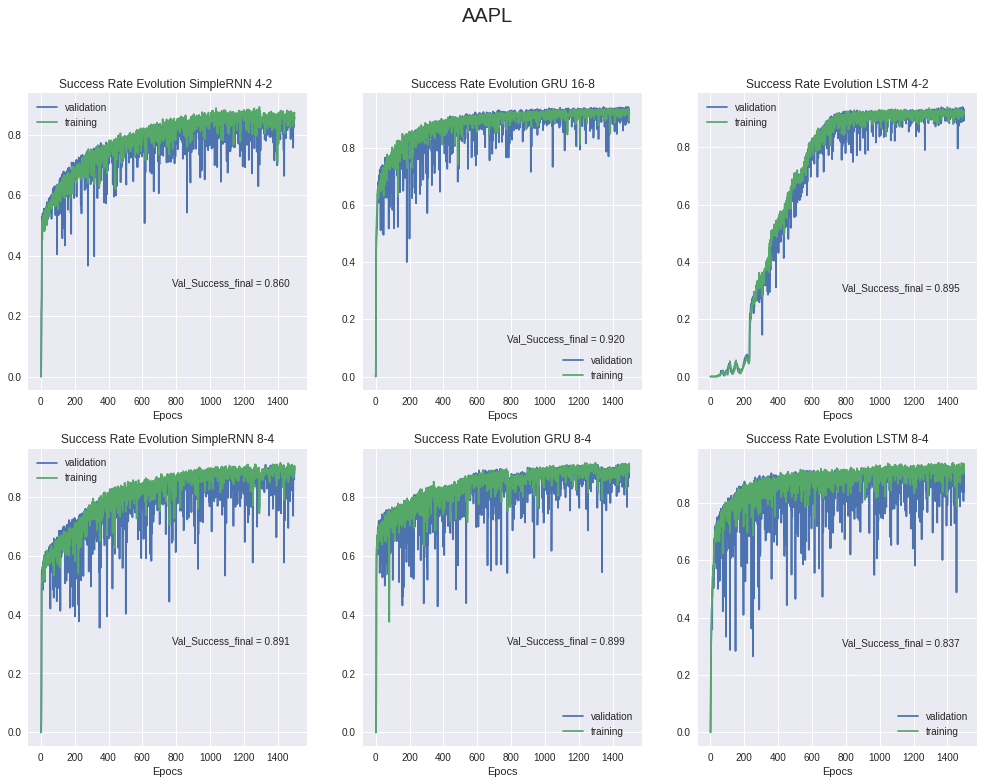

In [55]:
fig, axes = plt.subplots(2, 3,figsize=(17, 12))
fig.suptitle(tickers.Symbol[index],fontsize = 20)

# Plot de la RNN 8-4
axes[0,0].plot(history_RNN84.epoch,history_RNN84.history['val_porcentaje_margen'],label='validation')
axes[0,0].plot(history_RNN84.epoch,history_RNN84.history['porcentaje_margen'],label="training")
axes[0,0].legend()
axes[0,0].set_title('Success Rate Evolution SimpleRNN 4-2 ')
axes[0,0].set_xlabel('Epocs')
axes[0,0].annotate('Val_Success_final = %.3f'% history_RNN84.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)


# Plot de la RNN 816-8
axes[1,0].plot(history_RNN168.epoch,history_RNN168.history['val_porcentaje_margen'],label='validation')
axes[1,0].plot(history_RNN168.epoch,history_RNN168.history['porcentaje_margen'],label="training")
axes[1,0].legend()
axes[1,0].set_title('Success Rate Evolution SimpleRNN 8-4')
axes[1,0].set_xlabel('Epocs')
axes[1,0].annotate('Val_Success_final = %.3f'% history_RNN168.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la GRU 16-8
axes[0,1].plot(history_GRU168.epoch,history_GRU168.history['val_porcentaje_margen'],label='validation')
axes[0,1].plot(history_GRU168.epoch,history_GRU168.history['porcentaje_margen'],label="training")
axes[0,1].legend()
axes[0,1].set_title('Success Rate Evolution GRU 16-8')
axes[0,1].set_xlabel('Epocs')
axes[0,1].annotate('Val_Success_final = %.3f'% history_GRU168.history['val_porcentaje_margen'][-1], (1250, 0.12), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la GRU 16-8-4
axes[1,1].plot(history_GRU1684.epoch,history_GRU1684.history['val_porcentaje_margen'],label='validation')
axes[1,1].plot(history_GRU1684.epoch,history_GRU1684.history['porcentaje_margen'],label="training")
axes[1,1].legend()
axes[1,1].set_title('Success Rate Evolution GRU 8-4')
axes[1,1].set_xlabel('Epocs')
axes[1,1].annotate('Val_Success_final = %.3f'% history_GRU1684.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la LSTM 8-4
axes[0,2].plot(history_LSTM84.epoch,history_LSTM84.history['val_porcentaje_margen'],label='validation')
axes[0,2].plot(history_LSTM84.epoch,history_LSTM84.history['porcentaje_margen'],label="training")
axes[0,2].legend()
axes[0,2].set_title('Success Rate Evolution LSTM 4-2')
axes[0,2].set_xlabel('Epocs')
axes[0,2].annotate('Val_Success_final = %.3f'% history_LSTM84.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la LSTM 16-8
axes[1,2].plot(history_LSTM168.epoch,history_LSTM168.history['val_porcentaje_margen'],label='validation')
axes[1,2].plot(history_LSTM168.epoch,history_LSTM168.history['porcentaje_margen'],label="training")
axes[1,2].legend()
axes[1,2].set_title('Success Rate Evolution LSTM 8-4')
axes[1,2].set_xlabel('Epocs')
axes[1,2].annotate('Val_Success_final = %.3f'% history_LSTM168.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

plt.show()

In [21]:
# Calculo la prediccion para mi conjunto test
#predictedRNN84 = pd.DataFrame(modelRNN84.predict(Xtt))
predictedRNN168 = pd.DataFrame(modelRNN168.predict(Xtt))
predictedGRU168 = pd.DataFrame(modelGRU168.predict(Xtt))
#predictedGRU1684 = pd.DataFrame(modelGRU1684.predict(Xtt))
#predictedLSTM84 = pd.DataFrame(modelLSTM84.predict(Xtt))
predictedLSTM168 = pd.DataFrame(modelLSTM168.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
#rmseRNN84 = sqrt(mean_squared_error(ytt, predictedRNN84))
rmseRNN168 = sqrt(mean_squared_error(ytt, predictedRNN168))
rmseGRU168 = sqrt(mean_squared_error(ytt, predictedGRU168))
#rmseGRU1684 = sqrt(mean_squared_error(ytt, predictedGRU1684))
#rmseLSTM84 = sqrt(mean_squared_error(ytt, predictedLSTM84))
rmseLSTM168 = sqrt(mean_squared_error(ytt, predictedLSTM168))
#print(rmseRNN84,rmseRNN168,rmseGRU168,rmseGRU1684,rmseLSTM84,rmseLSTM168)

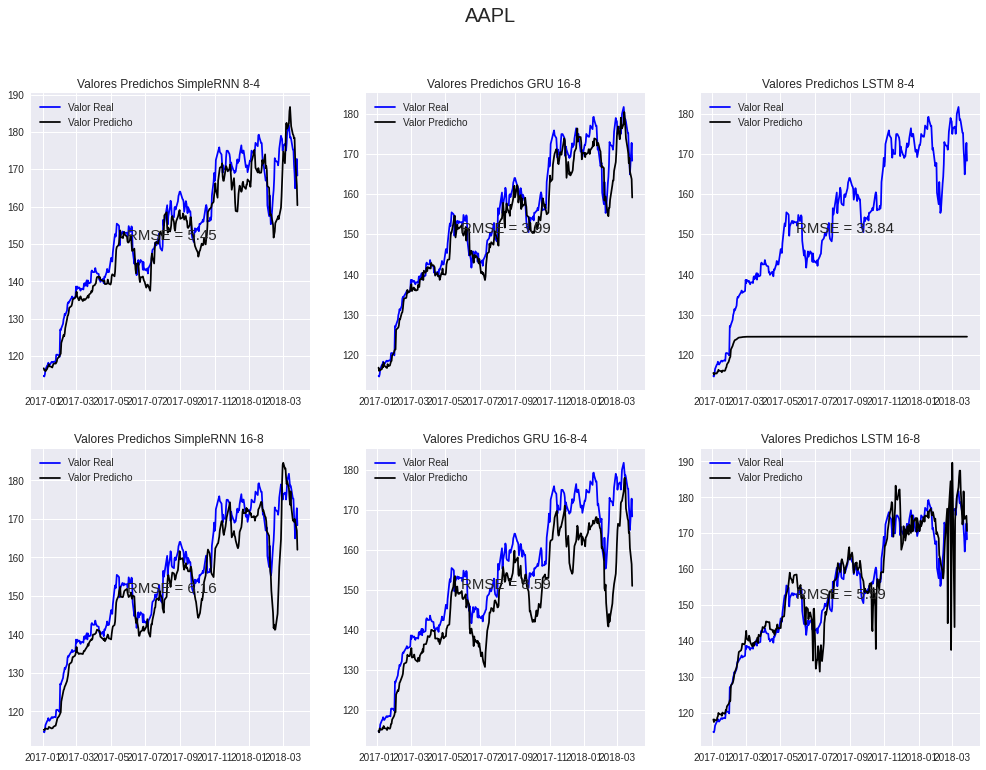

In [137]:
fig, axes = plt.subplots(2, 3,figsize=(17, 12))
fig.suptitle(tickers.Symbol[index],fontsize = 20)


# Plot de la RNN 8-4
axes[0,0].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0,0].plot(index_time_t,predictedRNN84, label="Valor Predicho", color = "black")
axes[0,0].legend()
axes[0,0].set_title('Valores Predichos SimpleRNN 8-4 ')
axes[0,0].annotate('RMSE = %.2f'% rmseRNN84, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)


# Plot de la RNN 16-8
axes[1,0].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1,0].plot(index_time_t,predictedRNN168, label="Valor Predicho", color = "black")
axes[1,0].legend()
axes[1,0].set_title('Valores Predichos SimpleRNN 16-8 ')
axes[1,0].annotate('RMSE = %.2f'% rmseRNN168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la GRU 16-8
axes[0,1].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0,1].plot(index_time_t,predictedGRU168, label="Valor Predicho", color = "black")
axes[0,1].legend()
axes[0,1].set_title('Valores Predichos GRU 16-8 ')
axes[0,1].annotate('RMSE = %.2f'% rmseGRU168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la GRU 16-8-4
axes[1,1].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1,1].plot(index_time_t,predictedGRU1684, label="Valor Predicho", color = "black")
axes[1,1].legend()
axes[1,1].set_title('Valores Predichos GRU 16-8-4')
axes[1,1].annotate('RMSE = %.2f'% rmseGRU1684, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la LSTM 8-4
axes[0,2].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0,2].plot(index_time_t,predictedLSTM84, label="Valor Predicho", color = "black")
axes[0,2].legend()
axes[0,2].set_title('Valores Predichos LSTM 8-4 ')
axes[0,2].annotate('RMSE = %.2f'% rmseLSTM84, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la LSTM 16-8
axes[1,2].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1,2].plot(index_time_t,predictedLSTM168, label="Valor Predicho", color = "black")
axes[1,2].legend()
axes[1,2].set_title('Valores Predichos LSTM 16-8')
axes[1,2].annotate('RMSE = %.2f'% rmseLSTM168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

plt.show()

Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [74]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos
predicted_stock_price = predictedLSTM168
# Es un margen movil, segun lo que busquemos
margen = 0.03
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({0.0: 302, 1.0: 5})


In [75]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado   valor     pred dif
2018-03-26     96.2787      787      0  172.77  159.472   0
Valor Final = 136066.27
Ganancia con margen = 36066.27


In [76]:
print(movimientos_alza)

           presupuesto acciones estado    valor     pred  dif
2017-01-03      100000        0      0  114.715  112.298  NaN
2017-01-04      100000        0      0  114.587   111.23    0
2017-01-05      100000        0      0   115.17   111.96    0
2017-01-06      100000        0      0  116.454   111.42    0
2017-01-09      100000        0      0   117.52  111.684    0
2017-01-10      100000        0      0  117.639  111.978    0
2017-01-11      100000        0      0  118.271  111.567    0
2017-01-12      100000        0      0  117.777  112.259    0
2017-01-13      100000        0      0   117.57  111.855    0
2017-01-17      100000        0      0  118.518  112.035    0
2017-01-18      100000        0      0  118.508  111.861    0
2017-01-19      100000        0      0  118.301  112.599    0
2017-01-20      100000        0      0  118.518  112.389    0
2017-01-23      100000        0      0  118.597  112.399    0
2017-01-24      100000        0      0  118.488  112.636    0
2017-01-

In [77]:
movimientos_alza.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/AAPL/Alza3LSTM20-168.csv")

In [78]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos_ab)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] + movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones[len(movimientos_ab)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] - movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones_debo[len(movimientos_ab)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado   valor     pred dif
2018-03-26     82.9059      871             0      0  172.77  159.472   0
Valor Final = 150565.58
Ganancia con margen = 50565.58


In [79]:
print(movimientos_ab)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2017-01-03     82.9059      871             0      0  114.715  112.298  NaN
2017-01-04     82.9059      871             0      0  114.587   111.23    0
2017-01-05     82.9059      871             0      0   115.17   111.96    0
2017-01-06     82.9059      871             0      0  116.454   111.42    0
2017-01-09     82.9059      871             0      0   117.52  111.684    0
2017-01-10     82.9059      871             0      0  117.639  111.978    0
2017-01-11     82.9059      871             0      0  118.271  111.567    0
2017-01-12     82.9059      871             0      0  117.777  112.259    0
2017-01-13     82.9059      871             0      0   117.57  111.855    0
2017-01-17     82.9059      871             0      0  118.518  112.035    0
2017-01-18     82.9059      871             0      0  118.508  111.861    0
2017-01-19     82.9059      871             0      0  118.301  112.599    0
2017-01-20  

In [80]:
movimientos_ab.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/AAPL/AlzaBaja3LSTM20-168.csv")

In [81]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos_baja)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] + movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] - movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado   valor     pred dif
2018-03-26      100000        0             0      0  172.77  159.472   0
Valor Final = 100000.00
Ganancia con margen = 0.00


In [82]:
print(movimientos_baja)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2017-01-03      100000        0             0      0  114.715  112.298  NaN
2017-01-04      100000        0             0      0  114.587   111.23    0
2017-01-05      100000        0             0      0   115.17   111.96    0
2017-01-06      100000        0             0      0  116.454   111.42    0
2017-01-09      100000        0             0      0   117.52  111.684    0
2017-01-10      100000        0             0      0  117.639  111.978    0
2017-01-11      100000        0             0      0  118.271  111.567    0
2017-01-12      100000        0             0      0  117.777  112.259    0
2017-01-13      100000        0             0      0   117.57  111.855    0
2017-01-17      100000        0             0      0  118.518  112.035    0
2017-01-18      100000        0             0      0  118.508  111.861    0
2017-01-19      100000        0             0      0  118.301  112.599    0
2017-01-20  

In [83]:
movimientos_baja.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/AAPL/Baja3LSTM20-168.csv")